In [27]:
import numpy as np
import scipy.io
from scipy import stats
from copy import copy
import matplotlib.pyplot as plt
import scipy as sp
import scipy.optimize as spo
from sklearn.linear_model import ElasticNet
import numpy.linalg as npl
import numpy.random as npr
from scipy.stats.mstats import linregress
from sklearn.decomposition import PCA
root2over = 1/np.sqrt(2)
erf_max = sp.special.erf(root2over)

#function to standardize the MEG data matrices, which have very small values around e-13, e-14
def standardize(data_matrix):
    #create a copy of the data_matrix and make it normalized_sensor_matrix, will just replace values in row during loop
    x = data_matrix[:]
    x-=np.mean(x) # the -= means can be read as x = x- np.mean(x)
    x/=np.std(x) # the /= means can be read as x = x/np.std(x)
    return x

# helper function to store all the sensor labels across patients present in the total dataset
def store_labels(sensor_labels, patient):
    all_sensor_labels = []
    for i in range(sensor_labels.shape[0]):
        new_tag = sensor_labels[i][0][0]+"_"+patient
        all_sensor_labels.append(new_tag)
    return all_sensor_labels

def store_reg_labels(sensor_labels, patient):
    all_sensor_labels = []
    for i in range(sensor_labels.shape[0]):
        new_tag = sensor_labels[i][0][0]
        all_sensor_labels.append(new_tag)
    return all_sensor_labels

#function to load the MEG data from an array with all the patient ids. Returns the raw and normalized MEG data
def load_sensor_matrix(id_list):
    labels_dict = {}
    separated_dataset = {}
    first_iteration = True   #boolean value that accomodates the first run through of MEG data
    for patient in id_list:
        data = scipy.io.loadmat('HCP_dataset/'+patient+'/MEG/Restin/rmegpreproc/'+patient+'_MEG_3-Restin_rmegpreproc.mat')
        data_times = data['data'][0][0][5][:]    #extracts the timecourses of the MEG data
        data_labels = data['data'][0][0][6][:]  #extracts the sensor labels for the MEG data
        data_trials = data['data'][0][0][4][:]   #extracts the MEG potentials over the given timecourse
        separated_dataset[patient] = data_trials[0][0]
        if first_iteration:
            sensor_matrix = data_trials[0][0][:]
            first_iteration = False    #no longer in the first iteration of the loop, set to false
        else:
            #if not in the first run through, append the matrices together, to form a combined matrix
            sensor_matrix = np.concatenate((sensor_matrix, data_trials[0][0][:]), axis = 0)
        #create an array with all the sensor_labels for every patient in the dataset
        all_data_labels = store_labels(data_labels, patient)
        labels_dict[patient] = set(store_reg_labels(data_labels, patient))
    return sensor_matrix, separated_dataset, all_data_labels, labels_dict

def common_labels(labels_dict):
    s = set()
    labels_dict_values = list(labels_dict.values())
    for index in range(len(labels_dict_values)-1):
        if bool(s) == False:
            s = set(labels_dict_values[index]).intersection(labels_dict_values[index+1])
        else:
            s = s.intersection(set(labels_dict_values[index+1]))
    return s

def form_dataset(common_labels_set, separated_dataset, labels_dict):
    streamlined_dataset = {}
    for patient in separated_dataset:
        for label in common_labels_set:
            channel_number = list(labels_dict[patient]).index(label)
            if patient not in streamlined_dataset:
                streamlined_dataset[patient] = [separated_dataset[patient][channel_number, :]]
            else:
                streamlined_dataset[patient].append(separated_dataset[patient][channel_number, :])
    return streamlined_dataset

def find_sigma(y,h):
    time_steps,size = y.shape
    sigma = np.std(y-h,axis=0)
    #     sigma = np.random.rand(1,size) + 0.5
    #     for index in range(size):
    #         def f0(sig):
    #             return (1-np.std(y[:,index]/np.abs(sig) - h[:,index]))**2
    #         res = spo.minimize(f0,sigma[0,index])
    #         sigma[0,index] = np.abs(res.x)
    return(sigma.reshape(1,size))

def time_shift_cov(x,shift=1):
    time_steps,size = x.shape
    x0 = (x - np.mean(x,axis=0))/np.std(x,axis=0)
    return x0[shift:].T.dot(x0[:-shift])/np.float(time_steps-shift)

def enet_solve(c,b):
    regr = ElasticNet(random_state=0,max_iter=10000)
    regr.fit(c,b)
    return regr.coef_

def moving_avg(a,window):
    cu = np.cumsum(a,axis=0,dtype=float)
    cu[window:] = cu[window:] - cu[:-window]
    return cu[window-1:]/window

def odd_power(h,power=3):
    sign = np.sign(h)
    return sign*np.power(np.abs(h),1/power)

#Now add in a bias
def simulate(size,time_steps,w = 0.0,sigma = 1.0,coupling = 1.0,rho = 0.2,power=1,delta = 1,bias=0, initial=0):
    if npl.norm(w)==0.:
        sigma = (npr.rand(1,size)+1)/2.0        
        delta = odd_power(npr.rand(1,size)+1,power)        
        bias = (npr.rand(1,size)-0.5)*2
        w = npr.rand(size,size) - 0.5
        w = coupling*w - rho*np.eye(size)
    x = np.zeros((time_steps,size))
    x_min = np.zeros((1,size))
#     if initial == 0:
#         x[0] = npr.rand(1,size)-0.5
#     else:
    x[0] = initial
    print(initial)
    for i in range(time_steps-1):
        x[i+1] = (1)*x[i] + delta * odd_power(bias + x[i].dot(w),power) + sigma*npr.normal(size=(1,size))
    y = np.diff(x,axis=0)
    y_max = np.max(np.abs(y),axis=0)
    opd = odd_power(delta,1/power)
    if not np.isscalar(delta):
        opd = odd_power(delta,1/power)
        return x,opd[0][None,:]*w,sigma,opd*bias
    else:
        return x,w,sigma,bias

def bias_update(y,h,b_in,pp):
    y_plus = y>0
    def f0(bias):
        return np.mean(y[y_plus]-odd_power(bias + h[y_plus],pp))**2 + np.mean(y[~y_plus]-odd_power(bias + h[~y_plus],pp))**2
    res = spo.minimize(f0,b_in)
    return res.x


def infer(x,max_iter = 100,tol=1e-8,func=npl.solve,window=1,power=1,verbose=False):
    time_steps,size = x.shape
    x0 = np.copy(x)
    if window>1:
        x0 = moving_avg(x0,window)
        time_steps = time_steps-window+1
    y = np.diff(x0,axis=0)
    y_mean = np.mean(np.abs(y),axis=0)
    y_max = np.max(np.abs(y),axis=0)
#     if power<3:
#         y /= y_max[None,:]#now y is definitely within +/- 1
#         x0 = x0/y_max[None,:]
    x0 = x0[:-1]
    s = np.sign(y)
    c = np.cov(x0,rowvar=False)
    w = npr.rand(size,size) - 0.5
    bias = npr.rand(1,size) - 0.5
    h = odd_power(bias + x0.dot(w),power)
    for index in range(size):
        err_old,error,counter = 0,np.inf,0
        #         print(index)
        while np.abs(error-err_old) > tol and counter < max_iter:
            counter += 1
            zeros = np.abs(bias[0,index] + x0.dot(w[:,index])) < 1e-7
            ratio = np.sqrt(np.pi/2.0)*np.ones((time_steps-1))*h[:,index]**(power-1)
            ratio[~zeros] = (bias[0,index] + x0[~zeros,:].dot(w[:,index]))/sp.special.erf(h[~zeros,index]*root2over)
            w[:,index] = func(c+0.1*np.eye(size),np.mean((x0-np.mean(x0,axis=0)[None,:])*(s[:,index]*ratio)[:,np.newaxis],axis=0))
            h_temp = x0.dot(w[:,index])
            bias[0,index] = bias_update(y[:,index],h_temp,bias[0,index],pp=power)
            err_old = error
            h[:,index] = odd_power(bias[0,index] + h_temp,power)
            error = npl.norm(s[:,index]-sp.special.erf(h[:,index]*root2over))
#             print(counter,error)
    sigma = find_sigma(y,h)*np.sqrt(window)#*y_max[None,:]
    return w,sigma,bias

def pca_combine_datasets(streamlined_dataset):
    pca_combined_dataset = np.array([])
    for patient in streamlined_dataset:
        x = np.asarray(streamlined_dataset[patient])
        if pca_combined_dataset.size == 0:
            pca_combined_dataset = x
        else:
            pca_combined_dataset = np.concatenate((pca_combined_dataset, x), axis=1 )
    return pca_combined_dataset

def calculate_allW(dataset, given_power):
    allwmatrices = {}
    allsigs = {}
    allbiases = {}
    for patient in dataset:
        w, sig, bias = infer(dataset[patient].transpose(), power=given_power)
        allwmatrices[patient] = w
        allsigs[patient] = sig
        allbiases[patient] = bias
    return allwmatrices, allsigs, allbiases

def calculate_allTimeCov(dataset, time_shift):
    alltimeshiftcov = {}
    for patient in dataset:
        timeshiftcovmatrix = time_shift_cov(dataset[patient].transpose(), shift=time_shift)
        alltimeshiftcov[patient] = timeshiftcovmatrix
    return alltimeshiftcov

def hcp_inference(dataset_ids, pca_components, time_shift, power):
    print("Running Newest Inference Linear with Power Fixed:")
    print("1. PCA components =", pca_components)
    print("2. Time shifts =", time_shift)
    print("3. Power =", power)
    sensor_matrix, separated_dataset, all_data_labels, labels_dict = load_sensor_matrix(dataset_ids)
    common_labels_set = common_labels(labels_dict.copy())
    streamlined_dataset = form_dataset(common_labels_set.copy(), separated_dataset.copy(), labels_dict.copy())
    normalized_streamlined_dataset = {}
    for patient in streamlined_dataset:
        normalized_streamlined_dataset[patient] = standardize(streamlined_dataset[patient])
    pca_data_dict = {}
    pca_combined_dataset = pca_combine_datasets(normalized_streamlined_dataset.copy())
    pca = PCA(n_components=pca_components)
    pca.fit(pca_combined_dataset.T)
    transformed_data = pca.fit_transform(pca_combined_dataset.T)
    counter = 0
    for patient in normalized_streamlined_dataset:
        pca_data_dict[patient] = transformed_data[counter*1018:1018*(counter+1), :].T
        counter = counter + 1
    allwmatrices, allsigs, allbiases = calculate_allW(pca_data_dict, power)
    alltscmatrices = calculate_allTimeCov(pca_data_dict, time_shift)
    return allwmatrices, alltscmatrices, allsigs, allbiases, pca_data_dict

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.mstats import linregress
%matplotlib inline

In [29]:
power = 1
pca_components = 10
time_shift = 10
dataset_ids = ['100307', '102816', '105923', '106521', '108323', '109123', '111514', '112920', 
               '116524', '116726', '133019', '140117', '146129', '149741', '153732', '154532', 
               '156334', '158136', '162026', '162935', '164636', '166438', '169040', '172029', 
               '174841', '175237', '175540', '177746', '179245', '181232', '185442', '187547', 
               '189349', '191033', '191437', '191841', '192641', '195041', '198653', '204521', 
               '205119', '212318', '212823', '214524', '221319', '223929', '233326', '248339', 
               '250427', '255639', '257845', '283543', '287248', '293748', '352132', '352738', 
               '353740', '358144', '406836', '433839', '512835', '555348', '559053', '568963', 
               '581450', '599671', '601127', '660951', '662551', '665254', '667056', '679770', 
               '680957', '706040', '707749', '715950', '725751', '735148', '783462', '814649',
               '825048', '872764', '877168', '891667', '898176', '912447', '917255', '990366']

In [30]:
allwmatrices, alltscmatrices, allsigs, allbiases, pca_data_dict = hcp_inference(dataset_ids, pca_components, time_shift, power)

Running Newest Inference Linear with Power Fixed:
1. PCA components = 10
2. Time shifts = 10
3. Power = 1


In [31]:
# allwmatrices is a dictionary with patient identifiers as keys. allwmatrices[key] will return the w matrix 
# for that specific patient
slope_average = 0
pvalue_nonlinear_average = 0
pvalue_linear_10trials = []
counter = 0
pvalue_bytimeshift = []
timeshifts = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for timeshift in timeshifts:
    for i in range(20):
        pvalue_linear_array = []
        for patient in allwmatrices:
            w = allwmatrices[patient]
            sig = allsigs[patient]
            bias = allbiases[patient]

            x_original = pca_data_dict[patient].T.copy()

            # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
            simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, power=1, bias=bias, initial=x_original[0])

            # compute the time shift covariance matrices for the 'original' (transformed PCA MEG timecourse) and simulated data
            tsc_original = time_shift_cov(x_original, shift=timeshift)
            tsc_simulated = time_shift_cov(simulated_data[0], shift=timeshift)


            line_object = linregress(tsc_original, tsc_simulated)
    #         plt.title('Patient ' + str(patient))
    #         plt.xlabel('time_shift_cov original')
    #         plt.ylabel('time_shift_cov simulated')
    #         plt.plot(tsc_original, tsc_simulated, 'ko', alpha=0.5)
    #         plt.plot([-1, 1], [-1,1], 'r--')
    #         time_shift_axes = np.arange(-1, 2)
    #         plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
    #         plt.show()
    #         print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
    #         print("--------------------------------------------------------------")
            pvalue_nonlinear_average += line_object.pvalue
            pvalue_linear_array.append(line_object.pvalue)
            slope_average += line_object.slope
            counter += 1
        pvalue_linear_10trials.append(np.mean(pvalue_linear_array))
    print('mean', np.mean(pvalue_linear_10trials))
    print('std', np.std(pvalue_linear_10trials))
    pvalue_bytimeshift.append(np.mean(pvalue_linear_10trials))
print(pvalue_bytimeshift)

[ 2.52504481 -1.98582059 -0.5632994  -0.38336103 -0.72359155  1.29847824
  0.03149707  0.58144337  0.03104282 -1.73038832]
[-1.03850871 -4.05020672 -0.01608847  1.16977938  3.71886982  0.12022514
 -2.81185736 -1.95381792 -0.0049194  -0.11272633]
[-2.85272213  3.48237955 -1.18853763 -1.31162145  0.23705474 -1.37310969
 -0.53694952  0.01047407 -0.47799794 -1.28348375]
[ 1.67280612  0.06432068  4.9062833   2.42726096 -4.69629262  0.77197959
  1.66948947  1.15436813 -0.83250477  2.82760708]
[-1.72696135  0.69011193 -1.37892714 -1.6431824  -1.25141694 -1.50675826
 -0.28904551  0.14907615  0.47938581  0.41228155]
[-0.37290734  0.74051737 -0.77156255 -0.96638183 -1.49940937  0.34951095
 -0.26890798 -0.9358392  -0.81106285 -1.09493647]
[ 7.79794142 -2.98880133  2.87130025 -0.70083831  0.38354044 -1.8068914
  3.89652962  2.09560835  2.50026733  0.5231474 ]
[ 9.46395216 -3.85184266  2.33406703 -3.2740045   1.18428953 -4.03680823
  1.6887943  -1.14411555 -1.91388607 -2.1043282 ]
[ 2.91362848  1.6

[-0.80410559 -0.60376455  4.46273513 -0.54208179 -1.59594466  2.55134902
  1.37687085  0.01955942  0.36818645  2.34174522]
[ 2.71079211 -2.50699861 -3.72223806  1.46803811  0.71340726 -2.90189865
  0.80790638 -0.39354267  0.75584665 -1.93867344]
[ 1.50200725  0.46850718 -2.62691691 -1.99131528  0.73616085 -2.54985554
  0.29467087  1.01641822 -0.08603483 -0.18487577]
[-0.5185713   1.36603578  1.16846808 -1.40345711  2.81964505 -0.55782024
  0.69479887  1.98545516 -1.16420877  0.30828617]
[ 5.82350343  0.22950036 -0.28469651  0.59826105  1.8266939   2.10069925
 -0.42822934 -0.03250725  2.31837342  0.86014138]
[-0.25922882 -0.02566212  0.27569899 -1.58061698 -2.0283923  -1.36066727
 -0.66664555  1.23335108 -0.62346467  0.60958745]
[ 1.23628902 -2.07339302  1.73886857  0.46119746  0.60907129 -1.84780243
  1.81566235 -2.76084283  0.36492567 -0.01645219]
[-1.99608645  3.22976932 -2.69132138  4.24394058 -1.19078617  1.82502169
 -2.53446331  1.32382958 -2.07501858  2.56153072]
[ 2.53073002  1.

[-2.52813839  0.11194575  0.78825825 -5.90281265  2.04761268 -1.3440778
  0.39240308  0.23383895  1.94207562 -0.76841696]
[ 0.20497165 -4.11150692 -1.76751819 -1.24346212 -0.72544098 -2.46950655
  1.63428983 -0.71886718  0.19905809  0.31309303]
[ 2.58054019 -2.40495827  0.04281907 -0.70666901 -2.75058206  0.33806283
  3.41817928 -1.27147394 -0.95115699 -0.6414008 ]
[-2.33956854 -2.46501508  1.89203465 -0.63034985  1.74097325  0.69085462
  1.12873689 -0.75932758  0.10451709 -1.24155765]
[ 1.61816167  4.38210507  0.53810619  4.6603284  -0.50333229 -0.20976681
  0.87292414  0.9720029  -1.27040365 -0.12976634]
[ 2.50956891  1.02435671  2.00517632 -2.10877389  0.32139531 -0.51486196
  1.96727047 -0.57676334 -1.82590575  0.33344626]
[-1.45287051 -0.22536309 -1.57026988 -4.18099509 -1.85656989  2.21572464
  0.89605798  1.37002086 -0.63823644  0.59612196]
[-2.99382631  0.80240527 -1.38823971 -3.24928567 -0.34908855 -0.80120261
  1.07694205  0.58148509  0.75497593  0.51496939]
[-4.60196019 -2.1

[ 0.0105875   2.92941222 -0.18909307  0.4497706  -2.95428291 -0.40740467
 -2.27111589 -0.19657222 -0.20422587  1.16012826]
[-1.76035723 -3.03060567  0.43834004  0.48449647 -2.61226311  1.31526451
 -1.95156034  2.23590541  0.69088577 -2.26781023]
[ 5.54341124 -5.71057366 -1.38469338 -0.99479318 -2.46985642  0.68978914
 -1.42938768  0.81556316  1.77948117  1.17371341]
[-1.02612053 -4.01508274 -7.63601834 -1.02745557  1.77028822 -0.45320881
  0.35578817  0.26117059  0.55990072  0.44427677]
[-0.59851567 -5.00921003 -1.34828401 -2.36835714  3.19991002  3.23032352
  2.46867621 -1.48774184 -0.61143467 -0.11414989]
[-1.66801046  4.88976461  3.47220953  1.71998102 -0.36523363  0.81933976
  0.81898255  2.11410694 -2.58815042  0.3014246 ]
[ 0.46929242 -3.3350535   2.73819299  1.61704468 -0.38573718  0.30614898
  1.01981114 -0.14590283  1.79764674  2.02485895]
[-3.27374371  1.38470653 -3.38077975  5.54205466 -1.1948096  -1.27884391
  1.2225865   3.31193647  1.66507102  0.70830915]
[ 0.30703454 -0.

[ 5.75854762 -4.0291092   2.07564789 -1.59854211 -0.41334188 -0.21708794
 -1.29900907 -0.01504344 -2.56239219 -0.30294741]
[-5.21681429  0.41208476 -1.56887641  0.93348112  0.40531824 -0.98518786
  1.51341293  1.29563141  2.61507996 -0.04191775]
[ 0.70667956 -2.23078349 -4.81591617 -0.5168315  -3.31119955 -0.33228125
  0.77369064  1.64181449 -1.29654985  0.81735488]
[-0.27598864 -0.38160877  0.4212746   1.07915185 -1.51227887  2.50861131
 -0.70463266  0.66683344 -0.18933169  0.47031788]
[ 0.08280783 -0.44323189  1.01517674  1.99511845  0.81820701 -0.6470525
  0.01301473 -1.1671997   1.50120187  1.59496062]
[-0.6021767  -2.20644112 -2.63323584 -0.0425961   0.30072847 -0.27731987
  1.428238    0.77333576 -0.33593276 -1.20935413]
[-1.64725991 -1.02524732 -7.1899013  -0.90175044  5.54604109  2.11170405
  1.18004542 -0.8214239  -1.23561894  1.9383455 ]
[-1.75766476  0.28743563  0.82168689  1.72049948 -3.34284234 -1.02244453
  0.49861985 -1.53050774  0.89382999 -1.17788279]
[ 1.15975025 -1.6

[ 3.61389304  6.44161797  3.62203629  1.34023135 -2.72992341 -0.31107026
  0.18939088  0.45683594 -0.24139216 -1.14765685]
[-0.08006304 -1.98542339 -0.298472   -0.60302117 -2.09235632 -1.62652461
 -0.82040927  0.99369265  0.94661629 -1.93575655]
[ 6.82407210e+00 -2.52347287e+00 -1.80496293e+00  7.94969601e-01
  8.69900195e-01 -2.25368959e-01  2.15452021e+00 -1.51135416e-03
 -3.43923398e-03  1.13831878e-01]
[-0.72115035  1.61792512 -0.321729    0.03181584  2.19435088 -0.34655928
 -0.8349467  -0.74437199  0.69934565 -0.25962759]
[-2.28175307  1.31041711 -1.36703189  1.04204836  1.39399994  1.22077249
  0.28580047 -0.80388573  0.79425435  2.2677902 ]
[-0.2776008  -0.34112678 -1.73970877 -1.1762919  -1.03066804  0.17113057
  0.09626191 -0.31648062 -0.4026714   0.04044938]
[ 2.52504481 -1.98582059 -0.5632994  -0.38336103 -0.72359155  1.29847824
  0.03149707  0.58144337  0.03104282 -1.73038832]
[-1.03850871 -4.05020672 -0.01608847  1.16977938  3.71886982  0.12022514
 -2.81185736 -1.95381792 

[ 1.82837213 -5.50341924  3.7243968  -2.82355947 -1.54021972  2.48825882
  1.89449242  0.88846148  1.44981722 -1.15824424]
[ 7.6829414  -0.14110171 -2.43139114  7.70270366 -2.23854265 -1.05120059
  2.05799498  3.05402131  1.22060918 -1.47679103]
[ 2.26865821  1.82938247  0.39461867 -1.52492759  0.61391472 -0.4699611
 -0.77216918 -0.32598973  0.9556153  -0.7030385 ]
[ 0.00607079 -1.83377103 -0.3428502   0.15085039 -0.01739351  1.15518433
 -0.51367978 -1.25642097 -0.01326641 -0.6691431 ]
[ 3.01114938e+00  5.99457241e-01 -1.20998516e-02 -9.35745744e-01
 -1.33319812e+00 -2.26621914e+00  2.04577695e-03  1.22592743e+00
 -5.25078852e-01  4.05503274e-02]
[ 3.23980222  4.36425363 -3.76372024 -4.83606275  2.36110072 -1.86973977
  2.76810572  0.1775453  -0.8712077   0.93264072]
[ 4.19873173  2.42743366 -0.73265637  2.0966547  -0.15252237  1.13435055
 -1.86595528 -1.83641041 -1.111983    1.75609136]
[-3.27112549  2.68024423 -5.34309929 -0.44168393  0.12256059 -1.23766188
 -2.73312367 -0.21340903 -

[-2.9039437  -1.36277528  1.97005823  1.36506279 -0.98481185  2.79096079
 -1.29756606 -1.85317248  0.82779952  0.90196326]
[ 1.8607724   0.85278848  0.03428544 -1.61181783 -0.06724238 -0.05475342
 -0.40442297 -0.90170452 -0.18153518  0.17343739]
[-1.64102721  5.39060014 -0.37915706  0.93253884  1.50978795 -1.26985946
  0.9647455  -2.46991732  0.73069451 -1.46893796]
[-1.51416096e+00 -2.56522195e+00  1.06912618e-03 -4.33030203e-01
 -1.17475680e+00 -6.01616171e-01  7.02138119e-01  2.76468475e-01
  3.27594801e-01 -7.03574895e-01]
[-7.60719697 -7.40325338  1.42164528  0.71520309 -1.06650791  0.41458471
 -1.85219297  0.24781337  2.55214795 -1.2983523 ]
[-5.96560301  3.37570045 -3.80057616  1.9266819   2.461272   -2.90746242
 -0.56654162  0.8445087   1.9499374   3.05043376]
[-0.51757239 -0.4892558   1.58527161 -0.32492866  0.41507645 -0.85875311
  0.28647647  0.46738128 -0.22361051 -0.56349933]
[-2.7487932  -3.41791483 -0.4187929   1.06996683  2.88635499  0.30212482
 -0.68356654 -0.28309557 

[ 2.41111435 -5.2015911  -1.2627426  -1.45324383 -0.53013835  0.22534517
 -0.10199073 -1.29868062  0.26135686 -1.35936601]
[ 8.9521213  -0.25811503  1.05685318 -0.84045352  1.80760269 -1.06809614
 -1.88816699  0.39108859 -2.31216822 -0.17197436]
[ 4.34393074  0.73339565  0.96879034 -1.68679222 -1.09029718 -0.72803706
  0.63969155  1.5055944   1.1628338  -0.90012899]
[ 0.15276841 -2.00914852 -2.04844493  0.52933634  4.4357447   0.12719756
  0.59304051  0.9417863  -0.96384092  0.34121672]
[ 5.97935044 -1.36308898 -1.17776456 -0.60027776  0.44289504  0.85157974
  0.38827675  2.89301677 -1.20295181 -1.0423714 ]
[-5.38504566 -7.33479986 -4.07591915 -2.69852881  0.30414917  1.33841774
  2.50404539  0.49522008  0.85361979 -1.08853477]
[-1.79637989  0.33086916  1.06646321 -0.471581   -0.41053051 -1.99754623
 -1.61322121  0.91972987  1.36081253  0.9826694 ]
[ 0.0105875   2.92941222 -0.18909307  0.4497706  -2.95428291 -0.40740467
 -2.27111589 -0.19657222 -0.20422587  1.16012826]
[-1.76035723 -3.

[ 9.46395216 -3.85184266  2.33406703 -3.2740045   1.18428953 -4.03680823
  1.6887943  -1.14411555 -1.91388607 -2.1043282 ]
[ 2.91362848  1.63606389  1.0115985  -1.28589245 -1.18972422  1.67195695
 -0.33562277 -1.84824687  2.36854853 -0.594932  ]
[ 0.20388787  3.64324123 -4.37442286  1.6165172   0.35408176 -3.25291526
  4.51236847  2.93686524 -2.44751407 -1.53592665]
[ 0.34374984  1.14967496 -1.63984064  2.04472318  1.03620394  1.42868231
 -0.73433669 -0.28424908  0.00966714  0.26792529]
[ 1.43979696  2.76774162 -0.10904173 -0.62761849 -1.0663874  -0.91153417
 -0.97335617 -0.22847783 -0.08749533 -0.48386626]
[ 1.45656291  1.05391442  1.22470129 -0.83195934 -0.35077049 -0.7700528
  0.3196948   0.18119175  0.03861266  1.06887992]
[ 5.75854762 -4.0291092   2.07564789 -1.59854211 -0.41334188 -0.21708794
 -1.29900907 -0.01504344 -2.56239219 -0.30294741]
[-5.21681429  0.41208476 -1.56887641  0.93348112  0.40531824 -0.98518786
  1.51341293  1.29563141  2.61507996 -0.04191775]
[ 0.70667956 -2.2

[ 1.23628902 -2.07339302  1.73886857  0.46119746  0.60907129 -1.84780243
  1.81566235 -2.76084283  0.36492567 -0.01645219]
[-1.99608645  3.22976932 -2.69132138  4.24394058 -1.19078617  1.82502169
 -2.53446331  1.32382958 -2.07501858  2.56153072]
[ 2.53073002  1.47976373 -0.12186085 -0.08272182 -0.14611031 -2.57054376
 -1.94747287  0.35031746  0.46839872 -0.54023576]
[ 0.32849054  0.58108896 -1.2438039   1.13321417 -2.01172202 -0.58147622
  0.61494025 -1.40608602 -0.62542911 -0.41131832]
[-0.18547345  6.19288376 -0.56748338  0.39485276 -6.55229239  0.08526401
 -1.39429169  1.14651482  1.81003917 -0.29260036]
[ 3.61389304  6.44161797  3.62203629  1.34023135 -2.72992341 -0.31107026
  0.18939088  0.45683594 -0.24139216 -1.14765685]
[-0.08006304 -1.98542339 -0.298472   -0.60302117 -2.09235632 -1.62652461
 -0.82040927  0.99369265  0.94661629 -1.93575655]
[ 6.82407210e+00 -2.52347287e+00 -1.80496293e+00  7.94969601e-01
  8.69900195e-01 -2.25368959e-01  2.15452021e+00 -1.51135416e-03
 -3.43923

[-1.45287051 -0.22536309 -1.57026988 -4.18099509 -1.85656989  2.21572464
  0.89605798  1.37002086 -0.63823644  0.59612196]
[-2.99382631  0.80240527 -1.38823971 -3.24928567 -0.34908855 -0.80120261
  1.07694205  0.58148509  0.75497593  0.51496939]
[-4.60196019 -2.16462174  1.96879181  1.23494217  0.56318836  0.88487832
 -1.66431948 -0.1666457   0.97590523 -0.46890069]
[ 1.32035407  4.24447128  2.03575421 -1.70613813 -0.12141647 -1.23699996
 -0.19379457 -0.80383024  2.25114705 -1.40835102]
[ 2.88207241  2.52838393  2.03080257  1.38157749 -2.6975917   0.17377679
  0.57039733  0.16929973 -1.40644111  1.38250834]
[ 1.82837213 -5.50341924  3.7243968  -2.82355947 -1.54021972  2.48825882
  1.89449242  0.88846148  1.44981722 -1.15824424]
[ 7.6829414  -0.14110171 -2.43139114  7.70270366 -2.23854265 -1.05120059
  2.05799498  3.05402131  1.22060918 -1.47679103]
[ 2.26865821  1.82938247  0.39461867 -1.52492759  0.61391472 -0.4699611
 -0.77216918 -0.32598973  0.9556153  -0.7030385 ]
[ 0.00607079 -1.8

[ 1.26317458  0.23212618 -0.84285128 -0.03263896  2.13647438  0.55277053
  2.97999113  0.49071926  0.02197614 -0.17972324]
[ 0.84575414  7.34372957 -0.76389833 -0.79982812 -1.07334726  2.17897252
 -1.50581629 -0.11697785 -1.1627519   0.8019858 ]
[-9.96448859  3.88662462  1.11411522  1.93067672 -0.84256633 -1.50550875
 -0.47857332 -2.15784414 -2.09705408 -1.63755667]
[-2.9039437  -1.36277528  1.97005823  1.36506279 -0.98481185  2.79096079
 -1.29756606 -1.85317248  0.82779952  0.90196326]
[ 1.8607724   0.85278848  0.03428544 -1.61181783 -0.06724238 -0.05475342
 -0.40442297 -0.90170452 -0.18153518  0.17343739]
[-1.64102721  5.39060014 -0.37915706  0.93253884  1.50978795 -1.26985946
  0.9647455  -2.46991732  0.73069451 -1.46893796]
[-1.51416096e+00 -2.56522195e+00  1.06912618e-03 -4.33030203e-01
 -1.17475680e+00 -6.01616171e-01  7.02138119e-01  2.76468475e-01
  3.27594801e-01 -7.03574895e-01]
[-7.60719697 -7.40325338  1.42164528  0.71520309 -1.06650791  0.41458471
 -1.85219297  0.24781337 

[ 2.41111435 -5.2015911  -1.2627426  -1.45324383 -0.53013835  0.22534517
 -0.10199073 -1.29868062  0.26135686 -1.35936601]
[ 8.9521213  -0.25811503  1.05685318 -0.84045352  1.80760269 -1.06809614
 -1.88816699  0.39108859 -2.31216822 -0.17197436]
[ 4.34393074  0.73339565  0.96879034 -1.68679222 -1.09029718 -0.72803706
  0.63969155  1.5055944   1.1628338  -0.90012899]
[ 0.15276841 -2.00914852 -2.04844493  0.52933634  4.4357447   0.12719756
  0.59304051  0.9417863  -0.96384092  0.34121672]
[ 5.97935044 -1.36308898 -1.17776456 -0.60027776  0.44289504  0.85157974
  0.38827675  2.89301677 -1.20295181 -1.0423714 ]
[-5.38504566 -7.33479986 -4.07591915 -2.69852881  0.30414917  1.33841774
  2.50404539  0.49522008  0.85361979 -1.08853477]
[-1.79637989  0.33086916  1.06646321 -0.471581   -0.41053051 -1.99754623
 -1.61322121  0.91972987  1.36081253  0.9826694 ]
[ 0.0105875   2.92941222 -0.18909307  0.4497706  -2.95428291 -0.40740467
 -2.27111589 -0.19657222 -0.20422587  1.16012826]
[-1.76035723 -3.

[-0.37290734  0.74051737 -0.77156255 -0.96638183 -1.49940937  0.34951095
 -0.26890798 -0.9358392  -0.81106285 -1.09493647]
[ 7.79794142 -2.98880133  2.87130025 -0.70083831  0.38354044 -1.8068914
  3.89652962  2.09560835  2.50026733  0.5231474 ]
[ 9.46395216 -3.85184266  2.33406703 -3.2740045   1.18428953 -4.03680823
  1.6887943  -1.14411555 -1.91388607 -2.1043282 ]
[ 2.91362848  1.63606389  1.0115985  -1.28589245 -1.18972422  1.67195695
 -0.33562277 -1.84824687  2.36854853 -0.594932  ]
[ 0.20388787  3.64324123 -4.37442286  1.6165172   0.35408176 -3.25291526
  4.51236847  2.93686524 -2.44751407 -1.53592665]
[ 0.34374984  1.14967496 -1.63984064  2.04472318  1.03620394  1.42868231
 -0.73433669 -0.28424908  0.00966714  0.26792529]
[ 1.43979696  2.76774162 -0.10904173 -0.62761849 -1.0663874  -0.91153417
 -0.97335617 -0.22847783 -0.08749533 -0.48386626]
[ 1.45656291  1.05391442  1.22470129 -0.83195934 -0.35077049 -0.7700528
  0.3196948   0.18119175  0.03861266  1.06887992]
[ 5.75854762 -4.02

[ 2.71079211 -2.50699861 -3.72223806  1.46803811  0.71340726 -2.90189865
  0.80790638 -0.39354267  0.75584665 -1.93867344]
[ 1.50200725  0.46850718 -2.62691691 -1.99131528  0.73616085 -2.54985554
  0.29467087  1.01641822 -0.08603483 -0.18487577]
[-0.5185713   1.36603578  1.16846808 -1.40345711  2.81964505 -0.55782024
  0.69479887  1.98545516 -1.16420877  0.30828617]
[ 5.82350343  0.22950036 -0.28469651  0.59826105  1.8266939   2.10069925
 -0.42822934 -0.03250725  2.31837342  0.86014138]
[-0.25922882 -0.02566212  0.27569899 -1.58061698 -2.0283923  -1.36066727
 -0.66664555  1.23335108 -0.62346467  0.60958745]
[ 1.23628902 -2.07339302  1.73886857  0.46119746  0.60907129 -1.84780243
  1.81566235 -2.76084283  0.36492567 -0.01645219]
[-1.99608645  3.22976932 -2.69132138  4.24394058 -1.19078617  1.82502169
 -2.53446331  1.32382958 -2.07501858  2.56153072]
[ 2.53073002  1.47976373 -0.12186085 -0.08272182 -0.14611031 -2.57054376
 -1.94747287  0.35031746  0.46839872 -0.54023576]
[ 0.32849054  0.

[-2.52813839  0.11194575  0.78825825 -5.90281265  2.04761268 -1.3440778
  0.39240308  0.23383895  1.94207562 -0.76841696]
[ 0.20497165 -4.11150692 -1.76751819 -1.24346212 -0.72544098 -2.46950655
  1.63428983 -0.71886718  0.19905809  0.31309303]
[ 2.58054019 -2.40495827  0.04281907 -0.70666901 -2.75058206  0.33806283
  3.41817928 -1.27147394 -0.95115699 -0.6414008 ]
[-2.33956854 -2.46501508  1.89203465 -0.63034985  1.74097325  0.69085462
  1.12873689 -0.75932758  0.10451709 -1.24155765]
[ 1.61816167  4.38210507  0.53810619  4.6603284  -0.50333229 -0.20976681
  0.87292414  0.9720029  -1.27040365 -0.12976634]
[ 2.50956891  1.02435671  2.00517632 -2.10877389  0.32139531 -0.51486196
  1.96727047 -0.57676334 -1.82590575  0.33344626]
[-1.45287051 -0.22536309 -1.57026988 -4.18099509 -1.85656989  2.21572464
  0.89605798  1.37002086 -0.63823644  0.59612196]
[-2.99382631  0.80240527 -1.38823971 -3.24928567 -0.34908855 -0.80120261
  1.07694205  0.58148509  0.75497593  0.51496939]
[-4.60196019 -2.1

[ 5.54341124 -5.71057366 -1.38469338 -0.99479318 -2.46985642  0.68978914
 -1.42938768  0.81556316  1.77948117  1.17371341]
[-1.02612053 -4.01508274 -7.63601834 -1.02745557  1.77028822 -0.45320881
  0.35578817  0.26117059  0.55990072  0.44427677]
[-0.59851567 -5.00921003 -1.34828401 -2.36835714  3.19991002  3.23032352
  2.46867621 -1.48774184 -0.61143467 -0.11414989]
[-1.66801046  4.88976461  3.47220953  1.71998102 -0.36523363  0.81933976
  0.81898255  2.11410694 -2.58815042  0.3014246 ]
[ 0.46929242 -3.3350535   2.73819299  1.61704468 -0.38573718  0.30614898
  1.01981114 -0.14590283  1.79764674  2.02485895]
[-3.27374371  1.38470653 -3.38077975  5.54205466 -1.1948096  -1.27884391
  1.2225865   3.31193647  1.66507102  0.70830915]
[ 0.30703454 -0.82856413  1.5423714   0.35871982 -4.05303505  0.91109254
 -1.30854338 -0.23090945 -1.16834584  0.42682378]
[ 1.11576518  0.33639168  2.40042916 -2.82937539  1.99716466 -1.21783988
  0.6746085   0.21501409 -1.41511179  0.3019937 ]
[ 1.26317458  0.

[ 0.08280783 -0.44323189  1.01517674  1.99511845  0.81820701 -0.6470525
  0.01301473 -1.1671997   1.50120187  1.59496062]
[-0.6021767  -2.20644112 -2.63323584 -0.0425961   0.30072847 -0.27731987
  1.428238    0.77333576 -0.33593276 -1.20935413]
[-1.64725991 -1.02524732 -7.1899013  -0.90175044  5.54604109  2.11170405
  1.18004542 -0.8214239  -1.23561894  1.9383455 ]
[-1.75766476  0.28743563  0.82168689  1.72049948 -3.34284234 -1.02244453
  0.49861985 -1.53050774  0.89382999 -1.17788279]
[ 1.15975025 -1.62831551 -2.21330232 -1.15845124 -2.16843051 -0.03889654
 -0.90698051 -0.4011796   0.57433878  1.22997563]
[ 3.63530918 -5.76976906  2.06123783  1.15073445  3.44376024  0.64316101
  0.20862066  2.4256218  -0.06031037 -0.57601779]
[ 3.64752357 -0.32337886 -0.65269314  0.55562214  0.715101    1.58718672
  0.18242226 -0.5429288   0.94188622 -0.98104903]
[ 2.41111435 -5.2015911  -1.2627426  -1.45324383 -0.53013835  0.22534517
 -0.10199073 -1.29868062  0.26135686 -1.35936601]
[ 8.9521213  -0.2

[-0.72115035  1.61792512 -0.321729    0.03181584  2.19435088 -0.34655928
 -0.8349467  -0.74437199  0.69934565 -0.25962759]
[-2.28175307  1.31041711 -1.36703189  1.04204836  1.39399994  1.22077249
  0.28580047 -0.80388573  0.79425435  2.2677902 ]
[-0.2776008  -0.34112678 -1.73970877 -1.1762919  -1.03066804  0.17113057
  0.09626191 -0.31648062 -0.4026714   0.04044938]
[ 2.52504481 -1.98582059 -0.5632994  -0.38336103 -0.72359155  1.29847824
  0.03149707  0.58144337  0.03104282 -1.73038832]
[-1.03850871 -4.05020672 -0.01608847  1.16977938  3.71886982  0.12022514
 -2.81185736 -1.95381792 -0.0049194  -0.11272633]
[-2.85272213  3.48237955 -1.18853763 -1.31162145  0.23705474 -1.37310969
 -0.53694952  0.01047407 -0.47799794 -1.28348375]
[ 1.67280612  0.06432068  4.9062833   2.42726096 -4.69629262  0.77197959
  1.66948947  1.15436813 -0.83250477  2.82760708]
[-1.72696135  0.69011193 -1.37892714 -1.6431824  -1.25141694 -1.50675826
 -0.28904551  0.14907615  0.47938581  0.41228155]
[-0.37290734  0.

[ 0.00607079 -1.83377103 -0.3428502   0.15085039 -0.01739351  1.15518433
 -0.51367978 -1.25642097 -0.01326641 -0.6691431 ]
[ 3.01114938e+00  5.99457241e-01 -1.20998516e-02 -9.35745744e-01
 -1.33319812e+00 -2.26621914e+00  2.04577695e-03  1.22592743e+00
 -5.25078852e-01  4.05503274e-02]
[ 3.23980222  4.36425363 -3.76372024 -4.83606275  2.36110072 -1.86973977
  2.76810572  0.1775453  -0.8712077   0.93264072]
[ 4.19873173  2.42743366 -0.73265637  2.0966547  -0.15252237  1.13435055
 -1.86595528 -1.83641041 -1.111983    1.75609136]
[-3.27112549  2.68024423 -5.34309929 -0.44168393  0.12256059 -1.23766188
 -2.73312367 -0.21340903 -2.01865144 -0.94073071]
[-0.80410559 -0.60376455  4.46273513 -0.54208179 -1.59594466  2.55134902
  1.37687085  0.01955942  0.36818645  2.34174522]
[ 2.71079211 -2.50699861 -3.72223806  1.46803811  0.71340726 -2.90189865
  0.80790638 -0.39354267  0.75584665 -1.93867344]
[ 1.50200725  0.46850718 -2.62691691 -1.99131528  0.73616085 -2.54985554
  0.29467087  1.01641822 

[ 1.8607724   0.85278848  0.03428544 -1.61181783 -0.06724238 -0.05475342
 -0.40442297 -0.90170452 -0.18153518  0.17343739]
[-1.64102721  5.39060014 -0.37915706  0.93253884  1.50978795 -1.26985946
  0.9647455  -2.46991732  0.73069451 -1.46893796]
[-1.51416096e+00 -2.56522195e+00  1.06912618e-03 -4.33030203e-01
 -1.17475680e+00 -6.01616171e-01  7.02138119e-01  2.76468475e-01
  3.27594801e-01 -7.03574895e-01]
[-7.60719697 -7.40325338  1.42164528  0.71520309 -1.06650791  0.41458471
 -1.85219297  0.24781337  2.55214795 -1.2983523 ]
[-5.96560301  3.37570045 -3.80057616  1.9266819   2.461272   -2.90746242
 -0.56654162  0.8445087   1.9499374   3.05043376]
[-0.51757239 -0.4892558   1.58527161 -0.32492866  0.41507645 -0.85875311
  0.28647647  0.46738128 -0.22361051 -0.56349933]
[-2.7487932  -3.41791483 -0.4187929   1.06996683  2.88635499  0.30212482
 -0.68356654 -0.28309557  1.53723052 -0.05423221]
[-2.52813839  0.11194575  0.78825825 -5.90281265  2.04761268 -1.3440778
  0.39240308  0.23383895  

[ 3.64752357 -0.32337886 -0.65269314  0.55562214  0.715101    1.58718672
  0.18242226 -0.5429288   0.94188622 -0.98104903]
[ 2.41111435 -5.2015911  -1.2627426  -1.45324383 -0.53013835  0.22534517
 -0.10199073 -1.29868062  0.26135686 -1.35936601]
[ 8.9521213  -0.25811503  1.05685318 -0.84045352  1.80760269 -1.06809614
 -1.88816699  0.39108859 -2.31216822 -0.17197436]
[ 4.34393074  0.73339565  0.96879034 -1.68679222 -1.09029718 -0.72803706
  0.63969155  1.5055944   1.1628338  -0.90012899]
[ 0.15276841 -2.00914852 -2.04844493  0.52933634  4.4357447   0.12719756
  0.59304051  0.9417863  -0.96384092  0.34121672]
[ 5.97935044 -1.36308898 -1.17776456 -0.60027776  0.44289504  0.85157974
  0.38827675  2.89301677 -1.20295181 -1.0423714 ]
[-5.38504566 -7.33479986 -4.07591915 -2.69852881  0.30414917  1.33841774
  2.50404539  0.49522008  0.85361979 -1.08853477]
[-1.79637989  0.33086916  1.06646321 -0.471581   -0.41053051 -1.99754623
 -1.61322121  0.91972987  1.36081253  0.9826694 ]
[ 0.0105875   2.

[ 1.67280612  0.06432068  4.9062833   2.42726096 -4.69629262  0.77197959
  1.66948947  1.15436813 -0.83250477  2.82760708]
[-1.72696135  0.69011193 -1.37892714 -1.6431824  -1.25141694 -1.50675826
 -0.28904551  0.14907615  0.47938581  0.41228155]
[-0.37290734  0.74051737 -0.77156255 -0.96638183 -1.49940937  0.34951095
 -0.26890798 -0.9358392  -0.81106285 -1.09493647]
[ 7.79794142 -2.98880133  2.87130025 -0.70083831  0.38354044 -1.8068914
  3.89652962  2.09560835  2.50026733  0.5231474 ]
[ 9.46395216 -3.85184266  2.33406703 -3.2740045   1.18428953 -4.03680823
  1.6887943  -1.14411555 -1.91388607 -2.1043282 ]
[ 2.91362848  1.63606389  1.0115985  -1.28589245 -1.18972422  1.67195695
 -0.33562277 -1.84824687  2.36854853 -0.594932  ]
[ 0.20388787  3.64324123 -4.37442286  1.6165172   0.35408176 -3.25291526
  4.51236847  2.93686524 -2.44751407 -1.53592665]
[ 0.34374984  1.14967496 -1.63984064  2.04472318  1.03620394  1.42868231
 -0.73433669 -0.28424908  0.00966714  0.26792529]
[ 1.43979696  2.7

[ 2.71079211 -2.50699861 -3.72223806  1.46803811  0.71340726 -2.90189865
  0.80790638 -0.39354267  0.75584665 -1.93867344]
[ 1.50200725  0.46850718 -2.62691691 -1.99131528  0.73616085 -2.54985554
  0.29467087  1.01641822 -0.08603483 -0.18487577]
[-0.5185713   1.36603578  1.16846808 -1.40345711  2.81964505 -0.55782024
  0.69479887  1.98545516 -1.16420877  0.30828617]
[ 5.82350343  0.22950036 -0.28469651  0.59826105  1.8266939   2.10069925
 -0.42822934 -0.03250725  2.31837342  0.86014138]
[-0.25922882 -0.02566212  0.27569899 -1.58061698 -2.0283923  -1.36066727
 -0.66664555  1.23335108 -0.62346467  0.60958745]
[ 1.23628902 -2.07339302  1.73886857  0.46119746  0.60907129 -1.84780243
  1.81566235 -2.76084283  0.36492567 -0.01645219]
[-1.99608645  3.22976932 -2.69132138  4.24394058 -1.19078617  1.82502169
 -2.53446331  1.32382958 -2.07501858  2.56153072]
[ 2.53073002  1.47976373 -0.12186085 -0.08272182 -0.14611031 -2.57054376
 -1.94747287  0.35031746  0.46839872 -0.54023576]
[ 0.32849054  0.

[ 0.20497165 -4.11150692 -1.76751819 -1.24346212 -0.72544098 -2.46950655
  1.63428983 -0.71886718  0.19905809  0.31309303]
[ 2.58054019 -2.40495827  0.04281907 -0.70666901 -2.75058206  0.33806283
  3.41817928 -1.27147394 -0.95115699 -0.6414008 ]
[-2.33956854 -2.46501508  1.89203465 -0.63034985  1.74097325  0.69085462
  1.12873689 -0.75932758  0.10451709 -1.24155765]
[ 1.61816167  4.38210507  0.53810619  4.6603284  -0.50333229 -0.20976681
  0.87292414  0.9720029  -1.27040365 -0.12976634]
[ 2.50956891  1.02435671  2.00517632 -2.10877389  0.32139531 -0.51486196
  1.96727047 -0.57676334 -1.82590575  0.33344626]
[-1.45287051 -0.22536309 -1.57026988 -4.18099509 -1.85656989  2.21572464
  0.89605798  1.37002086 -0.63823644  0.59612196]
[-2.99382631  0.80240527 -1.38823971 -3.24928567 -0.34908855 -0.80120261
  1.07694205  0.58148509  0.75497593  0.51496939]
[-4.60196019 -2.16462174  1.96879181  1.23494217  0.56318836  0.88487832
 -1.66431948 -0.1666457   0.97590523 -0.46890069]
[ 1.32035407  4.

[-1.02612053 -4.01508274 -7.63601834 -1.02745557  1.77028822 -0.45320881
  0.35578817  0.26117059  0.55990072  0.44427677]
[-0.59851567 -5.00921003 -1.34828401 -2.36835714  3.19991002  3.23032352
  2.46867621 -1.48774184 -0.61143467 -0.11414989]
[-1.66801046  4.88976461  3.47220953  1.71998102 -0.36523363  0.81933976
  0.81898255  2.11410694 -2.58815042  0.3014246 ]
[ 0.46929242 -3.3350535   2.73819299  1.61704468 -0.38573718  0.30614898
  1.01981114 -0.14590283  1.79764674  2.02485895]
[-3.27374371  1.38470653 -3.38077975  5.54205466 -1.1948096  -1.27884391
  1.2225865   3.31193647  1.66507102  0.70830915]
[ 0.30703454 -0.82856413  1.5423714   0.35871982 -4.05303505  0.91109254
 -1.30854338 -0.23090945 -1.16834584  0.42682378]
[ 1.11576518  0.33639168  2.40042916 -2.82937539  1.99716466 -1.21783988
  0.6746085   0.21501409 -1.41511179  0.3019937 ]
[ 1.26317458  0.23212618 -0.84285128 -0.03263896  2.13647438  0.55277053
  2.97999113  0.49071926  0.02197614 -0.17972324]
[ 0.84575414  7.

[ 0.70667956 -2.23078349 -4.81591617 -0.5168315  -3.31119955 -0.33228125
  0.77369064  1.64181449 -1.29654985  0.81735488]
[-0.27598864 -0.38160877  0.4212746   1.07915185 -1.51227887  2.50861131
 -0.70463266  0.66683344 -0.18933169  0.47031788]
[ 0.08280783 -0.44323189  1.01517674  1.99511845  0.81820701 -0.6470525
  0.01301473 -1.1671997   1.50120187  1.59496062]
[-0.6021767  -2.20644112 -2.63323584 -0.0425961   0.30072847 -0.27731987
  1.428238    0.77333576 -0.33593276 -1.20935413]
[-1.64725991 -1.02524732 -7.1899013  -0.90175044  5.54604109  2.11170405
  1.18004542 -0.8214239  -1.23561894  1.9383455 ]
[-1.75766476  0.28743563  0.82168689  1.72049948 -3.34284234 -1.02244453
  0.49861985 -1.53050774  0.89382999 -1.17788279]
[ 1.15975025 -1.62831551 -2.21330232 -1.15845124 -2.16843051 -0.03889654
 -0.90698051 -0.4011796   0.57433878  1.22997563]
[ 3.63530918 -5.76976906  2.06123783  1.15073445  3.44376024  0.64316101
  0.20862066  2.4256218  -0.06031037 -0.57601779]
[ 3.64752357 -0.3

[ 6.82407210e+00 -2.52347287e+00 -1.80496293e+00  7.94969601e-01
  8.69900195e-01 -2.25368959e-01  2.15452021e+00 -1.51135416e-03
 -3.43923398e-03  1.13831878e-01]
[-0.72115035  1.61792512 -0.321729    0.03181584  2.19435088 -0.34655928
 -0.8349467  -0.74437199  0.69934565 -0.25962759]
[-2.28175307  1.31041711 -1.36703189  1.04204836  1.39399994  1.22077249
  0.28580047 -0.80388573  0.79425435  2.2677902 ]
[-0.2776008  -0.34112678 -1.73970877 -1.1762919  -1.03066804  0.17113057
  0.09626191 -0.31648062 -0.4026714   0.04044938]
[ 2.52504481 -1.98582059 -0.5632994  -0.38336103 -0.72359155  1.29847824
  0.03149707  0.58144337  0.03104282 -1.73038832]
[-1.03850871 -4.05020672 -0.01608847  1.16977938  3.71886982  0.12022514
 -2.81185736 -1.95381792 -0.0049194  -0.11272633]
[-2.85272213  3.48237955 -1.18853763 -1.31162145  0.23705474 -1.37310969
 -0.53694952  0.01047407 -0.47799794 -1.28348375]
[ 1.67280612  0.06432068  4.9062833   2.42726096 -4.69629262  0.77197959
  1.66948947  1.15436813 

[ 7.6829414  -0.14110171 -2.43139114  7.70270366 -2.23854265 -1.05120059
  2.05799498  3.05402131  1.22060918 -1.47679103]
[ 2.26865821  1.82938247  0.39461867 -1.52492759  0.61391472 -0.4699611
 -0.77216918 -0.32598973  0.9556153  -0.7030385 ]
[ 0.00607079 -1.83377103 -0.3428502   0.15085039 -0.01739351  1.15518433
 -0.51367978 -1.25642097 -0.01326641 -0.6691431 ]
[ 3.01114938e+00  5.99457241e-01 -1.20998516e-02 -9.35745744e-01
 -1.33319812e+00 -2.26621914e+00  2.04577695e-03  1.22592743e+00
 -5.25078852e-01  4.05503274e-02]
[ 3.23980222  4.36425363 -3.76372024 -4.83606275  2.36110072 -1.86973977
  2.76810572  0.1775453  -0.8712077   0.93264072]
[ 4.19873173  2.42743366 -0.73265637  2.0966547  -0.15252237  1.13435055
 -1.86595528 -1.83641041 -1.111983    1.75609136]
[-3.27112549  2.68024423 -5.34309929 -0.44168393  0.12256059 -1.23766188
 -2.73312367 -0.21340903 -2.01865144 -0.94073071]
[-0.80410559 -0.60376455  4.46273513 -0.54208179 -1.59594466  2.55134902
  1.37687085  0.01955942  

[-2.9039437  -1.36277528  1.97005823  1.36506279 -0.98481185  2.79096079
 -1.29756606 -1.85317248  0.82779952  0.90196326]
[ 1.8607724   0.85278848  0.03428544 -1.61181783 -0.06724238 -0.05475342
 -0.40442297 -0.90170452 -0.18153518  0.17343739]
[-1.64102721  5.39060014 -0.37915706  0.93253884  1.50978795 -1.26985946
  0.9647455  -2.46991732  0.73069451 -1.46893796]
[-1.51416096e+00 -2.56522195e+00  1.06912618e-03 -4.33030203e-01
 -1.17475680e+00 -6.01616171e-01  7.02138119e-01  2.76468475e-01
  3.27594801e-01 -7.03574895e-01]
[-7.60719697 -7.40325338  1.42164528  0.71520309 -1.06650791  0.41458471
 -1.85219297  0.24781337  2.55214795 -1.2983523 ]
[-5.96560301  3.37570045 -3.80057616  1.9266819   2.461272   -2.90746242
 -0.56654162  0.8445087   1.9499374   3.05043376]
[-0.51757239 -0.4892558   1.58527161 -0.32492866  0.41507645 -0.85875311
  0.28647647  0.46738128 -0.22361051 -0.56349933]
[-2.7487932  -3.41791483 -0.4187929   1.06996683  2.88635499  0.30212482
 -0.68356654 -0.28309557 

[ 0.15276841 -2.00914852 -2.04844493  0.52933634  4.4357447   0.12719756
  0.59304051  0.9417863  -0.96384092  0.34121672]
[ 5.97935044 -1.36308898 -1.17776456 -0.60027776  0.44289504  0.85157974
  0.38827675  2.89301677 -1.20295181 -1.0423714 ]
[-5.38504566 -7.33479986 -4.07591915 -2.69852881  0.30414917  1.33841774
  2.50404539  0.49522008  0.85361979 -1.08853477]
[-1.79637989  0.33086916  1.06646321 -0.471581   -0.41053051 -1.99754623
 -1.61322121  0.91972987  1.36081253  0.9826694 ]
[ 0.0105875   2.92941222 -0.18909307  0.4497706  -2.95428291 -0.40740467
 -2.27111589 -0.19657222 -0.20422587  1.16012826]
[-1.76035723 -3.03060567  0.43834004  0.48449647 -2.61226311  1.31526451
 -1.95156034  2.23590541  0.69088577 -2.26781023]
[ 5.54341124 -5.71057366 -1.38469338 -0.99479318 -2.46985642  0.68978914
 -1.42938768  0.81556316  1.77948117  1.17371341]
[-1.02612053 -4.01508274 -7.63601834 -1.02745557  1.77028822 -0.45320881
  0.35578817  0.26117059  0.55990072  0.44427677]
[-0.59851567 -5.

[ 7.79794142 -2.98880133  2.87130025 -0.70083831  0.38354044 -1.8068914
  3.89652962  2.09560835  2.50026733  0.5231474 ]
[ 9.46395216 -3.85184266  2.33406703 -3.2740045   1.18428953 -4.03680823
  1.6887943  -1.14411555 -1.91388607 -2.1043282 ]
[ 2.91362848  1.63606389  1.0115985  -1.28589245 -1.18972422  1.67195695
 -0.33562277 -1.84824687  2.36854853 -0.594932  ]
[ 0.20388787  3.64324123 -4.37442286  1.6165172   0.35408176 -3.25291526
  4.51236847  2.93686524 -2.44751407 -1.53592665]
[ 0.34374984  1.14967496 -1.63984064  2.04472318  1.03620394  1.42868231
 -0.73433669 -0.28424908  0.00966714  0.26792529]
[ 1.43979696  2.76774162 -0.10904173 -0.62761849 -1.0663874  -0.91153417
 -0.97335617 -0.22847783 -0.08749533 -0.48386626]
[ 1.45656291  1.05391442  1.22470129 -0.83195934 -0.35077049 -0.7700528
  0.3196948   0.18119175  0.03861266  1.06887992]
[ 5.75854762 -4.0291092   2.07564789 -1.59854211 -0.41334188 -0.21708794
 -1.29900907 -0.01504344 -2.56239219 -0.30294741]
[-5.21681429  0.41

[ 5.82350343  0.22950036 -0.28469651  0.59826105  1.8266939   2.10069925
 -0.42822934 -0.03250725  2.31837342  0.86014138]
[-0.25922882 -0.02566212  0.27569899 -1.58061698 -2.0283923  -1.36066727
 -0.66664555  1.23335108 -0.62346467  0.60958745]
[ 1.23628902 -2.07339302  1.73886857  0.46119746  0.60907129 -1.84780243
  1.81566235 -2.76084283  0.36492567 -0.01645219]
[-1.99608645  3.22976932 -2.69132138  4.24394058 -1.19078617  1.82502169
 -2.53446331  1.32382958 -2.07501858  2.56153072]
[ 2.53073002  1.47976373 -0.12186085 -0.08272182 -0.14611031 -2.57054376
 -1.94747287  0.35031746  0.46839872 -0.54023576]
[ 0.32849054  0.58108896 -1.2438039   1.13321417 -2.01172202 -0.58147622
  0.61494025 -1.40608602 -0.62542911 -0.41131832]
[-0.18547345  6.19288376 -0.56748338  0.39485276 -6.55229239  0.08526401
 -1.39429169  1.14651482  1.81003917 -0.29260036]
[ 3.61389304  6.44161797  3.62203629  1.34023135 -2.72992341 -0.31107026
  0.18939088  0.45683594 -0.24139216 -1.14765685]
[-0.08006304 -1.

[ 1.61816167  4.38210507  0.53810619  4.6603284  -0.50333229 -0.20976681
  0.87292414  0.9720029  -1.27040365 -0.12976634]
[ 2.50956891  1.02435671  2.00517632 -2.10877389  0.32139531 -0.51486196
  1.96727047 -0.57676334 -1.82590575  0.33344626]
[-1.45287051 -0.22536309 -1.57026988 -4.18099509 -1.85656989  2.21572464
  0.89605798  1.37002086 -0.63823644  0.59612196]
[-2.99382631  0.80240527 -1.38823971 -3.24928567 -0.34908855 -0.80120261
  1.07694205  0.58148509  0.75497593  0.51496939]
[-4.60196019 -2.16462174  1.96879181  1.23494217  0.56318836  0.88487832
 -1.66431948 -0.1666457   0.97590523 -0.46890069]
[ 1.32035407  4.24447128  2.03575421 -1.70613813 -0.12141647 -1.23699996
 -0.19379457 -0.80383024  2.25114705 -1.40835102]
[ 2.88207241  2.52838393  2.03080257  1.38157749 -2.6975917   0.17377679
  0.57039733  0.16929973 -1.40644111  1.38250834]
[ 1.82837213 -5.50341924  3.7243968  -2.82355947 -1.54021972  2.48825882
  1.89449242  0.88846148  1.44981722 -1.15824424]
[ 7.6829414  -0.

[-3.27374371  1.38470653 -3.38077975  5.54205466 -1.1948096  -1.27884391
  1.2225865   3.31193647  1.66507102  0.70830915]
[ 0.30703454 -0.82856413  1.5423714   0.35871982 -4.05303505  0.91109254
 -1.30854338 -0.23090945 -1.16834584  0.42682378]
[ 1.11576518  0.33639168  2.40042916 -2.82937539  1.99716466 -1.21783988
  0.6746085   0.21501409 -1.41511179  0.3019937 ]
[ 1.26317458  0.23212618 -0.84285128 -0.03263896  2.13647438  0.55277053
  2.97999113  0.49071926  0.02197614 -0.17972324]
[ 0.84575414  7.34372957 -0.76389833 -0.79982812 -1.07334726  2.17897252
 -1.50581629 -0.11697785 -1.1627519   0.8019858 ]
[-9.96448859  3.88662462  1.11411522  1.93067672 -0.84256633 -1.50550875
 -0.47857332 -2.15784414 -2.09705408 -1.63755667]
[-2.9039437  -1.36277528  1.97005823  1.36506279 -0.98481185  2.79096079
 -1.29756606 -1.85317248  0.82779952  0.90196326]
[ 1.8607724   0.85278848  0.03428544 -1.61181783 -0.06724238 -0.05475342
 -0.40442297 -0.90170452 -0.18153518  0.17343739]
[-1.64102721  5.

[-0.6021767  -2.20644112 -2.63323584 -0.0425961   0.30072847 -0.27731987
  1.428238    0.77333576 -0.33593276 -1.20935413]
[-1.64725991 -1.02524732 -7.1899013  -0.90175044  5.54604109  2.11170405
  1.18004542 -0.8214239  -1.23561894  1.9383455 ]
[-1.75766476  0.28743563  0.82168689  1.72049948 -3.34284234 -1.02244453
  0.49861985 -1.53050774  0.89382999 -1.17788279]
[ 1.15975025 -1.62831551 -2.21330232 -1.15845124 -2.16843051 -0.03889654
 -0.90698051 -0.4011796   0.57433878  1.22997563]
[ 3.63530918 -5.76976906  2.06123783  1.15073445  3.44376024  0.64316101
  0.20862066  2.4256218  -0.06031037 -0.57601779]
[ 3.64752357 -0.32337886 -0.65269314  0.55562214  0.715101    1.58718672
  0.18242226 -0.5429288   0.94188622 -0.98104903]
[ 2.41111435 -5.2015911  -1.2627426  -1.45324383 -0.53013835  0.22534517
 -0.10199073 -1.29868062  0.26135686 -1.35936601]
[ 8.9521213  -0.25811503  1.05685318 -0.84045352  1.80760269 -1.06809614
 -1.88816699  0.39108859 -2.31216822 -0.17197436]
[ 4.34393074  0.

[-2.28175307  1.31041711 -1.36703189  1.04204836  1.39399994  1.22077249
  0.28580047 -0.80388573  0.79425435  2.2677902 ]
[-0.2776008  -0.34112678 -1.73970877 -1.1762919  -1.03066804  0.17113057
  0.09626191 -0.31648062 -0.4026714   0.04044938]
[ 2.52504481 -1.98582059 -0.5632994  -0.38336103 -0.72359155  1.29847824
  0.03149707  0.58144337  0.03104282 -1.73038832]
[-1.03850871 -4.05020672 -0.01608847  1.16977938  3.71886982  0.12022514
 -2.81185736 -1.95381792 -0.0049194  -0.11272633]
[-2.85272213  3.48237955 -1.18853763 -1.31162145  0.23705474 -1.37310969
 -0.53694952  0.01047407 -0.47799794 -1.28348375]
[ 1.67280612  0.06432068  4.9062833   2.42726096 -4.69629262  0.77197959
  1.66948947  1.15436813 -0.83250477  2.82760708]
[-1.72696135  0.69011193 -1.37892714 -1.6431824  -1.25141694 -1.50675826
 -0.28904551  0.14907615  0.47938581  0.41228155]
[-0.37290734  0.74051737 -0.77156255 -0.96638183 -1.49940937  0.34951095
 -0.26890798 -0.9358392  -0.81106285 -1.09493647]
[ 7.79794142 -2.

[ 3.23980222  4.36425363 -3.76372024 -4.83606275  2.36110072 -1.86973977
  2.76810572  0.1775453  -0.8712077   0.93264072]
[ 4.19873173  2.42743366 -0.73265637  2.0966547  -0.15252237  1.13435055
 -1.86595528 -1.83641041 -1.111983    1.75609136]
[-3.27112549  2.68024423 -5.34309929 -0.44168393  0.12256059 -1.23766188
 -2.73312367 -0.21340903 -2.01865144 -0.94073071]
[-0.80410559 -0.60376455  4.46273513 -0.54208179 -1.59594466  2.55134902
  1.37687085  0.01955942  0.36818645  2.34174522]
[ 2.71079211 -2.50699861 -3.72223806  1.46803811  0.71340726 -2.90189865
  0.80790638 -0.39354267  0.75584665 -1.93867344]
[ 1.50200725  0.46850718 -2.62691691 -1.99131528  0.73616085 -2.54985554
  0.29467087  1.01641822 -0.08603483 -0.18487577]
[-0.5185713   1.36603578  1.16846808 -1.40345711  2.81964505 -0.55782024
  0.69479887  1.98545516 -1.16420877  0.30828617]
[ 5.82350343  0.22950036 -0.28469651  0.59826105  1.8266939   2.10069925
 -0.42822934 -0.03250725  2.31837342  0.86014138]
[-0.25922882 -0.

[-5.96560301  3.37570045 -3.80057616  1.9266819   2.461272   -2.90746242
 -0.56654162  0.8445087   1.9499374   3.05043376]
[-0.51757239 -0.4892558   1.58527161 -0.32492866  0.41507645 -0.85875311
  0.28647647  0.46738128 -0.22361051 -0.56349933]
[-2.7487932  -3.41791483 -0.4187929   1.06996683  2.88635499  0.30212482
 -0.68356654 -0.28309557  1.53723052 -0.05423221]
[-2.52813839  0.11194575  0.78825825 -5.90281265  2.04761268 -1.3440778
  0.39240308  0.23383895  1.94207562 -0.76841696]
[ 0.20497165 -4.11150692 -1.76751819 -1.24346212 -0.72544098 -2.46950655
  1.63428983 -0.71886718  0.19905809  0.31309303]
[ 2.58054019 -2.40495827  0.04281907 -0.70666901 -2.75058206  0.33806283
  3.41817928 -1.27147394 -0.95115699 -0.6414008 ]
[-2.33956854 -2.46501508  1.89203465 -0.63034985  1.74097325  0.69085462
  1.12873689 -0.75932758  0.10451709 -1.24155765]
[ 1.61816167  4.38210507  0.53810619  4.6603284  -0.50333229 -0.20976681
  0.87292414  0.9720029  -1.27040365 -0.12976634]
[ 2.50956891  1.0

[ 0.0105875   2.92941222 -0.18909307  0.4497706  -2.95428291 -0.40740467
 -2.27111589 -0.19657222 -0.20422587  1.16012826]
[-1.76035723 -3.03060567  0.43834004  0.48449647 -2.61226311  1.31526451
 -1.95156034  2.23590541  0.69088577 -2.26781023]
[ 5.54341124 -5.71057366 -1.38469338 -0.99479318 -2.46985642  0.68978914
 -1.42938768  0.81556316  1.77948117  1.17371341]
[-1.02612053 -4.01508274 -7.63601834 -1.02745557  1.77028822 -0.45320881
  0.35578817  0.26117059  0.55990072  0.44427677]
[-0.59851567 -5.00921003 -1.34828401 -2.36835714  3.19991002  3.23032352
  2.46867621 -1.48774184 -0.61143467 -0.11414989]
[-1.66801046  4.88976461  3.47220953  1.71998102 -0.36523363  0.81933976
  0.81898255  2.11410694 -2.58815042  0.3014246 ]
[ 0.46929242 -3.3350535   2.73819299  1.61704468 -0.38573718  0.30614898
  1.01981114 -0.14590283  1.79764674  2.02485895]
[-3.27374371  1.38470653 -3.38077975  5.54205466 -1.1948096  -1.27884391
  1.2225865   3.31193647  1.66507102  0.70830915]
[ 0.30703454 -0.

[-5.21681429  0.41208476 -1.56887641  0.93348112  0.40531824 -0.98518786
  1.51341293  1.29563141  2.61507996 -0.04191775]
[ 0.70667956 -2.23078349 -4.81591617 -0.5168315  -3.31119955 -0.33228125
  0.77369064  1.64181449 -1.29654985  0.81735488]
[-0.27598864 -0.38160877  0.4212746   1.07915185 -1.51227887  2.50861131
 -0.70463266  0.66683344 -0.18933169  0.47031788]
[ 0.08280783 -0.44323189  1.01517674  1.99511845  0.81820701 -0.6470525
  0.01301473 -1.1671997   1.50120187  1.59496062]
[-0.6021767  -2.20644112 -2.63323584 -0.0425961   0.30072847 -0.27731987
  1.428238    0.77333576 -0.33593276 -1.20935413]
[-1.64725991 -1.02524732 -7.1899013  -0.90175044  5.54604109  2.11170405
  1.18004542 -0.8214239  -1.23561894  1.9383455 ]
[-1.75766476  0.28743563  0.82168689  1.72049948 -3.34284234 -1.02244453
  0.49861985 -1.53050774  0.89382999 -1.17788279]
[ 1.15975025 -1.62831551 -2.21330232 -1.15845124 -2.16843051 -0.03889654
 -0.90698051 -0.4011796   0.57433878  1.22997563]
[ 3.63530918 -5.7

[ 6.82407210e+00 -2.52347287e+00 -1.80496293e+00  7.94969601e-01
  8.69900195e-01 -2.25368959e-01  2.15452021e+00 -1.51135416e-03
 -3.43923398e-03  1.13831878e-01]
[-0.72115035  1.61792512 -0.321729    0.03181584  2.19435088 -0.34655928
 -0.8349467  -0.74437199  0.69934565 -0.25962759]
[-2.28175307  1.31041711 -1.36703189  1.04204836  1.39399994  1.22077249
  0.28580047 -0.80388573  0.79425435  2.2677902 ]
[-0.2776008  -0.34112678 -1.73970877 -1.1762919  -1.03066804  0.17113057
  0.09626191 -0.31648062 -0.4026714   0.04044938]
[ 2.52504481 -1.98582059 -0.5632994  -0.38336103 -0.72359155  1.29847824
  0.03149707  0.58144337  0.03104282 -1.73038832]
[-1.03850871 -4.05020672 -0.01608847  1.16977938  3.71886982  0.12022514
 -2.81185736 -1.95381792 -0.0049194  -0.11272633]
[-2.85272213  3.48237955 -1.18853763 -1.31162145  0.23705474 -1.37310969
 -0.53694952  0.01047407 -0.47799794 -1.28348375]
[ 1.67280612  0.06432068  4.9062833   2.42726096 -4.69629262  0.77197959
  1.66948947  1.15436813 

[ 1.82837213 -5.50341924  3.7243968  -2.82355947 -1.54021972  2.48825882
  1.89449242  0.88846148  1.44981722 -1.15824424]
[ 7.6829414  -0.14110171 -2.43139114  7.70270366 -2.23854265 -1.05120059
  2.05799498  3.05402131  1.22060918 -1.47679103]
[ 2.26865821  1.82938247  0.39461867 -1.52492759  0.61391472 -0.4699611
 -0.77216918 -0.32598973  0.9556153  -0.7030385 ]
[ 0.00607079 -1.83377103 -0.3428502   0.15085039 -0.01739351  1.15518433
 -0.51367978 -1.25642097 -0.01326641 -0.6691431 ]
[ 3.01114938e+00  5.99457241e-01 -1.20998516e-02 -9.35745744e-01
 -1.33319812e+00 -2.26621914e+00  2.04577695e-03  1.22592743e+00
 -5.25078852e-01  4.05503274e-02]
[ 3.23980222  4.36425363 -3.76372024 -4.83606275  2.36110072 -1.86973977
  2.76810572  0.1775453  -0.8712077   0.93264072]
[ 4.19873173  2.42743366 -0.73265637  2.0966547  -0.15252237  1.13435055
 -1.86595528 -1.83641041 -1.111983    1.75609136]
[-3.27112549  2.68024423 -5.34309929 -0.44168393  0.12256059 -1.23766188
 -2.73312367 -0.21340903 -

[-2.9039437  -1.36277528  1.97005823  1.36506279 -0.98481185  2.79096079
 -1.29756606 -1.85317248  0.82779952  0.90196326]
[ 1.8607724   0.85278848  0.03428544 -1.61181783 -0.06724238 -0.05475342
 -0.40442297 -0.90170452 -0.18153518  0.17343739]
[-1.64102721  5.39060014 -0.37915706  0.93253884  1.50978795 -1.26985946
  0.9647455  -2.46991732  0.73069451 -1.46893796]
[-1.51416096e+00 -2.56522195e+00  1.06912618e-03 -4.33030203e-01
 -1.17475680e+00 -6.01616171e-01  7.02138119e-01  2.76468475e-01
  3.27594801e-01 -7.03574895e-01]
[-7.60719697 -7.40325338  1.42164528  0.71520309 -1.06650791  0.41458471
 -1.85219297  0.24781337  2.55214795 -1.2983523 ]
[-5.96560301  3.37570045 -3.80057616  1.9266819   2.461272   -2.90746242
 -0.56654162  0.8445087   1.9499374   3.05043376]
[-0.51757239 -0.4892558   1.58527161 -0.32492866  0.41507645 -0.85875311
  0.28647647  0.46738128 -0.22361051 -0.56349933]
[-2.7487932  -3.41791483 -0.4187929   1.06996683  2.88635499  0.30212482
 -0.68356654 -0.28309557 

[ 3.64752357 -0.32337886 -0.65269314  0.55562214  0.715101    1.58718672
  0.18242226 -0.5429288   0.94188622 -0.98104903]
[ 2.41111435 -5.2015911  -1.2627426  -1.45324383 -0.53013835  0.22534517
 -0.10199073 -1.29868062  0.26135686 -1.35936601]
[ 8.9521213  -0.25811503  1.05685318 -0.84045352  1.80760269 -1.06809614
 -1.88816699  0.39108859 -2.31216822 -0.17197436]
[ 4.34393074  0.73339565  0.96879034 -1.68679222 -1.09029718 -0.72803706
  0.63969155  1.5055944   1.1628338  -0.90012899]
[ 0.15276841 -2.00914852 -2.04844493  0.52933634  4.4357447   0.12719756
  0.59304051  0.9417863  -0.96384092  0.34121672]
[ 5.97935044 -1.36308898 -1.17776456 -0.60027776  0.44289504  0.85157974
  0.38827675  2.89301677 -1.20295181 -1.0423714 ]
[-5.38504566 -7.33479986 -4.07591915 -2.69852881  0.30414917  1.33841774
  2.50404539  0.49522008  0.85361979 -1.08853477]
[-1.79637989  0.33086916  1.06646321 -0.471581   -0.41053051 -1.99754623
 -1.61322121  0.91972987  1.36081253  0.9826694 ]
[ 0.0105875   2.

[ 1.67280612  0.06432068  4.9062833   2.42726096 -4.69629262  0.77197959
  1.66948947  1.15436813 -0.83250477  2.82760708]
[-1.72696135  0.69011193 -1.37892714 -1.6431824  -1.25141694 -1.50675826
 -0.28904551  0.14907615  0.47938581  0.41228155]
[-0.37290734  0.74051737 -0.77156255 -0.96638183 -1.49940937  0.34951095
 -0.26890798 -0.9358392  -0.81106285 -1.09493647]
[ 7.79794142 -2.98880133  2.87130025 -0.70083831  0.38354044 -1.8068914
  3.89652962  2.09560835  2.50026733  0.5231474 ]
[ 9.46395216 -3.85184266  2.33406703 -3.2740045   1.18428953 -4.03680823
  1.6887943  -1.14411555 -1.91388607 -2.1043282 ]
[ 2.91362848  1.63606389  1.0115985  -1.28589245 -1.18972422  1.67195695
 -0.33562277 -1.84824687  2.36854853 -0.594932  ]
[ 0.20388787  3.64324123 -4.37442286  1.6165172   0.35408176 -3.25291526
  4.51236847  2.93686524 -2.44751407 -1.53592665]
[ 0.34374984  1.14967496 -1.63984064  2.04472318  1.03620394  1.42868231
 -0.73433669 -0.28424908  0.00966714  0.26792529]
[ 1.43979696  2.7

[ 4.19873173  2.42743366 -0.73265637  2.0966547  -0.15252237  1.13435055
 -1.86595528 -1.83641041 -1.111983    1.75609136]
[-3.27112549  2.68024423 -5.34309929 -0.44168393  0.12256059 -1.23766188
 -2.73312367 -0.21340903 -2.01865144 -0.94073071]
[-0.80410559 -0.60376455  4.46273513 -0.54208179 -1.59594466  2.55134902
  1.37687085  0.01955942  0.36818645  2.34174522]
[ 2.71079211 -2.50699861 -3.72223806  1.46803811  0.71340726 -2.90189865
  0.80790638 -0.39354267  0.75584665 -1.93867344]
[ 1.50200725  0.46850718 -2.62691691 -1.99131528  0.73616085 -2.54985554
  0.29467087  1.01641822 -0.08603483 -0.18487577]
[-0.5185713   1.36603578  1.16846808 -1.40345711  2.81964505 -0.55782024
  0.69479887  1.98545516 -1.16420877  0.30828617]
[ 5.82350343  0.22950036 -0.28469651  0.59826105  1.8266939   2.10069925
 -0.42822934 -0.03250725  2.31837342  0.86014138]
[-0.25922882 -0.02566212  0.27569899 -1.58061698 -2.0283923  -1.36066727
 -0.66664555  1.23335108 -0.62346467  0.60958745]
[ 1.23628902 -2.

[-7.60719697 -7.40325338  1.42164528  0.71520309 -1.06650791  0.41458471
 -1.85219297  0.24781337  2.55214795 -1.2983523 ]
[-5.96560301  3.37570045 -3.80057616  1.9266819   2.461272   -2.90746242
 -0.56654162  0.8445087   1.9499374   3.05043376]
[-0.51757239 -0.4892558   1.58527161 -0.32492866  0.41507645 -0.85875311
  0.28647647  0.46738128 -0.22361051 -0.56349933]
[-2.7487932  -3.41791483 -0.4187929   1.06996683  2.88635499  0.30212482
 -0.68356654 -0.28309557  1.53723052 -0.05423221]
[-2.52813839  0.11194575  0.78825825 -5.90281265  2.04761268 -1.3440778
  0.39240308  0.23383895  1.94207562 -0.76841696]
[ 0.20497165 -4.11150692 -1.76751819 -1.24346212 -0.72544098 -2.46950655
  1.63428983 -0.71886718  0.19905809  0.31309303]
[ 2.58054019 -2.40495827  0.04281907 -0.70666901 -2.75058206  0.33806283
  3.41817928 -1.27147394 -0.95115699 -0.6414008 ]
[-2.33956854 -2.46501508  1.89203465 -0.63034985  1.74097325  0.69085462
  1.12873689 -0.75932758  0.10451709 -1.24155765]
[ 1.61816167  4.3

[-5.38504566 -7.33479986 -4.07591915 -2.69852881  0.30414917  1.33841774
  2.50404539  0.49522008  0.85361979 -1.08853477]
[-1.79637989  0.33086916  1.06646321 -0.471581   -0.41053051 -1.99754623
 -1.61322121  0.91972987  1.36081253  0.9826694 ]
[ 0.0105875   2.92941222 -0.18909307  0.4497706  -2.95428291 -0.40740467
 -2.27111589 -0.19657222 -0.20422587  1.16012826]
[-1.76035723 -3.03060567  0.43834004  0.48449647 -2.61226311  1.31526451
 -1.95156034  2.23590541  0.69088577 -2.26781023]
[ 5.54341124 -5.71057366 -1.38469338 -0.99479318 -2.46985642  0.68978914
 -1.42938768  0.81556316  1.77948117  1.17371341]
[-1.02612053 -4.01508274 -7.63601834 -1.02745557  1.77028822 -0.45320881
  0.35578817  0.26117059  0.55990072  0.44427677]
[-0.59851567 -5.00921003 -1.34828401 -2.36835714  3.19991002  3.23032352
  2.46867621 -1.48774184 -0.61143467 -0.11414989]
[-1.66801046  4.88976461  3.47220953  1.71998102 -0.36523363  0.81933976
  0.81898255  2.11410694 -2.58815042  0.3014246 ]
[ 0.46929242 -3.

[ 0.34374984  1.14967496 -1.63984064  2.04472318  1.03620394  1.42868231
 -0.73433669 -0.28424908  0.00966714  0.26792529]
[ 1.43979696  2.76774162 -0.10904173 -0.62761849 -1.0663874  -0.91153417
 -0.97335617 -0.22847783 -0.08749533 -0.48386626]
[ 1.45656291  1.05391442  1.22470129 -0.83195934 -0.35077049 -0.7700528
  0.3196948   0.18119175  0.03861266  1.06887992]
[ 5.75854762 -4.0291092   2.07564789 -1.59854211 -0.41334188 -0.21708794
 -1.29900907 -0.01504344 -2.56239219 -0.30294741]
[-5.21681429  0.41208476 -1.56887641  0.93348112  0.40531824 -0.98518786
  1.51341293  1.29563141  2.61507996 -0.04191775]
[ 0.70667956 -2.23078349 -4.81591617 -0.5168315  -3.31119955 -0.33228125
  0.77369064  1.64181449 -1.29654985  0.81735488]
[-0.27598864 -0.38160877  0.4212746   1.07915185 -1.51227887  2.50861131
 -0.70463266  0.66683344 -0.18933169  0.47031788]
[ 0.08280783 -0.44323189  1.01517674  1.99511845  0.81820701 -0.6470525
  0.01301473 -1.1671997   1.50120187  1.59496062]
[-0.6021767  -2.20

[-1.99608645  3.22976932 -2.69132138  4.24394058 -1.19078617  1.82502169
 -2.53446331  1.32382958 -2.07501858  2.56153072]
[ 2.53073002  1.47976373 -0.12186085 -0.08272182 -0.14611031 -2.57054376
 -1.94747287  0.35031746  0.46839872 -0.54023576]
[ 0.32849054  0.58108896 -1.2438039   1.13321417 -2.01172202 -0.58147622
  0.61494025 -1.40608602 -0.62542911 -0.41131832]
[-0.18547345  6.19288376 -0.56748338  0.39485276 -6.55229239  0.08526401
 -1.39429169  1.14651482  1.81003917 -0.29260036]
[ 3.61389304  6.44161797  3.62203629  1.34023135 -2.72992341 -0.31107026
  0.18939088  0.45683594 -0.24139216 -1.14765685]
[-0.08006304 -1.98542339 -0.298472   -0.60302117 -2.09235632 -1.62652461
 -0.82040927  0.99369265  0.94661629 -1.93575655]
[ 6.82407210e+00 -2.52347287e+00 -1.80496293e+00  7.94969601e-01
  8.69900195e-01 -2.25368959e-01  2.15452021e+00 -1.51135416e-03
 -3.43923398e-03  1.13831878e-01]
[-0.72115035  1.61792512 -0.321729    0.03181584  2.19435088 -0.34655928
 -0.8349467  -0.74437199 

[-4.60196019 -2.16462174  1.96879181  1.23494217  0.56318836  0.88487832
 -1.66431948 -0.1666457   0.97590523 -0.46890069]
[ 1.32035407  4.24447128  2.03575421 -1.70613813 -0.12141647 -1.23699996
 -0.19379457 -0.80383024  2.25114705 -1.40835102]
[ 2.88207241  2.52838393  2.03080257  1.38157749 -2.6975917   0.17377679
  0.57039733  0.16929973 -1.40644111  1.38250834]
[ 1.82837213 -5.50341924  3.7243968  -2.82355947 -1.54021972  2.48825882
  1.89449242  0.88846148  1.44981722 -1.15824424]
[ 7.6829414  -0.14110171 -2.43139114  7.70270366 -2.23854265 -1.05120059
  2.05799498  3.05402131  1.22060918 -1.47679103]
[ 2.26865821  1.82938247  0.39461867 -1.52492759  0.61391472 -0.4699611
 -0.77216918 -0.32598973  0.9556153  -0.7030385 ]
[ 0.00607079 -1.83377103 -0.3428502   0.15085039 -0.01739351  1.15518433
 -0.51367978 -1.25642097 -0.01326641 -0.6691431 ]
[ 3.01114938e+00  5.99457241e-01 -1.20998516e-02 -9.35745744e-01
 -1.33319812e+00 -2.26621914e+00  2.04577695e-03  1.22592743e+00
 -5.250788

[-9.96448859  3.88662462  1.11411522  1.93067672 -0.84256633 -1.50550875
 -0.47857332 -2.15784414 -2.09705408 -1.63755667]
[-2.9039437  -1.36277528  1.97005823  1.36506279 -0.98481185  2.79096079
 -1.29756606 -1.85317248  0.82779952  0.90196326]
[ 1.8607724   0.85278848  0.03428544 -1.61181783 -0.06724238 -0.05475342
 -0.40442297 -0.90170452 -0.18153518  0.17343739]
[-1.64102721  5.39060014 -0.37915706  0.93253884  1.50978795 -1.26985946
  0.9647455  -2.46991732  0.73069451 -1.46893796]
[-1.51416096e+00 -2.56522195e+00  1.06912618e-03 -4.33030203e-01
 -1.17475680e+00 -6.01616171e-01  7.02138119e-01  2.76468475e-01
  3.27594801e-01 -7.03574895e-01]
[-7.60719697 -7.40325338  1.42164528  0.71520309 -1.06650791  0.41458471
 -1.85219297  0.24781337  2.55214795 -1.2983523 ]
[-5.96560301  3.37570045 -3.80057616  1.9266819   2.461272   -2.90746242
 -0.56654162  0.8445087   1.9499374   3.05043376]
[-0.51757239 -0.4892558   1.58527161 -0.32492866  0.41507645 -0.85875311
  0.28647647  0.46738128 

[ 8.9521213  -0.25811503  1.05685318 -0.84045352  1.80760269 -1.06809614
 -1.88816699  0.39108859 -2.31216822 -0.17197436]
[ 4.34393074  0.73339565  0.96879034 -1.68679222 -1.09029718 -0.72803706
  0.63969155  1.5055944   1.1628338  -0.90012899]
[ 0.15276841 -2.00914852 -2.04844493  0.52933634  4.4357447   0.12719756
  0.59304051  0.9417863  -0.96384092  0.34121672]
[ 5.97935044 -1.36308898 -1.17776456 -0.60027776  0.44289504  0.85157974
  0.38827675  2.89301677 -1.20295181 -1.0423714 ]
[-5.38504566 -7.33479986 -4.07591915 -2.69852881  0.30414917  1.33841774
  2.50404539  0.49522008  0.85361979 -1.08853477]
[-1.79637989  0.33086916  1.06646321 -0.471581   -0.41053051 -1.99754623
 -1.61322121  0.91972987  1.36081253  0.9826694 ]
[ 0.0105875   2.92941222 -0.18909307  0.4497706  -2.95428291 -0.40740467
 -2.27111589 -0.19657222 -0.20422587  1.16012826]
[-1.76035723 -3.03060567  0.43834004  0.48449647 -2.61226311  1.31526451
 -1.95156034  2.23590541  0.69088577 -2.26781023]
[ 5.54341124 -5.

[ 2.91362848  1.63606389  1.0115985  -1.28589245 -1.18972422  1.67195695
 -0.33562277 -1.84824687  2.36854853 -0.594932  ]
[ 0.20388787  3.64324123 -4.37442286  1.6165172   0.35408176 -3.25291526
  4.51236847  2.93686524 -2.44751407 -1.53592665]
[ 0.34374984  1.14967496 -1.63984064  2.04472318  1.03620394  1.42868231
 -0.73433669 -0.28424908  0.00966714  0.26792529]
[ 1.43979696  2.76774162 -0.10904173 -0.62761849 -1.0663874  -0.91153417
 -0.97335617 -0.22847783 -0.08749533 -0.48386626]
[ 1.45656291  1.05391442  1.22470129 -0.83195934 -0.35077049 -0.7700528
  0.3196948   0.18119175  0.03861266  1.06887992]
[ 5.75854762 -4.0291092   2.07564789 -1.59854211 -0.41334188 -0.21708794
 -1.29900907 -0.01504344 -2.56239219 -0.30294741]
[-5.21681429  0.41208476 -1.56887641  0.93348112  0.40531824 -0.98518786
  1.51341293  1.29563141  2.61507996 -0.04191775]
[ 0.70667956 -2.23078349 -4.81591617 -0.5168315  -3.31119955 -0.33228125
  0.77369064  1.64181449 -1.29654985  0.81735488]
[-0.27598864 -0.3

[-0.5185713   1.36603578  1.16846808 -1.40345711  2.81964505 -0.55782024
  0.69479887  1.98545516 -1.16420877  0.30828617]
[ 5.82350343  0.22950036 -0.28469651  0.59826105  1.8266939   2.10069925
 -0.42822934 -0.03250725  2.31837342  0.86014138]
[-0.25922882 -0.02566212  0.27569899 -1.58061698 -2.0283923  -1.36066727
 -0.66664555  1.23335108 -0.62346467  0.60958745]
[ 1.23628902 -2.07339302  1.73886857  0.46119746  0.60907129 -1.84780243
  1.81566235 -2.76084283  0.36492567 -0.01645219]
[-1.99608645  3.22976932 -2.69132138  4.24394058 -1.19078617  1.82502169
 -2.53446331  1.32382958 -2.07501858  2.56153072]
[ 2.53073002  1.47976373 -0.12186085 -0.08272182 -0.14611031 -2.57054376
 -1.94747287  0.35031746  0.46839872 -0.54023576]
[ 0.32849054  0.58108896 -1.2438039   1.13321417 -2.01172202 -0.58147622
  0.61494025 -1.40608602 -0.62542911 -0.41131832]
[-0.18547345  6.19288376 -0.56748338  0.39485276 -6.55229239  0.08526401
 -1.39429169  1.14651482  1.81003917 -0.29260036]
[ 3.61389304  6.

[-1.45287051 -0.22536309 -1.57026988 -4.18099509 -1.85656989  2.21572464
  0.89605798  1.37002086 -0.63823644  0.59612196]
[-2.99382631  0.80240527 -1.38823971 -3.24928567 -0.34908855 -0.80120261
  1.07694205  0.58148509  0.75497593  0.51496939]
[-4.60196019 -2.16462174  1.96879181  1.23494217  0.56318836  0.88487832
 -1.66431948 -0.1666457   0.97590523 -0.46890069]
[ 1.32035407  4.24447128  2.03575421 -1.70613813 -0.12141647 -1.23699996
 -0.19379457 -0.80383024  2.25114705 -1.40835102]
[ 2.88207241  2.52838393  2.03080257  1.38157749 -2.6975917   0.17377679
  0.57039733  0.16929973 -1.40644111  1.38250834]
[ 1.82837213 -5.50341924  3.7243968  -2.82355947 -1.54021972  2.48825882
  1.89449242  0.88846148  1.44981722 -1.15824424]
[ 7.6829414  -0.14110171 -2.43139114  7.70270366 -2.23854265 -1.05120059
  2.05799498  3.05402131  1.22060918 -1.47679103]
[ 2.26865821  1.82938247  0.39461867 -1.52492759  0.61391472 -0.4699611
 -0.77216918 -0.32598973  0.9556153  -0.7030385 ]
[ 0.00607079 -1.8

[ 1.26317458  0.23212618 -0.84285128 -0.03263896  2.13647438  0.55277053
  2.97999113  0.49071926  0.02197614 -0.17972324]
[ 0.84575414  7.34372957 -0.76389833 -0.79982812 -1.07334726  2.17897252
 -1.50581629 -0.11697785 -1.1627519   0.8019858 ]
[-9.96448859  3.88662462  1.11411522  1.93067672 -0.84256633 -1.50550875
 -0.47857332 -2.15784414 -2.09705408 -1.63755667]
[-2.9039437  -1.36277528  1.97005823  1.36506279 -0.98481185  2.79096079
 -1.29756606 -1.85317248  0.82779952  0.90196326]
[ 1.8607724   0.85278848  0.03428544 -1.61181783 -0.06724238 -0.05475342
 -0.40442297 -0.90170452 -0.18153518  0.17343739]
[-1.64102721  5.39060014 -0.37915706  0.93253884  1.50978795 -1.26985946
  0.9647455  -2.46991732  0.73069451 -1.46893796]
[-1.51416096e+00 -2.56522195e+00  1.06912618e-03 -4.33030203e-01
 -1.17475680e+00 -6.01616171e-01  7.02138119e-01  2.76468475e-01
  3.27594801e-01 -7.03574895e-01]
[-7.60719697 -7.40325338  1.42164528  0.71520309 -1.06650791  0.41458471
 -1.85219297  0.24781337 

[ 8.9521213  -0.25811503  1.05685318 -0.84045352  1.80760269 -1.06809614
 -1.88816699  0.39108859 -2.31216822 -0.17197436]
[ 4.34393074  0.73339565  0.96879034 -1.68679222 -1.09029718 -0.72803706
  0.63969155  1.5055944   1.1628338  -0.90012899]
[ 0.15276841 -2.00914852 -2.04844493  0.52933634  4.4357447   0.12719756
  0.59304051  0.9417863  -0.96384092  0.34121672]
[ 5.97935044 -1.36308898 -1.17776456 -0.60027776  0.44289504  0.85157974
  0.38827675  2.89301677 -1.20295181 -1.0423714 ]
[-5.38504566 -7.33479986 -4.07591915 -2.69852881  0.30414917  1.33841774
  2.50404539  0.49522008  0.85361979 -1.08853477]
[-1.79637989  0.33086916  1.06646321 -0.471581   -0.41053051 -1.99754623
 -1.61322121  0.91972987  1.36081253  0.9826694 ]
[ 0.0105875   2.92941222 -0.18909307  0.4497706  -2.95428291 -0.40740467
 -2.27111589 -0.19657222 -0.20422587  1.16012826]
[-1.76035723 -3.03060567  0.43834004  0.48449647 -2.61226311  1.31526451
 -1.95156034  2.23590541  0.69088577 -2.26781023]
[ 5.54341124 -5.

[ 0.20388787  3.64324123 -4.37442286  1.6165172   0.35408176 -3.25291526
  4.51236847  2.93686524 -2.44751407 -1.53592665]
[ 0.34374984  1.14967496 -1.63984064  2.04472318  1.03620394  1.42868231
 -0.73433669 -0.28424908  0.00966714  0.26792529]
[ 1.43979696  2.76774162 -0.10904173 -0.62761849 -1.0663874  -0.91153417
 -0.97335617 -0.22847783 -0.08749533 -0.48386626]
[ 1.45656291  1.05391442  1.22470129 -0.83195934 -0.35077049 -0.7700528
  0.3196948   0.18119175  0.03861266  1.06887992]
[ 5.75854762 -4.0291092   2.07564789 -1.59854211 -0.41334188 -0.21708794
 -1.29900907 -0.01504344 -2.56239219 -0.30294741]
[-5.21681429  0.41208476 -1.56887641  0.93348112  0.40531824 -0.98518786
  1.51341293  1.29563141  2.61507996 -0.04191775]
[ 0.70667956 -2.23078349 -4.81591617 -0.5168315  -3.31119955 -0.33228125
  0.77369064  1.64181449 -1.29654985  0.81735488]
[-0.27598864 -0.38160877  0.4212746   1.07915185 -1.51227887  2.50861131
 -0.70463266  0.66683344 -0.18933169  0.47031788]
[ 0.08280783 -0.4

[-1.99608645  3.22976932 -2.69132138  4.24394058 -1.19078617  1.82502169
 -2.53446331  1.32382958 -2.07501858  2.56153072]
[ 2.53073002  1.47976373 -0.12186085 -0.08272182 -0.14611031 -2.57054376
 -1.94747287  0.35031746  0.46839872 -0.54023576]
[ 0.32849054  0.58108896 -1.2438039   1.13321417 -2.01172202 -0.58147622
  0.61494025 -1.40608602 -0.62542911 -0.41131832]
[-0.18547345  6.19288376 -0.56748338  0.39485276 -6.55229239  0.08526401
 -1.39429169  1.14651482  1.81003917 -0.29260036]
[ 3.61389304  6.44161797  3.62203629  1.34023135 -2.72992341 -0.31107026
  0.18939088  0.45683594 -0.24139216 -1.14765685]
[-0.08006304 -1.98542339 -0.298472   -0.60302117 -2.09235632 -1.62652461
 -0.82040927  0.99369265  0.94661629 -1.93575655]
[ 6.82407210e+00 -2.52347287e+00 -1.80496293e+00  7.94969601e-01
  8.69900195e-01 -2.25368959e-01  2.15452021e+00 -1.51135416e-03
 -3.43923398e-03  1.13831878e-01]
[-0.72115035  1.61792512 -0.321729    0.03181584  2.19435088 -0.34655928
 -0.8349467  -0.74437199 

[-2.99382631  0.80240527 -1.38823971 -3.24928567 -0.34908855 -0.80120261
  1.07694205  0.58148509  0.75497593  0.51496939]
[-4.60196019 -2.16462174  1.96879181  1.23494217  0.56318836  0.88487832
 -1.66431948 -0.1666457   0.97590523 -0.46890069]
[ 1.32035407  4.24447128  2.03575421 -1.70613813 -0.12141647 -1.23699996
 -0.19379457 -0.80383024  2.25114705 -1.40835102]
[ 2.88207241  2.52838393  2.03080257  1.38157749 -2.6975917   0.17377679
  0.57039733  0.16929973 -1.40644111  1.38250834]
[ 1.82837213 -5.50341924  3.7243968  -2.82355947 -1.54021972  2.48825882
  1.89449242  0.88846148  1.44981722 -1.15824424]
[ 7.6829414  -0.14110171 -2.43139114  7.70270366 -2.23854265 -1.05120059
  2.05799498  3.05402131  1.22060918 -1.47679103]
[ 2.26865821  1.82938247  0.39461867 -1.52492759  0.61391472 -0.4699611
 -0.77216918 -0.32598973  0.9556153  -0.7030385 ]
[ 0.00607079 -1.83377103 -0.3428502   0.15085039 -0.01739351  1.15518433
 -0.51367978 -1.25642097 -0.01326641 -0.6691431 ]
[ 3.01114938e+00 

[ 0.46929242 -3.3350535   2.73819299  1.61704468 -0.38573718  0.30614898
  1.01981114 -0.14590283  1.79764674  2.02485895]
[-3.27374371  1.38470653 -3.38077975  5.54205466 -1.1948096  -1.27884391
  1.2225865   3.31193647  1.66507102  0.70830915]
[ 0.30703454 -0.82856413  1.5423714   0.35871982 -4.05303505  0.91109254
 -1.30854338 -0.23090945 -1.16834584  0.42682378]
[ 1.11576518  0.33639168  2.40042916 -2.82937539  1.99716466 -1.21783988
  0.6746085   0.21501409 -1.41511179  0.3019937 ]
[ 1.26317458  0.23212618 -0.84285128 -0.03263896  2.13647438  0.55277053
  2.97999113  0.49071926  0.02197614 -0.17972324]
[ 0.84575414  7.34372957 -0.76389833 -0.79982812 -1.07334726  2.17897252
 -1.50581629 -0.11697785 -1.1627519   0.8019858 ]
[-9.96448859  3.88662462  1.11411522  1.93067672 -0.84256633 -1.50550875
 -0.47857332 -2.15784414 -2.09705408 -1.63755667]
[-2.9039437  -1.36277528  1.97005823  1.36506279 -0.98481185  2.79096079
 -1.29756606 -1.85317248  0.82779952  0.90196326]
[ 1.8607724   0.

[-1.64725991 -1.02524732 -7.1899013  -0.90175044  5.54604109  2.11170405
  1.18004542 -0.8214239  -1.23561894  1.9383455 ]
[-1.75766476  0.28743563  0.82168689  1.72049948 -3.34284234 -1.02244453
  0.49861985 -1.53050774  0.89382999 -1.17788279]
[ 1.15975025 -1.62831551 -2.21330232 -1.15845124 -2.16843051 -0.03889654
 -0.90698051 -0.4011796   0.57433878  1.22997563]
[ 3.63530918 -5.76976906  2.06123783  1.15073445  3.44376024  0.64316101
  0.20862066  2.4256218  -0.06031037 -0.57601779]
[ 3.64752357 -0.32337886 -0.65269314  0.55562214  0.715101    1.58718672
  0.18242226 -0.5429288   0.94188622 -0.98104903]
[ 2.41111435 -5.2015911  -1.2627426  -1.45324383 -0.53013835  0.22534517
 -0.10199073 -1.29868062  0.26135686 -1.35936601]
[ 8.9521213  -0.25811503  1.05685318 -0.84045352  1.80760269 -1.06809614
 -1.88816699  0.39108859 -2.31216822 -0.17197436]
[ 4.34393074  0.73339565  0.96879034 -1.68679222 -1.09029718 -0.72803706
  0.63969155  1.5055944   1.1628338  -0.90012899]
[ 0.15276841 -2.

[-0.72115035  1.61792512 -0.321729    0.03181584  2.19435088 -0.34655928
 -0.8349467  -0.74437199  0.69934565 -0.25962759]
[-2.28175307  1.31041711 -1.36703189  1.04204836  1.39399994  1.22077249
  0.28580047 -0.80388573  0.79425435  2.2677902 ]
[-0.2776008  -0.34112678 -1.73970877 -1.1762919  -1.03066804  0.17113057
  0.09626191 -0.31648062 -0.4026714   0.04044938]
[ 2.52504481 -1.98582059 -0.5632994  -0.38336103 -0.72359155  1.29847824
  0.03149707  0.58144337  0.03104282 -1.73038832]
[-1.03850871 -4.05020672 -0.01608847  1.16977938  3.71886982  0.12022514
 -2.81185736 -1.95381792 -0.0049194  -0.11272633]
[-2.85272213  3.48237955 -1.18853763 -1.31162145  0.23705474 -1.37310969
 -0.53694952  0.01047407 -0.47799794 -1.28348375]
[ 1.67280612  0.06432068  4.9062833   2.42726096 -4.69629262  0.77197959
  1.66948947  1.15436813 -0.83250477  2.82760708]
[-1.72696135  0.69011193 -1.37892714 -1.6431824  -1.25141694 -1.50675826
 -0.28904551  0.14907615  0.47938581  0.41228155]
[-0.37290734  0.

[ 2.26865821  1.82938247  0.39461867 -1.52492759  0.61391472 -0.4699611
 -0.77216918 -0.32598973  0.9556153  -0.7030385 ]
[ 0.00607079 -1.83377103 -0.3428502   0.15085039 -0.01739351  1.15518433
 -0.51367978 -1.25642097 -0.01326641 -0.6691431 ]
[ 3.01114938e+00  5.99457241e-01 -1.20998516e-02 -9.35745744e-01
 -1.33319812e+00 -2.26621914e+00  2.04577695e-03  1.22592743e+00
 -5.25078852e-01  4.05503274e-02]
[ 3.23980222  4.36425363 -3.76372024 -4.83606275  2.36110072 -1.86973977
  2.76810572  0.1775453  -0.8712077   0.93264072]
[ 4.19873173  2.42743366 -0.73265637  2.0966547  -0.15252237  1.13435055
 -1.86595528 -1.83641041 -1.111983    1.75609136]
[-3.27112549  2.68024423 -5.34309929 -0.44168393  0.12256059 -1.23766188
 -2.73312367 -0.21340903 -2.01865144 -0.94073071]
[-0.80410559 -0.60376455  4.46273513 -0.54208179 -1.59594466  2.55134902
  1.37687085  0.01955942  0.36818645  2.34174522]
[ 2.71079211 -2.50699861 -3.72223806  1.46803811  0.71340726 -2.90189865
  0.80790638 -0.39354267  

[-1.51416096e+00 -2.56522195e+00  1.06912618e-03 -4.33030203e-01
 -1.17475680e+00 -6.01616171e-01  7.02138119e-01  2.76468475e-01
  3.27594801e-01 -7.03574895e-01]
[-7.60719697 -7.40325338  1.42164528  0.71520309 -1.06650791  0.41458471
 -1.85219297  0.24781337  2.55214795 -1.2983523 ]
[-5.96560301  3.37570045 -3.80057616  1.9266819   2.461272   -2.90746242
 -0.56654162  0.8445087   1.9499374   3.05043376]
[-0.51757239 -0.4892558   1.58527161 -0.32492866  0.41507645 -0.85875311
  0.28647647  0.46738128 -0.22361051 -0.56349933]
[-2.7487932  -3.41791483 -0.4187929   1.06996683  2.88635499  0.30212482
 -0.68356654 -0.28309557  1.53723052 -0.05423221]
[-2.52813839  0.11194575  0.78825825 -5.90281265  2.04761268 -1.3440778
  0.39240308  0.23383895  1.94207562 -0.76841696]
[ 0.20497165 -4.11150692 -1.76751819 -1.24346212 -0.72544098 -2.46950655
  1.63428983 -0.71886718  0.19905809  0.31309303]
[ 2.58054019 -2.40495827  0.04281907 -0.70666901 -2.75058206  0.33806283
  3.41817928 -1.27147394 -

[ 5.97935044 -1.36308898 -1.17776456 -0.60027776  0.44289504  0.85157974
  0.38827675  2.89301677 -1.20295181 -1.0423714 ]
[-5.38504566 -7.33479986 -4.07591915 -2.69852881  0.30414917  1.33841774
  2.50404539  0.49522008  0.85361979 -1.08853477]
[-1.79637989  0.33086916  1.06646321 -0.471581   -0.41053051 -1.99754623
 -1.61322121  0.91972987  1.36081253  0.9826694 ]
[ 0.0105875   2.92941222 -0.18909307  0.4497706  -2.95428291 -0.40740467
 -2.27111589 -0.19657222 -0.20422587  1.16012826]
[-1.76035723 -3.03060567  0.43834004  0.48449647 -2.61226311  1.31526451
 -1.95156034  2.23590541  0.69088577 -2.26781023]
[ 5.54341124 -5.71057366 -1.38469338 -0.99479318 -2.46985642  0.68978914
 -1.42938768  0.81556316  1.77948117  1.17371341]
[-1.02612053 -4.01508274 -7.63601834 -1.02745557  1.77028822 -0.45320881
  0.35578817  0.26117059  0.55990072  0.44427677]
[-0.59851567 -5.00921003 -1.34828401 -2.36835714  3.19991002  3.23032352
  2.46867621 -1.48774184 -0.61143467 -0.11414989]
[-1.66801046  4.

[ 1.43979696  2.76774162 -0.10904173 -0.62761849 -1.0663874  -0.91153417
 -0.97335617 -0.22847783 -0.08749533 -0.48386626]
[ 1.45656291  1.05391442  1.22470129 -0.83195934 -0.35077049 -0.7700528
  0.3196948   0.18119175  0.03861266  1.06887992]
[ 5.75854762 -4.0291092   2.07564789 -1.59854211 -0.41334188 -0.21708794
 -1.29900907 -0.01504344 -2.56239219 -0.30294741]
[-5.21681429  0.41208476 -1.56887641  0.93348112  0.40531824 -0.98518786
  1.51341293  1.29563141  2.61507996 -0.04191775]
[ 0.70667956 -2.23078349 -4.81591617 -0.5168315  -3.31119955 -0.33228125
  0.77369064  1.64181449 -1.29654985  0.81735488]
[-0.27598864 -0.38160877  0.4212746   1.07915185 -1.51227887  2.50861131
 -0.70463266  0.66683344 -0.18933169  0.47031788]
[ 0.08280783 -0.44323189  1.01517674  1.99511845  0.81820701 -0.6470525
  0.01301473 -1.1671997   1.50120187  1.59496062]
[-0.6021767  -2.20644112 -2.63323584 -0.0425961   0.30072847 -0.27731987
  1.428238    0.77333576 -0.33593276 -1.20935413]
[-1.64725991 -1.02

[-0.08006304 -1.98542339 -0.298472   -0.60302117 -2.09235632 -1.62652461
 -0.82040927  0.99369265  0.94661629 -1.93575655]
[ 6.82407210e+00 -2.52347287e+00 -1.80496293e+00  7.94969601e-01
  8.69900195e-01 -2.25368959e-01  2.15452021e+00 -1.51135416e-03
 -3.43923398e-03  1.13831878e-01]
[-0.72115035  1.61792512 -0.321729    0.03181584  2.19435088 -0.34655928
 -0.8349467  -0.74437199  0.69934565 -0.25962759]
[-2.28175307  1.31041711 -1.36703189  1.04204836  1.39399994  1.22077249
  0.28580047 -0.80388573  0.79425435  2.2677902 ]
[-0.2776008  -0.34112678 -1.73970877 -1.1762919  -1.03066804  0.17113057
  0.09626191 -0.31648062 -0.4026714   0.04044938]
[ 2.52504481 -1.98582059 -0.5632994  -0.38336103 -0.72359155  1.29847824
  0.03149707  0.58144337  0.03104282 -1.73038832]
[-1.03850871 -4.05020672 -0.01608847  1.16977938  3.71886982  0.12022514
 -2.81185736 -1.95381792 -0.0049194  -0.11272633]
[-2.85272213  3.48237955 -1.18853763 -1.31162145  0.23705474 -1.37310969
 -0.53694952  0.01047407 

[ 7.6829414  -0.14110171 -2.43139114  7.70270366 -2.23854265 -1.05120059
  2.05799498  3.05402131  1.22060918 -1.47679103]
[ 2.26865821  1.82938247  0.39461867 -1.52492759  0.61391472 -0.4699611
 -0.77216918 -0.32598973  0.9556153  -0.7030385 ]
[ 0.00607079 -1.83377103 -0.3428502   0.15085039 -0.01739351  1.15518433
 -0.51367978 -1.25642097 -0.01326641 -0.6691431 ]
[ 3.01114938e+00  5.99457241e-01 -1.20998516e-02 -9.35745744e-01
 -1.33319812e+00 -2.26621914e+00  2.04577695e-03  1.22592743e+00
 -5.25078852e-01  4.05503274e-02]
[ 3.23980222  4.36425363 -3.76372024 -4.83606275  2.36110072 -1.86973977
  2.76810572  0.1775453  -0.8712077   0.93264072]
[ 4.19873173  2.42743366 -0.73265637  2.0966547  -0.15252237  1.13435055
 -1.86595528 -1.83641041 -1.111983    1.75609136]
[-3.27112549  2.68024423 -5.34309929 -0.44168393  0.12256059 -1.23766188
 -2.73312367 -0.21340903 -2.01865144 -0.94073071]
[-0.80410559 -0.60376455  4.46273513 -0.54208179 -1.59594466  2.55134902
  1.37687085  0.01955942  

[-1.51416096e+00 -2.56522195e+00  1.06912618e-03 -4.33030203e-01
 -1.17475680e+00 -6.01616171e-01  7.02138119e-01  2.76468475e-01
  3.27594801e-01 -7.03574895e-01]
[-7.60719697 -7.40325338  1.42164528  0.71520309 -1.06650791  0.41458471
 -1.85219297  0.24781337  2.55214795 -1.2983523 ]
[-5.96560301  3.37570045 -3.80057616  1.9266819   2.461272   -2.90746242
 -0.56654162  0.8445087   1.9499374   3.05043376]
[-0.51757239 -0.4892558   1.58527161 -0.32492866  0.41507645 -0.85875311
  0.28647647  0.46738128 -0.22361051 -0.56349933]
[-2.7487932  -3.41791483 -0.4187929   1.06996683  2.88635499  0.30212482
 -0.68356654 -0.28309557  1.53723052 -0.05423221]
[-2.52813839  0.11194575  0.78825825 -5.90281265  2.04761268 -1.3440778
  0.39240308  0.23383895  1.94207562 -0.76841696]
[ 0.20497165 -4.11150692 -1.76751819 -1.24346212 -0.72544098 -2.46950655
  1.63428983 -0.71886718  0.19905809  0.31309303]
[ 2.58054019 -2.40495827  0.04281907 -0.70666901 -2.75058206  0.33806283
  3.41817928 -1.27147394 -

[ 8.9521213  -0.25811503  1.05685318 -0.84045352  1.80760269 -1.06809614
 -1.88816699  0.39108859 -2.31216822 -0.17197436]
[ 4.34393074  0.73339565  0.96879034 -1.68679222 -1.09029718 -0.72803706
  0.63969155  1.5055944   1.1628338  -0.90012899]
[ 0.15276841 -2.00914852 -2.04844493  0.52933634  4.4357447   0.12719756
  0.59304051  0.9417863  -0.96384092  0.34121672]
[ 5.97935044 -1.36308898 -1.17776456 -0.60027776  0.44289504  0.85157974
  0.38827675  2.89301677 -1.20295181 -1.0423714 ]
[-5.38504566 -7.33479986 -4.07591915 -2.69852881  0.30414917  1.33841774
  2.50404539  0.49522008  0.85361979 -1.08853477]
[-1.79637989  0.33086916  1.06646321 -0.471581   -0.41053051 -1.99754623
 -1.61322121  0.91972987  1.36081253  0.9826694 ]
[ 0.0105875   2.92941222 -0.18909307  0.4497706  -2.95428291 -0.40740467
 -2.27111589 -0.19657222 -0.20422587  1.16012826]
[-1.76035723 -3.03060567  0.43834004  0.48449647 -2.61226311  1.31526451
 -1.95156034  2.23590541  0.69088577 -2.26781023]
[ 5.54341124 -5.

[-0.37290734  0.74051737 -0.77156255 -0.96638183 -1.49940937  0.34951095
 -0.26890798 -0.9358392  -0.81106285 -1.09493647]
[ 7.79794142 -2.98880133  2.87130025 -0.70083831  0.38354044 -1.8068914
  3.89652962  2.09560835  2.50026733  0.5231474 ]
[ 9.46395216 -3.85184266  2.33406703 -3.2740045   1.18428953 -4.03680823
  1.6887943  -1.14411555 -1.91388607 -2.1043282 ]
[ 2.91362848  1.63606389  1.0115985  -1.28589245 -1.18972422  1.67195695
 -0.33562277 -1.84824687  2.36854853 -0.594932  ]
[ 0.20388787  3.64324123 -4.37442286  1.6165172   0.35408176 -3.25291526
  4.51236847  2.93686524 -2.44751407 -1.53592665]
[ 0.34374984  1.14967496 -1.63984064  2.04472318  1.03620394  1.42868231
 -0.73433669 -0.28424908  0.00966714  0.26792529]
[ 1.43979696  2.76774162 -0.10904173 -0.62761849 -1.0663874  -0.91153417
 -0.97335617 -0.22847783 -0.08749533 -0.48386626]
[ 1.45656291  1.05391442  1.22470129 -0.83195934 -0.35077049 -0.7700528
  0.3196948   0.18119175  0.03861266  1.06887992]
[ 5.75854762 -4.02

[ 1.50200725  0.46850718 -2.62691691 -1.99131528  0.73616085 -2.54985554
  0.29467087  1.01641822 -0.08603483 -0.18487577]
[-0.5185713   1.36603578  1.16846808 -1.40345711  2.81964505 -0.55782024
  0.69479887  1.98545516 -1.16420877  0.30828617]
[ 5.82350343  0.22950036 -0.28469651  0.59826105  1.8266939   2.10069925
 -0.42822934 -0.03250725  2.31837342  0.86014138]
[-0.25922882 -0.02566212  0.27569899 -1.58061698 -2.0283923  -1.36066727
 -0.66664555  1.23335108 -0.62346467  0.60958745]
[ 1.23628902 -2.07339302  1.73886857  0.46119746  0.60907129 -1.84780243
  1.81566235 -2.76084283  0.36492567 -0.01645219]
[-1.99608645  3.22976932 -2.69132138  4.24394058 -1.19078617  1.82502169
 -2.53446331  1.32382958 -2.07501858  2.56153072]
[ 2.53073002  1.47976373 -0.12186085 -0.08272182 -0.14611031 -2.57054376
 -1.94747287  0.35031746  0.46839872 -0.54023576]
[ 0.32849054  0.58108896 -1.2438039   1.13321417 -2.01172202 -0.58147622
  0.61494025 -1.40608602 -0.62542911 -0.41131832]
[-0.18547345  6.

[ 2.58054019 -2.40495827  0.04281907 -0.70666901 -2.75058206  0.33806283
  3.41817928 -1.27147394 -0.95115699 -0.6414008 ]
[-2.33956854 -2.46501508  1.89203465 -0.63034985  1.74097325  0.69085462
  1.12873689 -0.75932758  0.10451709 -1.24155765]
[ 1.61816167  4.38210507  0.53810619  4.6603284  -0.50333229 -0.20976681
  0.87292414  0.9720029  -1.27040365 -0.12976634]
[ 2.50956891  1.02435671  2.00517632 -2.10877389  0.32139531 -0.51486196
  1.96727047 -0.57676334 -1.82590575  0.33344626]
[-1.45287051 -0.22536309 -1.57026988 -4.18099509 -1.85656989  2.21572464
  0.89605798  1.37002086 -0.63823644  0.59612196]
[-2.99382631  0.80240527 -1.38823971 -3.24928567 -0.34908855 -0.80120261
  1.07694205  0.58148509  0.75497593  0.51496939]
[-4.60196019 -2.16462174  1.96879181  1.23494217  0.56318836  0.88487832
 -1.66431948 -0.1666457   0.97590523 -0.46890069]
[ 1.32035407  4.24447128  2.03575421 -1.70613813 -0.12141647 -1.23699996
 -0.19379457 -0.80383024  2.25114705 -1.40835102]
[ 2.88207241  2.

[ 0.46929242 -3.3350535   2.73819299  1.61704468 -0.38573718  0.30614898
  1.01981114 -0.14590283  1.79764674  2.02485895]
[-3.27374371  1.38470653 -3.38077975  5.54205466 -1.1948096  -1.27884391
  1.2225865   3.31193647  1.66507102  0.70830915]
[ 0.30703454 -0.82856413  1.5423714   0.35871982 -4.05303505  0.91109254
 -1.30854338 -0.23090945 -1.16834584  0.42682378]
[ 1.11576518  0.33639168  2.40042916 -2.82937539  1.99716466 -1.21783988
  0.6746085   0.21501409 -1.41511179  0.3019937 ]
[ 1.26317458  0.23212618 -0.84285128 -0.03263896  2.13647438  0.55277053
  2.97999113  0.49071926  0.02197614 -0.17972324]
[ 0.84575414  7.34372957 -0.76389833 -0.79982812 -1.07334726  2.17897252
 -1.50581629 -0.11697785 -1.1627519   0.8019858 ]
[-9.96448859  3.88662462  1.11411522  1.93067672 -0.84256633 -1.50550875
 -0.47857332 -2.15784414 -2.09705408 -1.63755667]
[-2.9039437  -1.36277528  1.97005823  1.36506279 -0.98481185  2.79096079
 -1.29756606 -1.85317248  0.82779952  0.90196326]
[ 1.8607724   0.

[-1.64725991 -1.02524732 -7.1899013  -0.90175044  5.54604109  2.11170405
  1.18004542 -0.8214239  -1.23561894  1.9383455 ]
[-1.75766476  0.28743563  0.82168689  1.72049948 -3.34284234 -1.02244453
  0.49861985 -1.53050774  0.89382999 -1.17788279]
[ 1.15975025 -1.62831551 -2.21330232 -1.15845124 -2.16843051 -0.03889654
 -0.90698051 -0.4011796   0.57433878  1.22997563]
[ 3.63530918 -5.76976906  2.06123783  1.15073445  3.44376024  0.64316101
  0.20862066  2.4256218  -0.06031037 -0.57601779]
[ 3.64752357 -0.32337886 -0.65269314  0.55562214  0.715101    1.58718672
  0.18242226 -0.5429288   0.94188622 -0.98104903]
[ 2.41111435 -5.2015911  -1.2627426  -1.45324383 -0.53013835  0.22534517
 -0.10199073 -1.29868062  0.26135686 -1.35936601]
[ 8.9521213  -0.25811503  1.05685318 -0.84045352  1.80760269 -1.06809614
 -1.88816699  0.39108859 -2.31216822 -0.17197436]
[ 4.34393074  0.73339565  0.96879034 -1.68679222 -1.09029718 -0.72803706
  0.63969155  1.5055944   1.1628338  -0.90012899]
[ 0.15276841 -2.

[-2.85272213  3.48237955 -1.18853763 -1.31162145  0.23705474 -1.37310969
 -0.53694952  0.01047407 -0.47799794 -1.28348375]
[ 1.67280612  0.06432068  4.9062833   2.42726096 -4.69629262  0.77197959
  1.66948947  1.15436813 -0.83250477  2.82760708]
[-1.72696135  0.69011193 -1.37892714 -1.6431824  -1.25141694 -1.50675826
 -0.28904551  0.14907615  0.47938581  0.41228155]
[-0.37290734  0.74051737 -0.77156255 -0.96638183 -1.49940937  0.34951095
 -0.26890798 -0.9358392  -0.81106285 -1.09493647]
[ 7.79794142 -2.98880133  2.87130025 -0.70083831  0.38354044 -1.8068914
  3.89652962  2.09560835  2.50026733  0.5231474 ]
[ 9.46395216 -3.85184266  2.33406703 -3.2740045   1.18428953 -4.03680823
  1.6887943  -1.14411555 -1.91388607 -2.1043282 ]
[ 2.91362848  1.63606389  1.0115985  -1.28589245 -1.18972422  1.67195695
 -0.33562277 -1.84824687  2.36854853 -0.594932  ]
[ 0.20388787  3.64324123 -4.37442286  1.6165172   0.35408176 -3.25291526
  4.51236847  2.93686524 -2.44751407 -1.53592665]
[ 0.34374984  1.1

[ 4.19873173  2.42743366 -0.73265637  2.0966547  -0.15252237  1.13435055
 -1.86595528 -1.83641041 -1.111983    1.75609136]
[-3.27112549  2.68024423 -5.34309929 -0.44168393  0.12256059 -1.23766188
 -2.73312367 -0.21340903 -2.01865144 -0.94073071]
[-0.80410559 -0.60376455  4.46273513 -0.54208179 -1.59594466  2.55134902
  1.37687085  0.01955942  0.36818645  2.34174522]
[ 2.71079211 -2.50699861 -3.72223806  1.46803811  0.71340726 -2.90189865
  0.80790638 -0.39354267  0.75584665 -1.93867344]
[ 1.50200725  0.46850718 -2.62691691 -1.99131528  0.73616085 -2.54985554
  0.29467087  1.01641822 -0.08603483 -0.18487577]
[-0.5185713   1.36603578  1.16846808 -1.40345711  2.81964505 -0.55782024
  0.69479887  1.98545516 -1.16420877  0.30828617]
[ 5.82350343  0.22950036 -0.28469651  0.59826105  1.8266939   2.10069925
 -0.42822934 -0.03250725  2.31837342  0.86014138]
[-0.25922882 -0.02566212  0.27569899 -1.58061698 -2.0283923  -1.36066727
 -0.66664555  1.23335108 -0.62346467  0.60958745]
[ 1.23628902 -2.

[-2.52813839  0.11194575  0.78825825 -5.90281265  2.04761268 -1.3440778
  0.39240308  0.23383895  1.94207562 -0.76841696]
[ 0.20497165 -4.11150692 -1.76751819 -1.24346212 -0.72544098 -2.46950655
  1.63428983 -0.71886718  0.19905809  0.31309303]
[ 2.58054019 -2.40495827  0.04281907 -0.70666901 -2.75058206  0.33806283
  3.41817928 -1.27147394 -0.95115699 -0.6414008 ]
[-2.33956854 -2.46501508  1.89203465 -0.63034985  1.74097325  0.69085462
  1.12873689 -0.75932758  0.10451709 -1.24155765]
[ 1.61816167  4.38210507  0.53810619  4.6603284  -0.50333229 -0.20976681
  0.87292414  0.9720029  -1.27040365 -0.12976634]
[ 2.50956891  1.02435671  2.00517632 -2.10877389  0.32139531 -0.51486196
  1.96727047 -0.57676334 -1.82590575  0.33344626]
[-1.45287051 -0.22536309 -1.57026988 -4.18099509 -1.85656989  2.21572464
  0.89605798  1.37002086 -0.63823644  0.59612196]
[-2.99382631  0.80240527 -1.38823971 -3.24928567 -0.34908855 -0.80120261
  1.07694205  0.58148509  0.75497593  0.51496939]
[-4.60196019 -2.1

[-1.79637989  0.33086916  1.06646321 -0.471581   -0.41053051 -1.99754623
 -1.61322121  0.91972987  1.36081253  0.9826694 ]
[ 0.0105875   2.92941222 -0.18909307  0.4497706  -2.95428291 -0.40740467
 -2.27111589 -0.19657222 -0.20422587  1.16012826]
[-1.76035723 -3.03060567  0.43834004  0.48449647 -2.61226311  1.31526451
 -1.95156034  2.23590541  0.69088577 -2.26781023]
[ 5.54341124 -5.71057366 -1.38469338 -0.99479318 -2.46985642  0.68978914
 -1.42938768  0.81556316  1.77948117  1.17371341]
[-1.02612053 -4.01508274 -7.63601834 -1.02745557  1.77028822 -0.45320881
  0.35578817  0.26117059  0.55990072  0.44427677]
[-0.59851567 -5.00921003 -1.34828401 -2.36835714  3.19991002  3.23032352
  2.46867621 -1.48774184 -0.61143467 -0.11414989]
[-1.66801046  4.88976461  3.47220953  1.71998102 -0.36523363  0.81933976
  0.81898255  2.11410694 -2.58815042  0.3014246 ]
[ 0.46929242 -3.3350535   2.73819299  1.61704468 -0.38573718  0.30614898
  1.01981114 -0.14590283  1.79764674  2.02485895]
[-3.27374371  1.

[ 5.75854762 -4.0291092   2.07564789 -1.59854211 -0.41334188 -0.21708794
 -1.29900907 -0.01504344 -2.56239219 -0.30294741]
[-5.21681429  0.41208476 -1.56887641  0.93348112  0.40531824 -0.98518786
  1.51341293  1.29563141  2.61507996 -0.04191775]
[ 0.70667956 -2.23078349 -4.81591617 -0.5168315  -3.31119955 -0.33228125
  0.77369064  1.64181449 -1.29654985  0.81735488]
[-0.27598864 -0.38160877  0.4212746   1.07915185 -1.51227887  2.50861131
 -0.70463266  0.66683344 -0.18933169  0.47031788]
[ 0.08280783 -0.44323189  1.01517674  1.99511845  0.81820701 -0.6470525
  0.01301473 -1.1671997   1.50120187  1.59496062]
[-0.6021767  -2.20644112 -2.63323584 -0.0425961   0.30072847 -0.27731987
  1.428238    0.77333576 -0.33593276 -1.20935413]
[-1.64725991 -1.02524732 -7.1899013  -0.90175044  5.54604109  2.11170405
  1.18004542 -0.8214239  -1.23561894  1.9383455 ]
[-1.75766476  0.28743563  0.82168689  1.72049948 -3.34284234 -1.02244453
  0.49861985 -1.53050774  0.89382999 -1.17788279]
[ 1.15975025 -1.6

[-0.18547345  6.19288376 -0.56748338  0.39485276 -6.55229239  0.08526401
 -1.39429169  1.14651482  1.81003917 -0.29260036]
[ 3.61389304  6.44161797  3.62203629  1.34023135 -2.72992341 -0.31107026
  0.18939088  0.45683594 -0.24139216 -1.14765685]
[-0.08006304 -1.98542339 -0.298472   -0.60302117 -2.09235632 -1.62652461
 -0.82040927  0.99369265  0.94661629 -1.93575655]
[ 6.82407210e+00 -2.52347287e+00 -1.80496293e+00  7.94969601e-01
  8.69900195e-01 -2.25368959e-01  2.15452021e+00 -1.51135416e-03
 -3.43923398e-03  1.13831878e-01]
[-0.72115035  1.61792512 -0.321729    0.03181584  2.19435088 -0.34655928
 -0.8349467  -0.74437199  0.69934565 -0.25962759]
[-2.28175307  1.31041711 -1.36703189  1.04204836  1.39399994  1.22077249
  0.28580047 -0.80388573  0.79425435  2.2677902 ]
[-0.2776008  -0.34112678 -1.73970877 -1.1762919  -1.03066804  0.17113057
  0.09626191 -0.31648062 -0.4026714   0.04044938]
[ 2.52504481 -1.98582059 -0.5632994  -0.38336103 -0.72359155  1.29847824
  0.03149707  0.58144337 

[ 2.26865821  1.82938247  0.39461867 -1.52492759  0.61391472 -0.4699611
 -0.77216918 -0.32598973  0.9556153  -0.7030385 ]
[ 0.00607079 -1.83377103 -0.3428502   0.15085039 -0.01739351  1.15518433
 -0.51367978 -1.25642097 -0.01326641 -0.6691431 ]
[ 3.01114938e+00  5.99457241e-01 -1.20998516e-02 -9.35745744e-01
 -1.33319812e+00 -2.26621914e+00  2.04577695e-03  1.22592743e+00
 -5.25078852e-01  4.05503274e-02]
[ 3.23980222  4.36425363 -3.76372024 -4.83606275  2.36110072 -1.86973977
  2.76810572  0.1775453  -0.8712077   0.93264072]
[ 4.19873173  2.42743366 -0.73265637  2.0966547  -0.15252237  1.13435055
 -1.86595528 -1.83641041 -1.111983    1.75609136]
[-3.27112549  2.68024423 -5.34309929 -0.44168393  0.12256059 -1.23766188
 -2.73312367 -0.21340903 -2.01865144 -0.94073071]
[-0.80410559 -0.60376455  4.46273513 -0.54208179 -1.59594466  2.55134902
  1.37687085  0.01955942  0.36818645  2.34174522]
[ 2.71079211 -2.50699861 -3.72223806  1.46803811  0.71340726 -2.90189865
  0.80790638 -0.39354267  

[-2.9039437  -1.36277528  1.97005823  1.36506279 -0.98481185  2.79096079
 -1.29756606 -1.85317248  0.82779952  0.90196326]
[ 1.8607724   0.85278848  0.03428544 -1.61181783 -0.06724238 -0.05475342
 -0.40442297 -0.90170452 -0.18153518  0.17343739]
[-1.64102721  5.39060014 -0.37915706  0.93253884  1.50978795 -1.26985946
  0.9647455  -2.46991732  0.73069451 -1.46893796]
[-1.51416096e+00 -2.56522195e+00  1.06912618e-03 -4.33030203e-01
 -1.17475680e+00 -6.01616171e-01  7.02138119e-01  2.76468475e-01
  3.27594801e-01 -7.03574895e-01]
[-7.60719697 -7.40325338  1.42164528  0.71520309 -1.06650791  0.41458471
 -1.85219297  0.24781337  2.55214795 -1.2983523 ]
[-5.96560301  3.37570045 -3.80057616  1.9266819   2.461272   -2.90746242
 -0.56654162  0.8445087   1.9499374   3.05043376]
[-0.51757239 -0.4892558   1.58527161 -0.32492866  0.41507645 -0.85875311
  0.28647647  0.46738128 -0.22361051 -0.56349933]
[-2.7487932  -3.41791483 -0.4187929   1.06996683  2.88635499  0.30212482
 -0.68356654 -0.28309557 

[ 3.63530918 -5.76976906  2.06123783  1.15073445  3.44376024  0.64316101
  0.20862066  2.4256218  -0.06031037 -0.57601779]
[ 3.64752357 -0.32337886 -0.65269314  0.55562214  0.715101    1.58718672
  0.18242226 -0.5429288   0.94188622 -0.98104903]
[ 2.41111435 -5.2015911  -1.2627426  -1.45324383 -0.53013835  0.22534517
 -0.10199073 -1.29868062  0.26135686 -1.35936601]
[ 8.9521213  -0.25811503  1.05685318 -0.84045352  1.80760269 -1.06809614
 -1.88816699  0.39108859 -2.31216822 -0.17197436]
[ 4.34393074  0.73339565  0.96879034 -1.68679222 -1.09029718 -0.72803706
  0.63969155  1.5055944   1.1628338  -0.90012899]
[ 0.15276841 -2.00914852 -2.04844493  0.52933634  4.4357447   0.12719756
  0.59304051  0.9417863  -0.96384092  0.34121672]
[ 5.97935044 -1.36308898 -1.17776456 -0.60027776  0.44289504  0.85157974
  0.38827675  2.89301677 -1.20295181 -1.0423714 ]
[-5.38504566 -7.33479986 -4.07591915 -2.69852881  0.30414917  1.33841774
  2.50404539  0.49522008  0.85361979 -1.08853477]
[-1.79637989  0.

[ 1.67280612  0.06432068  4.9062833   2.42726096 -4.69629262  0.77197959
  1.66948947  1.15436813 -0.83250477  2.82760708]
[-1.72696135  0.69011193 -1.37892714 -1.6431824  -1.25141694 -1.50675826
 -0.28904551  0.14907615  0.47938581  0.41228155]
[-0.37290734  0.74051737 -0.77156255 -0.96638183 -1.49940937  0.34951095
 -0.26890798 -0.9358392  -0.81106285 -1.09493647]
[ 7.79794142 -2.98880133  2.87130025 -0.70083831  0.38354044 -1.8068914
  3.89652962  2.09560835  2.50026733  0.5231474 ]
[ 9.46395216 -3.85184266  2.33406703 -3.2740045   1.18428953 -4.03680823
  1.6887943  -1.14411555 -1.91388607 -2.1043282 ]
[ 2.91362848  1.63606389  1.0115985  -1.28589245 -1.18972422  1.67195695
 -0.33562277 -1.84824687  2.36854853 -0.594932  ]
[ 0.20388787  3.64324123 -4.37442286  1.6165172   0.35408176 -3.25291526
  4.51236847  2.93686524 -2.44751407 -1.53592665]
[ 0.34374984  1.14967496 -1.63984064  2.04472318  1.03620394  1.42868231
 -0.73433669 -0.28424908  0.00966714  0.26792529]
[ 1.43979696  2.7

[ 1.50200725  0.46850718 -2.62691691 -1.99131528  0.73616085 -2.54985554
  0.29467087  1.01641822 -0.08603483 -0.18487577]
[-0.5185713   1.36603578  1.16846808 -1.40345711  2.81964505 -0.55782024
  0.69479887  1.98545516 -1.16420877  0.30828617]
[ 5.82350343  0.22950036 -0.28469651  0.59826105  1.8266939   2.10069925
 -0.42822934 -0.03250725  2.31837342  0.86014138]
[-0.25922882 -0.02566212  0.27569899 -1.58061698 -2.0283923  -1.36066727
 -0.66664555  1.23335108 -0.62346467  0.60958745]
[ 1.23628902 -2.07339302  1.73886857  0.46119746  0.60907129 -1.84780243
  1.81566235 -2.76084283  0.36492567 -0.01645219]
[-1.99608645  3.22976932 -2.69132138  4.24394058 -1.19078617  1.82502169
 -2.53446331  1.32382958 -2.07501858  2.56153072]
[ 2.53073002  1.47976373 -0.12186085 -0.08272182 -0.14611031 -2.57054376
 -1.94747287  0.35031746  0.46839872 -0.54023576]
[ 0.32849054  0.58108896 -1.2438039   1.13321417 -2.01172202 -0.58147622
  0.61494025 -1.40608602 -0.62542911 -0.41131832]
[-0.18547345  6.

[-2.33956854 -2.46501508  1.89203465 -0.63034985  1.74097325  0.69085462
  1.12873689 -0.75932758  0.10451709 -1.24155765]
[ 1.61816167  4.38210507  0.53810619  4.6603284  -0.50333229 -0.20976681
  0.87292414  0.9720029  -1.27040365 -0.12976634]
[ 2.50956891  1.02435671  2.00517632 -2.10877389  0.32139531 -0.51486196
  1.96727047 -0.57676334 -1.82590575  0.33344626]
[-1.45287051 -0.22536309 -1.57026988 -4.18099509 -1.85656989  2.21572464
  0.89605798  1.37002086 -0.63823644  0.59612196]
[-2.99382631  0.80240527 -1.38823971 -3.24928567 -0.34908855 -0.80120261
  1.07694205  0.58148509  0.75497593  0.51496939]
[-4.60196019 -2.16462174  1.96879181  1.23494217  0.56318836  0.88487832
 -1.66431948 -0.1666457   0.97590523 -0.46890069]
[ 1.32035407  4.24447128  2.03575421 -1.70613813 -0.12141647 -1.23699996
 -0.19379457 -0.80383024  2.25114705 -1.40835102]
[ 2.88207241  2.52838393  2.03080257  1.38157749 -2.6975917   0.17377679
  0.57039733  0.16929973 -1.40644111  1.38250834]
[ 1.82837213 -5.

[ 5.54341124 -5.71057366 -1.38469338 -0.99479318 -2.46985642  0.68978914
 -1.42938768  0.81556316  1.77948117  1.17371341]
[-1.02612053 -4.01508274 -7.63601834 -1.02745557  1.77028822 -0.45320881
  0.35578817  0.26117059  0.55990072  0.44427677]
[-0.59851567 -5.00921003 -1.34828401 -2.36835714  3.19991002  3.23032352
  2.46867621 -1.48774184 -0.61143467 -0.11414989]
[-1.66801046  4.88976461  3.47220953  1.71998102 -0.36523363  0.81933976
  0.81898255  2.11410694 -2.58815042  0.3014246 ]
[ 0.46929242 -3.3350535   2.73819299  1.61704468 -0.38573718  0.30614898
  1.01981114 -0.14590283  1.79764674  2.02485895]
[-3.27374371  1.38470653 -3.38077975  5.54205466 -1.1948096  -1.27884391
  1.2225865   3.31193647  1.66507102  0.70830915]
[ 0.30703454 -0.82856413  1.5423714   0.35871982 -4.05303505  0.91109254
 -1.30854338 -0.23090945 -1.16834584  0.42682378]
[ 1.11576518  0.33639168  2.40042916 -2.82937539  1.99716466 -1.21783988
  0.6746085   0.21501409 -1.41511179  0.3019937 ]
[ 1.26317458  0.

[ 0.70667956 -2.23078349 -4.81591617 -0.5168315  -3.31119955 -0.33228125
  0.77369064  1.64181449 -1.29654985  0.81735488]
[-0.27598864 -0.38160877  0.4212746   1.07915185 -1.51227887  2.50861131
 -0.70463266  0.66683344 -0.18933169  0.47031788]
[ 0.08280783 -0.44323189  1.01517674  1.99511845  0.81820701 -0.6470525
  0.01301473 -1.1671997   1.50120187  1.59496062]
[-0.6021767  -2.20644112 -2.63323584 -0.0425961   0.30072847 -0.27731987
  1.428238    0.77333576 -0.33593276 -1.20935413]
[-1.64725991 -1.02524732 -7.1899013  -0.90175044  5.54604109  2.11170405
  1.18004542 -0.8214239  -1.23561894  1.9383455 ]
[-1.75766476  0.28743563  0.82168689  1.72049948 -3.34284234 -1.02244453
  0.49861985 -1.53050774  0.89382999 -1.17788279]
[ 1.15975025 -1.62831551 -2.21330232 -1.15845124 -2.16843051 -0.03889654
 -0.90698051 -0.4011796   0.57433878  1.22997563]
[ 3.63530918 -5.76976906  2.06123783  1.15073445  3.44376024  0.64316101
  0.20862066  2.4256218  -0.06031037 -0.57601779]
[ 3.64752357 -0.3

[ 6.82407210e+00 -2.52347287e+00 -1.80496293e+00  7.94969601e-01
  8.69900195e-01 -2.25368959e-01  2.15452021e+00 -1.51135416e-03
 -3.43923398e-03  1.13831878e-01]
[-0.72115035  1.61792512 -0.321729    0.03181584  2.19435088 -0.34655928
 -0.8349467  -0.74437199  0.69934565 -0.25962759]
[-2.28175307  1.31041711 -1.36703189  1.04204836  1.39399994  1.22077249
  0.28580047 -0.80388573  0.79425435  2.2677902 ]
[-0.2776008  -0.34112678 -1.73970877 -1.1762919  -1.03066804  0.17113057
  0.09626191 -0.31648062 -0.4026714   0.04044938]
[ 2.52504481 -1.98582059 -0.5632994  -0.38336103 -0.72359155  1.29847824
  0.03149707  0.58144337  0.03104282 -1.73038832]
[-1.03850871 -4.05020672 -0.01608847  1.16977938  3.71886982  0.12022514
 -2.81185736 -1.95381792 -0.0049194  -0.11272633]
[-2.85272213  3.48237955 -1.18853763 -1.31162145  0.23705474 -1.37310969
 -0.53694952  0.01047407 -0.47799794 -1.28348375]
[ 1.67280612  0.06432068  4.9062833   2.42726096 -4.69629262  0.77197959
  1.66948947  1.15436813 

[ 2.26865821  1.82938247  0.39461867 -1.52492759  0.61391472 -0.4699611
 -0.77216918 -0.32598973  0.9556153  -0.7030385 ]
[ 0.00607079 -1.83377103 -0.3428502   0.15085039 -0.01739351  1.15518433
 -0.51367978 -1.25642097 -0.01326641 -0.6691431 ]
[ 3.01114938e+00  5.99457241e-01 -1.20998516e-02 -9.35745744e-01
 -1.33319812e+00 -2.26621914e+00  2.04577695e-03  1.22592743e+00
 -5.25078852e-01  4.05503274e-02]
[ 3.23980222  4.36425363 -3.76372024 -4.83606275  2.36110072 -1.86973977
  2.76810572  0.1775453  -0.8712077   0.93264072]
[ 4.19873173  2.42743366 -0.73265637  2.0966547  -0.15252237  1.13435055
 -1.86595528 -1.83641041 -1.111983    1.75609136]
[-3.27112549  2.68024423 -5.34309929 -0.44168393  0.12256059 -1.23766188
 -2.73312367 -0.21340903 -2.01865144 -0.94073071]
[-0.80410559 -0.60376455  4.46273513 -0.54208179 -1.59594466  2.55134902
  1.37687085  0.01955942  0.36818645  2.34174522]
[ 2.71079211 -2.50699861 -3.72223806  1.46803811  0.71340726 -2.90189865
  0.80790638 -0.39354267  

[-1.51416096e+00 -2.56522195e+00  1.06912618e-03 -4.33030203e-01
 -1.17475680e+00 -6.01616171e-01  7.02138119e-01  2.76468475e-01
  3.27594801e-01 -7.03574895e-01]
[-7.60719697 -7.40325338  1.42164528  0.71520309 -1.06650791  0.41458471
 -1.85219297  0.24781337  2.55214795 -1.2983523 ]
[-5.96560301  3.37570045 -3.80057616  1.9266819   2.461272   -2.90746242
 -0.56654162  0.8445087   1.9499374   3.05043376]
[-0.51757239 -0.4892558   1.58527161 -0.32492866  0.41507645 -0.85875311
  0.28647647  0.46738128 -0.22361051 -0.56349933]
[-2.7487932  -3.41791483 -0.4187929   1.06996683  2.88635499  0.30212482
 -0.68356654 -0.28309557  1.53723052 -0.05423221]
[-2.52813839  0.11194575  0.78825825 -5.90281265  2.04761268 -1.3440778
  0.39240308  0.23383895  1.94207562 -0.76841696]
[ 0.20497165 -4.11150692 -1.76751819 -1.24346212 -0.72544098 -2.46950655
  1.63428983 -0.71886718  0.19905809  0.31309303]
[ 2.58054019 -2.40495827  0.04281907 -0.70666901 -2.75058206  0.33806283
  3.41817928 -1.27147394 -

[ 0.15276841 -2.00914852 -2.04844493  0.52933634  4.4357447   0.12719756
  0.59304051  0.9417863  -0.96384092  0.34121672]
[ 5.97935044 -1.36308898 -1.17776456 -0.60027776  0.44289504  0.85157974
  0.38827675  2.89301677 -1.20295181 -1.0423714 ]
[-5.38504566 -7.33479986 -4.07591915 -2.69852881  0.30414917  1.33841774
  2.50404539  0.49522008  0.85361979 -1.08853477]
[-1.79637989  0.33086916  1.06646321 -0.471581   -0.41053051 -1.99754623
 -1.61322121  0.91972987  1.36081253  0.9826694 ]
[ 0.0105875   2.92941222 -0.18909307  0.4497706  -2.95428291 -0.40740467
 -2.27111589 -0.19657222 -0.20422587  1.16012826]
[-1.76035723 -3.03060567  0.43834004  0.48449647 -2.61226311  1.31526451
 -1.95156034  2.23590541  0.69088577 -2.26781023]
[ 5.54341124 -5.71057366 -1.38469338 -0.99479318 -2.46985642  0.68978914
 -1.42938768  0.81556316  1.77948117  1.17371341]
[-1.02612053 -4.01508274 -7.63601834 -1.02745557  1.77028822 -0.45320881
  0.35578817  0.26117059  0.55990072  0.44427677]
[-0.59851567 -5.

[-0.37290734  0.74051737 -0.77156255 -0.96638183 -1.49940937  0.34951095
 -0.26890798 -0.9358392  -0.81106285 -1.09493647]
[ 7.79794142 -2.98880133  2.87130025 -0.70083831  0.38354044 -1.8068914
  3.89652962  2.09560835  2.50026733  0.5231474 ]
[ 9.46395216 -3.85184266  2.33406703 -3.2740045   1.18428953 -4.03680823
  1.6887943  -1.14411555 -1.91388607 -2.1043282 ]
[ 2.91362848  1.63606389  1.0115985  -1.28589245 -1.18972422  1.67195695
 -0.33562277 -1.84824687  2.36854853 -0.594932  ]
[ 0.20388787  3.64324123 -4.37442286  1.6165172   0.35408176 -3.25291526
  4.51236847  2.93686524 -2.44751407 -1.53592665]
[ 0.34374984  1.14967496 -1.63984064  2.04472318  1.03620394  1.42868231
 -0.73433669 -0.28424908  0.00966714  0.26792529]
[ 1.43979696  2.76774162 -0.10904173 -0.62761849 -1.0663874  -0.91153417
 -0.97335617 -0.22847783 -0.08749533 -0.48386626]
[ 1.45656291  1.05391442  1.22470129 -0.83195934 -0.35077049 -0.7700528
  0.3196948   0.18119175  0.03861266  1.06887992]
[ 5.75854762 -4.02

[-0.80410559 -0.60376455  4.46273513 -0.54208179 -1.59594466  2.55134902
  1.37687085  0.01955942  0.36818645  2.34174522]
[ 2.71079211 -2.50699861 -3.72223806  1.46803811  0.71340726 -2.90189865
  0.80790638 -0.39354267  0.75584665 -1.93867344]
[ 1.50200725  0.46850718 -2.62691691 -1.99131528  0.73616085 -2.54985554
  0.29467087  1.01641822 -0.08603483 -0.18487577]
[-0.5185713   1.36603578  1.16846808 -1.40345711  2.81964505 -0.55782024
  0.69479887  1.98545516 -1.16420877  0.30828617]
[ 5.82350343  0.22950036 -0.28469651  0.59826105  1.8266939   2.10069925
 -0.42822934 -0.03250725  2.31837342  0.86014138]
[-0.25922882 -0.02566212  0.27569899 -1.58061698 -2.0283923  -1.36066727
 -0.66664555  1.23335108 -0.62346467  0.60958745]
[ 1.23628902 -2.07339302  1.73886857  0.46119746  0.60907129 -1.84780243
  1.81566235 -2.76084283  0.36492567 -0.01645219]
[-1.99608645  3.22976932 -2.69132138  4.24394058 -1.19078617  1.82502169
 -2.53446331  1.32382958 -2.07501858  2.56153072]
[ 2.53073002  1.

[-0.51757239 -0.4892558   1.58527161 -0.32492866  0.41507645 -0.85875311
  0.28647647  0.46738128 -0.22361051 -0.56349933]
[-2.7487932  -3.41791483 -0.4187929   1.06996683  2.88635499  0.30212482
 -0.68356654 -0.28309557  1.53723052 -0.05423221]
[-2.52813839  0.11194575  0.78825825 -5.90281265  2.04761268 -1.3440778
  0.39240308  0.23383895  1.94207562 -0.76841696]
[ 0.20497165 -4.11150692 -1.76751819 -1.24346212 -0.72544098 -2.46950655
  1.63428983 -0.71886718  0.19905809  0.31309303]
[ 2.58054019 -2.40495827  0.04281907 -0.70666901 -2.75058206  0.33806283
  3.41817928 -1.27147394 -0.95115699 -0.6414008 ]
[-2.33956854 -2.46501508  1.89203465 -0.63034985  1.74097325  0.69085462
  1.12873689 -0.75932758  0.10451709 -1.24155765]
[ 1.61816167  4.38210507  0.53810619  4.6603284  -0.50333229 -0.20976681
  0.87292414  0.9720029  -1.27040365 -0.12976634]
[ 2.50956891  1.02435671  2.00517632 -2.10877389  0.32139531 -0.51486196
  1.96727047 -0.57676334 -1.82590575  0.33344626]
[-1.45287051 -0.2

[ 5.54341124 -5.71057366 -1.38469338 -0.99479318 -2.46985642  0.68978914
 -1.42938768  0.81556316  1.77948117  1.17371341]
[-1.02612053 -4.01508274 -7.63601834 -1.02745557  1.77028822 -0.45320881
  0.35578817  0.26117059  0.55990072  0.44427677]
[-0.59851567 -5.00921003 -1.34828401 -2.36835714  3.19991002  3.23032352
  2.46867621 -1.48774184 -0.61143467 -0.11414989]
[-1.66801046  4.88976461  3.47220953  1.71998102 -0.36523363  0.81933976
  0.81898255  2.11410694 -2.58815042  0.3014246 ]
[ 0.46929242 -3.3350535   2.73819299  1.61704468 -0.38573718  0.30614898
  1.01981114 -0.14590283  1.79764674  2.02485895]
[-3.27374371  1.38470653 -3.38077975  5.54205466 -1.1948096  -1.27884391
  1.2225865   3.31193647  1.66507102  0.70830915]
[ 0.30703454 -0.82856413  1.5423714   0.35871982 -4.05303505  0.91109254
 -1.30854338 -0.23090945 -1.16834584  0.42682378]
[ 1.11576518  0.33639168  2.40042916 -2.82937539  1.99716466 -1.21783988
  0.6746085   0.21501409 -1.41511179  0.3019937 ]
[ 1.26317458  0.

[ 0.70667956 -2.23078349 -4.81591617 -0.5168315  -3.31119955 -0.33228125
  0.77369064  1.64181449 -1.29654985  0.81735488]
[-0.27598864 -0.38160877  0.4212746   1.07915185 -1.51227887  2.50861131
 -0.70463266  0.66683344 -0.18933169  0.47031788]
[ 0.08280783 -0.44323189  1.01517674  1.99511845  0.81820701 -0.6470525
  0.01301473 -1.1671997   1.50120187  1.59496062]
[-0.6021767  -2.20644112 -2.63323584 -0.0425961   0.30072847 -0.27731987
  1.428238    0.77333576 -0.33593276 -1.20935413]
[-1.64725991 -1.02524732 -7.1899013  -0.90175044  5.54604109  2.11170405
  1.18004542 -0.8214239  -1.23561894  1.9383455 ]
[-1.75766476  0.28743563  0.82168689  1.72049948 -3.34284234 -1.02244453
  0.49861985 -1.53050774  0.89382999 -1.17788279]
[ 1.15975025 -1.62831551 -2.21330232 -1.15845124 -2.16843051 -0.03889654
 -0.90698051 -0.4011796   0.57433878  1.22997563]
[ 3.63530918 -5.76976906  2.06123783  1.15073445  3.44376024  0.64316101
  0.20862066  2.4256218  -0.06031037 -0.57601779]
[ 3.64752357 -0.3

[-0.18547345  6.19288376 -0.56748338  0.39485276 -6.55229239  0.08526401
 -1.39429169  1.14651482  1.81003917 -0.29260036]
[ 3.61389304  6.44161797  3.62203629  1.34023135 -2.72992341 -0.31107026
  0.18939088  0.45683594 -0.24139216 -1.14765685]
[-0.08006304 -1.98542339 -0.298472   -0.60302117 -2.09235632 -1.62652461
 -0.82040927  0.99369265  0.94661629 -1.93575655]
[ 6.82407210e+00 -2.52347287e+00 -1.80496293e+00  7.94969601e-01
  8.69900195e-01 -2.25368959e-01  2.15452021e+00 -1.51135416e-03
 -3.43923398e-03  1.13831878e-01]
[-0.72115035  1.61792512 -0.321729    0.03181584  2.19435088 -0.34655928
 -0.8349467  -0.74437199  0.69934565 -0.25962759]
[-2.28175307  1.31041711 -1.36703189  1.04204836  1.39399994  1.22077249
  0.28580047 -0.80388573  0.79425435  2.2677902 ]
[-0.2776008  -0.34112678 -1.73970877 -1.1762919  -1.03066804  0.17113057
  0.09626191 -0.31648062 -0.4026714   0.04044938]
mean 0.1024122015982469
std 0.06545676910721143
[ 2.52504481 -1.98582059 -0.5632994  -0.38336103 -

[ 7.6829414  -0.14110171 -2.43139114  7.70270366 -2.23854265 -1.05120059
  2.05799498  3.05402131  1.22060918 -1.47679103]
[ 2.26865821  1.82938247  0.39461867 -1.52492759  0.61391472 -0.4699611
 -0.77216918 -0.32598973  0.9556153  -0.7030385 ]
[ 0.00607079 -1.83377103 -0.3428502   0.15085039 -0.01739351  1.15518433
 -0.51367978 -1.25642097 -0.01326641 -0.6691431 ]
[ 3.01114938e+00  5.99457241e-01 -1.20998516e-02 -9.35745744e-01
 -1.33319812e+00 -2.26621914e+00  2.04577695e-03  1.22592743e+00
 -5.25078852e-01  4.05503274e-02]
[ 3.23980222  4.36425363 -3.76372024 -4.83606275  2.36110072 -1.86973977
  2.76810572  0.1775453  -0.8712077   0.93264072]
[ 4.19873173  2.42743366 -0.73265637  2.0966547  -0.15252237  1.13435055
 -1.86595528 -1.83641041 -1.111983    1.75609136]
[-3.27112549  2.68024423 -5.34309929 -0.44168393  0.12256059 -1.23766188
 -2.73312367 -0.21340903 -2.01865144 -0.94073071]
[-0.80410559 -0.60376455  4.46273513 -0.54208179 -1.59594466  2.55134902
  1.37687085  0.01955942  

[ 0.84575414  7.34372957 -0.76389833 -0.79982812 -1.07334726  2.17897252
 -1.50581629 -0.11697785 -1.1627519   0.8019858 ]
[-9.96448859  3.88662462  1.11411522  1.93067672 -0.84256633 -1.50550875
 -0.47857332 -2.15784414 -2.09705408 -1.63755667]
[-2.9039437  -1.36277528  1.97005823  1.36506279 -0.98481185  2.79096079
 -1.29756606 -1.85317248  0.82779952  0.90196326]
[ 1.8607724   0.85278848  0.03428544 -1.61181783 -0.06724238 -0.05475342
 -0.40442297 -0.90170452 -0.18153518  0.17343739]
[-1.64102721  5.39060014 -0.37915706  0.93253884  1.50978795 -1.26985946
  0.9647455  -2.46991732  0.73069451 -1.46893796]
[-1.51416096e+00 -2.56522195e+00  1.06912618e-03 -4.33030203e-01
 -1.17475680e+00 -6.01616171e-01  7.02138119e-01  2.76468475e-01
  3.27594801e-01 -7.03574895e-01]
[-7.60719697 -7.40325338  1.42164528  0.71520309 -1.06650791  0.41458471
 -1.85219297  0.24781337  2.55214795 -1.2983523 ]
[-5.96560301  3.37570045 -3.80057616  1.9266819   2.461272   -2.90746242
 -0.56654162  0.8445087  

[-1.75766476  0.28743563  0.82168689  1.72049948 -3.34284234 -1.02244453
  0.49861985 -1.53050774  0.89382999 -1.17788279]
[ 1.15975025 -1.62831551 -2.21330232 -1.15845124 -2.16843051 -0.03889654
 -0.90698051 -0.4011796   0.57433878  1.22997563]
[ 3.63530918 -5.76976906  2.06123783  1.15073445  3.44376024  0.64316101
  0.20862066  2.4256218  -0.06031037 -0.57601779]
[ 3.64752357 -0.32337886 -0.65269314  0.55562214  0.715101    1.58718672
  0.18242226 -0.5429288   0.94188622 -0.98104903]
[ 2.41111435 -5.2015911  -1.2627426  -1.45324383 -0.53013835  0.22534517
 -0.10199073 -1.29868062  0.26135686 -1.35936601]
[ 8.9521213  -0.25811503  1.05685318 -0.84045352  1.80760269 -1.06809614
 -1.88816699  0.39108859 -2.31216822 -0.17197436]
[ 4.34393074  0.73339565  0.96879034 -1.68679222 -1.09029718 -0.72803706
  0.63969155  1.5055944   1.1628338  -0.90012899]
[ 0.15276841 -2.00914852 -2.04844493  0.52933634  4.4357447   0.12719756
  0.59304051  0.9417863  -0.96384092  0.34121672]
[ 5.97935044 -1.

[-1.03850871 -4.05020672 -0.01608847  1.16977938  3.71886982  0.12022514
 -2.81185736 -1.95381792 -0.0049194  -0.11272633]
[-2.85272213  3.48237955 -1.18853763 -1.31162145  0.23705474 -1.37310969
 -0.53694952  0.01047407 -0.47799794 -1.28348375]
[ 1.67280612  0.06432068  4.9062833   2.42726096 -4.69629262  0.77197959
  1.66948947  1.15436813 -0.83250477  2.82760708]
[-1.72696135  0.69011193 -1.37892714 -1.6431824  -1.25141694 -1.50675826
 -0.28904551  0.14907615  0.47938581  0.41228155]
[-0.37290734  0.74051737 -0.77156255 -0.96638183 -1.49940937  0.34951095
 -0.26890798 -0.9358392  -0.81106285 -1.09493647]
[ 7.79794142 -2.98880133  2.87130025 -0.70083831  0.38354044 -1.8068914
  3.89652962  2.09560835  2.50026733  0.5231474 ]
[ 9.46395216 -3.85184266  2.33406703 -3.2740045   1.18428953 -4.03680823
  1.6887943  -1.14411555 -1.91388607 -2.1043282 ]
[ 2.91362848  1.63606389  1.0115985  -1.28589245 -1.18972422  1.67195695
 -0.33562277 -1.84824687  2.36854853 -0.594932  ]
[ 0.20388787  3.6

[-0.80410559 -0.60376455  4.46273513 -0.54208179 -1.59594466  2.55134902
  1.37687085  0.01955942  0.36818645  2.34174522]
[ 2.71079211 -2.50699861 -3.72223806  1.46803811  0.71340726 -2.90189865
  0.80790638 -0.39354267  0.75584665 -1.93867344]
[ 1.50200725  0.46850718 -2.62691691 -1.99131528  0.73616085 -2.54985554
  0.29467087  1.01641822 -0.08603483 -0.18487577]
[-0.5185713   1.36603578  1.16846808 -1.40345711  2.81964505 -0.55782024
  0.69479887  1.98545516 -1.16420877  0.30828617]
[ 5.82350343  0.22950036 -0.28469651  0.59826105  1.8266939   2.10069925
 -0.42822934 -0.03250725  2.31837342  0.86014138]
[-0.25922882 -0.02566212  0.27569899 -1.58061698 -2.0283923  -1.36066727
 -0.66664555  1.23335108 -0.62346467  0.60958745]
[ 1.23628902 -2.07339302  1.73886857  0.46119746  0.60907129 -1.84780243
  1.81566235 -2.76084283  0.36492567 -0.01645219]
[-1.99608645  3.22976932 -2.69132138  4.24394058 -1.19078617  1.82502169
 -2.53446331  1.32382958 -2.07501858  2.56153072]
[ 2.53073002  1.

[-2.52813839  0.11194575  0.78825825 -5.90281265  2.04761268 -1.3440778
  0.39240308  0.23383895  1.94207562 -0.76841696]
[ 0.20497165 -4.11150692 -1.76751819 -1.24346212 -0.72544098 -2.46950655
  1.63428983 -0.71886718  0.19905809  0.31309303]
[ 2.58054019 -2.40495827  0.04281907 -0.70666901 -2.75058206  0.33806283
  3.41817928 -1.27147394 -0.95115699 -0.6414008 ]
[-2.33956854 -2.46501508  1.89203465 -0.63034985  1.74097325  0.69085462
  1.12873689 -0.75932758  0.10451709 -1.24155765]
[ 1.61816167  4.38210507  0.53810619  4.6603284  -0.50333229 -0.20976681
  0.87292414  0.9720029  -1.27040365 -0.12976634]
[ 2.50956891  1.02435671  2.00517632 -2.10877389  0.32139531 -0.51486196
  1.96727047 -0.57676334 -1.82590575  0.33344626]
[-1.45287051 -0.22536309 -1.57026988 -4.18099509 -1.85656989  2.21572464
  0.89605798  1.37002086 -0.63823644  0.59612196]
[-2.99382631  0.80240527 -1.38823971 -3.24928567 -0.34908855 -0.80120261
  1.07694205  0.58148509  0.75497593  0.51496939]
[-4.60196019 -2.1

[-0.59851567 -5.00921003 -1.34828401 -2.36835714  3.19991002  3.23032352
  2.46867621 -1.48774184 -0.61143467 -0.11414989]
[-1.66801046  4.88976461  3.47220953  1.71998102 -0.36523363  0.81933976
  0.81898255  2.11410694 -2.58815042  0.3014246 ]
[ 0.46929242 -3.3350535   2.73819299  1.61704468 -0.38573718  0.30614898
  1.01981114 -0.14590283  1.79764674  2.02485895]
[-3.27374371  1.38470653 -3.38077975  5.54205466 -1.1948096  -1.27884391
  1.2225865   3.31193647  1.66507102  0.70830915]
[ 0.30703454 -0.82856413  1.5423714   0.35871982 -4.05303505  0.91109254
 -1.30854338 -0.23090945 -1.16834584  0.42682378]
[ 1.11576518  0.33639168  2.40042916 -2.82937539  1.99716466 -1.21783988
  0.6746085   0.21501409 -1.41511179  0.3019937 ]
[ 1.26317458  0.23212618 -0.84285128 -0.03263896  2.13647438  0.55277053
  2.97999113  0.49071926  0.02197614 -0.17972324]
[ 0.84575414  7.34372957 -0.76389833 -0.79982812 -1.07334726  2.17897252
 -1.50581629 -0.11697785 -1.1627519   0.8019858 ]
[-9.96448859  3.

[-0.6021767  -2.20644112 -2.63323584 -0.0425961   0.30072847 -0.27731987
  1.428238    0.77333576 -0.33593276 -1.20935413]
[-1.64725991 -1.02524732 -7.1899013  -0.90175044  5.54604109  2.11170405
  1.18004542 -0.8214239  -1.23561894  1.9383455 ]
[-1.75766476  0.28743563  0.82168689  1.72049948 -3.34284234 -1.02244453
  0.49861985 -1.53050774  0.89382999 -1.17788279]
[ 1.15975025 -1.62831551 -2.21330232 -1.15845124 -2.16843051 -0.03889654
 -0.90698051 -0.4011796   0.57433878  1.22997563]
[ 3.63530918 -5.76976906  2.06123783  1.15073445  3.44376024  0.64316101
  0.20862066  2.4256218  -0.06031037 -0.57601779]
[ 3.64752357 -0.32337886 -0.65269314  0.55562214  0.715101    1.58718672
  0.18242226 -0.5429288   0.94188622 -0.98104903]
[ 2.41111435 -5.2015911  -1.2627426  -1.45324383 -0.53013835  0.22534517
 -0.10199073 -1.29868062  0.26135686 -1.35936601]
[ 8.9521213  -0.25811503  1.05685318 -0.84045352  1.80760269 -1.06809614
 -1.88816699  0.39108859 -2.31216822 -0.17197436]
[ 4.34393074  0.

[-1.03850871 -4.05020672 -0.01608847  1.16977938  3.71886982  0.12022514
 -2.81185736 -1.95381792 -0.0049194  -0.11272633]
[-2.85272213  3.48237955 -1.18853763 -1.31162145  0.23705474 -1.37310969
 -0.53694952  0.01047407 -0.47799794 -1.28348375]
[ 1.67280612  0.06432068  4.9062833   2.42726096 -4.69629262  0.77197959
  1.66948947  1.15436813 -0.83250477  2.82760708]
[-1.72696135  0.69011193 -1.37892714 -1.6431824  -1.25141694 -1.50675826
 -0.28904551  0.14907615  0.47938581  0.41228155]
[-0.37290734  0.74051737 -0.77156255 -0.96638183 -1.49940937  0.34951095
 -0.26890798 -0.9358392  -0.81106285 -1.09493647]
[ 7.79794142 -2.98880133  2.87130025 -0.70083831  0.38354044 -1.8068914
  3.89652962  2.09560835  2.50026733  0.5231474 ]
[ 9.46395216 -3.85184266  2.33406703 -3.2740045   1.18428953 -4.03680823
  1.6887943  -1.14411555 -1.91388607 -2.1043282 ]
[ 2.91362848  1.63606389  1.0115985  -1.28589245 -1.18972422  1.67195695
 -0.33562277 -1.84824687  2.36854853 -0.594932  ]
[ 0.20388787  3.6

[-3.27112549  2.68024423 -5.34309929 -0.44168393  0.12256059 -1.23766188
 -2.73312367 -0.21340903 -2.01865144 -0.94073071]
[-0.80410559 -0.60376455  4.46273513 -0.54208179 -1.59594466  2.55134902
  1.37687085  0.01955942  0.36818645  2.34174522]
[ 2.71079211 -2.50699861 -3.72223806  1.46803811  0.71340726 -2.90189865
  0.80790638 -0.39354267  0.75584665 -1.93867344]
[ 1.50200725  0.46850718 -2.62691691 -1.99131528  0.73616085 -2.54985554
  0.29467087  1.01641822 -0.08603483 -0.18487577]
[-0.5185713   1.36603578  1.16846808 -1.40345711  2.81964505 -0.55782024
  0.69479887  1.98545516 -1.16420877  0.30828617]
[ 5.82350343  0.22950036 -0.28469651  0.59826105  1.8266939   2.10069925
 -0.42822934 -0.03250725  2.31837342  0.86014138]
[-0.25922882 -0.02566212  0.27569899 -1.58061698 -2.0283923  -1.36066727
 -0.66664555  1.23335108 -0.62346467  0.60958745]
[ 1.23628902 -2.07339302  1.73886857  0.46119746  0.60907129 -1.84780243
  1.81566235 -2.76084283  0.36492567 -0.01645219]
[-1.99608645  3.

[-2.52813839  0.11194575  0.78825825 -5.90281265  2.04761268 -1.3440778
  0.39240308  0.23383895  1.94207562 -0.76841696]
[ 0.20497165 -4.11150692 -1.76751819 -1.24346212 -0.72544098 -2.46950655
  1.63428983 -0.71886718  0.19905809  0.31309303]
[ 2.58054019 -2.40495827  0.04281907 -0.70666901 -2.75058206  0.33806283
  3.41817928 -1.27147394 -0.95115699 -0.6414008 ]
[-2.33956854 -2.46501508  1.89203465 -0.63034985  1.74097325  0.69085462
  1.12873689 -0.75932758  0.10451709 -1.24155765]
[ 1.61816167  4.38210507  0.53810619  4.6603284  -0.50333229 -0.20976681
  0.87292414  0.9720029  -1.27040365 -0.12976634]
[ 2.50956891  1.02435671  2.00517632 -2.10877389  0.32139531 -0.51486196
  1.96727047 -0.57676334 -1.82590575  0.33344626]
[-1.45287051 -0.22536309 -1.57026988 -4.18099509 -1.85656989  2.21572464
  0.89605798  1.37002086 -0.63823644  0.59612196]
[-2.99382631  0.80240527 -1.38823971 -3.24928567 -0.34908855 -0.80120261
  1.07694205  0.58148509  0.75497593  0.51496939]
[-4.60196019 -2.1

[-0.59851567 -5.00921003 -1.34828401 -2.36835714  3.19991002  3.23032352
  2.46867621 -1.48774184 -0.61143467 -0.11414989]
[-1.66801046  4.88976461  3.47220953  1.71998102 -0.36523363  0.81933976
  0.81898255  2.11410694 -2.58815042  0.3014246 ]
[ 0.46929242 -3.3350535   2.73819299  1.61704468 -0.38573718  0.30614898
  1.01981114 -0.14590283  1.79764674  2.02485895]
[-3.27374371  1.38470653 -3.38077975  5.54205466 -1.1948096  -1.27884391
  1.2225865   3.31193647  1.66507102  0.70830915]
[ 0.30703454 -0.82856413  1.5423714   0.35871982 -4.05303505  0.91109254
 -1.30854338 -0.23090945 -1.16834584  0.42682378]
[ 1.11576518  0.33639168  2.40042916 -2.82937539  1.99716466 -1.21783988
  0.6746085   0.21501409 -1.41511179  0.3019937 ]
[ 1.26317458  0.23212618 -0.84285128 -0.03263896  2.13647438  0.55277053
  2.97999113  0.49071926  0.02197614 -0.17972324]
[ 0.84575414  7.34372957 -0.76389833 -0.79982812 -1.07334726  2.17897252
 -1.50581629 -0.11697785 -1.1627519   0.8019858 ]
[-9.96448859  3.

[ 0.08280783 -0.44323189  1.01517674  1.99511845  0.81820701 -0.6470525
  0.01301473 -1.1671997   1.50120187  1.59496062]
[-0.6021767  -2.20644112 -2.63323584 -0.0425961   0.30072847 -0.27731987
  1.428238    0.77333576 -0.33593276 -1.20935413]
[-1.64725991 -1.02524732 -7.1899013  -0.90175044  5.54604109  2.11170405
  1.18004542 -0.8214239  -1.23561894  1.9383455 ]
[-1.75766476  0.28743563  0.82168689  1.72049948 -3.34284234 -1.02244453
  0.49861985 -1.53050774  0.89382999 -1.17788279]
[ 1.15975025 -1.62831551 -2.21330232 -1.15845124 -2.16843051 -0.03889654
 -0.90698051 -0.4011796   0.57433878  1.22997563]
[ 3.63530918 -5.76976906  2.06123783  1.15073445  3.44376024  0.64316101
  0.20862066  2.4256218  -0.06031037 -0.57601779]
[ 3.64752357 -0.32337886 -0.65269314  0.55562214  0.715101    1.58718672
  0.18242226 -0.5429288   0.94188622 -0.98104903]
[ 2.41111435 -5.2015911  -1.2627426  -1.45324383 -0.53013835  0.22534517
 -0.10199073 -1.29868062  0.26135686 -1.35936601]
[ 8.9521213  -0.2

[-0.72115035  1.61792512 -0.321729    0.03181584  2.19435088 -0.34655928
 -0.8349467  -0.74437199  0.69934565 -0.25962759]
[-2.28175307  1.31041711 -1.36703189  1.04204836  1.39399994  1.22077249
  0.28580047 -0.80388573  0.79425435  2.2677902 ]
[-0.2776008  -0.34112678 -1.73970877 -1.1762919  -1.03066804  0.17113057
  0.09626191 -0.31648062 -0.4026714   0.04044938]
[ 2.52504481 -1.98582059 -0.5632994  -0.38336103 -0.72359155  1.29847824
  0.03149707  0.58144337  0.03104282 -1.73038832]
[-1.03850871 -4.05020672 -0.01608847  1.16977938  3.71886982  0.12022514
 -2.81185736 -1.95381792 -0.0049194  -0.11272633]
[-2.85272213  3.48237955 -1.18853763 -1.31162145  0.23705474 -1.37310969
 -0.53694952  0.01047407 -0.47799794 -1.28348375]
[ 1.67280612  0.06432068  4.9062833   2.42726096 -4.69629262  0.77197959
  1.66948947  1.15436813 -0.83250477  2.82760708]
[-1.72696135  0.69011193 -1.37892714 -1.6431824  -1.25141694 -1.50675826
 -0.28904551  0.14907615  0.47938581  0.41228155]
[-0.37290734  0.

[ 2.26865821  1.82938247  0.39461867 -1.52492759  0.61391472 -0.4699611
 -0.77216918 -0.32598973  0.9556153  -0.7030385 ]
[ 0.00607079 -1.83377103 -0.3428502   0.15085039 -0.01739351  1.15518433
 -0.51367978 -1.25642097 -0.01326641 -0.6691431 ]
[ 3.01114938e+00  5.99457241e-01 -1.20998516e-02 -9.35745744e-01
 -1.33319812e+00 -2.26621914e+00  2.04577695e-03  1.22592743e+00
 -5.25078852e-01  4.05503274e-02]
[ 3.23980222  4.36425363 -3.76372024 -4.83606275  2.36110072 -1.86973977
  2.76810572  0.1775453  -0.8712077   0.93264072]
[ 4.19873173  2.42743366 -0.73265637  2.0966547  -0.15252237  1.13435055
 -1.86595528 -1.83641041 -1.111983    1.75609136]
[-3.27112549  2.68024423 -5.34309929 -0.44168393  0.12256059 -1.23766188
 -2.73312367 -0.21340903 -2.01865144 -0.94073071]
[-0.80410559 -0.60376455  4.46273513 -0.54208179 -1.59594466  2.55134902
  1.37687085  0.01955942  0.36818645  2.34174522]
[ 2.71079211 -2.50699861 -3.72223806  1.46803811  0.71340726 -2.90189865
  0.80790638 -0.39354267  

[-1.64102721  5.39060014 -0.37915706  0.93253884  1.50978795 -1.26985946
  0.9647455  -2.46991732  0.73069451 -1.46893796]
[-1.51416096e+00 -2.56522195e+00  1.06912618e-03 -4.33030203e-01
 -1.17475680e+00 -6.01616171e-01  7.02138119e-01  2.76468475e-01
  3.27594801e-01 -7.03574895e-01]
[-7.60719697 -7.40325338  1.42164528  0.71520309 -1.06650791  0.41458471
 -1.85219297  0.24781337  2.55214795 -1.2983523 ]
[-5.96560301  3.37570045 -3.80057616  1.9266819   2.461272   -2.90746242
 -0.56654162  0.8445087   1.9499374   3.05043376]
[-0.51757239 -0.4892558   1.58527161 -0.32492866  0.41507645 -0.85875311
  0.28647647  0.46738128 -0.22361051 -0.56349933]
[-2.7487932  -3.41791483 -0.4187929   1.06996683  2.88635499  0.30212482
 -0.68356654 -0.28309557  1.53723052 -0.05423221]
[-2.52813839  0.11194575  0.78825825 -5.90281265  2.04761268 -1.3440778
  0.39240308  0.23383895  1.94207562 -0.76841696]
[ 0.20497165 -4.11150692 -1.76751819 -1.24346212 -0.72544098 -2.46950655
  1.63428983 -0.71886718  

[ 5.97935044 -1.36308898 -1.17776456 -0.60027776  0.44289504  0.85157974
  0.38827675  2.89301677 -1.20295181 -1.0423714 ]
[-5.38504566 -7.33479986 -4.07591915 -2.69852881  0.30414917  1.33841774
  2.50404539  0.49522008  0.85361979 -1.08853477]
[-1.79637989  0.33086916  1.06646321 -0.471581   -0.41053051 -1.99754623
 -1.61322121  0.91972987  1.36081253  0.9826694 ]
[ 0.0105875   2.92941222 -0.18909307  0.4497706  -2.95428291 -0.40740467
 -2.27111589 -0.19657222 -0.20422587  1.16012826]
[-1.76035723 -3.03060567  0.43834004  0.48449647 -2.61226311  1.31526451
 -1.95156034  2.23590541  0.69088577 -2.26781023]
[ 5.54341124 -5.71057366 -1.38469338 -0.99479318 -2.46985642  0.68978914
 -1.42938768  0.81556316  1.77948117  1.17371341]
[-1.02612053 -4.01508274 -7.63601834 -1.02745557  1.77028822 -0.45320881
  0.35578817  0.26117059  0.55990072  0.44427677]
[-0.59851567 -5.00921003 -1.34828401 -2.36835714  3.19991002  3.23032352
  2.46867621 -1.48774184 -0.61143467 -0.11414989]
[-1.66801046  4.

[ 0.34374984  1.14967496 -1.63984064  2.04472318  1.03620394  1.42868231
 -0.73433669 -0.28424908  0.00966714  0.26792529]
[ 1.43979696  2.76774162 -0.10904173 -0.62761849 -1.0663874  -0.91153417
 -0.97335617 -0.22847783 -0.08749533 -0.48386626]
[ 1.45656291  1.05391442  1.22470129 -0.83195934 -0.35077049 -0.7700528
  0.3196948   0.18119175  0.03861266  1.06887992]
[ 5.75854762 -4.0291092   2.07564789 -1.59854211 -0.41334188 -0.21708794
 -1.29900907 -0.01504344 -2.56239219 -0.30294741]
[-5.21681429  0.41208476 -1.56887641  0.93348112  0.40531824 -0.98518786
  1.51341293  1.29563141  2.61507996 -0.04191775]
[ 0.70667956 -2.23078349 -4.81591617 -0.5168315  -3.31119955 -0.33228125
  0.77369064  1.64181449 -1.29654985  0.81735488]
[-0.27598864 -0.38160877  0.4212746   1.07915185 -1.51227887  2.50861131
 -0.70463266  0.66683344 -0.18933169  0.47031788]
[ 0.08280783 -0.44323189  1.01517674  1.99511845  0.81820701 -0.6470525
  0.01301473 -1.1671997   1.50120187  1.59496062]
[-0.6021767  -2.20

[ 3.61389304  6.44161797  3.62203629  1.34023135 -2.72992341 -0.31107026
  0.18939088  0.45683594 -0.24139216 -1.14765685]
[-0.08006304 -1.98542339 -0.298472   -0.60302117 -2.09235632 -1.62652461
 -0.82040927  0.99369265  0.94661629 -1.93575655]
[ 6.82407210e+00 -2.52347287e+00 -1.80496293e+00  7.94969601e-01
  8.69900195e-01 -2.25368959e-01  2.15452021e+00 -1.51135416e-03
 -3.43923398e-03  1.13831878e-01]
[-0.72115035  1.61792512 -0.321729    0.03181584  2.19435088 -0.34655928
 -0.8349467  -0.74437199  0.69934565 -0.25962759]
[-2.28175307  1.31041711 -1.36703189  1.04204836  1.39399994  1.22077249
  0.28580047 -0.80388573  0.79425435  2.2677902 ]
[-0.2776008  -0.34112678 -1.73970877 -1.1762919  -1.03066804  0.17113057
  0.09626191 -0.31648062 -0.4026714   0.04044938]
[ 2.52504481 -1.98582059 -0.5632994  -0.38336103 -0.72359155  1.29847824
  0.03149707  0.58144337  0.03104282 -1.73038832]
[-1.03850871 -4.05020672 -0.01608847  1.16977938  3.71886982  0.12022514
 -2.81185736 -1.95381792 

[ 2.26865821  1.82938247  0.39461867 -1.52492759  0.61391472 -0.4699611
 -0.77216918 -0.32598973  0.9556153  -0.7030385 ]
[ 0.00607079 -1.83377103 -0.3428502   0.15085039 -0.01739351  1.15518433
 -0.51367978 -1.25642097 -0.01326641 -0.6691431 ]
[ 3.01114938e+00  5.99457241e-01 -1.20998516e-02 -9.35745744e-01
 -1.33319812e+00 -2.26621914e+00  2.04577695e-03  1.22592743e+00
 -5.25078852e-01  4.05503274e-02]
[ 3.23980222  4.36425363 -3.76372024 -4.83606275  2.36110072 -1.86973977
  2.76810572  0.1775453  -0.8712077   0.93264072]
[ 4.19873173  2.42743366 -0.73265637  2.0966547  -0.15252237  1.13435055
 -1.86595528 -1.83641041 -1.111983    1.75609136]
[-3.27112549  2.68024423 -5.34309929 -0.44168393  0.12256059 -1.23766188
 -2.73312367 -0.21340903 -2.01865144 -0.94073071]
[-0.80410559 -0.60376455  4.46273513 -0.54208179 -1.59594466  2.55134902
  1.37687085  0.01955942  0.36818645  2.34174522]
[ 2.71079211 -2.50699861 -3.72223806  1.46803811  0.71340726 -2.90189865
  0.80790638 -0.39354267  

[-9.96448859  3.88662462  1.11411522  1.93067672 -0.84256633 -1.50550875
 -0.47857332 -2.15784414 -2.09705408 -1.63755667]
[-2.9039437  -1.36277528  1.97005823  1.36506279 -0.98481185  2.79096079
 -1.29756606 -1.85317248  0.82779952  0.90196326]
[ 1.8607724   0.85278848  0.03428544 -1.61181783 -0.06724238 -0.05475342
 -0.40442297 -0.90170452 -0.18153518  0.17343739]
[-1.64102721  5.39060014 -0.37915706  0.93253884  1.50978795 -1.26985946
  0.9647455  -2.46991732  0.73069451 -1.46893796]
[-1.51416096e+00 -2.56522195e+00  1.06912618e-03 -4.33030203e-01
 -1.17475680e+00 -6.01616171e-01  7.02138119e-01  2.76468475e-01
  3.27594801e-01 -7.03574895e-01]
[-7.60719697 -7.40325338  1.42164528  0.71520309 -1.06650791  0.41458471
 -1.85219297  0.24781337  2.55214795 -1.2983523 ]
[-5.96560301  3.37570045 -3.80057616  1.9266819   2.461272   -2.90746242
 -0.56654162  0.8445087   1.9499374   3.05043376]
[-0.51757239 -0.4892558   1.58527161 -0.32492866  0.41507645 -0.85875311
  0.28647647  0.46738128 

[ 4.34393074  0.73339565  0.96879034 -1.68679222 -1.09029718 -0.72803706
  0.63969155  1.5055944   1.1628338  -0.90012899]
[ 0.15276841 -2.00914852 -2.04844493  0.52933634  4.4357447   0.12719756
  0.59304051  0.9417863  -0.96384092  0.34121672]
[ 5.97935044 -1.36308898 -1.17776456 -0.60027776  0.44289504  0.85157974
  0.38827675  2.89301677 -1.20295181 -1.0423714 ]
[-5.38504566 -7.33479986 -4.07591915 -2.69852881  0.30414917  1.33841774
  2.50404539  0.49522008  0.85361979 -1.08853477]
[-1.79637989  0.33086916  1.06646321 -0.471581   -0.41053051 -1.99754623
 -1.61322121  0.91972987  1.36081253  0.9826694 ]
[ 0.0105875   2.92941222 -0.18909307  0.4497706  -2.95428291 -0.40740467
 -2.27111589 -0.19657222 -0.20422587  1.16012826]
[-1.76035723 -3.03060567  0.43834004  0.48449647 -2.61226311  1.31526451
 -1.95156034  2.23590541  0.69088577 -2.26781023]
[ 5.54341124 -5.71057366 -1.38469338 -0.99479318 -2.46985642  0.68978914
 -1.42938768  0.81556316  1.77948117  1.17371341]
[-1.02612053 -4.

[-0.37290734  0.74051737 -0.77156255 -0.96638183 -1.49940937  0.34951095
 -0.26890798 -0.9358392  -0.81106285 -1.09493647]
[ 7.79794142 -2.98880133  2.87130025 -0.70083831  0.38354044 -1.8068914
  3.89652962  2.09560835  2.50026733  0.5231474 ]
[ 9.46395216 -3.85184266  2.33406703 -3.2740045   1.18428953 -4.03680823
  1.6887943  -1.14411555 -1.91388607 -2.1043282 ]
[ 2.91362848  1.63606389  1.0115985  -1.28589245 -1.18972422  1.67195695
 -0.33562277 -1.84824687  2.36854853 -0.594932  ]
[ 0.20388787  3.64324123 -4.37442286  1.6165172   0.35408176 -3.25291526
  4.51236847  2.93686524 -2.44751407 -1.53592665]
[ 0.34374984  1.14967496 -1.63984064  2.04472318  1.03620394  1.42868231
 -0.73433669 -0.28424908  0.00966714  0.26792529]
[ 1.43979696  2.76774162 -0.10904173 -0.62761849 -1.0663874  -0.91153417
 -0.97335617 -0.22847783 -0.08749533 -0.48386626]
[ 1.45656291  1.05391442  1.22470129 -0.83195934 -0.35077049 -0.7700528
  0.3196948   0.18119175  0.03861266  1.06887992]
[ 5.75854762 -4.02

[ 2.71079211 -2.50699861 -3.72223806  1.46803811  0.71340726 -2.90189865
  0.80790638 -0.39354267  0.75584665 -1.93867344]
[ 1.50200725  0.46850718 -2.62691691 -1.99131528  0.73616085 -2.54985554
  0.29467087  1.01641822 -0.08603483 -0.18487577]
[-0.5185713   1.36603578  1.16846808 -1.40345711  2.81964505 -0.55782024
  0.69479887  1.98545516 -1.16420877  0.30828617]
[ 5.82350343  0.22950036 -0.28469651  0.59826105  1.8266939   2.10069925
 -0.42822934 -0.03250725  2.31837342  0.86014138]
[-0.25922882 -0.02566212  0.27569899 -1.58061698 -2.0283923  -1.36066727
 -0.66664555  1.23335108 -0.62346467  0.60958745]
[ 1.23628902 -2.07339302  1.73886857  0.46119746  0.60907129 -1.84780243
  1.81566235 -2.76084283  0.36492567 -0.01645219]
[-1.99608645  3.22976932 -2.69132138  4.24394058 -1.19078617  1.82502169
 -2.53446331  1.32382958 -2.07501858  2.56153072]
[ 2.53073002  1.47976373 -0.12186085 -0.08272182 -0.14611031 -2.57054376
 -1.94747287  0.35031746  0.46839872 -0.54023576]
[ 0.32849054  0.

[-2.7487932  -3.41791483 -0.4187929   1.06996683  2.88635499  0.30212482
 -0.68356654 -0.28309557  1.53723052 -0.05423221]
[-2.52813839  0.11194575  0.78825825 -5.90281265  2.04761268 -1.3440778
  0.39240308  0.23383895  1.94207562 -0.76841696]
[ 0.20497165 -4.11150692 -1.76751819 -1.24346212 -0.72544098 -2.46950655
  1.63428983 -0.71886718  0.19905809  0.31309303]
[ 2.58054019 -2.40495827  0.04281907 -0.70666901 -2.75058206  0.33806283
  3.41817928 -1.27147394 -0.95115699 -0.6414008 ]
[-2.33956854 -2.46501508  1.89203465 -0.63034985  1.74097325  0.69085462
  1.12873689 -0.75932758  0.10451709 -1.24155765]
[ 1.61816167  4.38210507  0.53810619  4.6603284  -0.50333229 -0.20976681
  0.87292414  0.9720029  -1.27040365 -0.12976634]
[ 2.50956891  1.02435671  2.00517632 -2.10877389  0.32139531 -0.51486196
  1.96727047 -0.57676334 -1.82590575  0.33344626]
[-1.45287051 -0.22536309 -1.57026988 -4.18099509 -1.85656989  2.21572464
  0.89605798  1.37002086 -0.63823644  0.59612196]
[-2.99382631  0.8

[-1.79637989  0.33086916  1.06646321 -0.471581   -0.41053051 -1.99754623
 -1.61322121  0.91972987  1.36081253  0.9826694 ]
[ 0.0105875   2.92941222 -0.18909307  0.4497706  -2.95428291 -0.40740467
 -2.27111589 -0.19657222 -0.20422587  1.16012826]
[-1.76035723 -3.03060567  0.43834004  0.48449647 -2.61226311  1.31526451
 -1.95156034  2.23590541  0.69088577 -2.26781023]
[ 5.54341124 -5.71057366 -1.38469338 -0.99479318 -2.46985642  0.68978914
 -1.42938768  0.81556316  1.77948117  1.17371341]
[-1.02612053 -4.01508274 -7.63601834 -1.02745557  1.77028822 -0.45320881
  0.35578817  0.26117059  0.55990072  0.44427677]
[-0.59851567 -5.00921003 -1.34828401 -2.36835714  3.19991002  3.23032352
  2.46867621 -1.48774184 -0.61143467 -0.11414989]
[-1.66801046  4.88976461  3.47220953  1.71998102 -0.36523363  0.81933976
  0.81898255  2.11410694 -2.58815042  0.3014246 ]
[ 0.46929242 -3.3350535   2.73819299  1.61704468 -0.38573718  0.30614898
  1.01981114 -0.14590283  1.79764674  2.02485895]
[-3.27374371  1.

[ 1.45656291  1.05391442  1.22470129 -0.83195934 -0.35077049 -0.7700528
  0.3196948   0.18119175  0.03861266  1.06887992]
[ 5.75854762 -4.0291092   2.07564789 -1.59854211 -0.41334188 -0.21708794
 -1.29900907 -0.01504344 -2.56239219 -0.30294741]
[-5.21681429  0.41208476 -1.56887641  0.93348112  0.40531824 -0.98518786
  1.51341293  1.29563141  2.61507996 -0.04191775]
[ 0.70667956 -2.23078349 -4.81591617 -0.5168315  -3.31119955 -0.33228125
  0.77369064  1.64181449 -1.29654985  0.81735488]
[-0.27598864 -0.38160877  0.4212746   1.07915185 -1.51227887  2.50861131
 -0.70463266  0.66683344 -0.18933169  0.47031788]
[ 0.08280783 -0.44323189  1.01517674  1.99511845  0.81820701 -0.6470525
  0.01301473 -1.1671997   1.50120187  1.59496062]
[-0.6021767  -2.20644112 -2.63323584 -0.0425961   0.30072847 -0.27731987
  1.428238    0.77333576 -0.33593276 -1.20935413]
[-1.64725991 -1.02524732 -7.1899013  -0.90175044  5.54604109  2.11170405
  1.18004542 -0.8214239  -1.23561894  1.9383455 ]
[-1.75766476  0.28

[-1.99608645  3.22976932 -2.69132138  4.24394058 -1.19078617  1.82502169
 -2.53446331  1.32382958 -2.07501858  2.56153072]
[ 2.53073002  1.47976373 -0.12186085 -0.08272182 -0.14611031 -2.57054376
 -1.94747287  0.35031746  0.46839872 -0.54023576]
[ 0.32849054  0.58108896 -1.2438039   1.13321417 -2.01172202 -0.58147622
  0.61494025 -1.40608602 -0.62542911 -0.41131832]
[-0.18547345  6.19288376 -0.56748338  0.39485276 -6.55229239  0.08526401
 -1.39429169  1.14651482  1.81003917 -0.29260036]
[ 3.61389304  6.44161797  3.62203629  1.34023135 -2.72992341 -0.31107026
  0.18939088  0.45683594 -0.24139216 -1.14765685]
[-0.08006304 -1.98542339 -0.298472   -0.60302117 -2.09235632 -1.62652461
 -0.82040927  0.99369265  0.94661629 -1.93575655]
[ 6.82407210e+00 -2.52347287e+00 -1.80496293e+00  7.94969601e-01
  8.69900195e-01 -2.25368959e-01  2.15452021e+00 -1.51135416e-03
 -3.43923398e-03  1.13831878e-01]
[-0.72115035  1.61792512 -0.321729    0.03181584  2.19435088 -0.34655928
 -0.8349467  -0.74437199 

[-2.99382631  0.80240527 -1.38823971 -3.24928567 -0.34908855 -0.80120261
  1.07694205  0.58148509  0.75497593  0.51496939]
[-4.60196019 -2.16462174  1.96879181  1.23494217  0.56318836  0.88487832
 -1.66431948 -0.1666457   0.97590523 -0.46890069]
[ 1.32035407  4.24447128  2.03575421 -1.70613813 -0.12141647 -1.23699996
 -0.19379457 -0.80383024  2.25114705 -1.40835102]
[ 2.88207241  2.52838393  2.03080257  1.38157749 -2.6975917   0.17377679
  0.57039733  0.16929973 -1.40644111  1.38250834]
[ 1.82837213 -5.50341924  3.7243968  -2.82355947 -1.54021972  2.48825882
  1.89449242  0.88846148  1.44981722 -1.15824424]
[ 7.6829414  -0.14110171 -2.43139114  7.70270366 -2.23854265 -1.05120059
  2.05799498  3.05402131  1.22060918 -1.47679103]
[ 2.26865821  1.82938247  0.39461867 -1.52492759  0.61391472 -0.4699611
 -0.77216918 -0.32598973  0.9556153  -0.7030385 ]
[ 0.00607079 -1.83377103 -0.3428502   0.15085039 -0.01739351  1.15518433
 -0.51367978 -1.25642097 -0.01326641 -0.6691431 ]
[ 3.01114938e+00 

[ 1.26317458  0.23212618 -0.84285128 -0.03263896  2.13647438  0.55277053
  2.97999113  0.49071926  0.02197614 -0.17972324]
[ 0.84575414  7.34372957 -0.76389833 -0.79982812 -1.07334726  2.17897252
 -1.50581629 -0.11697785 -1.1627519   0.8019858 ]
[-9.96448859  3.88662462  1.11411522  1.93067672 -0.84256633 -1.50550875
 -0.47857332 -2.15784414 -2.09705408 -1.63755667]
[-2.9039437  -1.36277528  1.97005823  1.36506279 -0.98481185  2.79096079
 -1.29756606 -1.85317248  0.82779952  0.90196326]
[ 1.8607724   0.85278848  0.03428544 -1.61181783 -0.06724238 -0.05475342
 -0.40442297 -0.90170452 -0.18153518  0.17343739]
[-1.64102721  5.39060014 -0.37915706  0.93253884  1.50978795 -1.26985946
  0.9647455  -2.46991732  0.73069451 -1.46893796]
[-1.51416096e+00 -2.56522195e+00  1.06912618e-03 -4.33030203e-01
 -1.17475680e+00 -6.01616171e-01  7.02138119e-01  2.76468475e-01
  3.27594801e-01 -7.03574895e-01]
[-7.60719697 -7.40325338  1.42164528  0.71520309 -1.06650791  0.41458471
 -1.85219297  0.24781337 

[ 3.64752357 -0.32337886 -0.65269314  0.55562214  0.715101    1.58718672
  0.18242226 -0.5429288   0.94188622 -0.98104903]
[ 2.41111435 -5.2015911  -1.2627426  -1.45324383 -0.53013835  0.22534517
 -0.10199073 -1.29868062  0.26135686 -1.35936601]
[ 8.9521213  -0.25811503  1.05685318 -0.84045352  1.80760269 -1.06809614
 -1.88816699  0.39108859 -2.31216822 -0.17197436]
[ 4.34393074  0.73339565  0.96879034 -1.68679222 -1.09029718 -0.72803706
  0.63969155  1.5055944   1.1628338  -0.90012899]
[ 0.15276841 -2.00914852 -2.04844493  0.52933634  4.4357447   0.12719756
  0.59304051  0.9417863  -0.96384092  0.34121672]
[ 5.97935044 -1.36308898 -1.17776456 -0.60027776  0.44289504  0.85157974
  0.38827675  2.89301677 -1.20295181 -1.0423714 ]
[-5.38504566 -7.33479986 -4.07591915 -2.69852881  0.30414917  1.33841774
  2.50404539  0.49522008  0.85361979 -1.08853477]
[-1.79637989  0.33086916  1.06646321 -0.471581   -0.41053051 -1.99754623
 -1.61322121  0.91972987  1.36081253  0.9826694 ]
[ 0.0105875   2.

[-0.37290734  0.74051737 -0.77156255 -0.96638183 -1.49940937  0.34951095
 -0.26890798 -0.9358392  -0.81106285 -1.09493647]
[ 7.79794142 -2.98880133  2.87130025 -0.70083831  0.38354044 -1.8068914
  3.89652962  2.09560835  2.50026733  0.5231474 ]
[ 9.46395216 -3.85184266  2.33406703 -3.2740045   1.18428953 -4.03680823
  1.6887943  -1.14411555 -1.91388607 -2.1043282 ]
[ 2.91362848  1.63606389  1.0115985  -1.28589245 -1.18972422  1.67195695
 -0.33562277 -1.84824687  2.36854853 -0.594932  ]
[ 0.20388787  3.64324123 -4.37442286  1.6165172   0.35408176 -3.25291526
  4.51236847  2.93686524 -2.44751407 -1.53592665]
[ 0.34374984  1.14967496 -1.63984064  2.04472318  1.03620394  1.42868231
 -0.73433669 -0.28424908  0.00966714  0.26792529]
[ 1.43979696  2.76774162 -0.10904173 -0.62761849 -1.0663874  -0.91153417
 -0.97335617 -0.22847783 -0.08749533 -0.48386626]
[ 1.45656291  1.05391442  1.22470129 -0.83195934 -0.35077049 -0.7700528
  0.3196948   0.18119175  0.03861266  1.06887992]
[ 5.75854762 -4.02

[ 5.82350343  0.22950036 -0.28469651  0.59826105  1.8266939   2.10069925
 -0.42822934 -0.03250725  2.31837342  0.86014138]
[-0.25922882 -0.02566212  0.27569899 -1.58061698 -2.0283923  -1.36066727
 -0.66664555  1.23335108 -0.62346467  0.60958745]
[ 1.23628902 -2.07339302  1.73886857  0.46119746  0.60907129 -1.84780243
  1.81566235 -2.76084283  0.36492567 -0.01645219]
[-1.99608645  3.22976932 -2.69132138  4.24394058 -1.19078617  1.82502169
 -2.53446331  1.32382958 -2.07501858  2.56153072]
[ 2.53073002  1.47976373 -0.12186085 -0.08272182 -0.14611031 -2.57054376
 -1.94747287  0.35031746  0.46839872 -0.54023576]
[ 0.32849054  0.58108896 -1.2438039   1.13321417 -2.01172202 -0.58147622
  0.61494025 -1.40608602 -0.62542911 -0.41131832]
[-0.18547345  6.19288376 -0.56748338  0.39485276 -6.55229239  0.08526401
 -1.39429169  1.14651482  1.81003917 -0.29260036]
[ 3.61389304  6.44161797  3.62203629  1.34023135 -2.72992341 -0.31107026
  0.18939088  0.45683594 -0.24139216 -1.14765685]
[-0.08006304 -1.

[ 1.61816167  4.38210507  0.53810619  4.6603284  -0.50333229 -0.20976681
  0.87292414  0.9720029  -1.27040365 -0.12976634]
[ 2.50956891  1.02435671  2.00517632 -2.10877389  0.32139531 -0.51486196
  1.96727047 -0.57676334 -1.82590575  0.33344626]
[-1.45287051 -0.22536309 -1.57026988 -4.18099509 -1.85656989  2.21572464
  0.89605798  1.37002086 -0.63823644  0.59612196]
[-2.99382631  0.80240527 -1.38823971 -3.24928567 -0.34908855 -0.80120261
  1.07694205  0.58148509  0.75497593  0.51496939]
[-4.60196019 -2.16462174  1.96879181  1.23494217  0.56318836  0.88487832
 -1.66431948 -0.1666457   0.97590523 -0.46890069]
[ 1.32035407  4.24447128  2.03575421 -1.70613813 -0.12141647 -1.23699996
 -0.19379457 -0.80383024  2.25114705 -1.40835102]
[ 2.88207241  2.52838393  2.03080257  1.38157749 -2.6975917   0.17377679
  0.57039733  0.16929973 -1.40644111  1.38250834]
[ 1.82837213 -5.50341924  3.7243968  -2.82355947 -1.54021972  2.48825882
  1.89449242  0.88846148  1.44981722 -1.15824424]
[ 7.6829414  -0.

[-3.27374371  1.38470653 -3.38077975  5.54205466 -1.1948096  -1.27884391
  1.2225865   3.31193647  1.66507102  0.70830915]
[ 0.30703454 -0.82856413  1.5423714   0.35871982 -4.05303505  0.91109254
 -1.30854338 -0.23090945 -1.16834584  0.42682378]
[ 1.11576518  0.33639168  2.40042916 -2.82937539  1.99716466 -1.21783988
  0.6746085   0.21501409 -1.41511179  0.3019937 ]
[ 1.26317458  0.23212618 -0.84285128 -0.03263896  2.13647438  0.55277053
  2.97999113  0.49071926  0.02197614 -0.17972324]
[ 0.84575414  7.34372957 -0.76389833 -0.79982812 -1.07334726  2.17897252
 -1.50581629 -0.11697785 -1.1627519   0.8019858 ]
[-9.96448859  3.88662462  1.11411522  1.93067672 -0.84256633 -1.50550875
 -0.47857332 -2.15784414 -2.09705408 -1.63755667]
[-2.9039437  -1.36277528  1.97005823  1.36506279 -0.98481185  2.79096079
 -1.29756606 -1.85317248  0.82779952  0.90196326]
[ 1.8607724   0.85278848  0.03428544 -1.61181783 -0.06724238 -0.05475342
 -0.40442297 -0.90170452 -0.18153518  0.17343739]
[-1.64102721  5.

[-1.75766476  0.28743563  0.82168689  1.72049948 -3.34284234 -1.02244453
  0.49861985 -1.53050774  0.89382999 -1.17788279]
[ 1.15975025 -1.62831551 -2.21330232 -1.15845124 -2.16843051 -0.03889654
 -0.90698051 -0.4011796   0.57433878  1.22997563]
[ 3.63530918 -5.76976906  2.06123783  1.15073445  3.44376024  0.64316101
  0.20862066  2.4256218  -0.06031037 -0.57601779]
[ 3.64752357 -0.32337886 -0.65269314  0.55562214  0.715101    1.58718672
  0.18242226 -0.5429288   0.94188622 -0.98104903]
[ 2.41111435 -5.2015911  -1.2627426  -1.45324383 -0.53013835  0.22534517
 -0.10199073 -1.29868062  0.26135686 -1.35936601]
[ 8.9521213  -0.25811503  1.05685318 -0.84045352  1.80760269 -1.06809614
 -1.88816699  0.39108859 -2.31216822 -0.17197436]
[ 4.34393074  0.73339565  0.96879034 -1.68679222 -1.09029718 -0.72803706
  0.63969155  1.5055944   1.1628338  -0.90012899]
[ 0.15276841 -2.00914852 -2.04844493  0.52933634  4.4357447   0.12719756
  0.59304051  0.9417863  -0.96384092  0.34121672]
[ 5.97935044 -1.

[-2.85272213  3.48237955 -1.18853763 -1.31162145  0.23705474 -1.37310969
 -0.53694952  0.01047407 -0.47799794 -1.28348375]
[ 1.67280612  0.06432068  4.9062833   2.42726096 -4.69629262  0.77197959
  1.66948947  1.15436813 -0.83250477  2.82760708]
[-1.72696135  0.69011193 -1.37892714 -1.6431824  -1.25141694 -1.50675826
 -0.28904551  0.14907615  0.47938581  0.41228155]
[-0.37290734  0.74051737 -0.77156255 -0.96638183 -1.49940937  0.34951095
 -0.26890798 -0.9358392  -0.81106285 -1.09493647]
[ 7.79794142 -2.98880133  2.87130025 -0.70083831  0.38354044 -1.8068914
  3.89652962  2.09560835  2.50026733  0.5231474 ]
[ 9.46395216 -3.85184266  2.33406703 -3.2740045   1.18428953 -4.03680823
  1.6887943  -1.14411555 -1.91388607 -2.1043282 ]
[ 2.91362848  1.63606389  1.0115985  -1.28589245 -1.18972422  1.67195695
 -0.33562277 -1.84824687  2.36854853 -0.594932  ]
[ 0.20388787  3.64324123 -4.37442286  1.6165172   0.35408176 -3.25291526
  4.51236847  2.93686524 -2.44751407 -1.53592665]
[ 0.34374984  1.1

[-3.27112549  2.68024423 -5.34309929 -0.44168393  0.12256059 -1.23766188
 -2.73312367 -0.21340903 -2.01865144 -0.94073071]
[-0.80410559 -0.60376455  4.46273513 -0.54208179 -1.59594466  2.55134902
  1.37687085  0.01955942  0.36818645  2.34174522]
[ 2.71079211 -2.50699861 -3.72223806  1.46803811  0.71340726 -2.90189865
  0.80790638 -0.39354267  0.75584665 -1.93867344]
[ 1.50200725  0.46850718 -2.62691691 -1.99131528  0.73616085 -2.54985554
  0.29467087  1.01641822 -0.08603483 -0.18487577]
[-0.5185713   1.36603578  1.16846808 -1.40345711  2.81964505 -0.55782024
  0.69479887  1.98545516 -1.16420877  0.30828617]
[ 5.82350343  0.22950036 -0.28469651  0.59826105  1.8266939   2.10069925
 -0.42822934 -0.03250725  2.31837342  0.86014138]
[-0.25922882 -0.02566212  0.27569899 -1.58061698 -2.0283923  -1.36066727
 -0.66664555  1.23335108 -0.62346467  0.60958745]
[ 1.23628902 -2.07339302  1.73886857  0.46119746  0.60907129 -1.84780243
  1.81566235 -2.76084283  0.36492567 -0.01645219]
[-1.99608645  3.

[-2.52813839  0.11194575  0.78825825 -5.90281265  2.04761268 -1.3440778
  0.39240308  0.23383895  1.94207562 -0.76841696]
[ 0.20497165 -4.11150692 -1.76751819 -1.24346212 -0.72544098 -2.46950655
  1.63428983 -0.71886718  0.19905809  0.31309303]
[ 2.58054019 -2.40495827  0.04281907 -0.70666901 -2.75058206  0.33806283
  3.41817928 -1.27147394 -0.95115699 -0.6414008 ]
[-2.33956854 -2.46501508  1.89203465 -0.63034985  1.74097325  0.69085462
  1.12873689 -0.75932758  0.10451709 -1.24155765]
[ 1.61816167  4.38210507  0.53810619  4.6603284  -0.50333229 -0.20976681
  0.87292414  0.9720029  -1.27040365 -0.12976634]
[ 2.50956891  1.02435671  2.00517632 -2.10877389  0.32139531 -0.51486196
  1.96727047 -0.57676334 -1.82590575  0.33344626]
[-1.45287051 -0.22536309 -1.57026988 -4.18099509 -1.85656989  2.21572464
  0.89605798  1.37002086 -0.63823644  0.59612196]
[-2.99382631  0.80240527 -1.38823971 -3.24928567 -0.34908855 -0.80120261
  1.07694205  0.58148509  0.75497593  0.51496939]
[-4.60196019 -2.1

[-1.02612053 -4.01508274 -7.63601834 -1.02745557  1.77028822 -0.45320881
  0.35578817  0.26117059  0.55990072  0.44427677]
[-0.59851567 -5.00921003 -1.34828401 -2.36835714  3.19991002  3.23032352
  2.46867621 -1.48774184 -0.61143467 -0.11414989]
[-1.66801046  4.88976461  3.47220953  1.71998102 -0.36523363  0.81933976
  0.81898255  2.11410694 -2.58815042  0.3014246 ]
[ 0.46929242 -3.3350535   2.73819299  1.61704468 -0.38573718  0.30614898
  1.01981114 -0.14590283  1.79764674  2.02485895]
[-3.27374371  1.38470653 -3.38077975  5.54205466 -1.1948096  -1.27884391
  1.2225865   3.31193647  1.66507102  0.70830915]
[ 0.30703454 -0.82856413  1.5423714   0.35871982 -4.05303505  0.91109254
 -1.30854338 -0.23090945 -1.16834584  0.42682378]
[ 1.11576518  0.33639168  2.40042916 -2.82937539  1.99716466 -1.21783988
  0.6746085   0.21501409 -1.41511179  0.3019937 ]
[ 1.26317458  0.23212618 -0.84285128 -0.03263896  2.13647438  0.55277053
  2.97999113  0.49071926  0.02197614 -0.17972324]
[ 0.84575414  7.

[-0.27598864 -0.38160877  0.4212746   1.07915185 -1.51227887  2.50861131
 -0.70463266  0.66683344 -0.18933169  0.47031788]
[ 0.08280783 -0.44323189  1.01517674  1.99511845  0.81820701 -0.6470525
  0.01301473 -1.1671997   1.50120187  1.59496062]
[-0.6021767  -2.20644112 -2.63323584 -0.0425961   0.30072847 -0.27731987
  1.428238    0.77333576 -0.33593276 -1.20935413]
[-1.64725991 -1.02524732 -7.1899013  -0.90175044  5.54604109  2.11170405
  1.18004542 -0.8214239  -1.23561894  1.9383455 ]
[-1.75766476  0.28743563  0.82168689  1.72049948 -3.34284234 -1.02244453
  0.49861985 -1.53050774  0.89382999 -1.17788279]
[ 1.15975025 -1.62831551 -2.21330232 -1.15845124 -2.16843051 -0.03889654
 -0.90698051 -0.4011796   0.57433878  1.22997563]
[ 3.63530918 -5.76976906  2.06123783  1.15073445  3.44376024  0.64316101
  0.20862066  2.4256218  -0.06031037 -0.57601779]
[ 3.64752357 -0.32337886 -0.65269314  0.55562214  0.715101    1.58718672
  0.18242226 -0.5429288   0.94188622 -0.98104903]
[ 2.41111435 -5.2

[-2.28175307  1.31041711 -1.36703189  1.04204836  1.39399994  1.22077249
  0.28580047 -0.80388573  0.79425435  2.2677902 ]
[-0.2776008  -0.34112678 -1.73970877 -1.1762919  -1.03066804  0.17113057
  0.09626191 -0.31648062 -0.4026714   0.04044938]
[ 2.52504481 -1.98582059 -0.5632994  -0.38336103 -0.72359155  1.29847824
  0.03149707  0.58144337  0.03104282 -1.73038832]
[-1.03850871 -4.05020672 -0.01608847  1.16977938  3.71886982  0.12022514
 -2.81185736 -1.95381792 -0.0049194  -0.11272633]
[-2.85272213  3.48237955 -1.18853763 -1.31162145  0.23705474 -1.37310969
 -0.53694952  0.01047407 -0.47799794 -1.28348375]
[ 1.67280612  0.06432068  4.9062833   2.42726096 -4.69629262  0.77197959
  1.66948947  1.15436813 -0.83250477  2.82760708]
[-1.72696135  0.69011193 -1.37892714 -1.6431824  -1.25141694 -1.50675826
 -0.28904551  0.14907615  0.47938581  0.41228155]
[-0.37290734  0.74051737 -0.77156255 -0.96638183 -1.49940937  0.34951095
 -0.26890798 -0.9358392  -0.81106285 -1.09493647]
[ 7.79794142 -2.

[ 0.00607079 -1.83377103 -0.3428502   0.15085039 -0.01739351  1.15518433
 -0.51367978 -1.25642097 -0.01326641 -0.6691431 ]
[ 3.01114938e+00  5.99457241e-01 -1.20998516e-02 -9.35745744e-01
 -1.33319812e+00 -2.26621914e+00  2.04577695e-03  1.22592743e+00
 -5.25078852e-01  4.05503274e-02]
[ 3.23980222  4.36425363 -3.76372024 -4.83606275  2.36110072 -1.86973977
  2.76810572  0.1775453  -0.8712077   0.93264072]
[ 4.19873173  2.42743366 -0.73265637  2.0966547  -0.15252237  1.13435055
 -1.86595528 -1.83641041 -1.111983    1.75609136]
[-3.27112549  2.68024423 -5.34309929 -0.44168393  0.12256059 -1.23766188
 -2.73312367 -0.21340903 -2.01865144 -0.94073071]
[-0.80410559 -0.60376455  4.46273513 -0.54208179 -1.59594466  2.55134902
  1.37687085  0.01955942  0.36818645  2.34174522]
[ 2.71079211 -2.50699861 -3.72223806  1.46803811  0.71340726 -2.90189865
  0.80790638 -0.39354267  0.75584665 -1.93867344]
[ 1.50200725  0.46850718 -2.62691691 -1.99131528  0.73616085 -2.54985554
  0.29467087  1.01641822 

[-7.60719697 -7.40325338  1.42164528  0.71520309 -1.06650791  0.41458471
 -1.85219297  0.24781337  2.55214795 -1.2983523 ]
[-5.96560301  3.37570045 -3.80057616  1.9266819   2.461272   -2.90746242
 -0.56654162  0.8445087   1.9499374   3.05043376]
[-0.51757239 -0.4892558   1.58527161 -0.32492866  0.41507645 -0.85875311
  0.28647647  0.46738128 -0.22361051 -0.56349933]
[-2.7487932  -3.41791483 -0.4187929   1.06996683  2.88635499  0.30212482
 -0.68356654 -0.28309557  1.53723052 -0.05423221]
[-2.52813839  0.11194575  0.78825825 -5.90281265  2.04761268 -1.3440778
  0.39240308  0.23383895  1.94207562 -0.76841696]
[ 0.20497165 -4.11150692 -1.76751819 -1.24346212 -0.72544098 -2.46950655
  1.63428983 -0.71886718  0.19905809  0.31309303]
[ 2.58054019 -2.40495827  0.04281907 -0.70666901 -2.75058206  0.33806283
  3.41817928 -1.27147394 -0.95115699 -0.6414008 ]
[-2.33956854 -2.46501508  1.89203465 -0.63034985  1.74097325  0.69085462
  1.12873689 -0.75932758  0.10451709 -1.24155765]
[ 1.61816167  4.3

[-1.79637989  0.33086916  1.06646321 -0.471581   -0.41053051 -1.99754623
 -1.61322121  0.91972987  1.36081253  0.9826694 ]
[ 0.0105875   2.92941222 -0.18909307  0.4497706  -2.95428291 -0.40740467
 -2.27111589 -0.19657222 -0.20422587  1.16012826]
[-1.76035723 -3.03060567  0.43834004  0.48449647 -2.61226311  1.31526451
 -1.95156034  2.23590541  0.69088577 -2.26781023]
[ 5.54341124 -5.71057366 -1.38469338 -0.99479318 -2.46985642  0.68978914
 -1.42938768  0.81556316  1.77948117  1.17371341]
[-1.02612053 -4.01508274 -7.63601834 -1.02745557  1.77028822 -0.45320881
  0.35578817  0.26117059  0.55990072  0.44427677]
[-0.59851567 -5.00921003 -1.34828401 -2.36835714  3.19991002  3.23032352
  2.46867621 -1.48774184 -0.61143467 -0.11414989]
[-1.66801046  4.88976461  3.47220953  1.71998102 -0.36523363  0.81933976
  0.81898255  2.11410694 -2.58815042  0.3014246 ]
[ 0.46929242 -3.3350535   2.73819299  1.61704468 -0.38573718  0.30614898
  1.01981114 -0.14590283  1.79764674  2.02485895]
[-3.27374371  1.

[ 1.45656291  1.05391442  1.22470129 -0.83195934 -0.35077049 -0.7700528
  0.3196948   0.18119175  0.03861266  1.06887992]
[ 5.75854762 -4.0291092   2.07564789 -1.59854211 -0.41334188 -0.21708794
 -1.29900907 -0.01504344 -2.56239219 -0.30294741]
[-5.21681429  0.41208476 -1.56887641  0.93348112  0.40531824 -0.98518786
  1.51341293  1.29563141  2.61507996 -0.04191775]
[ 0.70667956 -2.23078349 -4.81591617 -0.5168315  -3.31119955 -0.33228125
  0.77369064  1.64181449 -1.29654985  0.81735488]
[-0.27598864 -0.38160877  0.4212746   1.07915185 -1.51227887  2.50861131
 -0.70463266  0.66683344 -0.18933169  0.47031788]
[ 0.08280783 -0.44323189  1.01517674  1.99511845  0.81820701 -0.6470525
  0.01301473 -1.1671997   1.50120187  1.59496062]
[-0.6021767  -2.20644112 -2.63323584 -0.0425961   0.30072847 -0.27731987
  1.428238    0.77333576 -0.33593276 -1.20935413]
[-1.64725991 -1.02524732 -7.1899013  -0.90175044  5.54604109  2.11170405
  1.18004542 -0.8214239  -1.23561894  1.9383455 ]
[-1.75766476  0.28

[ 3.61389304  6.44161797  3.62203629  1.34023135 -2.72992341 -0.31107026
  0.18939088  0.45683594 -0.24139216 -1.14765685]
[-0.08006304 -1.98542339 -0.298472   -0.60302117 -2.09235632 -1.62652461
 -0.82040927  0.99369265  0.94661629 -1.93575655]
[ 6.82407210e+00 -2.52347287e+00 -1.80496293e+00  7.94969601e-01
  8.69900195e-01 -2.25368959e-01  2.15452021e+00 -1.51135416e-03
 -3.43923398e-03  1.13831878e-01]
[-0.72115035  1.61792512 -0.321729    0.03181584  2.19435088 -0.34655928
 -0.8349467  -0.74437199  0.69934565 -0.25962759]
[-2.28175307  1.31041711 -1.36703189  1.04204836  1.39399994  1.22077249
  0.28580047 -0.80388573  0.79425435  2.2677902 ]
[-0.2776008  -0.34112678 -1.73970877 -1.1762919  -1.03066804  0.17113057
  0.09626191 -0.31648062 -0.4026714   0.04044938]
[ 2.52504481 -1.98582059 -0.5632994  -0.38336103 -0.72359155  1.29847824
  0.03149707  0.58144337  0.03104282 -1.73038832]
[-1.03850871 -4.05020672 -0.01608847  1.16977938  3.71886982  0.12022514
 -2.81185736 -1.95381792 

[ 1.82837213 -5.50341924  3.7243968  -2.82355947 -1.54021972  2.48825882
  1.89449242  0.88846148  1.44981722 -1.15824424]
[ 7.6829414  -0.14110171 -2.43139114  7.70270366 -2.23854265 -1.05120059
  2.05799498  3.05402131  1.22060918 -1.47679103]
[ 2.26865821  1.82938247  0.39461867 -1.52492759  0.61391472 -0.4699611
 -0.77216918 -0.32598973  0.9556153  -0.7030385 ]
[ 0.00607079 -1.83377103 -0.3428502   0.15085039 -0.01739351  1.15518433
 -0.51367978 -1.25642097 -0.01326641 -0.6691431 ]
[ 3.01114938e+00  5.99457241e-01 -1.20998516e-02 -9.35745744e-01
 -1.33319812e+00 -2.26621914e+00  2.04577695e-03  1.22592743e+00
 -5.25078852e-01  4.05503274e-02]
[ 3.23980222  4.36425363 -3.76372024 -4.83606275  2.36110072 -1.86973977
  2.76810572  0.1775453  -0.8712077   0.93264072]
[ 4.19873173  2.42743366 -0.73265637  2.0966547  -0.15252237  1.13435055
 -1.86595528 -1.83641041 -1.111983    1.75609136]
[-3.27112549  2.68024423 -5.34309929 -0.44168393  0.12256059 -1.23766188
 -2.73312367 -0.21340903 -

[ 1.8607724   0.85278848  0.03428544 -1.61181783 -0.06724238 -0.05475342
 -0.40442297 -0.90170452 -0.18153518  0.17343739]
[-1.64102721  5.39060014 -0.37915706  0.93253884  1.50978795 -1.26985946
  0.9647455  -2.46991732  0.73069451 -1.46893796]
[-1.51416096e+00 -2.56522195e+00  1.06912618e-03 -4.33030203e-01
 -1.17475680e+00 -6.01616171e-01  7.02138119e-01  2.76468475e-01
  3.27594801e-01 -7.03574895e-01]
[-7.60719697 -7.40325338  1.42164528  0.71520309 -1.06650791  0.41458471
 -1.85219297  0.24781337  2.55214795 -1.2983523 ]
[-5.96560301  3.37570045 -3.80057616  1.9266819   2.461272   -2.90746242
 -0.56654162  0.8445087   1.9499374   3.05043376]
[-0.51757239 -0.4892558   1.58527161 -0.32492866  0.41507645 -0.85875311
  0.28647647  0.46738128 -0.22361051 -0.56349933]
[-2.7487932  -3.41791483 -0.4187929   1.06996683  2.88635499  0.30212482
 -0.68356654 -0.28309557  1.53723052 -0.05423221]
[-2.52813839  0.11194575  0.78825825 -5.90281265  2.04761268 -1.3440778
  0.39240308  0.23383895  

[ 0.15276841 -2.00914852 -2.04844493  0.52933634  4.4357447   0.12719756
  0.59304051  0.9417863  -0.96384092  0.34121672]
[ 5.97935044 -1.36308898 -1.17776456 -0.60027776  0.44289504  0.85157974
  0.38827675  2.89301677 -1.20295181 -1.0423714 ]
[-5.38504566 -7.33479986 -4.07591915 -2.69852881  0.30414917  1.33841774
  2.50404539  0.49522008  0.85361979 -1.08853477]
[-1.79637989  0.33086916  1.06646321 -0.471581   -0.41053051 -1.99754623
 -1.61322121  0.91972987  1.36081253  0.9826694 ]
[ 0.0105875   2.92941222 -0.18909307  0.4497706  -2.95428291 -0.40740467
 -2.27111589 -0.19657222 -0.20422587  1.16012826]
[-1.76035723 -3.03060567  0.43834004  0.48449647 -2.61226311  1.31526451
 -1.95156034  2.23590541  0.69088577 -2.26781023]
[ 5.54341124 -5.71057366 -1.38469338 -0.99479318 -2.46985642  0.68978914
 -1.42938768  0.81556316  1.77948117  1.17371341]
[-1.02612053 -4.01508274 -7.63601834 -1.02745557  1.77028822 -0.45320881
  0.35578817  0.26117059  0.55990072  0.44427677]
[-0.59851567 -5.

[ 0.20388787  3.64324123 -4.37442286  1.6165172   0.35408176 -3.25291526
  4.51236847  2.93686524 -2.44751407 -1.53592665]
[ 0.34374984  1.14967496 -1.63984064  2.04472318  1.03620394  1.42868231
 -0.73433669 -0.28424908  0.00966714  0.26792529]
[ 1.43979696  2.76774162 -0.10904173 -0.62761849 -1.0663874  -0.91153417
 -0.97335617 -0.22847783 -0.08749533 -0.48386626]
[ 1.45656291  1.05391442  1.22470129 -0.83195934 -0.35077049 -0.7700528
  0.3196948   0.18119175  0.03861266  1.06887992]
[ 5.75854762 -4.0291092   2.07564789 -1.59854211 -0.41334188 -0.21708794
 -1.29900907 -0.01504344 -2.56239219 -0.30294741]
[-5.21681429  0.41208476 -1.56887641  0.93348112  0.40531824 -0.98518786
  1.51341293  1.29563141  2.61507996 -0.04191775]
[ 0.70667956 -2.23078349 -4.81591617 -0.5168315  -3.31119955 -0.33228125
  0.77369064  1.64181449 -1.29654985  0.81735488]
[-0.27598864 -0.38160877  0.4212746   1.07915185 -1.51227887  2.50861131
 -0.70463266  0.66683344 -0.18933169  0.47031788]
[ 0.08280783 -0.4

[-0.25922882 -0.02566212  0.27569899 -1.58061698 -2.0283923  -1.36066727
 -0.66664555  1.23335108 -0.62346467  0.60958745]
[ 1.23628902 -2.07339302  1.73886857  0.46119746  0.60907129 -1.84780243
  1.81566235 -2.76084283  0.36492567 -0.01645219]
[-1.99608645  3.22976932 -2.69132138  4.24394058 -1.19078617  1.82502169
 -2.53446331  1.32382958 -2.07501858  2.56153072]
[ 2.53073002  1.47976373 -0.12186085 -0.08272182 -0.14611031 -2.57054376
 -1.94747287  0.35031746  0.46839872 -0.54023576]
[ 0.32849054  0.58108896 -1.2438039   1.13321417 -2.01172202 -0.58147622
  0.61494025 -1.40608602 -0.62542911 -0.41131832]
[-0.18547345  6.19288376 -0.56748338  0.39485276 -6.55229239  0.08526401
 -1.39429169  1.14651482  1.81003917 -0.29260036]
[ 3.61389304  6.44161797  3.62203629  1.34023135 -2.72992341 -0.31107026
  0.18939088  0.45683594 -0.24139216 -1.14765685]
[-0.08006304 -1.98542339 -0.298472   -0.60302117 -2.09235632 -1.62652461
 -0.82040927  0.99369265  0.94661629 -1.93575655]
[ 6.82407210e+00

[-1.45287051 -0.22536309 -1.57026988 -4.18099509 -1.85656989  2.21572464
  0.89605798  1.37002086 -0.63823644  0.59612196]
[-2.99382631  0.80240527 -1.38823971 -3.24928567 -0.34908855 -0.80120261
  1.07694205  0.58148509  0.75497593  0.51496939]
[-4.60196019 -2.16462174  1.96879181  1.23494217  0.56318836  0.88487832
 -1.66431948 -0.1666457   0.97590523 -0.46890069]
[ 1.32035407  4.24447128  2.03575421 -1.70613813 -0.12141647 -1.23699996
 -0.19379457 -0.80383024  2.25114705 -1.40835102]
[ 2.88207241  2.52838393  2.03080257  1.38157749 -2.6975917   0.17377679
  0.57039733  0.16929973 -1.40644111  1.38250834]
[ 1.82837213 -5.50341924  3.7243968  -2.82355947 -1.54021972  2.48825882
  1.89449242  0.88846148  1.44981722 -1.15824424]
[ 7.6829414  -0.14110171 -2.43139114  7.70270366 -2.23854265 -1.05120059
  2.05799498  3.05402131  1.22060918 -1.47679103]
[ 2.26865821  1.82938247  0.39461867 -1.52492759  0.61391472 -0.4699611
 -0.77216918 -0.32598973  0.9556153  -0.7030385 ]
[ 0.00607079 -1.8

[ 1.11576518  0.33639168  2.40042916 -2.82937539  1.99716466 -1.21783988
  0.6746085   0.21501409 -1.41511179  0.3019937 ]
[ 1.26317458  0.23212618 -0.84285128 -0.03263896  2.13647438  0.55277053
  2.97999113  0.49071926  0.02197614 -0.17972324]
[ 0.84575414  7.34372957 -0.76389833 -0.79982812 -1.07334726  2.17897252
 -1.50581629 -0.11697785 -1.1627519   0.8019858 ]
[-9.96448859  3.88662462  1.11411522  1.93067672 -0.84256633 -1.50550875
 -0.47857332 -2.15784414 -2.09705408 -1.63755667]
[-2.9039437  -1.36277528  1.97005823  1.36506279 -0.98481185  2.79096079
 -1.29756606 -1.85317248  0.82779952  0.90196326]
[ 1.8607724   0.85278848  0.03428544 -1.61181783 -0.06724238 -0.05475342
 -0.40442297 -0.90170452 -0.18153518  0.17343739]
[-1.64102721  5.39060014 -0.37915706  0.93253884  1.50978795 -1.26985946
  0.9647455  -2.46991732  0.73069451 -1.46893796]
[-1.51416096e+00 -2.56522195e+00  1.06912618e-03 -4.33030203e-01
 -1.17475680e+00 -6.01616171e-01  7.02138119e-01  2.76468475e-01
  3.27594

[ 3.63530918 -5.76976906  2.06123783  1.15073445  3.44376024  0.64316101
  0.20862066  2.4256218  -0.06031037 -0.57601779]
[ 3.64752357 -0.32337886 -0.65269314  0.55562214  0.715101    1.58718672
  0.18242226 -0.5429288   0.94188622 -0.98104903]
[ 2.41111435 -5.2015911  -1.2627426  -1.45324383 -0.53013835  0.22534517
 -0.10199073 -1.29868062  0.26135686 -1.35936601]
[ 8.9521213  -0.25811503  1.05685318 -0.84045352  1.80760269 -1.06809614
 -1.88816699  0.39108859 -2.31216822 -0.17197436]
[ 4.34393074  0.73339565  0.96879034 -1.68679222 -1.09029718 -0.72803706
  0.63969155  1.5055944   1.1628338  -0.90012899]
[ 0.15276841 -2.00914852 -2.04844493  0.52933634  4.4357447   0.12719756
  0.59304051  0.9417863  -0.96384092  0.34121672]
[ 5.97935044 -1.36308898 -1.17776456 -0.60027776  0.44289504  0.85157974
  0.38827675  2.89301677 -1.20295181 -1.0423714 ]
[-5.38504566 -7.33479986 -4.07591915 -2.69852881  0.30414917  1.33841774
  2.50404539  0.49522008  0.85361979 -1.08853477]
[-1.79637989  0.

[-1.72696135  0.69011193 -1.37892714 -1.6431824  -1.25141694 -1.50675826
 -0.28904551  0.14907615  0.47938581  0.41228155]
[-0.37290734  0.74051737 -0.77156255 -0.96638183 -1.49940937  0.34951095
 -0.26890798 -0.9358392  -0.81106285 -1.09493647]
[ 7.79794142 -2.98880133  2.87130025 -0.70083831  0.38354044 -1.8068914
  3.89652962  2.09560835  2.50026733  0.5231474 ]
[ 9.46395216 -3.85184266  2.33406703 -3.2740045   1.18428953 -4.03680823
  1.6887943  -1.14411555 -1.91388607 -2.1043282 ]
[ 2.91362848  1.63606389  1.0115985  -1.28589245 -1.18972422  1.67195695
 -0.33562277 -1.84824687  2.36854853 -0.594932  ]
[ 0.20388787  3.64324123 -4.37442286  1.6165172   0.35408176 -3.25291526
  4.51236847  2.93686524 -2.44751407 -1.53592665]
[ 0.34374984  1.14967496 -1.63984064  2.04472318  1.03620394  1.42868231
 -0.73433669 -0.28424908  0.00966714  0.26792529]
[ 1.43979696  2.76774162 -0.10904173 -0.62761849 -1.0663874  -0.91153417
 -0.97335617 -0.22847783 -0.08749533 -0.48386626]
[ 1.45656291  1.0

[ 1.50200725  0.46850718 -2.62691691 -1.99131528  0.73616085 -2.54985554
  0.29467087  1.01641822 -0.08603483 -0.18487577]
[-0.5185713   1.36603578  1.16846808 -1.40345711  2.81964505 -0.55782024
  0.69479887  1.98545516 -1.16420877  0.30828617]
[ 5.82350343  0.22950036 -0.28469651  0.59826105  1.8266939   2.10069925
 -0.42822934 -0.03250725  2.31837342  0.86014138]
[-0.25922882 -0.02566212  0.27569899 -1.58061698 -2.0283923  -1.36066727
 -0.66664555  1.23335108 -0.62346467  0.60958745]
[ 1.23628902 -2.07339302  1.73886857  0.46119746  0.60907129 -1.84780243
  1.81566235 -2.76084283  0.36492567 -0.01645219]
[-1.99608645  3.22976932 -2.69132138  4.24394058 -1.19078617  1.82502169
 -2.53446331  1.32382958 -2.07501858  2.56153072]
[ 2.53073002  1.47976373 -0.12186085 -0.08272182 -0.14611031 -2.57054376
 -1.94747287  0.35031746  0.46839872 -0.54023576]
[ 0.32849054  0.58108896 -1.2438039   1.13321417 -2.01172202 -0.58147622
  0.61494025 -1.40608602 -0.62542911 -0.41131832]
[-0.18547345  6.

[-2.33956854 -2.46501508  1.89203465 -0.63034985  1.74097325  0.69085462
  1.12873689 -0.75932758  0.10451709 -1.24155765]
[ 1.61816167  4.38210507  0.53810619  4.6603284  -0.50333229 -0.20976681
  0.87292414  0.9720029  -1.27040365 -0.12976634]
[ 2.50956891  1.02435671  2.00517632 -2.10877389  0.32139531 -0.51486196
  1.96727047 -0.57676334 -1.82590575  0.33344626]
[-1.45287051 -0.22536309 -1.57026988 -4.18099509 -1.85656989  2.21572464
  0.89605798  1.37002086 -0.63823644  0.59612196]
[-2.99382631  0.80240527 -1.38823971 -3.24928567 -0.34908855 -0.80120261
  1.07694205  0.58148509  0.75497593  0.51496939]
[-4.60196019 -2.16462174  1.96879181  1.23494217  0.56318836  0.88487832
 -1.66431948 -0.1666457   0.97590523 -0.46890069]
[ 1.32035407  4.24447128  2.03575421 -1.70613813 -0.12141647 -1.23699996
 -0.19379457 -0.80383024  2.25114705 -1.40835102]
[ 2.88207241  2.52838393  2.03080257  1.38157749 -2.6975917   0.17377679
  0.57039733  0.16929973 -1.40644111  1.38250834]
[ 1.82837213 -5.

[ 0.46929242 -3.3350535   2.73819299  1.61704468 -0.38573718  0.30614898
  1.01981114 -0.14590283  1.79764674  2.02485895]
[-3.27374371  1.38470653 -3.38077975  5.54205466 -1.1948096  -1.27884391
  1.2225865   3.31193647  1.66507102  0.70830915]
[ 0.30703454 -0.82856413  1.5423714   0.35871982 -4.05303505  0.91109254
 -1.30854338 -0.23090945 -1.16834584  0.42682378]
[ 1.11576518  0.33639168  2.40042916 -2.82937539  1.99716466 -1.21783988
  0.6746085   0.21501409 -1.41511179  0.3019937 ]
[ 1.26317458  0.23212618 -0.84285128 -0.03263896  2.13647438  0.55277053
  2.97999113  0.49071926  0.02197614 -0.17972324]
[ 0.84575414  7.34372957 -0.76389833 -0.79982812 -1.07334726  2.17897252
 -1.50581629 -0.11697785 -1.1627519   0.8019858 ]
[-9.96448859  3.88662462  1.11411522  1.93067672 -0.84256633 -1.50550875
 -0.47857332 -2.15784414 -2.09705408 -1.63755667]
[-2.9039437  -1.36277528  1.97005823  1.36506279 -0.98481185  2.79096079
 -1.29756606 -1.85317248  0.82779952  0.90196326]
[ 1.8607724   0.

[-1.64725991 -1.02524732 -7.1899013  -0.90175044  5.54604109  2.11170405
  1.18004542 -0.8214239  -1.23561894  1.9383455 ]
[-1.75766476  0.28743563  0.82168689  1.72049948 -3.34284234 -1.02244453
  0.49861985 -1.53050774  0.89382999 -1.17788279]
[ 1.15975025 -1.62831551 -2.21330232 -1.15845124 -2.16843051 -0.03889654
 -0.90698051 -0.4011796   0.57433878  1.22997563]
[ 3.63530918 -5.76976906  2.06123783  1.15073445  3.44376024  0.64316101
  0.20862066  2.4256218  -0.06031037 -0.57601779]
[ 3.64752357 -0.32337886 -0.65269314  0.55562214  0.715101    1.58718672
  0.18242226 -0.5429288   0.94188622 -0.98104903]
[ 2.41111435 -5.2015911  -1.2627426  -1.45324383 -0.53013835  0.22534517
 -0.10199073 -1.29868062  0.26135686 -1.35936601]
[ 8.9521213  -0.25811503  1.05685318 -0.84045352  1.80760269 -1.06809614
 -1.88816699  0.39108859 -2.31216822 -0.17197436]
[ 4.34393074  0.73339565  0.96879034 -1.68679222 -1.09029718 -0.72803706
  0.63969155  1.5055944   1.1628338  -0.90012899]
[ 0.15276841 -2.

[-1.03850871 -4.05020672 -0.01608847  1.16977938  3.71886982  0.12022514
 -2.81185736 -1.95381792 -0.0049194  -0.11272633]
[-2.85272213  3.48237955 -1.18853763 -1.31162145  0.23705474 -1.37310969
 -0.53694952  0.01047407 -0.47799794 -1.28348375]
[ 1.67280612  0.06432068  4.9062833   2.42726096 -4.69629262  0.77197959
  1.66948947  1.15436813 -0.83250477  2.82760708]
[-1.72696135  0.69011193 -1.37892714 -1.6431824  -1.25141694 -1.50675826
 -0.28904551  0.14907615  0.47938581  0.41228155]
[-0.37290734  0.74051737 -0.77156255 -0.96638183 -1.49940937  0.34951095
 -0.26890798 -0.9358392  -0.81106285 -1.09493647]
[ 7.79794142 -2.98880133  2.87130025 -0.70083831  0.38354044 -1.8068914
  3.89652962  2.09560835  2.50026733  0.5231474 ]
[ 9.46395216 -3.85184266  2.33406703 -3.2740045   1.18428953 -4.03680823
  1.6887943  -1.14411555 -1.91388607 -2.1043282 ]
[ 2.91362848  1.63606389  1.0115985  -1.28589245 -1.18972422  1.67195695
 -0.33562277 -1.84824687  2.36854853 -0.594932  ]
[ 0.20388787  3.6

[-3.27112549  2.68024423 -5.34309929 -0.44168393  0.12256059 -1.23766188
 -2.73312367 -0.21340903 -2.01865144 -0.94073071]
[-0.80410559 -0.60376455  4.46273513 -0.54208179 -1.59594466  2.55134902
  1.37687085  0.01955942  0.36818645  2.34174522]
[ 2.71079211 -2.50699861 -3.72223806  1.46803811  0.71340726 -2.90189865
  0.80790638 -0.39354267  0.75584665 -1.93867344]
[ 1.50200725  0.46850718 -2.62691691 -1.99131528  0.73616085 -2.54985554
  0.29467087  1.01641822 -0.08603483 -0.18487577]
[-0.5185713   1.36603578  1.16846808 -1.40345711  2.81964505 -0.55782024
  0.69479887  1.98545516 -1.16420877  0.30828617]
[ 5.82350343  0.22950036 -0.28469651  0.59826105  1.8266939   2.10069925
 -0.42822934 -0.03250725  2.31837342  0.86014138]
[-0.25922882 -0.02566212  0.27569899 -1.58061698 -2.0283923  -1.36066727
 -0.66664555  1.23335108 -0.62346467  0.60958745]
[ 1.23628902 -2.07339302  1.73886857  0.46119746  0.60907129 -1.84780243
  1.81566235 -2.76084283  0.36492567 -0.01645219]
[-1.99608645  3.

[-2.52813839  0.11194575  0.78825825 -5.90281265  2.04761268 -1.3440778
  0.39240308  0.23383895  1.94207562 -0.76841696]
[ 0.20497165 -4.11150692 -1.76751819 -1.24346212 -0.72544098 -2.46950655
  1.63428983 -0.71886718  0.19905809  0.31309303]
[ 2.58054019 -2.40495827  0.04281907 -0.70666901 -2.75058206  0.33806283
  3.41817928 -1.27147394 -0.95115699 -0.6414008 ]
[-2.33956854 -2.46501508  1.89203465 -0.63034985  1.74097325  0.69085462
  1.12873689 -0.75932758  0.10451709 -1.24155765]
[ 1.61816167  4.38210507  0.53810619  4.6603284  -0.50333229 -0.20976681
  0.87292414  0.9720029  -1.27040365 -0.12976634]
[ 2.50956891  1.02435671  2.00517632 -2.10877389  0.32139531 -0.51486196
  1.96727047 -0.57676334 -1.82590575  0.33344626]
[-1.45287051 -0.22536309 -1.57026988 -4.18099509 -1.85656989  2.21572464
  0.89605798  1.37002086 -0.63823644  0.59612196]
[-2.99382631  0.80240527 -1.38823971 -3.24928567 -0.34908855 -0.80120261
  1.07694205  0.58148509  0.75497593  0.51496939]
[-4.60196019 -2.1

[-1.02612053 -4.01508274 -7.63601834 -1.02745557  1.77028822 -0.45320881
  0.35578817  0.26117059  0.55990072  0.44427677]
[-0.59851567 -5.00921003 -1.34828401 -2.36835714  3.19991002  3.23032352
  2.46867621 -1.48774184 -0.61143467 -0.11414989]
[-1.66801046  4.88976461  3.47220953  1.71998102 -0.36523363  0.81933976
  0.81898255  2.11410694 -2.58815042  0.3014246 ]
[ 0.46929242 -3.3350535   2.73819299  1.61704468 -0.38573718  0.30614898
  1.01981114 -0.14590283  1.79764674  2.02485895]
[-3.27374371  1.38470653 -3.38077975  5.54205466 -1.1948096  -1.27884391
  1.2225865   3.31193647  1.66507102  0.70830915]
[ 0.30703454 -0.82856413  1.5423714   0.35871982 -4.05303505  0.91109254
 -1.30854338 -0.23090945 -1.16834584  0.42682378]
[ 1.11576518  0.33639168  2.40042916 -2.82937539  1.99716466 -1.21783988
  0.6746085   0.21501409 -1.41511179  0.3019937 ]
[ 1.26317458  0.23212618 -0.84285128 -0.03263896  2.13647438  0.55277053
  2.97999113  0.49071926  0.02197614 -0.17972324]
[ 0.84575414  7.

[-0.27598864 -0.38160877  0.4212746   1.07915185 -1.51227887  2.50861131
 -0.70463266  0.66683344 -0.18933169  0.47031788]
[ 0.08280783 -0.44323189  1.01517674  1.99511845  0.81820701 -0.6470525
  0.01301473 -1.1671997   1.50120187  1.59496062]
[-0.6021767  -2.20644112 -2.63323584 -0.0425961   0.30072847 -0.27731987
  1.428238    0.77333576 -0.33593276 -1.20935413]
[-1.64725991 -1.02524732 -7.1899013  -0.90175044  5.54604109  2.11170405
  1.18004542 -0.8214239  -1.23561894  1.9383455 ]
[-1.75766476  0.28743563  0.82168689  1.72049948 -3.34284234 -1.02244453
  0.49861985 -1.53050774  0.89382999 -1.17788279]
[ 1.15975025 -1.62831551 -2.21330232 -1.15845124 -2.16843051 -0.03889654
 -0.90698051 -0.4011796   0.57433878  1.22997563]
[ 3.63530918 -5.76976906  2.06123783  1.15073445  3.44376024  0.64316101
  0.20862066  2.4256218  -0.06031037 -0.57601779]
[ 3.64752357 -0.32337886 -0.65269314  0.55562214  0.715101    1.58718672
  0.18242226 -0.5429288   0.94188622 -0.98104903]
[ 2.41111435 -5.2

[-0.72115035  1.61792512 -0.321729    0.03181584  2.19435088 -0.34655928
 -0.8349467  -0.74437199  0.69934565 -0.25962759]
[-2.28175307  1.31041711 -1.36703189  1.04204836  1.39399994  1.22077249
  0.28580047 -0.80388573  0.79425435  2.2677902 ]
[-0.2776008  -0.34112678 -1.73970877 -1.1762919  -1.03066804  0.17113057
  0.09626191 -0.31648062 -0.4026714   0.04044938]
[ 2.52504481 -1.98582059 -0.5632994  -0.38336103 -0.72359155  1.29847824
  0.03149707  0.58144337  0.03104282 -1.73038832]
[-1.03850871 -4.05020672 -0.01608847  1.16977938  3.71886982  0.12022514
 -2.81185736 -1.95381792 -0.0049194  -0.11272633]
[-2.85272213  3.48237955 -1.18853763 -1.31162145  0.23705474 -1.37310969
 -0.53694952  0.01047407 -0.47799794 -1.28348375]
[ 1.67280612  0.06432068  4.9062833   2.42726096 -4.69629262  0.77197959
  1.66948947  1.15436813 -0.83250477  2.82760708]
[-1.72696135  0.69011193 -1.37892714 -1.6431824  -1.25141694 -1.50675826
 -0.28904551  0.14907615  0.47938581  0.41228155]
[-0.37290734  0.

[ 3.01114938e+00  5.99457241e-01 -1.20998516e-02 -9.35745744e-01
 -1.33319812e+00 -2.26621914e+00  2.04577695e-03  1.22592743e+00
 -5.25078852e-01  4.05503274e-02]
[ 3.23980222  4.36425363 -3.76372024 -4.83606275  2.36110072 -1.86973977
  2.76810572  0.1775453  -0.8712077   0.93264072]
[ 4.19873173  2.42743366 -0.73265637  2.0966547  -0.15252237  1.13435055
 -1.86595528 -1.83641041 -1.111983    1.75609136]
[-3.27112549  2.68024423 -5.34309929 -0.44168393  0.12256059 -1.23766188
 -2.73312367 -0.21340903 -2.01865144 -0.94073071]
[-0.80410559 -0.60376455  4.46273513 -0.54208179 -1.59594466  2.55134902
  1.37687085  0.01955942  0.36818645  2.34174522]
[ 2.71079211 -2.50699861 -3.72223806  1.46803811  0.71340726 -2.90189865
  0.80790638 -0.39354267  0.75584665 -1.93867344]
[ 1.50200725  0.46850718 -2.62691691 -1.99131528  0.73616085 -2.54985554
  0.29467087  1.01641822 -0.08603483 -0.18487577]
[-0.5185713   1.36603578  1.16846808 -1.40345711  2.81964505 -0.55782024
  0.69479887  1.98545516 

[-5.96560301  3.37570045 -3.80057616  1.9266819   2.461272   -2.90746242
 -0.56654162  0.8445087   1.9499374   3.05043376]
[-0.51757239 -0.4892558   1.58527161 -0.32492866  0.41507645 -0.85875311
  0.28647647  0.46738128 -0.22361051 -0.56349933]
[-2.7487932  -3.41791483 -0.4187929   1.06996683  2.88635499  0.30212482
 -0.68356654 -0.28309557  1.53723052 -0.05423221]
[-2.52813839  0.11194575  0.78825825 -5.90281265  2.04761268 -1.3440778
  0.39240308  0.23383895  1.94207562 -0.76841696]
[ 0.20497165 -4.11150692 -1.76751819 -1.24346212 -0.72544098 -2.46950655
  1.63428983 -0.71886718  0.19905809  0.31309303]
[ 2.58054019 -2.40495827  0.04281907 -0.70666901 -2.75058206  0.33806283
  3.41817928 -1.27147394 -0.95115699 -0.6414008 ]
[-2.33956854 -2.46501508  1.89203465 -0.63034985  1.74097325  0.69085462
  1.12873689 -0.75932758  0.10451709 -1.24155765]
[ 1.61816167  4.38210507  0.53810619  4.6603284  -0.50333229 -0.20976681
  0.87292414  0.9720029  -1.27040365 -0.12976634]
[ 2.50956891  1.0

[ 0.0105875   2.92941222 -0.18909307  0.4497706  -2.95428291 -0.40740467
 -2.27111589 -0.19657222 -0.20422587  1.16012826]
[-1.76035723 -3.03060567  0.43834004  0.48449647 -2.61226311  1.31526451
 -1.95156034  2.23590541  0.69088577 -2.26781023]
[ 5.54341124 -5.71057366 -1.38469338 -0.99479318 -2.46985642  0.68978914
 -1.42938768  0.81556316  1.77948117  1.17371341]
[-1.02612053 -4.01508274 -7.63601834 -1.02745557  1.77028822 -0.45320881
  0.35578817  0.26117059  0.55990072  0.44427677]
[-0.59851567 -5.00921003 -1.34828401 -2.36835714  3.19991002  3.23032352
  2.46867621 -1.48774184 -0.61143467 -0.11414989]
[-1.66801046  4.88976461  3.47220953  1.71998102 -0.36523363  0.81933976
  0.81898255  2.11410694 -2.58815042  0.3014246 ]
[ 0.46929242 -3.3350535   2.73819299  1.61704468 -0.38573718  0.30614898
  1.01981114 -0.14590283  1.79764674  2.02485895]
[-3.27374371  1.38470653 -3.38077975  5.54205466 -1.1948096  -1.27884391
  1.2225865   3.31193647  1.66507102  0.70830915]
[ 0.30703454 -0.

[ 5.75854762 -4.0291092   2.07564789 -1.59854211 -0.41334188 -0.21708794
 -1.29900907 -0.01504344 -2.56239219 -0.30294741]
[-5.21681429  0.41208476 -1.56887641  0.93348112  0.40531824 -0.98518786
  1.51341293  1.29563141  2.61507996 -0.04191775]
[ 0.70667956 -2.23078349 -4.81591617 -0.5168315  -3.31119955 -0.33228125
  0.77369064  1.64181449 -1.29654985  0.81735488]
[-0.27598864 -0.38160877  0.4212746   1.07915185 -1.51227887  2.50861131
 -0.70463266  0.66683344 -0.18933169  0.47031788]
[ 0.08280783 -0.44323189  1.01517674  1.99511845  0.81820701 -0.6470525
  0.01301473 -1.1671997   1.50120187  1.59496062]
[-0.6021767  -2.20644112 -2.63323584 -0.0425961   0.30072847 -0.27731987
  1.428238    0.77333576 -0.33593276 -1.20935413]
[-1.64725991 -1.02524732 -7.1899013  -0.90175044  5.54604109  2.11170405
  1.18004542 -0.8214239  -1.23561894  1.9383455 ]
[-1.75766476  0.28743563  0.82168689  1.72049948 -3.34284234 -1.02244453
  0.49861985 -1.53050774  0.89382999 -1.17788279]
[ 1.15975025 -1.6

[ 3.61389304  6.44161797  3.62203629  1.34023135 -2.72992341 -0.31107026
  0.18939088  0.45683594 -0.24139216 -1.14765685]
[-0.08006304 -1.98542339 -0.298472   -0.60302117 -2.09235632 -1.62652461
 -0.82040927  0.99369265  0.94661629 -1.93575655]
[ 6.82407210e+00 -2.52347287e+00 -1.80496293e+00  7.94969601e-01
  8.69900195e-01 -2.25368959e-01  2.15452021e+00 -1.51135416e-03
 -3.43923398e-03  1.13831878e-01]
[-0.72115035  1.61792512 -0.321729    0.03181584  2.19435088 -0.34655928
 -0.8349467  -0.74437199  0.69934565 -0.25962759]
[-2.28175307  1.31041711 -1.36703189  1.04204836  1.39399994  1.22077249
  0.28580047 -0.80388573  0.79425435  2.2677902 ]
[-0.2776008  -0.34112678 -1.73970877 -1.1762919  -1.03066804  0.17113057
  0.09626191 -0.31648062 -0.4026714   0.04044938]
[ 2.52504481 -1.98582059 -0.5632994  -0.38336103 -0.72359155  1.29847824
  0.03149707  0.58144337  0.03104282 -1.73038832]
[-1.03850871 -4.05020672 -0.01608847  1.16977938  3.71886982  0.12022514
 -2.81185736 -1.95381792 

[ 7.6829414  -0.14110171 -2.43139114  7.70270366 -2.23854265 -1.05120059
  2.05799498  3.05402131  1.22060918 -1.47679103]
[ 2.26865821  1.82938247  0.39461867 -1.52492759  0.61391472 -0.4699611
 -0.77216918 -0.32598973  0.9556153  -0.7030385 ]
[ 0.00607079 -1.83377103 -0.3428502   0.15085039 -0.01739351  1.15518433
 -0.51367978 -1.25642097 -0.01326641 -0.6691431 ]
[ 3.01114938e+00  5.99457241e-01 -1.20998516e-02 -9.35745744e-01
 -1.33319812e+00 -2.26621914e+00  2.04577695e-03  1.22592743e+00
 -5.25078852e-01  4.05503274e-02]
[ 3.23980222  4.36425363 -3.76372024 -4.83606275  2.36110072 -1.86973977
  2.76810572  0.1775453  -0.8712077   0.93264072]
[ 4.19873173  2.42743366 -0.73265637  2.0966547  -0.15252237  1.13435055
 -1.86595528 -1.83641041 -1.111983    1.75609136]
[-3.27112549  2.68024423 -5.34309929 -0.44168393  0.12256059 -1.23766188
 -2.73312367 -0.21340903 -2.01865144 -0.94073071]
[-0.80410559 -0.60376455  4.46273513 -0.54208179 -1.59594466  2.55134902
  1.37687085  0.01955942  

[-1.64102721  5.39060014 -0.37915706  0.93253884  1.50978795 -1.26985946
  0.9647455  -2.46991732  0.73069451 -1.46893796]
[-1.51416096e+00 -2.56522195e+00  1.06912618e-03 -4.33030203e-01
 -1.17475680e+00 -6.01616171e-01  7.02138119e-01  2.76468475e-01
  3.27594801e-01 -7.03574895e-01]
[-7.60719697 -7.40325338  1.42164528  0.71520309 -1.06650791  0.41458471
 -1.85219297  0.24781337  2.55214795 -1.2983523 ]
[-5.96560301  3.37570045 -3.80057616  1.9266819   2.461272   -2.90746242
 -0.56654162  0.8445087   1.9499374   3.05043376]
[-0.51757239 -0.4892558   1.58527161 -0.32492866  0.41507645 -0.85875311
  0.28647647  0.46738128 -0.22361051 -0.56349933]
[-2.7487932  -3.41791483 -0.4187929   1.06996683  2.88635499  0.30212482
 -0.68356654 -0.28309557  1.53723052 -0.05423221]
[-2.52813839  0.11194575  0.78825825 -5.90281265  2.04761268 -1.3440778
  0.39240308  0.23383895  1.94207562 -0.76841696]
[ 0.20497165 -4.11150692 -1.76751819 -1.24346212 -0.72544098 -2.46950655
  1.63428983 -0.71886718  

[ 5.97935044 -1.36308898 -1.17776456 -0.60027776  0.44289504  0.85157974
  0.38827675  2.89301677 -1.20295181 -1.0423714 ]
[-5.38504566 -7.33479986 -4.07591915 -2.69852881  0.30414917  1.33841774
  2.50404539  0.49522008  0.85361979 -1.08853477]
[-1.79637989  0.33086916  1.06646321 -0.471581   -0.41053051 -1.99754623
 -1.61322121  0.91972987  1.36081253  0.9826694 ]
[ 0.0105875   2.92941222 -0.18909307  0.4497706  -2.95428291 -0.40740467
 -2.27111589 -0.19657222 -0.20422587  1.16012826]
[-1.76035723 -3.03060567  0.43834004  0.48449647 -2.61226311  1.31526451
 -1.95156034  2.23590541  0.69088577 -2.26781023]
[ 5.54341124 -5.71057366 -1.38469338 -0.99479318 -2.46985642  0.68978914
 -1.42938768  0.81556316  1.77948117  1.17371341]
[-1.02612053 -4.01508274 -7.63601834 -1.02745557  1.77028822 -0.45320881
  0.35578817  0.26117059  0.55990072  0.44427677]
[-0.59851567 -5.00921003 -1.34828401 -2.36835714  3.19991002  3.23032352
  2.46867621 -1.48774184 -0.61143467 -0.11414989]
[-1.66801046  4.

[ 0.20388787  3.64324123 -4.37442286  1.6165172   0.35408176 -3.25291526
  4.51236847  2.93686524 -2.44751407 -1.53592665]
[ 0.34374984  1.14967496 -1.63984064  2.04472318  1.03620394  1.42868231
 -0.73433669 -0.28424908  0.00966714  0.26792529]
[ 1.43979696  2.76774162 -0.10904173 -0.62761849 -1.0663874  -0.91153417
 -0.97335617 -0.22847783 -0.08749533 -0.48386626]
[ 1.45656291  1.05391442  1.22470129 -0.83195934 -0.35077049 -0.7700528
  0.3196948   0.18119175  0.03861266  1.06887992]
[ 5.75854762 -4.0291092   2.07564789 -1.59854211 -0.41334188 -0.21708794
 -1.29900907 -0.01504344 -2.56239219 -0.30294741]
[-5.21681429  0.41208476 -1.56887641  0.93348112  0.40531824 -0.98518786
  1.51341293  1.29563141  2.61507996 -0.04191775]
[ 0.70667956 -2.23078349 -4.81591617 -0.5168315  -3.31119955 -0.33228125
  0.77369064  1.64181449 -1.29654985  0.81735488]
[-0.27598864 -0.38160877  0.4212746   1.07915185 -1.51227887  2.50861131
 -0.70463266  0.66683344 -0.18933169  0.47031788]
[ 0.08280783 -0.4

[ 2.53073002  1.47976373 -0.12186085 -0.08272182 -0.14611031 -2.57054376
 -1.94747287  0.35031746  0.46839872 -0.54023576]
[ 0.32849054  0.58108896 -1.2438039   1.13321417 -2.01172202 -0.58147622
  0.61494025 -1.40608602 -0.62542911 -0.41131832]
[-0.18547345  6.19288376 -0.56748338  0.39485276 -6.55229239  0.08526401
 -1.39429169  1.14651482  1.81003917 -0.29260036]
[ 3.61389304  6.44161797  3.62203629  1.34023135 -2.72992341 -0.31107026
  0.18939088  0.45683594 -0.24139216 -1.14765685]
[-0.08006304 -1.98542339 -0.298472   -0.60302117 -2.09235632 -1.62652461
 -0.82040927  0.99369265  0.94661629 -1.93575655]
[ 6.82407210e+00 -2.52347287e+00 -1.80496293e+00  7.94969601e-01
  8.69900195e-01 -2.25368959e-01  2.15452021e+00 -1.51135416e-03
 -3.43923398e-03  1.13831878e-01]
[-0.72115035  1.61792512 -0.321729    0.03181584  2.19435088 -0.34655928
 -0.8349467  -0.74437199  0.69934565 -0.25962759]
[-2.28175307  1.31041711 -1.36703189  1.04204836  1.39399994  1.22077249
  0.28580047 -0.80388573 

[ 1.32035407  4.24447128  2.03575421 -1.70613813 -0.12141647 -1.23699996
 -0.19379457 -0.80383024  2.25114705 -1.40835102]
[ 2.88207241  2.52838393  2.03080257  1.38157749 -2.6975917   0.17377679
  0.57039733  0.16929973 -1.40644111  1.38250834]
[ 1.82837213 -5.50341924  3.7243968  -2.82355947 -1.54021972  2.48825882
  1.89449242  0.88846148  1.44981722 -1.15824424]
[ 7.6829414  -0.14110171 -2.43139114  7.70270366 -2.23854265 -1.05120059
  2.05799498  3.05402131  1.22060918 -1.47679103]
[ 2.26865821  1.82938247  0.39461867 -1.52492759  0.61391472 -0.4699611
 -0.77216918 -0.32598973  0.9556153  -0.7030385 ]
[ 0.00607079 -1.83377103 -0.3428502   0.15085039 -0.01739351  1.15518433
 -0.51367978 -1.25642097 -0.01326641 -0.6691431 ]
[ 3.01114938e+00  5.99457241e-01 -1.20998516e-02 -9.35745744e-01
 -1.33319812e+00 -2.26621914e+00  2.04577695e-03  1.22592743e+00
 -5.25078852e-01  4.05503274e-02]
[ 3.23980222  4.36425363 -3.76372024 -4.83606275  2.36110072 -1.86973977
  2.76810572  0.1775453  -

[-9.96448859  3.88662462  1.11411522  1.93067672 -0.84256633 -1.50550875
 -0.47857332 -2.15784414 -2.09705408 -1.63755667]
[-2.9039437  -1.36277528  1.97005823  1.36506279 -0.98481185  2.79096079
 -1.29756606 -1.85317248  0.82779952  0.90196326]
[ 1.8607724   0.85278848  0.03428544 -1.61181783 -0.06724238 -0.05475342
 -0.40442297 -0.90170452 -0.18153518  0.17343739]
[-1.64102721  5.39060014 -0.37915706  0.93253884  1.50978795 -1.26985946
  0.9647455  -2.46991732  0.73069451 -1.46893796]
[-1.51416096e+00 -2.56522195e+00  1.06912618e-03 -4.33030203e-01
 -1.17475680e+00 -6.01616171e-01  7.02138119e-01  2.76468475e-01
  3.27594801e-01 -7.03574895e-01]
[-7.60719697 -7.40325338  1.42164528  0.71520309 -1.06650791  0.41458471
 -1.85219297  0.24781337  2.55214795 -1.2983523 ]
[-5.96560301  3.37570045 -3.80057616  1.9266819   2.461272   -2.90746242
 -0.56654162  0.8445087   1.9499374   3.05043376]
[-0.51757239 -0.4892558   1.58527161 -0.32492866  0.41507645 -0.85875311
  0.28647647  0.46738128 

[ 8.9521213  -0.25811503  1.05685318 -0.84045352  1.80760269 -1.06809614
 -1.88816699  0.39108859 -2.31216822 -0.17197436]
[ 4.34393074  0.73339565  0.96879034 -1.68679222 -1.09029718 -0.72803706
  0.63969155  1.5055944   1.1628338  -0.90012899]
[ 0.15276841 -2.00914852 -2.04844493  0.52933634  4.4357447   0.12719756
  0.59304051  0.9417863  -0.96384092  0.34121672]
[ 5.97935044 -1.36308898 -1.17776456 -0.60027776  0.44289504  0.85157974
  0.38827675  2.89301677 -1.20295181 -1.0423714 ]
[-5.38504566 -7.33479986 -4.07591915 -2.69852881  0.30414917  1.33841774
  2.50404539  0.49522008  0.85361979 -1.08853477]
[-1.79637989  0.33086916  1.06646321 -0.471581   -0.41053051 -1.99754623
 -1.61322121  0.91972987  1.36081253  0.9826694 ]
[ 0.0105875   2.92941222 -0.18909307  0.4497706  -2.95428291 -0.40740467
 -2.27111589 -0.19657222 -0.20422587  1.16012826]
[-1.76035723 -3.03060567  0.43834004  0.48449647 -2.61226311  1.31526451
 -1.95156034  2.23590541  0.69088577 -2.26781023]
[ 5.54341124 -5.

[ 7.79794142 -2.98880133  2.87130025 -0.70083831  0.38354044 -1.8068914
  3.89652962  2.09560835  2.50026733  0.5231474 ]
[ 9.46395216 -3.85184266  2.33406703 -3.2740045   1.18428953 -4.03680823
  1.6887943  -1.14411555 -1.91388607 -2.1043282 ]
[ 2.91362848  1.63606389  1.0115985  -1.28589245 -1.18972422  1.67195695
 -0.33562277 -1.84824687  2.36854853 -0.594932  ]
[ 0.20388787  3.64324123 -4.37442286  1.6165172   0.35408176 -3.25291526
  4.51236847  2.93686524 -2.44751407 -1.53592665]
[ 0.34374984  1.14967496 -1.63984064  2.04472318  1.03620394  1.42868231
 -0.73433669 -0.28424908  0.00966714  0.26792529]
[ 1.43979696  2.76774162 -0.10904173 -0.62761849 -1.0663874  -0.91153417
 -0.97335617 -0.22847783 -0.08749533 -0.48386626]
[ 1.45656291  1.05391442  1.22470129 -0.83195934 -0.35077049 -0.7700528
  0.3196948   0.18119175  0.03861266  1.06887992]
[ 5.75854762 -4.0291092   2.07564789 -1.59854211 -0.41334188 -0.21708794
 -1.29900907 -0.01504344 -2.56239219 -0.30294741]
[-5.21681429  0.41

[-0.25922882 -0.02566212  0.27569899 -1.58061698 -2.0283923  -1.36066727
 -0.66664555  1.23335108 -0.62346467  0.60958745]
[ 1.23628902 -2.07339302  1.73886857  0.46119746  0.60907129 -1.84780243
  1.81566235 -2.76084283  0.36492567 -0.01645219]
[-1.99608645  3.22976932 -2.69132138  4.24394058 -1.19078617  1.82502169
 -2.53446331  1.32382958 -2.07501858  2.56153072]
[ 2.53073002  1.47976373 -0.12186085 -0.08272182 -0.14611031 -2.57054376
 -1.94747287  0.35031746  0.46839872 -0.54023576]
[ 0.32849054  0.58108896 -1.2438039   1.13321417 -2.01172202 -0.58147622
  0.61494025 -1.40608602 -0.62542911 -0.41131832]
[-0.18547345  6.19288376 -0.56748338  0.39485276 -6.55229239  0.08526401
 -1.39429169  1.14651482  1.81003917 -0.29260036]
[ 3.61389304  6.44161797  3.62203629  1.34023135 -2.72992341 -0.31107026
  0.18939088  0.45683594 -0.24139216 -1.14765685]
[-0.08006304 -1.98542339 -0.298472   -0.60302117 -2.09235632 -1.62652461
 -0.82040927  0.99369265  0.94661629 -1.93575655]
[ 6.82407210e+00

[-1.45287051 -0.22536309 -1.57026988 -4.18099509 -1.85656989  2.21572464
  0.89605798  1.37002086 -0.63823644  0.59612196]
[-2.99382631  0.80240527 -1.38823971 -3.24928567 -0.34908855 -0.80120261
  1.07694205  0.58148509  0.75497593  0.51496939]
[-4.60196019 -2.16462174  1.96879181  1.23494217  0.56318836  0.88487832
 -1.66431948 -0.1666457   0.97590523 -0.46890069]
[ 1.32035407  4.24447128  2.03575421 -1.70613813 -0.12141647 -1.23699996
 -0.19379457 -0.80383024  2.25114705 -1.40835102]
[ 2.88207241  2.52838393  2.03080257  1.38157749 -2.6975917   0.17377679
  0.57039733  0.16929973 -1.40644111  1.38250834]
[ 1.82837213 -5.50341924  3.7243968  -2.82355947 -1.54021972  2.48825882
  1.89449242  0.88846148  1.44981722 -1.15824424]
[ 7.6829414  -0.14110171 -2.43139114  7.70270366 -2.23854265 -1.05120059
  2.05799498  3.05402131  1.22060918 -1.47679103]
[ 2.26865821  1.82938247  0.39461867 -1.52492759  0.61391472 -0.4699611
 -0.77216918 -0.32598973  0.9556153  -0.7030385 ]
[ 0.00607079 -1.8

[ 1.11576518  0.33639168  2.40042916 -2.82937539  1.99716466 -1.21783988
  0.6746085   0.21501409 -1.41511179  0.3019937 ]
[ 1.26317458  0.23212618 -0.84285128 -0.03263896  2.13647438  0.55277053
  2.97999113  0.49071926  0.02197614 -0.17972324]
[ 0.84575414  7.34372957 -0.76389833 -0.79982812 -1.07334726  2.17897252
 -1.50581629 -0.11697785 -1.1627519   0.8019858 ]
[-9.96448859  3.88662462  1.11411522  1.93067672 -0.84256633 -1.50550875
 -0.47857332 -2.15784414 -2.09705408 -1.63755667]
[-2.9039437  -1.36277528  1.97005823  1.36506279 -0.98481185  2.79096079
 -1.29756606 -1.85317248  0.82779952  0.90196326]
[ 1.8607724   0.85278848  0.03428544 -1.61181783 -0.06724238 -0.05475342
 -0.40442297 -0.90170452 -0.18153518  0.17343739]
[-1.64102721  5.39060014 -0.37915706  0.93253884  1.50978795 -1.26985946
  0.9647455  -2.46991732  0.73069451 -1.46893796]
[-1.51416096e+00 -2.56522195e+00  1.06912618e-03 -4.33030203e-01
 -1.17475680e+00 -6.01616171e-01  7.02138119e-01  2.76468475e-01
  3.27594

[ 3.63530918 -5.76976906  2.06123783  1.15073445  3.44376024  0.64316101
  0.20862066  2.4256218  -0.06031037 -0.57601779]
[ 3.64752357 -0.32337886 -0.65269314  0.55562214  0.715101    1.58718672
  0.18242226 -0.5429288   0.94188622 -0.98104903]
[ 2.41111435 -5.2015911  -1.2627426  -1.45324383 -0.53013835  0.22534517
 -0.10199073 -1.29868062  0.26135686 -1.35936601]
[ 8.9521213  -0.25811503  1.05685318 -0.84045352  1.80760269 -1.06809614
 -1.88816699  0.39108859 -2.31216822 -0.17197436]
[ 4.34393074  0.73339565  0.96879034 -1.68679222 -1.09029718 -0.72803706
  0.63969155  1.5055944   1.1628338  -0.90012899]
[ 0.15276841 -2.00914852 -2.04844493  0.52933634  4.4357447   0.12719756
  0.59304051  0.9417863  -0.96384092  0.34121672]
[ 5.97935044 -1.36308898 -1.17776456 -0.60027776  0.44289504  0.85157974
  0.38827675  2.89301677 -1.20295181 -1.0423714 ]
[-5.38504566 -7.33479986 -4.07591915 -2.69852881  0.30414917  1.33841774
  2.50404539  0.49522008  0.85361979 -1.08853477]
[-1.79637989  0.

[-2.85272213  3.48237955 -1.18853763 -1.31162145  0.23705474 -1.37310969
 -0.53694952  0.01047407 -0.47799794 -1.28348375]
[ 1.67280612  0.06432068  4.9062833   2.42726096 -4.69629262  0.77197959
  1.66948947  1.15436813 -0.83250477  2.82760708]
[-1.72696135  0.69011193 -1.37892714 -1.6431824  -1.25141694 -1.50675826
 -0.28904551  0.14907615  0.47938581  0.41228155]
[-0.37290734  0.74051737 -0.77156255 -0.96638183 -1.49940937  0.34951095
 -0.26890798 -0.9358392  -0.81106285 -1.09493647]
[ 7.79794142 -2.98880133  2.87130025 -0.70083831  0.38354044 -1.8068914
  3.89652962  2.09560835  2.50026733  0.5231474 ]
[ 9.46395216 -3.85184266  2.33406703 -3.2740045   1.18428953 -4.03680823
  1.6887943  -1.14411555 -1.91388607 -2.1043282 ]
[ 2.91362848  1.63606389  1.0115985  -1.28589245 -1.18972422  1.67195695
 -0.33562277 -1.84824687  2.36854853 -0.594932  ]
[ 0.20388787  3.64324123 -4.37442286  1.6165172   0.35408176 -3.25291526
  4.51236847  2.93686524 -2.44751407 -1.53592665]
[ 0.34374984  1.1

[ 2.71079211 -2.50699861 -3.72223806  1.46803811  0.71340726 -2.90189865
  0.80790638 -0.39354267  0.75584665 -1.93867344]
[ 1.50200725  0.46850718 -2.62691691 -1.99131528  0.73616085 -2.54985554
  0.29467087  1.01641822 -0.08603483 -0.18487577]
[-0.5185713   1.36603578  1.16846808 -1.40345711  2.81964505 -0.55782024
  0.69479887  1.98545516 -1.16420877  0.30828617]
[ 5.82350343  0.22950036 -0.28469651  0.59826105  1.8266939   2.10069925
 -0.42822934 -0.03250725  2.31837342  0.86014138]
[-0.25922882 -0.02566212  0.27569899 -1.58061698 -2.0283923  -1.36066727
 -0.66664555  1.23335108 -0.62346467  0.60958745]
[ 1.23628902 -2.07339302  1.73886857  0.46119746  0.60907129 -1.84780243
  1.81566235 -2.76084283  0.36492567 -0.01645219]
[-1.99608645  3.22976932 -2.69132138  4.24394058 -1.19078617  1.82502169
 -2.53446331  1.32382958 -2.07501858  2.56153072]
[ 2.53073002  1.47976373 -0.12186085 -0.08272182 -0.14611031 -2.57054376
 -1.94747287  0.35031746  0.46839872 -0.54023576]
[ 0.32849054  0.

[ 2.58054019 -2.40495827  0.04281907 -0.70666901 -2.75058206  0.33806283
  3.41817928 -1.27147394 -0.95115699 -0.6414008 ]
[-2.33956854 -2.46501508  1.89203465 -0.63034985  1.74097325  0.69085462
  1.12873689 -0.75932758  0.10451709 -1.24155765]
[ 1.61816167  4.38210507  0.53810619  4.6603284  -0.50333229 -0.20976681
  0.87292414  0.9720029  -1.27040365 -0.12976634]
[ 2.50956891  1.02435671  2.00517632 -2.10877389  0.32139531 -0.51486196
  1.96727047 -0.57676334 -1.82590575  0.33344626]
[-1.45287051 -0.22536309 -1.57026988 -4.18099509 -1.85656989  2.21572464
  0.89605798  1.37002086 -0.63823644  0.59612196]
[-2.99382631  0.80240527 -1.38823971 -3.24928567 -0.34908855 -0.80120261
  1.07694205  0.58148509  0.75497593  0.51496939]
[-4.60196019 -2.16462174  1.96879181  1.23494217  0.56318836  0.88487832
 -1.66431948 -0.1666457   0.97590523 -0.46890069]
[ 1.32035407  4.24447128  2.03575421 -1.70613813 -0.12141647 -1.23699996
 -0.19379457 -0.80383024  2.25114705 -1.40835102]
[ 2.88207241  2.

[-1.66801046  4.88976461  3.47220953  1.71998102 -0.36523363  0.81933976
  0.81898255  2.11410694 -2.58815042  0.3014246 ]
[ 0.46929242 -3.3350535   2.73819299  1.61704468 -0.38573718  0.30614898
  1.01981114 -0.14590283  1.79764674  2.02485895]
[-3.27374371  1.38470653 -3.38077975  5.54205466 -1.1948096  -1.27884391
  1.2225865   3.31193647  1.66507102  0.70830915]
[ 0.30703454 -0.82856413  1.5423714   0.35871982 -4.05303505  0.91109254
 -1.30854338 -0.23090945 -1.16834584  0.42682378]
[ 1.11576518  0.33639168  2.40042916 -2.82937539  1.99716466 -1.21783988
  0.6746085   0.21501409 -1.41511179  0.3019937 ]
[ 1.26317458  0.23212618 -0.84285128 -0.03263896  2.13647438  0.55277053
  2.97999113  0.49071926  0.02197614 -0.17972324]
[ 0.84575414  7.34372957 -0.76389833 -0.79982812 -1.07334726  2.17897252
 -1.50581629 -0.11697785 -1.1627519   0.8019858 ]
[-9.96448859  3.88662462  1.11411522  1.93067672 -0.84256633 -1.50550875
 -0.47857332 -2.15784414 -2.09705408 -1.63755667]
[-2.9039437  -1.

[-0.27598864 -0.38160877  0.4212746   1.07915185 -1.51227887  2.50861131
 -0.70463266  0.66683344 -0.18933169  0.47031788]
[ 0.08280783 -0.44323189  1.01517674  1.99511845  0.81820701 -0.6470525
  0.01301473 -1.1671997   1.50120187  1.59496062]
[-0.6021767  -2.20644112 -2.63323584 -0.0425961   0.30072847 -0.27731987
  1.428238    0.77333576 -0.33593276 -1.20935413]
[-1.64725991 -1.02524732 -7.1899013  -0.90175044  5.54604109  2.11170405
  1.18004542 -0.8214239  -1.23561894  1.9383455 ]
[-1.75766476  0.28743563  0.82168689  1.72049948 -3.34284234 -1.02244453
  0.49861985 -1.53050774  0.89382999 -1.17788279]
[ 1.15975025 -1.62831551 -2.21330232 -1.15845124 -2.16843051 -0.03889654
 -0.90698051 -0.4011796   0.57433878  1.22997563]
[ 3.63530918 -5.76976906  2.06123783  1.15073445  3.44376024  0.64316101
  0.20862066  2.4256218  -0.06031037 -0.57601779]
[ 3.64752357 -0.32337886 -0.65269314  0.55562214  0.715101    1.58718672
  0.18242226 -0.5429288   0.94188622 -0.98104903]
[ 2.41111435 -5.2

[-2.28175307  1.31041711 -1.36703189  1.04204836  1.39399994  1.22077249
  0.28580047 -0.80388573  0.79425435  2.2677902 ]
[-0.2776008  -0.34112678 -1.73970877 -1.1762919  -1.03066804  0.17113057
  0.09626191 -0.31648062 -0.4026714   0.04044938]
[ 2.52504481 -1.98582059 -0.5632994  -0.38336103 -0.72359155  1.29847824
  0.03149707  0.58144337  0.03104282 -1.73038832]
[-1.03850871 -4.05020672 -0.01608847  1.16977938  3.71886982  0.12022514
 -2.81185736 -1.95381792 -0.0049194  -0.11272633]
[-2.85272213  3.48237955 -1.18853763 -1.31162145  0.23705474 -1.37310969
 -0.53694952  0.01047407 -0.47799794 -1.28348375]
[ 1.67280612  0.06432068  4.9062833   2.42726096 -4.69629262  0.77197959
  1.66948947  1.15436813 -0.83250477  2.82760708]
[-1.72696135  0.69011193 -1.37892714 -1.6431824  -1.25141694 -1.50675826
 -0.28904551  0.14907615  0.47938581  0.41228155]
[-0.37290734  0.74051737 -0.77156255 -0.96638183 -1.49940937  0.34951095
 -0.26890798 -0.9358392  -0.81106285 -1.09493647]
[ 7.79794142 -2.

[ 3.23980222  4.36425363 -3.76372024 -4.83606275  2.36110072 -1.86973977
  2.76810572  0.1775453  -0.8712077   0.93264072]
[ 4.19873173  2.42743366 -0.73265637  2.0966547  -0.15252237  1.13435055
 -1.86595528 -1.83641041 -1.111983    1.75609136]
[-3.27112549  2.68024423 -5.34309929 -0.44168393  0.12256059 -1.23766188
 -2.73312367 -0.21340903 -2.01865144 -0.94073071]
[-0.80410559 -0.60376455  4.46273513 -0.54208179 -1.59594466  2.55134902
  1.37687085  0.01955942  0.36818645  2.34174522]
[ 2.71079211 -2.50699861 -3.72223806  1.46803811  0.71340726 -2.90189865
  0.80790638 -0.39354267  0.75584665 -1.93867344]
[ 1.50200725  0.46850718 -2.62691691 -1.99131528  0.73616085 -2.54985554
  0.29467087  1.01641822 -0.08603483 -0.18487577]
[-0.5185713   1.36603578  1.16846808 -1.40345711  2.81964505 -0.55782024
  0.69479887  1.98545516 -1.16420877  0.30828617]
[ 5.82350343  0.22950036 -0.28469651  0.59826105  1.8266939   2.10069925
 -0.42822934 -0.03250725  2.31837342  0.86014138]
[-0.25922882 -0.

[-0.51757239 -0.4892558   1.58527161 -0.32492866  0.41507645 -0.85875311
  0.28647647  0.46738128 -0.22361051 -0.56349933]
[-2.7487932  -3.41791483 -0.4187929   1.06996683  2.88635499  0.30212482
 -0.68356654 -0.28309557  1.53723052 -0.05423221]
[-2.52813839  0.11194575  0.78825825 -5.90281265  2.04761268 -1.3440778
  0.39240308  0.23383895  1.94207562 -0.76841696]
[ 0.20497165 -4.11150692 -1.76751819 -1.24346212 -0.72544098 -2.46950655
  1.63428983 -0.71886718  0.19905809  0.31309303]
[ 2.58054019 -2.40495827  0.04281907 -0.70666901 -2.75058206  0.33806283
  3.41817928 -1.27147394 -0.95115699 -0.6414008 ]
[-2.33956854 -2.46501508  1.89203465 -0.63034985  1.74097325  0.69085462
  1.12873689 -0.75932758  0.10451709 -1.24155765]
[ 1.61816167  4.38210507  0.53810619  4.6603284  -0.50333229 -0.20976681
  0.87292414  0.9720029  -1.27040365 -0.12976634]
[ 2.50956891  1.02435671  2.00517632 -2.10877389  0.32139531 -0.51486196
  1.96727047 -0.57676334 -1.82590575  0.33344626]
[-1.45287051 -0.2

[-1.76035723 -3.03060567  0.43834004  0.48449647 -2.61226311  1.31526451
 -1.95156034  2.23590541  0.69088577 -2.26781023]
[ 5.54341124 -5.71057366 -1.38469338 -0.99479318 -2.46985642  0.68978914
 -1.42938768  0.81556316  1.77948117  1.17371341]
[-1.02612053 -4.01508274 -7.63601834 -1.02745557  1.77028822 -0.45320881
  0.35578817  0.26117059  0.55990072  0.44427677]
[-0.59851567 -5.00921003 -1.34828401 -2.36835714  3.19991002  3.23032352
  2.46867621 -1.48774184 -0.61143467 -0.11414989]
[-1.66801046  4.88976461  3.47220953  1.71998102 -0.36523363  0.81933976
  0.81898255  2.11410694 -2.58815042  0.3014246 ]
[ 0.46929242 -3.3350535   2.73819299  1.61704468 -0.38573718  0.30614898
  1.01981114 -0.14590283  1.79764674  2.02485895]
[-3.27374371  1.38470653 -3.38077975  5.54205466 -1.1948096  -1.27884391
  1.2225865   3.31193647  1.66507102  0.70830915]
[ 0.30703454 -0.82856413  1.5423714   0.35871982 -4.05303505  0.91109254
 -1.30854338 -0.23090945 -1.16834584  0.42682378]
[ 1.11576518  0.

[ 5.75854762 -4.0291092   2.07564789 -1.59854211 -0.41334188 -0.21708794
 -1.29900907 -0.01504344 -2.56239219 -0.30294741]
[-5.21681429  0.41208476 -1.56887641  0.93348112  0.40531824 -0.98518786
  1.51341293  1.29563141  2.61507996 -0.04191775]
[ 0.70667956 -2.23078349 -4.81591617 -0.5168315  -3.31119955 -0.33228125
  0.77369064  1.64181449 -1.29654985  0.81735488]
[-0.27598864 -0.38160877  0.4212746   1.07915185 -1.51227887  2.50861131
 -0.70463266  0.66683344 -0.18933169  0.47031788]
[ 0.08280783 -0.44323189  1.01517674  1.99511845  0.81820701 -0.6470525
  0.01301473 -1.1671997   1.50120187  1.59496062]
[-0.6021767  -2.20644112 -2.63323584 -0.0425961   0.30072847 -0.27731987
  1.428238    0.77333576 -0.33593276 -1.20935413]
[-1.64725991 -1.02524732 -7.1899013  -0.90175044  5.54604109  2.11170405
  1.18004542 -0.8214239  -1.23561894  1.9383455 ]
[-1.75766476  0.28743563  0.82168689  1.72049948 -3.34284234 -1.02244453
  0.49861985 -1.53050774  0.89382999 -1.17788279]
[ 1.15975025 -1.6

[-0.08006304 -1.98542339 -0.298472   -0.60302117 -2.09235632 -1.62652461
 -0.82040927  0.99369265  0.94661629 -1.93575655]
[ 6.82407210e+00 -2.52347287e+00 -1.80496293e+00  7.94969601e-01
  8.69900195e-01 -2.25368959e-01  2.15452021e+00 -1.51135416e-03
 -3.43923398e-03  1.13831878e-01]
[-0.72115035  1.61792512 -0.321729    0.03181584  2.19435088 -0.34655928
 -0.8349467  -0.74437199  0.69934565 -0.25962759]
[-2.28175307  1.31041711 -1.36703189  1.04204836  1.39399994  1.22077249
  0.28580047 -0.80388573  0.79425435  2.2677902 ]
[-0.2776008  -0.34112678 -1.73970877 -1.1762919  -1.03066804  0.17113057
  0.09626191 -0.31648062 -0.4026714   0.04044938]
[ 2.52504481 -1.98582059 -0.5632994  -0.38336103 -0.72359155  1.29847824
  0.03149707  0.58144337  0.03104282 -1.73038832]
[-1.03850871 -4.05020672 -0.01608847  1.16977938  3.71886982  0.12022514
 -2.81185736 -1.95381792 -0.0049194  -0.11272633]
[-2.85272213  3.48237955 -1.18853763 -1.31162145  0.23705474 -1.37310969
 -0.53694952  0.01047407 

[ 2.26865821  1.82938247  0.39461867 -1.52492759  0.61391472 -0.4699611
 -0.77216918 -0.32598973  0.9556153  -0.7030385 ]
[ 0.00607079 -1.83377103 -0.3428502   0.15085039 -0.01739351  1.15518433
 -0.51367978 -1.25642097 -0.01326641 -0.6691431 ]
[ 3.01114938e+00  5.99457241e-01 -1.20998516e-02 -9.35745744e-01
 -1.33319812e+00 -2.26621914e+00  2.04577695e-03  1.22592743e+00
 -5.25078852e-01  4.05503274e-02]
[ 3.23980222  4.36425363 -3.76372024 -4.83606275  2.36110072 -1.86973977
  2.76810572  0.1775453  -0.8712077   0.93264072]
[ 4.19873173  2.42743366 -0.73265637  2.0966547  -0.15252237  1.13435055
 -1.86595528 -1.83641041 -1.111983    1.75609136]
[-3.27112549  2.68024423 -5.34309929 -0.44168393  0.12256059 -1.23766188
 -2.73312367 -0.21340903 -2.01865144 -0.94073071]
[-0.80410559 -0.60376455  4.46273513 -0.54208179 -1.59594466  2.55134902
  1.37687085  0.01955942  0.36818645  2.34174522]
[ 2.71079211 -2.50699861 -3.72223806  1.46803811  0.71340726 -2.90189865
  0.80790638 -0.39354267  

[-1.51416096e+00 -2.56522195e+00  1.06912618e-03 -4.33030203e-01
 -1.17475680e+00 -6.01616171e-01  7.02138119e-01  2.76468475e-01
  3.27594801e-01 -7.03574895e-01]
[-7.60719697 -7.40325338  1.42164528  0.71520309 -1.06650791  0.41458471
 -1.85219297  0.24781337  2.55214795 -1.2983523 ]
[-5.96560301  3.37570045 -3.80057616  1.9266819   2.461272   -2.90746242
 -0.56654162  0.8445087   1.9499374   3.05043376]
[-0.51757239 -0.4892558   1.58527161 -0.32492866  0.41507645 -0.85875311
  0.28647647  0.46738128 -0.22361051 -0.56349933]
[-2.7487932  -3.41791483 -0.4187929   1.06996683  2.88635499  0.30212482
 -0.68356654 -0.28309557  1.53723052 -0.05423221]
[-2.52813839  0.11194575  0.78825825 -5.90281265  2.04761268 -1.3440778
  0.39240308  0.23383895  1.94207562 -0.76841696]
[ 0.20497165 -4.11150692 -1.76751819 -1.24346212 -0.72544098 -2.46950655
  1.63428983 -0.71886718  0.19905809  0.31309303]
[ 2.58054019 -2.40495827  0.04281907 -0.70666901 -2.75058206  0.33806283
  3.41817928 -1.27147394 -

[-5.38504566 -7.33479986 -4.07591915 -2.69852881  0.30414917  1.33841774
  2.50404539  0.49522008  0.85361979 -1.08853477]
[-1.79637989  0.33086916  1.06646321 -0.471581   -0.41053051 -1.99754623
 -1.61322121  0.91972987  1.36081253  0.9826694 ]
[ 0.0105875   2.92941222 -0.18909307  0.4497706  -2.95428291 -0.40740467
 -2.27111589 -0.19657222 -0.20422587  1.16012826]
[-1.76035723 -3.03060567  0.43834004  0.48449647 -2.61226311  1.31526451
 -1.95156034  2.23590541  0.69088577 -2.26781023]
[ 5.54341124 -5.71057366 -1.38469338 -0.99479318 -2.46985642  0.68978914
 -1.42938768  0.81556316  1.77948117  1.17371341]
[-1.02612053 -4.01508274 -7.63601834 -1.02745557  1.77028822 -0.45320881
  0.35578817  0.26117059  0.55990072  0.44427677]
[-0.59851567 -5.00921003 -1.34828401 -2.36835714  3.19991002  3.23032352
  2.46867621 -1.48774184 -0.61143467 -0.11414989]
[-1.66801046  4.88976461  3.47220953  1.71998102 -0.36523363  0.81933976
  0.81898255  2.11410694 -2.58815042  0.3014246 ]
[ 0.46929242 -3.

[ 2.91362848  1.63606389  1.0115985  -1.28589245 -1.18972422  1.67195695
 -0.33562277 -1.84824687  2.36854853 -0.594932  ]
[ 0.20388787  3.64324123 -4.37442286  1.6165172   0.35408176 -3.25291526
  4.51236847  2.93686524 -2.44751407 -1.53592665]
[ 0.34374984  1.14967496 -1.63984064  2.04472318  1.03620394  1.42868231
 -0.73433669 -0.28424908  0.00966714  0.26792529]
[ 1.43979696  2.76774162 -0.10904173 -0.62761849 -1.0663874  -0.91153417
 -0.97335617 -0.22847783 -0.08749533 -0.48386626]
[ 1.45656291  1.05391442  1.22470129 -0.83195934 -0.35077049 -0.7700528
  0.3196948   0.18119175  0.03861266  1.06887992]
[ 5.75854762 -4.0291092   2.07564789 -1.59854211 -0.41334188 -0.21708794
 -1.29900907 -0.01504344 -2.56239219 -0.30294741]
[-5.21681429  0.41208476 -1.56887641  0.93348112  0.40531824 -0.98518786
  1.51341293  1.29563141  2.61507996 -0.04191775]
[ 0.70667956 -2.23078349 -4.81591617 -0.5168315  -3.31119955 -0.33228125
  0.77369064  1.64181449 -1.29654985  0.81735488]
[-0.27598864 -0.3

[-1.99608645  3.22976932 -2.69132138  4.24394058 -1.19078617  1.82502169
 -2.53446331  1.32382958 -2.07501858  2.56153072]
[ 2.53073002  1.47976373 -0.12186085 -0.08272182 -0.14611031 -2.57054376
 -1.94747287  0.35031746  0.46839872 -0.54023576]
[ 0.32849054  0.58108896 -1.2438039   1.13321417 -2.01172202 -0.58147622
  0.61494025 -1.40608602 -0.62542911 -0.41131832]
[-0.18547345  6.19288376 -0.56748338  0.39485276 -6.55229239  0.08526401
 -1.39429169  1.14651482  1.81003917 -0.29260036]
[ 3.61389304  6.44161797  3.62203629  1.34023135 -2.72992341 -0.31107026
  0.18939088  0.45683594 -0.24139216 -1.14765685]
[-0.08006304 -1.98542339 -0.298472   -0.60302117 -2.09235632 -1.62652461
 -0.82040927  0.99369265  0.94661629 -1.93575655]
[ 6.82407210e+00 -2.52347287e+00 -1.80496293e+00  7.94969601e-01
  8.69900195e-01 -2.25368959e-01  2.15452021e+00 -1.51135416e-03
 -3.43923398e-03  1.13831878e-01]
[-0.72115035  1.61792512 -0.321729    0.03181584  2.19435088 -0.34655928
 -0.8349467  -0.74437199 

[-4.60196019 -2.16462174  1.96879181  1.23494217  0.56318836  0.88487832
 -1.66431948 -0.1666457   0.97590523 -0.46890069]
[ 1.32035407  4.24447128  2.03575421 -1.70613813 -0.12141647 -1.23699996
 -0.19379457 -0.80383024  2.25114705 -1.40835102]
[ 2.88207241  2.52838393  2.03080257  1.38157749 -2.6975917   0.17377679
  0.57039733  0.16929973 -1.40644111  1.38250834]
[ 1.82837213 -5.50341924  3.7243968  -2.82355947 -1.54021972  2.48825882
  1.89449242  0.88846148  1.44981722 -1.15824424]
[ 7.6829414  -0.14110171 -2.43139114  7.70270366 -2.23854265 -1.05120059
  2.05799498  3.05402131  1.22060918 -1.47679103]
[ 2.26865821  1.82938247  0.39461867 -1.52492759  0.61391472 -0.4699611
 -0.77216918 -0.32598973  0.9556153  -0.7030385 ]
[ 0.00607079 -1.83377103 -0.3428502   0.15085039 -0.01739351  1.15518433
 -0.51367978 -1.25642097 -0.01326641 -0.6691431 ]
[ 3.01114938e+00  5.99457241e-01 -1.20998516e-02 -9.35745744e-01
 -1.33319812e+00 -2.26621914e+00  2.04577695e-03  1.22592743e+00
 -5.250788

[ 0.84575414  7.34372957 -0.76389833 -0.79982812 -1.07334726  2.17897252
 -1.50581629 -0.11697785 -1.1627519   0.8019858 ]
[-9.96448859  3.88662462  1.11411522  1.93067672 -0.84256633 -1.50550875
 -0.47857332 -2.15784414 -2.09705408 -1.63755667]
[-2.9039437  -1.36277528  1.97005823  1.36506279 -0.98481185  2.79096079
 -1.29756606 -1.85317248  0.82779952  0.90196326]
[ 1.8607724   0.85278848  0.03428544 -1.61181783 -0.06724238 -0.05475342
 -0.40442297 -0.90170452 -0.18153518  0.17343739]
[-1.64102721  5.39060014 -0.37915706  0.93253884  1.50978795 -1.26985946
  0.9647455  -2.46991732  0.73069451 -1.46893796]
[-1.51416096e+00 -2.56522195e+00  1.06912618e-03 -4.33030203e-01
 -1.17475680e+00 -6.01616171e-01  7.02138119e-01  2.76468475e-01
  3.27594801e-01 -7.03574895e-01]
[-7.60719697 -7.40325338  1.42164528  0.71520309 -1.06650791  0.41458471
 -1.85219297  0.24781337  2.55214795 -1.2983523 ]
[-5.96560301  3.37570045 -3.80057616  1.9266819   2.461272   -2.90746242
 -0.56654162  0.8445087  

[ 3.64752357 -0.32337886 -0.65269314  0.55562214  0.715101    1.58718672
  0.18242226 -0.5429288   0.94188622 -0.98104903]
[ 2.41111435 -5.2015911  -1.2627426  -1.45324383 -0.53013835  0.22534517
 -0.10199073 -1.29868062  0.26135686 -1.35936601]
[ 8.9521213  -0.25811503  1.05685318 -0.84045352  1.80760269 -1.06809614
 -1.88816699  0.39108859 -2.31216822 -0.17197436]
[ 4.34393074  0.73339565  0.96879034 -1.68679222 -1.09029718 -0.72803706
  0.63969155  1.5055944   1.1628338  -0.90012899]
[ 0.15276841 -2.00914852 -2.04844493  0.52933634  4.4357447   0.12719756
  0.59304051  0.9417863  -0.96384092  0.34121672]
[ 5.97935044 -1.36308898 -1.17776456 -0.60027776  0.44289504  0.85157974
  0.38827675  2.89301677 -1.20295181 -1.0423714 ]
[-5.38504566 -7.33479986 -4.07591915 -2.69852881  0.30414917  1.33841774
  2.50404539  0.49522008  0.85361979 -1.08853477]
[-1.79637989  0.33086916  1.06646321 -0.471581   -0.41053051 -1.99754623
 -1.61322121  0.91972987  1.36081253  0.9826694 ]
[ 0.0105875   2.

[-1.72696135  0.69011193 -1.37892714 -1.6431824  -1.25141694 -1.50675826
 -0.28904551  0.14907615  0.47938581  0.41228155]
[-0.37290734  0.74051737 -0.77156255 -0.96638183 -1.49940937  0.34951095
 -0.26890798 -0.9358392  -0.81106285 -1.09493647]
[ 7.79794142 -2.98880133  2.87130025 -0.70083831  0.38354044 -1.8068914
  3.89652962  2.09560835  2.50026733  0.5231474 ]
[ 9.46395216 -3.85184266  2.33406703 -3.2740045   1.18428953 -4.03680823
  1.6887943  -1.14411555 -1.91388607 -2.1043282 ]
[ 2.91362848  1.63606389  1.0115985  -1.28589245 -1.18972422  1.67195695
 -0.33562277 -1.84824687  2.36854853 -0.594932  ]
[ 0.20388787  3.64324123 -4.37442286  1.6165172   0.35408176 -3.25291526
  4.51236847  2.93686524 -2.44751407 -1.53592665]
[ 0.34374984  1.14967496 -1.63984064  2.04472318  1.03620394  1.42868231
 -0.73433669 -0.28424908  0.00966714  0.26792529]
[ 1.43979696  2.76774162 -0.10904173 -0.62761849 -1.0663874  -0.91153417
 -0.97335617 -0.22847783 -0.08749533 -0.48386626]
[ 1.45656291  1.0

[-0.5185713   1.36603578  1.16846808 -1.40345711  2.81964505 -0.55782024
  0.69479887  1.98545516 -1.16420877  0.30828617]
[ 5.82350343  0.22950036 -0.28469651  0.59826105  1.8266939   2.10069925
 -0.42822934 -0.03250725  2.31837342  0.86014138]
[-0.25922882 -0.02566212  0.27569899 -1.58061698 -2.0283923  -1.36066727
 -0.66664555  1.23335108 -0.62346467  0.60958745]
[ 1.23628902 -2.07339302  1.73886857  0.46119746  0.60907129 -1.84780243
  1.81566235 -2.76084283  0.36492567 -0.01645219]
[-1.99608645  3.22976932 -2.69132138  4.24394058 -1.19078617  1.82502169
 -2.53446331  1.32382958 -2.07501858  2.56153072]
[ 2.53073002  1.47976373 -0.12186085 -0.08272182 -0.14611031 -2.57054376
 -1.94747287  0.35031746  0.46839872 -0.54023576]
[ 0.32849054  0.58108896 -1.2438039   1.13321417 -2.01172202 -0.58147622
  0.61494025 -1.40608602 -0.62542911 -0.41131832]
[-0.18547345  6.19288376 -0.56748338  0.39485276 -6.55229239  0.08526401
 -1.39429169  1.14651482  1.81003917 -0.29260036]
[ 3.61389304  6.

[ 1.61816167  4.38210507  0.53810619  4.6603284  -0.50333229 -0.20976681
  0.87292414  0.9720029  -1.27040365 -0.12976634]
[ 2.50956891  1.02435671  2.00517632 -2.10877389  0.32139531 -0.51486196
  1.96727047 -0.57676334 -1.82590575  0.33344626]
[-1.45287051 -0.22536309 -1.57026988 -4.18099509 -1.85656989  2.21572464
  0.89605798  1.37002086 -0.63823644  0.59612196]
[-2.99382631  0.80240527 -1.38823971 -3.24928567 -0.34908855 -0.80120261
  1.07694205  0.58148509  0.75497593  0.51496939]
[-4.60196019 -2.16462174  1.96879181  1.23494217  0.56318836  0.88487832
 -1.66431948 -0.1666457   0.97590523 -0.46890069]
[ 1.32035407  4.24447128  2.03575421 -1.70613813 -0.12141647 -1.23699996
 -0.19379457 -0.80383024  2.25114705 -1.40835102]
[ 2.88207241  2.52838393  2.03080257  1.38157749 -2.6975917   0.17377679
  0.57039733  0.16929973 -1.40644111  1.38250834]
[ 1.82837213 -5.50341924  3.7243968  -2.82355947 -1.54021972  2.48825882
  1.89449242  0.88846148  1.44981722 -1.15824424]
[ 7.6829414  -0.

[-3.27374371  1.38470653 -3.38077975  5.54205466 -1.1948096  -1.27884391
  1.2225865   3.31193647  1.66507102  0.70830915]
[ 0.30703454 -0.82856413  1.5423714   0.35871982 -4.05303505  0.91109254
 -1.30854338 -0.23090945 -1.16834584  0.42682378]
[ 1.11576518  0.33639168  2.40042916 -2.82937539  1.99716466 -1.21783988
  0.6746085   0.21501409 -1.41511179  0.3019937 ]
[ 1.26317458  0.23212618 -0.84285128 -0.03263896  2.13647438  0.55277053
  2.97999113  0.49071926  0.02197614 -0.17972324]
[ 0.84575414  7.34372957 -0.76389833 -0.79982812 -1.07334726  2.17897252
 -1.50581629 -0.11697785 -1.1627519   0.8019858 ]
[-9.96448859  3.88662462  1.11411522  1.93067672 -0.84256633 -1.50550875
 -0.47857332 -2.15784414 -2.09705408 -1.63755667]
[-2.9039437  -1.36277528  1.97005823  1.36506279 -0.98481185  2.79096079
 -1.29756606 -1.85317248  0.82779952  0.90196326]
[ 1.8607724   0.85278848  0.03428544 -1.61181783 -0.06724238 -0.05475342
 -0.40442297 -0.90170452 -0.18153518  0.17343739]
[-1.64102721  5.

[-0.6021767  -2.20644112 -2.63323584 -0.0425961   0.30072847 -0.27731987
  1.428238    0.77333576 -0.33593276 -1.20935413]
[-1.64725991 -1.02524732 -7.1899013  -0.90175044  5.54604109  2.11170405
  1.18004542 -0.8214239  -1.23561894  1.9383455 ]
[-1.75766476  0.28743563  0.82168689  1.72049948 -3.34284234 -1.02244453
  0.49861985 -1.53050774  0.89382999 -1.17788279]
[ 1.15975025 -1.62831551 -2.21330232 -1.15845124 -2.16843051 -0.03889654
 -0.90698051 -0.4011796   0.57433878  1.22997563]
[ 3.63530918 -5.76976906  2.06123783  1.15073445  3.44376024  0.64316101
  0.20862066  2.4256218  -0.06031037 -0.57601779]
[ 3.64752357 -0.32337886 -0.65269314  0.55562214  0.715101    1.58718672
  0.18242226 -0.5429288   0.94188622 -0.98104903]
[ 2.41111435 -5.2015911  -1.2627426  -1.45324383 -0.53013835  0.22534517
 -0.10199073 -1.29868062  0.26135686 -1.35936601]
[ 8.9521213  -0.25811503  1.05685318 -0.84045352  1.80760269 -1.06809614
 -1.88816699  0.39108859 -2.31216822 -0.17197436]
[ 4.34393074  0.

[ 2.52504481 -1.98582059 -0.5632994  -0.38336103 -0.72359155  1.29847824
  0.03149707  0.58144337  0.03104282 -1.73038832]
[-1.03850871 -4.05020672 -0.01608847  1.16977938  3.71886982  0.12022514
 -2.81185736 -1.95381792 -0.0049194  -0.11272633]
[-2.85272213  3.48237955 -1.18853763 -1.31162145  0.23705474 -1.37310969
 -0.53694952  0.01047407 -0.47799794 -1.28348375]
[ 1.67280612  0.06432068  4.9062833   2.42726096 -4.69629262  0.77197959
  1.66948947  1.15436813 -0.83250477  2.82760708]
[-1.72696135  0.69011193 -1.37892714 -1.6431824  -1.25141694 -1.50675826
 -0.28904551  0.14907615  0.47938581  0.41228155]
[-0.37290734  0.74051737 -0.77156255 -0.96638183 -1.49940937  0.34951095
 -0.26890798 -0.9358392  -0.81106285 -1.09493647]
[ 7.79794142 -2.98880133  2.87130025 -0.70083831  0.38354044 -1.8068914
  3.89652962  2.09560835  2.50026733  0.5231474 ]
[ 9.46395216 -3.85184266  2.33406703 -3.2740045   1.18428953 -4.03680823
  1.6887943  -1.14411555 -1.91388607 -2.1043282 ]
[ 2.91362848  1.6

[-3.27112549  2.68024423 -5.34309929 -0.44168393  0.12256059 -1.23766188
 -2.73312367 -0.21340903 -2.01865144 -0.94073071]
[-0.80410559 -0.60376455  4.46273513 -0.54208179 -1.59594466  2.55134902
  1.37687085  0.01955942  0.36818645  2.34174522]
[ 2.71079211 -2.50699861 -3.72223806  1.46803811  0.71340726 -2.90189865
  0.80790638 -0.39354267  0.75584665 -1.93867344]
[ 1.50200725  0.46850718 -2.62691691 -1.99131528  0.73616085 -2.54985554
  0.29467087  1.01641822 -0.08603483 -0.18487577]
[-0.5185713   1.36603578  1.16846808 -1.40345711  2.81964505 -0.55782024
  0.69479887  1.98545516 -1.16420877  0.30828617]
[ 5.82350343  0.22950036 -0.28469651  0.59826105  1.8266939   2.10069925
 -0.42822934 -0.03250725  2.31837342  0.86014138]
[-0.25922882 -0.02566212  0.27569899 -1.58061698 -2.0283923  -1.36066727
 -0.66664555  1.23335108 -0.62346467  0.60958745]
[ 1.23628902 -2.07339302  1.73886857  0.46119746  0.60907129 -1.84780243
  1.81566235 -2.76084283  0.36492567 -0.01645219]
[-1.99608645  3.

[-2.52813839  0.11194575  0.78825825 -5.90281265  2.04761268 -1.3440778
  0.39240308  0.23383895  1.94207562 -0.76841696]
[ 0.20497165 -4.11150692 -1.76751819 -1.24346212 -0.72544098 -2.46950655
  1.63428983 -0.71886718  0.19905809  0.31309303]
[ 2.58054019 -2.40495827  0.04281907 -0.70666901 -2.75058206  0.33806283
  3.41817928 -1.27147394 -0.95115699 -0.6414008 ]
[-2.33956854 -2.46501508  1.89203465 -0.63034985  1.74097325  0.69085462
  1.12873689 -0.75932758  0.10451709 -1.24155765]
[ 1.61816167  4.38210507  0.53810619  4.6603284  -0.50333229 -0.20976681
  0.87292414  0.9720029  -1.27040365 -0.12976634]
[ 2.50956891  1.02435671  2.00517632 -2.10877389  0.32139531 -0.51486196
  1.96727047 -0.57676334 -1.82590575  0.33344626]
[-1.45287051 -0.22536309 -1.57026988 -4.18099509 -1.85656989  2.21572464
  0.89605798  1.37002086 -0.63823644  0.59612196]
[-2.99382631  0.80240527 -1.38823971 -3.24928567 -0.34908855 -0.80120261
  1.07694205  0.58148509  0.75497593  0.51496939]
[-4.60196019 -2.1

[-1.02612053 -4.01508274 -7.63601834 -1.02745557  1.77028822 -0.45320881
  0.35578817  0.26117059  0.55990072  0.44427677]
[-0.59851567 -5.00921003 -1.34828401 -2.36835714  3.19991002  3.23032352
  2.46867621 -1.48774184 -0.61143467 -0.11414989]
[-1.66801046  4.88976461  3.47220953  1.71998102 -0.36523363  0.81933976
  0.81898255  2.11410694 -2.58815042  0.3014246 ]
[ 0.46929242 -3.3350535   2.73819299  1.61704468 -0.38573718  0.30614898
  1.01981114 -0.14590283  1.79764674  2.02485895]
[-3.27374371  1.38470653 -3.38077975  5.54205466 -1.1948096  -1.27884391
  1.2225865   3.31193647  1.66507102  0.70830915]
[ 0.30703454 -0.82856413  1.5423714   0.35871982 -4.05303505  0.91109254
 -1.30854338 -0.23090945 -1.16834584  0.42682378]
[ 1.11576518  0.33639168  2.40042916 -2.82937539  1.99716466 -1.21783988
  0.6746085   0.21501409 -1.41511179  0.3019937 ]
[ 1.26317458  0.23212618 -0.84285128 -0.03263896  2.13647438  0.55277053
  2.97999113  0.49071926  0.02197614 -0.17972324]
[ 0.84575414  7.

[ 0.70667956 -2.23078349 -4.81591617 -0.5168315  -3.31119955 -0.33228125
  0.77369064  1.64181449 -1.29654985  0.81735488]
[-0.27598864 -0.38160877  0.4212746   1.07915185 -1.51227887  2.50861131
 -0.70463266  0.66683344 -0.18933169  0.47031788]
[ 0.08280783 -0.44323189  1.01517674  1.99511845  0.81820701 -0.6470525
  0.01301473 -1.1671997   1.50120187  1.59496062]
[-0.6021767  -2.20644112 -2.63323584 -0.0425961   0.30072847 -0.27731987
  1.428238    0.77333576 -0.33593276 -1.20935413]
[-1.64725991 -1.02524732 -7.1899013  -0.90175044  5.54604109  2.11170405
  1.18004542 -0.8214239  -1.23561894  1.9383455 ]
[-1.75766476  0.28743563  0.82168689  1.72049948 -3.34284234 -1.02244453
  0.49861985 -1.53050774  0.89382999 -1.17788279]
[ 1.15975025 -1.62831551 -2.21330232 -1.15845124 -2.16843051 -0.03889654
 -0.90698051 -0.4011796   0.57433878  1.22997563]
[ 3.63530918 -5.76976906  2.06123783  1.15073445  3.44376024  0.64316101
  0.20862066  2.4256218  -0.06031037 -0.57601779]
[ 3.64752357 -0.3

[-0.72115035  1.61792512 -0.321729    0.03181584  2.19435088 -0.34655928
 -0.8349467  -0.74437199  0.69934565 -0.25962759]
[-2.28175307  1.31041711 -1.36703189  1.04204836  1.39399994  1.22077249
  0.28580047 -0.80388573  0.79425435  2.2677902 ]
[-0.2776008  -0.34112678 -1.73970877 -1.1762919  -1.03066804  0.17113057
  0.09626191 -0.31648062 -0.4026714   0.04044938]
[ 2.52504481 -1.98582059 -0.5632994  -0.38336103 -0.72359155  1.29847824
  0.03149707  0.58144337  0.03104282 -1.73038832]
[-1.03850871 -4.05020672 -0.01608847  1.16977938  3.71886982  0.12022514
 -2.81185736 -1.95381792 -0.0049194  -0.11272633]
[-2.85272213  3.48237955 -1.18853763 -1.31162145  0.23705474 -1.37310969
 -0.53694952  0.01047407 -0.47799794 -1.28348375]
[ 1.67280612  0.06432068  4.9062833   2.42726096 -4.69629262  0.77197959
  1.66948947  1.15436813 -0.83250477  2.82760708]
[-1.72696135  0.69011193 -1.37892714 -1.6431824  -1.25141694 -1.50675826
 -0.28904551  0.14907615  0.47938581  0.41228155]
[-0.37290734  0.

[ 3.01114938e+00  5.99457241e-01 -1.20998516e-02 -9.35745744e-01
 -1.33319812e+00 -2.26621914e+00  2.04577695e-03  1.22592743e+00
 -5.25078852e-01  4.05503274e-02]
[ 3.23980222  4.36425363 -3.76372024 -4.83606275  2.36110072 -1.86973977
  2.76810572  0.1775453  -0.8712077   0.93264072]
[ 4.19873173  2.42743366 -0.73265637  2.0966547  -0.15252237  1.13435055
 -1.86595528 -1.83641041 -1.111983    1.75609136]
[-3.27112549  2.68024423 -5.34309929 -0.44168393  0.12256059 -1.23766188
 -2.73312367 -0.21340903 -2.01865144 -0.94073071]
[-0.80410559 -0.60376455  4.46273513 -0.54208179 -1.59594466  2.55134902
  1.37687085  0.01955942  0.36818645  2.34174522]
[ 2.71079211 -2.50699861 -3.72223806  1.46803811  0.71340726 -2.90189865
  0.80790638 -0.39354267  0.75584665 -1.93867344]
[ 1.50200725  0.46850718 -2.62691691 -1.99131528  0.73616085 -2.54985554
  0.29467087  1.01641822 -0.08603483 -0.18487577]
[-0.5185713   1.36603578  1.16846808 -1.40345711  2.81964505 -0.55782024
  0.69479887  1.98545516 

[-5.96560301  3.37570045 -3.80057616  1.9266819   2.461272   -2.90746242
 -0.56654162  0.8445087   1.9499374   3.05043376]
[-0.51757239 -0.4892558   1.58527161 -0.32492866  0.41507645 -0.85875311
  0.28647647  0.46738128 -0.22361051 -0.56349933]
[-2.7487932  -3.41791483 -0.4187929   1.06996683  2.88635499  0.30212482
 -0.68356654 -0.28309557  1.53723052 -0.05423221]
[-2.52813839  0.11194575  0.78825825 -5.90281265  2.04761268 -1.3440778
  0.39240308  0.23383895  1.94207562 -0.76841696]
[ 0.20497165 -4.11150692 -1.76751819 -1.24346212 -0.72544098 -2.46950655
  1.63428983 -0.71886718  0.19905809  0.31309303]
[ 2.58054019 -2.40495827  0.04281907 -0.70666901 -2.75058206  0.33806283
  3.41817928 -1.27147394 -0.95115699 -0.6414008 ]
[-2.33956854 -2.46501508  1.89203465 -0.63034985  1.74097325  0.69085462
  1.12873689 -0.75932758  0.10451709 -1.24155765]
[ 1.61816167  4.38210507  0.53810619  4.6603284  -0.50333229 -0.20976681
  0.87292414  0.9720029  -1.27040365 -0.12976634]
[ 2.50956891  1.0

[-1.79637989  0.33086916  1.06646321 -0.471581   -0.41053051 -1.99754623
 -1.61322121  0.91972987  1.36081253  0.9826694 ]
[ 0.0105875   2.92941222 -0.18909307  0.4497706  -2.95428291 -0.40740467
 -2.27111589 -0.19657222 -0.20422587  1.16012826]
[-1.76035723 -3.03060567  0.43834004  0.48449647 -2.61226311  1.31526451
 -1.95156034  2.23590541  0.69088577 -2.26781023]
[ 5.54341124 -5.71057366 -1.38469338 -0.99479318 -2.46985642  0.68978914
 -1.42938768  0.81556316  1.77948117  1.17371341]
[-1.02612053 -4.01508274 -7.63601834 -1.02745557  1.77028822 -0.45320881
  0.35578817  0.26117059  0.55990072  0.44427677]
[-0.59851567 -5.00921003 -1.34828401 -2.36835714  3.19991002  3.23032352
  2.46867621 -1.48774184 -0.61143467 -0.11414989]
[-1.66801046  4.88976461  3.47220953  1.71998102 -0.36523363  0.81933976
  0.81898255  2.11410694 -2.58815042  0.3014246 ]
[ 0.46929242 -3.3350535   2.73819299  1.61704468 -0.38573718  0.30614898
  1.01981114 -0.14590283  1.79764674  2.02485895]
[-3.27374371  1.

[ 1.45656291  1.05391442  1.22470129 -0.83195934 -0.35077049 -0.7700528
  0.3196948   0.18119175  0.03861266  1.06887992]
[ 5.75854762 -4.0291092   2.07564789 -1.59854211 -0.41334188 -0.21708794
 -1.29900907 -0.01504344 -2.56239219 -0.30294741]
[-5.21681429  0.41208476 -1.56887641  0.93348112  0.40531824 -0.98518786
  1.51341293  1.29563141  2.61507996 -0.04191775]
[ 0.70667956 -2.23078349 -4.81591617 -0.5168315  -3.31119955 -0.33228125
  0.77369064  1.64181449 -1.29654985  0.81735488]
[-0.27598864 -0.38160877  0.4212746   1.07915185 -1.51227887  2.50861131
 -0.70463266  0.66683344 -0.18933169  0.47031788]
[ 0.08280783 -0.44323189  1.01517674  1.99511845  0.81820701 -0.6470525
  0.01301473 -1.1671997   1.50120187  1.59496062]
[-0.6021767  -2.20644112 -2.63323584 -0.0425961   0.30072847 -0.27731987
  1.428238    0.77333576 -0.33593276 -1.20935413]
[-1.64725991 -1.02524732 -7.1899013  -0.90175044  5.54604109  2.11170405
  1.18004542 -0.8214239  -1.23561894  1.9383455 ]
[-1.75766476  0.28

[ 3.61389304  6.44161797  3.62203629  1.34023135 -2.72992341 -0.31107026
  0.18939088  0.45683594 -0.24139216 -1.14765685]
[-0.08006304 -1.98542339 -0.298472   -0.60302117 -2.09235632 -1.62652461
 -0.82040927  0.99369265  0.94661629 -1.93575655]
[ 6.82407210e+00 -2.52347287e+00 -1.80496293e+00  7.94969601e-01
  8.69900195e-01 -2.25368959e-01  2.15452021e+00 -1.51135416e-03
 -3.43923398e-03  1.13831878e-01]
[-0.72115035  1.61792512 -0.321729    0.03181584  2.19435088 -0.34655928
 -0.8349467  -0.74437199  0.69934565 -0.25962759]
[-2.28175307  1.31041711 -1.36703189  1.04204836  1.39399994  1.22077249
  0.28580047 -0.80388573  0.79425435  2.2677902 ]
[-0.2776008  -0.34112678 -1.73970877 -1.1762919  -1.03066804  0.17113057
  0.09626191 -0.31648062 -0.4026714   0.04044938]
[ 2.52504481 -1.98582059 -0.5632994  -0.38336103 -0.72359155  1.29847824
  0.03149707  0.58144337  0.03104282 -1.73038832]
[-1.03850871 -4.05020672 -0.01608847  1.16977938  3.71886982  0.12022514
 -2.81185736 -1.95381792 

[ 7.6829414  -0.14110171 -2.43139114  7.70270366 -2.23854265 -1.05120059
  2.05799498  3.05402131  1.22060918 -1.47679103]
[ 2.26865821  1.82938247  0.39461867 -1.52492759  0.61391472 -0.4699611
 -0.77216918 -0.32598973  0.9556153  -0.7030385 ]
[ 0.00607079 -1.83377103 -0.3428502   0.15085039 -0.01739351  1.15518433
 -0.51367978 -1.25642097 -0.01326641 -0.6691431 ]
[ 3.01114938e+00  5.99457241e-01 -1.20998516e-02 -9.35745744e-01
 -1.33319812e+00 -2.26621914e+00  2.04577695e-03  1.22592743e+00
 -5.25078852e-01  4.05503274e-02]
[ 3.23980222  4.36425363 -3.76372024 -4.83606275  2.36110072 -1.86973977
  2.76810572  0.1775453  -0.8712077   0.93264072]
[ 4.19873173  2.42743366 -0.73265637  2.0966547  -0.15252237  1.13435055
 -1.86595528 -1.83641041 -1.111983    1.75609136]
[-3.27112549  2.68024423 -5.34309929 -0.44168393  0.12256059 -1.23766188
 -2.73312367 -0.21340903 -2.01865144 -0.94073071]
[-0.80410559 -0.60376455  4.46273513 -0.54208179 -1.59594466  2.55134902
  1.37687085  0.01955942  

[-1.64102721  5.39060014 -0.37915706  0.93253884  1.50978795 -1.26985946
  0.9647455  -2.46991732  0.73069451 -1.46893796]
[-1.51416096e+00 -2.56522195e+00  1.06912618e-03 -4.33030203e-01
 -1.17475680e+00 -6.01616171e-01  7.02138119e-01  2.76468475e-01
  3.27594801e-01 -7.03574895e-01]
[-7.60719697 -7.40325338  1.42164528  0.71520309 -1.06650791  0.41458471
 -1.85219297  0.24781337  2.55214795 -1.2983523 ]
[-5.96560301  3.37570045 -3.80057616  1.9266819   2.461272   -2.90746242
 -0.56654162  0.8445087   1.9499374   3.05043376]
[-0.51757239 -0.4892558   1.58527161 -0.32492866  0.41507645 -0.85875311
  0.28647647  0.46738128 -0.22361051 -0.56349933]
[-2.7487932  -3.41791483 -0.4187929   1.06996683  2.88635499  0.30212482
 -0.68356654 -0.28309557  1.53723052 -0.05423221]
[-2.52813839  0.11194575  0.78825825 -5.90281265  2.04761268 -1.3440778
  0.39240308  0.23383895  1.94207562 -0.76841696]
[ 0.20497165 -4.11150692 -1.76751819 -1.24346212 -0.72544098 -2.46950655
  1.63428983 -0.71886718  

[ 4.34393074  0.73339565  0.96879034 -1.68679222 -1.09029718 -0.72803706
  0.63969155  1.5055944   1.1628338  -0.90012899]
[ 0.15276841 -2.00914852 -2.04844493  0.52933634  4.4357447   0.12719756
  0.59304051  0.9417863  -0.96384092  0.34121672]
[ 5.97935044 -1.36308898 -1.17776456 -0.60027776  0.44289504  0.85157974
  0.38827675  2.89301677 -1.20295181 -1.0423714 ]
[-5.38504566 -7.33479986 -4.07591915 -2.69852881  0.30414917  1.33841774
  2.50404539  0.49522008  0.85361979 -1.08853477]
[-1.79637989  0.33086916  1.06646321 -0.471581   -0.41053051 -1.99754623
 -1.61322121  0.91972987  1.36081253  0.9826694 ]
[ 0.0105875   2.92941222 -0.18909307  0.4497706  -2.95428291 -0.40740467
 -2.27111589 -0.19657222 -0.20422587  1.16012826]
[-1.76035723 -3.03060567  0.43834004  0.48449647 -2.61226311  1.31526451
 -1.95156034  2.23590541  0.69088577 -2.26781023]
[ 5.54341124 -5.71057366 -1.38469338 -0.99479318 -2.46985642  0.68978914
 -1.42938768  0.81556316  1.77948117  1.17371341]
[-1.02612053 -4.

[ 2.91362848  1.63606389  1.0115985  -1.28589245 -1.18972422  1.67195695
 -0.33562277 -1.84824687  2.36854853 -0.594932  ]
[ 0.20388787  3.64324123 -4.37442286  1.6165172   0.35408176 -3.25291526
  4.51236847  2.93686524 -2.44751407 -1.53592665]
[ 0.34374984  1.14967496 -1.63984064  2.04472318  1.03620394  1.42868231
 -0.73433669 -0.28424908  0.00966714  0.26792529]
[ 1.43979696  2.76774162 -0.10904173 -0.62761849 -1.0663874  -0.91153417
 -0.97335617 -0.22847783 -0.08749533 -0.48386626]
[ 1.45656291  1.05391442  1.22470129 -0.83195934 -0.35077049 -0.7700528
  0.3196948   0.18119175  0.03861266  1.06887992]
[ 5.75854762 -4.0291092   2.07564789 -1.59854211 -0.41334188 -0.21708794
 -1.29900907 -0.01504344 -2.56239219 -0.30294741]
[-5.21681429  0.41208476 -1.56887641  0.93348112  0.40531824 -0.98518786
  1.51341293  1.29563141  2.61507996 -0.04191775]
[ 0.70667956 -2.23078349 -4.81591617 -0.5168315  -3.31119955 -0.33228125
  0.77369064  1.64181449 -1.29654985  0.81735488]
[-0.27598864 -0.3

[-1.99608645  3.22976932 -2.69132138  4.24394058 -1.19078617  1.82502169
 -2.53446331  1.32382958 -2.07501858  2.56153072]
[ 2.53073002  1.47976373 -0.12186085 -0.08272182 -0.14611031 -2.57054376
 -1.94747287  0.35031746  0.46839872 -0.54023576]
[ 0.32849054  0.58108896 -1.2438039   1.13321417 -2.01172202 -0.58147622
  0.61494025 -1.40608602 -0.62542911 -0.41131832]
[-0.18547345  6.19288376 -0.56748338  0.39485276 -6.55229239  0.08526401
 -1.39429169  1.14651482  1.81003917 -0.29260036]
[ 3.61389304  6.44161797  3.62203629  1.34023135 -2.72992341 -0.31107026
  0.18939088  0.45683594 -0.24139216 -1.14765685]
[-0.08006304 -1.98542339 -0.298472   -0.60302117 -2.09235632 -1.62652461
 -0.82040927  0.99369265  0.94661629 -1.93575655]
[ 6.82407210e+00 -2.52347287e+00 -1.80496293e+00  7.94969601e-01
  8.69900195e-01 -2.25368959e-01  2.15452021e+00 -1.51135416e-03
 -3.43923398e-03  1.13831878e-01]
[-0.72115035  1.61792512 -0.321729    0.03181584  2.19435088 -0.34655928
 -0.8349467  -0.74437199 

[-4.60196019 -2.16462174  1.96879181  1.23494217  0.56318836  0.88487832
 -1.66431948 -0.1666457   0.97590523 -0.46890069]
[ 1.32035407  4.24447128  2.03575421 -1.70613813 -0.12141647 -1.23699996
 -0.19379457 -0.80383024  2.25114705 -1.40835102]
[ 2.88207241  2.52838393  2.03080257  1.38157749 -2.6975917   0.17377679
  0.57039733  0.16929973 -1.40644111  1.38250834]
[ 1.82837213 -5.50341924  3.7243968  -2.82355947 -1.54021972  2.48825882
  1.89449242  0.88846148  1.44981722 -1.15824424]
[ 7.6829414  -0.14110171 -2.43139114  7.70270366 -2.23854265 -1.05120059
  2.05799498  3.05402131  1.22060918 -1.47679103]
[ 2.26865821  1.82938247  0.39461867 -1.52492759  0.61391472 -0.4699611
 -0.77216918 -0.32598973  0.9556153  -0.7030385 ]
[ 0.00607079 -1.83377103 -0.3428502   0.15085039 -0.01739351  1.15518433
 -0.51367978 -1.25642097 -0.01326641 -0.6691431 ]
[ 3.01114938e+00  5.99457241e-01 -1.20998516e-02 -9.35745744e-01
 -1.33319812e+00 -2.26621914e+00  2.04577695e-03  1.22592743e+00
 -5.250788

[ 1.26317458  0.23212618 -0.84285128 -0.03263896  2.13647438  0.55277053
  2.97999113  0.49071926  0.02197614 -0.17972324]
[ 0.84575414  7.34372957 -0.76389833 -0.79982812 -1.07334726  2.17897252
 -1.50581629 -0.11697785 -1.1627519   0.8019858 ]
[-9.96448859  3.88662462  1.11411522  1.93067672 -0.84256633 -1.50550875
 -0.47857332 -2.15784414 -2.09705408 -1.63755667]
[-2.9039437  -1.36277528  1.97005823  1.36506279 -0.98481185  2.79096079
 -1.29756606 -1.85317248  0.82779952  0.90196326]
[ 1.8607724   0.85278848  0.03428544 -1.61181783 -0.06724238 -0.05475342
 -0.40442297 -0.90170452 -0.18153518  0.17343739]
[-1.64102721  5.39060014 -0.37915706  0.93253884  1.50978795 -1.26985946
  0.9647455  -2.46991732  0.73069451 -1.46893796]
[-1.51416096e+00 -2.56522195e+00  1.06912618e-03 -4.33030203e-01
 -1.17475680e+00 -6.01616171e-01  7.02138119e-01  2.76468475e-01
  3.27594801e-01 -7.03574895e-01]
[-7.60719697 -7.40325338  1.42164528  0.71520309 -1.06650791  0.41458471
 -1.85219297  0.24781337 

[ 1.15975025 -1.62831551 -2.21330232 -1.15845124 -2.16843051 -0.03889654
 -0.90698051 -0.4011796   0.57433878  1.22997563]
[ 3.63530918 -5.76976906  2.06123783  1.15073445  3.44376024  0.64316101
  0.20862066  2.4256218  -0.06031037 -0.57601779]
[ 3.64752357 -0.32337886 -0.65269314  0.55562214  0.715101    1.58718672
  0.18242226 -0.5429288   0.94188622 -0.98104903]
[ 2.41111435 -5.2015911  -1.2627426  -1.45324383 -0.53013835  0.22534517
 -0.10199073 -1.29868062  0.26135686 -1.35936601]
[ 8.9521213  -0.25811503  1.05685318 -0.84045352  1.80760269 -1.06809614
 -1.88816699  0.39108859 -2.31216822 -0.17197436]
[ 4.34393074  0.73339565  0.96879034 -1.68679222 -1.09029718 -0.72803706
  0.63969155  1.5055944   1.1628338  -0.90012899]
[ 0.15276841 -2.00914852 -2.04844493  0.52933634  4.4357447   0.12719756
  0.59304051  0.9417863  -0.96384092  0.34121672]
[ 5.97935044 -1.36308898 -1.17776456 -0.60027776  0.44289504  0.85157974
  0.38827675  2.89301677 -1.20295181 -1.0423714 ]
[-5.38504566 -7.

[ 1.67280612  0.06432068  4.9062833   2.42726096 -4.69629262  0.77197959
  1.66948947  1.15436813 -0.83250477  2.82760708]
[-1.72696135  0.69011193 -1.37892714 -1.6431824  -1.25141694 -1.50675826
 -0.28904551  0.14907615  0.47938581  0.41228155]
[-0.37290734  0.74051737 -0.77156255 -0.96638183 -1.49940937  0.34951095
 -0.26890798 -0.9358392  -0.81106285 -1.09493647]
[ 7.79794142 -2.98880133  2.87130025 -0.70083831  0.38354044 -1.8068914
  3.89652962  2.09560835  2.50026733  0.5231474 ]
[ 9.46395216 -3.85184266  2.33406703 -3.2740045   1.18428953 -4.03680823
  1.6887943  -1.14411555 -1.91388607 -2.1043282 ]
[ 2.91362848  1.63606389  1.0115985  -1.28589245 -1.18972422  1.67195695
 -0.33562277 -1.84824687  2.36854853 -0.594932  ]
[ 0.20388787  3.64324123 -4.37442286  1.6165172   0.35408176 -3.25291526
  4.51236847  2.93686524 -2.44751407 -1.53592665]
[ 0.34374984  1.14967496 -1.63984064  2.04472318  1.03620394  1.42868231
 -0.73433669 -0.28424908  0.00966714  0.26792529]
[ 1.43979696  2.7

[ 1.50200725  0.46850718 -2.62691691 -1.99131528  0.73616085 -2.54985554
  0.29467087  1.01641822 -0.08603483 -0.18487577]
[-0.5185713   1.36603578  1.16846808 -1.40345711  2.81964505 -0.55782024
  0.69479887  1.98545516 -1.16420877  0.30828617]
[ 5.82350343  0.22950036 -0.28469651  0.59826105  1.8266939   2.10069925
 -0.42822934 -0.03250725  2.31837342  0.86014138]
[-0.25922882 -0.02566212  0.27569899 -1.58061698 -2.0283923  -1.36066727
 -0.66664555  1.23335108 -0.62346467  0.60958745]
[ 1.23628902 -2.07339302  1.73886857  0.46119746  0.60907129 -1.84780243
  1.81566235 -2.76084283  0.36492567 -0.01645219]
[-1.99608645  3.22976932 -2.69132138  4.24394058 -1.19078617  1.82502169
 -2.53446331  1.32382958 -2.07501858  2.56153072]
[ 2.53073002  1.47976373 -0.12186085 -0.08272182 -0.14611031 -2.57054376
 -1.94747287  0.35031746  0.46839872 -0.54023576]
[ 0.32849054  0.58108896 -1.2438039   1.13321417 -2.01172202 -0.58147622
  0.61494025 -1.40608602 -0.62542911 -0.41131832]
[-0.18547345  6.

[-2.33956854 -2.46501508  1.89203465 -0.63034985  1.74097325  0.69085462
  1.12873689 -0.75932758  0.10451709 -1.24155765]
[ 1.61816167  4.38210507  0.53810619  4.6603284  -0.50333229 -0.20976681
  0.87292414  0.9720029  -1.27040365 -0.12976634]
[ 2.50956891  1.02435671  2.00517632 -2.10877389  0.32139531 -0.51486196
  1.96727047 -0.57676334 -1.82590575  0.33344626]
[-1.45287051 -0.22536309 -1.57026988 -4.18099509 -1.85656989  2.21572464
  0.89605798  1.37002086 -0.63823644  0.59612196]
[-2.99382631  0.80240527 -1.38823971 -3.24928567 -0.34908855 -0.80120261
  1.07694205  0.58148509  0.75497593  0.51496939]
[-4.60196019 -2.16462174  1.96879181  1.23494217  0.56318836  0.88487832
 -1.66431948 -0.1666457   0.97590523 -0.46890069]
[ 1.32035407  4.24447128  2.03575421 -1.70613813 -0.12141647 -1.23699996
 -0.19379457 -0.80383024  2.25114705 -1.40835102]
[ 2.88207241  2.52838393  2.03080257  1.38157749 -2.6975917   0.17377679
  0.57039733  0.16929973 -1.40644111  1.38250834]
[ 1.82837213 -5.

[-1.66801046  4.88976461  3.47220953  1.71998102 -0.36523363  0.81933976
  0.81898255  2.11410694 -2.58815042  0.3014246 ]
[ 0.46929242 -3.3350535   2.73819299  1.61704468 -0.38573718  0.30614898
  1.01981114 -0.14590283  1.79764674  2.02485895]
[-3.27374371  1.38470653 -3.38077975  5.54205466 -1.1948096  -1.27884391
  1.2225865   3.31193647  1.66507102  0.70830915]
[ 0.30703454 -0.82856413  1.5423714   0.35871982 -4.05303505  0.91109254
 -1.30854338 -0.23090945 -1.16834584  0.42682378]
[ 1.11576518  0.33639168  2.40042916 -2.82937539  1.99716466 -1.21783988
  0.6746085   0.21501409 -1.41511179  0.3019937 ]
[ 1.26317458  0.23212618 -0.84285128 -0.03263896  2.13647438  0.55277053
  2.97999113  0.49071926  0.02197614 -0.17972324]
[ 0.84575414  7.34372957 -0.76389833 -0.79982812 -1.07334726  2.17897252
 -1.50581629 -0.11697785 -1.1627519   0.8019858 ]
[-9.96448859  3.88662462  1.11411522  1.93067672 -0.84256633 -1.50550875
 -0.47857332 -2.15784414 -2.09705408 -1.63755667]
[-2.9039437  -1.

[ 0.08280783 -0.44323189  1.01517674  1.99511845  0.81820701 -0.6470525
  0.01301473 -1.1671997   1.50120187  1.59496062]
[-0.6021767  -2.20644112 -2.63323584 -0.0425961   0.30072847 -0.27731987
  1.428238    0.77333576 -0.33593276 -1.20935413]
[-1.64725991 -1.02524732 -7.1899013  -0.90175044  5.54604109  2.11170405
  1.18004542 -0.8214239  -1.23561894  1.9383455 ]
[-1.75766476  0.28743563  0.82168689  1.72049948 -3.34284234 -1.02244453
  0.49861985 -1.53050774  0.89382999 -1.17788279]
[ 1.15975025 -1.62831551 -2.21330232 -1.15845124 -2.16843051 -0.03889654
 -0.90698051 -0.4011796   0.57433878  1.22997563]
[ 3.63530918 -5.76976906  2.06123783  1.15073445  3.44376024  0.64316101
  0.20862066  2.4256218  -0.06031037 -0.57601779]
[ 3.64752357 -0.32337886 -0.65269314  0.55562214  0.715101    1.58718672
  0.18242226 -0.5429288   0.94188622 -0.98104903]
[ 2.41111435 -5.2015911  -1.2627426  -1.45324383 -0.53013835  0.22534517
 -0.10199073 -1.29868062  0.26135686 -1.35936601]
[ 8.9521213  -0.2

[-0.2776008  -0.34112678 -1.73970877 -1.1762919  -1.03066804  0.17113057
  0.09626191 -0.31648062 -0.4026714   0.04044938]
[ 2.52504481 -1.98582059 -0.5632994  -0.38336103 -0.72359155  1.29847824
  0.03149707  0.58144337  0.03104282 -1.73038832]
[-1.03850871 -4.05020672 -0.01608847  1.16977938  3.71886982  0.12022514
 -2.81185736 -1.95381792 -0.0049194  -0.11272633]
[-2.85272213  3.48237955 -1.18853763 -1.31162145  0.23705474 -1.37310969
 -0.53694952  0.01047407 -0.47799794 -1.28348375]
[ 1.67280612  0.06432068  4.9062833   2.42726096 -4.69629262  0.77197959
  1.66948947  1.15436813 -0.83250477  2.82760708]
[-1.72696135  0.69011193 -1.37892714 -1.6431824  -1.25141694 -1.50675826
 -0.28904551  0.14907615  0.47938581  0.41228155]
[-0.37290734  0.74051737 -0.77156255 -0.96638183 -1.49940937  0.34951095
 -0.26890798 -0.9358392  -0.81106285 -1.09493647]
[ 7.79794142 -2.98880133  2.87130025 -0.70083831  0.38354044 -1.8068914
  3.89652962  2.09560835  2.50026733  0.5231474 ]
[ 9.46395216 -3.8

[ 4.19873173  2.42743366 -0.73265637  2.0966547  -0.15252237  1.13435055
 -1.86595528 -1.83641041 -1.111983    1.75609136]
[-3.27112549  2.68024423 -5.34309929 -0.44168393  0.12256059 -1.23766188
 -2.73312367 -0.21340903 -2.01865144 -0.94073071]
[-0.80410559 -0.60376455  4.46273513 -0.54208179 -1.59594466  2.55134902
  1.37687085  0.01955942  0.36818645  2.34174522]
[ 2.71079211 -2.50699861 -3.72223806  1.46803811  0.71340726 -2.90189865
  0.80790638 -0.39354267  0.75584665 -1.93867344]
[ 1.50200725  0.46850718 -2.62691691 -1.99131528  0.73616085 -2.54985554
  0.29467087  1.01641822 -0.08603483 -0.18487577]
[-0.5185713   1.36603578  1.16846808 -1.40345711  2.81964505 -0.55782024
  0.69479887  1.98545516 -1.16420877  0.30828617]
[ 5.82350343  0.22950036 -0.28469651  0.59826105  1.8266939   2.10069925
 -0.42822934 -0.03250725  2.31837342  0.86014138]
[-0.25922882 -0.02566212  0.27569899 -1.58061698 -2.0283923  -1.36066727
 -0.66664555  1.23335108 -0.62346467  0.60958745]
[ 1.23628902 -2.

[-0.51757239 -0.4892558   1.58527161 -0.32492866  0.41507645 -0.85875311
  0.28647647  0.46738128 -0.22361051 -0.56349933]
[-2.7487932  -3.41791483 -0.4187929   1.06996683  2.88635499  0.30212482
 -0.68356654 -0.28309557  1.53723052 -0.05423221]
[-2.52813839  0.11194575  0.78825825 -5.90281265  2.04761268 -1.3440778
  0.39240308  0.23383895  1.94207562 -0.76841696]
[ 0.20497165 -4.11150692 -1.76751819 -1.24346212 -0.72544098 -2.46950655
  1.63428983 -0.71886718  0.19905809  0.31309303]
[ 2.58054019 -2.40495827  0.04281907 -0.70666901 -2.75058206  0.33806283
  3.41817928 -1.27147394 -0.95115699 -0.6414008 ]
[-2.33956854 -2.46501508  1.89203465 -0.63034985  1.74097325  0.69085462
  1.12873689 -0.75932758  0.10451709 -1.24155765]
[ 1.61816167  4.38210507  0.53810619  4.6603284  -0.50333229 -0.20976681
  0.87292414  0.9720029  -1.27040365 -0.12976634]
[ 2.50956891  1.02435671  2.00517632 -2.10877389  0.32139531 -0.51486196
  1.96727047 -0.57676334 -1.82590575  0.33344626]
[-1.45287051 -0.2

[-1.79637989  0.33086916  1.06646321 -0.471581   -0.41053051 -1.99754623
 -1.61322121  0.91972987  1.36081253  0.9826694 ]
[ 0.0105875   2.92941222 -0.18909307  0.4497706  -2.95428291 -0.40740467
 -2.27111589 -0.19657222 -0.20422587  1.16012826]
[-1.76035723 -3.03060567  0.43834004  0.48449647 -2.61226311  1.31526451
 -1.95156034  2.23590541  0.69088577 -2.26781023]
[ 5.54341124 -5.71057366 -1.38469338 -0.99479318 -2.46985642  0.68978914
 -1.42938768  0.81556316  1.77948117  1.17371341]
[-1.02612053 -4.01508274 -7.63601834 -1.02745557  1.77028822 -0.45320881
  0.35578817  0.26117059  0.55990072  0.44427677]
[-0.59851567 -5.00921003 -1.34828401 -2.36835714  3.19991002  3.23032352
  2.46867621 -1.48774184 -0.61143467 -0.11414989]
[-1.66801046  4.88976461  3.47220953  1.71998102 -0.36523363  0.81933976
  0.81898255  2.11410694 -2.58815042  0.3014246 ]
[ 0.46929242 -3.3350535   2.73819299  1.61704468 -0.38573718  0.30614898
  1.01981114 -0.14590283  1.79764674  2.02485895]
[-3.27374371  1.

[ 1.45656291  1.05391442  1.22470129 -0.83195934 -0.35077049 -0.7700528
  0.3196948   0.18119175  0.03861266  1.06887992]
[ 5.75854762 -4.0291092   2.07564789 -1.59854211 -0.41334188 -0.21708794
 -1.29900907 -0.01504344 -2.56239219 -0.30294741]
[-5.21681429  0.41208476 -1.56887641  0.93348112  0.40531824 -0.98518786
  1.51341293  1.29563141  2.61507996 -0.04191775]
[ 0.70667956 -2.23078349 -4.81591617 -0.5168315  -3.31119955 -0.33228125
  0.77369064  1.64181449 -1.29654985  0.81735488]
[-0.27598864 -0.38160877  0.4212746   1.07915185 -1.51227887  2.50861131
 -0.70463266  0.66683344 -0.18933169  0.47031788]
[ 0.08280783 -0.44323189  1.01517674  1.99511845  0.81820701 -0.6470525
  0.01301473 -1.1671997   1.50120187  1.59496062]
[-0.6021767  -2.20644112 -2.63323584 -0.0425961   0.30072847 -0.27731987
  1.428238    0.77333576 -0.33593276 -1.20935413]
[-1.64725991 -1.02524732 -7.1899013  -0.90175044  5.54604109  2.11170405
  1.18004542 -0.8214239  -1.23561894  1.9383455 ]
[-1.75766476  0.28

[ 3.61389304  6.44161797  3.62203629  1.34023135 -2.72992341 -0.31107026
  0.18939088  0.45683594 -0.24139216 -1.14765685]
[-0.08006304 -1.98542339 -0.298472   -0.60302117 -2.09235632 -1.62652461
 -0.82040927  0.99369265  0.94661629 -1.93575655]
[ 6.82407210e+00 -2.52347287e+00 -1.80496293e+00  7.94969601e-01
  8.69900195e-01 -2.25368959e-01  2.15452021e+00 -1.51135416e-03
 -3.43923398e-03  1.13831878e-01]
[-0.72115035  1.61792512 -0.321729    0.03181584  2.19435088 -0.34655928
 -0.8349467  -0.74437199  0.69934565 -0.25962759]
[-2.28175307  1.31041711 -1.36703189  1.04204836  1.39399994  1.22077249
  0.28580047 -0.80388573  0.79425435  2.2677902 ]
[-0.2776008  -0.34112678 -1.73970877 -1.1762919  -1.03066804  0.17113057
  0.09626191 -0.31648062 -0.4026714   0.04044938]
[ 2.52504481 -1.98582059 -0.5632994  -0.38336103 -0.72359155  1.29847824
  0.03149707  0.58144337  0.03104282 -1.73038832]
[-1.03850871 -4.05020672 -0.01608847  1.16977938  3.71886982  0.12022514
 -2.81185736 -1.95381792 

[ 7.6829414  -0.14110171 -2.43139114  7.70270366 -2.23854265 -1.05120059
  2.05799498  3.05402131  1.22060918 -1.47679103]
[ 2.26865821  1.82938247  0.39461867 -1.52492759  0.61391472 -0.4699611
 -0.77216918 -0.32598973  0.9556153  -0.7030385 ]
[ 0.00607079 -1.83377103 -0.3428502   0.15085039 -0.01739351  1.15518433
 -0.51367978 -1.25642097 -0.01326641 -0.6691431 ]
[ 3.01114938e+00  5.99457241e-01 -1.20998516e-02 -9.35745744e-01
 -1.33319812e+00 -2.26621914e+00  2.04577695e-03  1.22592743e+00
 -5.25078852e-01  4.05503274e-02]
[ 3.23980222  4.36425363 -3.76372024 -4.83606275  2.36110072 -1.86973977
  2.76810572  0.1775453  -0.8712077   0.93264072]
[ 4.19873173  2.42743366 -0.73265637  2.0966547  -0.15252237  1.13435055
 -1.86595528 -1.83641041 -1.111983    1.75609136]
[-3.27112549  2.68024423 -5.34309929 -0.44168393  0.12256059 -1.23766188
 -2.73312367 -0.21340903 -2.01865144 -0.94073071]
[-0.80410559 -0.60376455  4.46273513 -0.54208179 -1.59594466  2.55134902
  1.37687085  0.01955942  

[-1.64102721  5.39060014 -0.37915706  0.93253884  1.50978795 -1.26985946
  0.9647455  -2.46991732  0.73069451 -1.46893796]
[-1.51416096e+00 -2.56522195e+00  1.06912618e-03 -4.33030203e-01
 -1.17475680e+00 -6.01616171e-01  7.02138119e-01  2.76468475e-01
  3.27594801e-01 -7.03574895e-01]
[-7.60719697 -7.40325338  1.42164528  0.71520309 -1.06650791  0.41458471
 -1.85219297  0.24781337  2.55214795 -1.2983523 ]
[-5.96560301  3.37570045 -3.80057616  1.9266819   2.461272   -2.90746242
 -0.56654162  0.8445087   1.9499374   3.05043376]
[-0.51757239 -0.4892558   1.58527161 -0.32492866  0.41507645 -0.85875311
  0.28647647  0.46738128 -0.22361051 -0.56349933]
[-2.7487932  -3.41791483 -0.4187929   1.06996683  2.88635499  0.30212482
 -0.68356654 -0.28309557  1.53723052 -0.05423221]
[-2.52813839  0.11194575  0.78825825 -5.90281265  2.04761268 -1.3440778
  0.39240308  0.23383895  1.94207562 -0.76841696]
[ 0.20497165 -4.11150692 -1.76751819 -1.24346212 -0.72544098 -2.46950655
  1.63428983 -0.71886718  

[ 5.97935044 -1.36308898 -1.17776456 -0.60027776  0.44289504  0.85157974
  0.38827675  2.89301677 -1.20295181 -1.0423714 ]
[-5.38504566 -7.33479986 -4.07591915 -2.69852881  0.30414917  1.33841774
  2.50404539  0.49522008  0.85361979 -1.08853477]
[-1.79637989  0.33086916  1.06646321 -0.471581   -0.41053051 -1.99754623
 -1.61322121  0.91972987  1.36081253  0.9826694 ]
[ 0.0105875   2.92941222 -0.18909307  0.4497706  -2.95428291 -0.40740467
 -2.27111589 -0.19657222 -0.20422587  1.16012826]
[-1.76035723 -3.03060567  0.43834004  0.48449647 -2.61226311  1.31526451
 -1.95156034  2.23590541  0.69088577 -2.26781023]
[ 5.54341124 -5.71057366 -1.38469338 -0.99479318 -2.46985642  0.68978914
 -1.42938768  0.81556316  1.77948117  1.17371341]
[-1.02612053 -4.01508274 -7.63601834 -1.02745557  1.77028822 -0.45320881
  0.35578817  0.26117059  0.55990072  0.44427677]
[-0.59851567 -5.00921003 -1.34828401 -2.36835714  3.19991002  3.23032352
  2.46867621 -1.48774184 -0.61143467 -0.11414989]
[-1.66801046  4.

[ 0.34374984  1.14967496 -1.63984064  2.04472318  1.03620394  1.42868231
 -0.73433669 -0.28424908  0.00966714  0.26792529]
[ 1.43979696  2.76774162 -0.10904173 -0.62761849 -1.0663874  -0.91153417
 -0.97335617 -0.22847783 -0.08749533 -0.48386626]
[ 1.45656291  1.05391442  1.22470129 -0.83195934 -0.35077049 -0.7700528
  0.3196948   0.18119175  0.03861266  1.06887992]
[ 5.75854762 -4.0291092   2.07564789 -1.59854211 -0.41334188 -0.21708794
 -1.29900907 -0.01504344 -2.56239219 -0.30294741]
[-5.21681429  0.41208476 -1.56887641  0.93348112  0.40531824 -0.98518786
  1.51341293  1.29563141  2.61507996 -0.04191775]
[ 0.70667956 -2.23078349 -4.81591617 -0.5168315  -3.31119955 -0.33228125
  0.77369064  1.64181449 -1.29654985  0.81735488]
[-0.27598864 -0.38160877  0.4212746   1.07915185 -1.51227887  2.50861131
 -0.70463266  0.66683344 -0.18933169  0.47031788]
[ 0.08280783 -0.44323189  1.01517674  1.99511845  0.81820701 -0.6470525
  0.01301473 -1.1671997   1.50120187  1.59496062]
[-0.6021767  -2.20

[ 0.32849054  0.58108896 -1.2438039   1.13321417 -2.01172202 -0.58147622
  0.61494025 -1.40608602 -0.62542911 -0.41131832]
[-0.18547345  6.19288376 -0.56748338  0.39485276 -6.55229239  0.08526401
 -1.39429169  1.14651482  1.81003917 -0.29260036]
[ 3.61389304  6.44161797  3.62203629  1.34023135 -2.72992341 -0.31107026
  0.18939088  0.45683594 -0.24139216 -1.14765685]
[-0.08006304 -1.98542339 -0.298472   -0.60302117 -2.09235632 -1.62652461
 -0.82040927  0.99369265  0.94661629 -1.93575655]
[ 6.82407210e+00 -2.52347287e+00 -1.80496293e+00  7.94969601e-01
  8.69900195e-01 -2.25368959e-01  2.15452021e+00 -1.51135416e-03
 -3.43923398e-03  1.13831878e-01]
[-0.72115035  1.61792512 -0.321729    0.03181584  2.19435088 -0.34655928
 -0.8349467  -0.74437199  0.69934565 -0.25962759]
[-2.28175307  1.31041711 -1.36703189  1.04204836  1.39399994  1.22077249
  0.28580047 -0.80388573  0.79425435  2.2677902 ]
[-0.2776008  -0.34112678 -1.73970877 -1.1762919  -1.03066804  0.17113057
  0.09626191 -0.31648062 

[ 2.88207241  2.52838393  2.03080257  1.38157749 -2.6975917   0.17377679
  0.57039733  0.16929973 -1.40644111  1.38250834]
[ 1.82837213 -5.50341924  3.7243968  -2.82355947 -1.54021972  2.48825882
  1.89449242  0.88846148  1.44981722 -1.15824424]
[ 7.6829414  -0.14110171 -2.43139114  7.70270366 -2.23854265 -1.05120059
  2.05799498  3.05402131  1.22060918 -1.47679103]
[ 2.26865821  1.82938247  0.39461867 -1.52492759  0.61391472 -0.4699611
 -0.77216918 -0.32598973  0.9556153  -0.7030385 ]
[ 0.00607079 -1.83377103 -0.3428502   0.15085039 -0.01739351  1.15518433
 -0.51367978 -1.25642097 -0.01326641 -0.6691431 ]
[ 3.01114938e+00  5.99457241e-01 -1.20998516e-02 -9.35745744e-01
 -1.33319812e+00 -2.26621914e+00  2.04577695e-03  1.22592743e+00
 -5.25078852e-01  4.05503274e-02]
[ 3.23980222  4.36425363 -3.76372024 -4.83606275  2.36110072 -1.86973977
  2.76810572  0.1775453  -0.8712077   0.93264072]
[ 4.19873173  2.42743366 -0.73265637  2.0966547  -0.15252237  1.13435055
 -1.86595528 -1.83641041 -

[-9.96448859  3.88662462  1.11411522  1.93067672 -0.84256633 -1.50550875
 -0.47857332 -2.15784414 -2.09705408 -1.63755667]
[-2.9039437  -1.36277528  1.97005823  1.36506279 -0.98481185  2.79096079
 -1.29756606 -1.85317248  0.82779952  0.90196326]
[ 1.8607724   0.85278848  0.03428544 -1.61181783 -0.06724238 -0.05475342
 -0.40442297 -0.90170452 -0.18153518  0.17343739]
[-1.64102721  5.39060014 -0.37915706  0.93253884  1.50978795 -1.26985946
  0.9647455  -2.46991732  0.73069451 -1.46893796]
[-1.51416096e+00 -2.56522195e+00  1.06912618e-03 -4.33030203e-01
 -1.17475680e+00 -6.01616171e-01  7.02138119e-01  2.76468475e-01
  3.27594801e-01 -7.03574895e-01]
[-7.60719697 -7.40325338  1.42164528  0.71520309 -1.06650791  0.41458471
 -1.85219297  0.24781337  2.55214795 -1.2983523 ]
[-5.96560301  3.37570045 -3.80057616  1.9266819   2.461272   -2.90746242
 -0.56654162  0.8445087   1.9499374   3.05043376]
[-0.51757239 -0.4892558   1.58527161 -0.32492866  0.41507645 -0.85875311
  0.28647647  0.46738128 

[ 8.9521213  -0.25811503  1.05685318 -0.84045352  1.80760269 -1.06809614
 -1.88816699  0.39108859 -2.31216822 -0.17197436]
[ 4.34393074  0.73339565  0.96879034 -1.68679222 -1.09029718 -0.72803706
  0.63969155  1.5055944   1.1628338  -0.90012899]
[ 0.15276841 -2.00914852 -2.04844493  0.52933634  4.4357447   0.12719756
  0.59304051  0.9417863  -0.96384092  0.34121672]
[ 5.97935044 -1.36308898 -1.17776456 -0.60027776  0.44289504  0.85157974
  0.38827675  2.89301677 -1.20295181 -1.0423714 ]
[-5.38504566 -7.33479986 -4.07591915 -2.69852881  0.30414917  1.33841774
  2.50404539  0.49522008  0.85361979 -1.08853477]
[-1.79637989  0.33086916  1.06646321 -0.471581   -0.41053051 -1.99754623
 -1.61322121  0.91972987  1.36081253  0.9826694 ]
[ 0.0105875   2.92941222 -0.18909307  0.4497706  -2.95428291 -0.40740467
 -2.27111589 -0.19657222 -0.20422587  1.16012826]
[-1.76035723 -3.03060567  0.43834004  0.48449647 -2.61226311  1.31526451
 -1.95156034  2.23590541  0.69088577 -2.26781023]
[ 5.54341124 -5.

[ 9.46395216 -3.85184266  2.33406703 -3.2740045   1.18428953 -4.03680823
  1.6887943  -1.14411555 -1.91388607 -2.1043282 ]
[ 2.91362848  1.63606389  1.0115985  -1.28589245 -1.18972422  1.67195695
 -0.33562277 -1.84824687  2.36854853 -0.594932  ]
[ 0.20388787  3.64324123 -4.37442286  1.6165172   0.35408176 -3.25291526
  4.51236847  2.93686524 -2.44751407 -1.53592665]
[ 0.34374984  1.14967496 -1.63984064  2.04472318  1.03620394  1.42868231
 -0.73433669 -0.28424908  0.00966714  0.26792529]
[ 1.43979696  2.76774162 -0.10904173 -0.62761849 -1.0663874  -0.91153417
 -0.97335617 -0.22847783 -0.08749533 -0.48386626]
[ 1.45656291  1.05391442  1.22470129 -0.83195934 -0.35077049 -0.7700528
  0.3196948   0.18119175  0.03861266  1.06887992]
[ 5.75854762 -4.0291092   2.07564789 -1.59854211 -0.41334188 -0.21708794
 -1.29900907 -0.01504344 -2.56239219 -0.30294741]
[-5.21681429  0.41208476 -1.56887641  0.93348112  0.40531824 -0.98518786
  1.51341293  1.29563141  2.61507996 -0.04191775]
[ 0.70667956 -2.2

[ 1.23628902 -2.07339302  1.73886857  0.46119746  0.60907129 -1.84780243
  1.81566235 -2.76084283  0.36492567 -0.01645219]
[-1.99608645  3.22976932 -2.69132138  4.24394058 -1.19078617  1.82502169
 -2.53446331  1.32382958 -2.07501858  2.56153072]
[ 2.53073002  1.47976373 -0.12186085 -0.08272182 -0.14611031 -2.57054376
 -1.94747287  0.35031746  0.46839872 -0.54023576]
[ 0.32849054  0.58108896 -1.2438039   1.13321417 -2.01172202 -0.58147622
  0.61494025 -1.40608602 -0.62542911 -0.41131832]
[-0.18547345  6.19288376 -0.56748338  0.39485276 -6.55229239  0.08526401
 -1.39429169  1.14651482  1.81003917 -0.29260036]
[ 3.61389304  6.44161797  3.62203629  1.34023135 -2.72992341 -0.31107026
  0.18939088  0.45683594 -0.24139216 -1.14765685]
[-0.08006304 -1.98542339 -0.298472   -0.60302117 -2.09235632 -1.62652461
 -0.82040927  0.99369265  0.94661629 -1.93575655]
[ 6.82407210e+00 -2.52347287e+00 -1.80496293e+00  7.94969601e-01
  8.69900195e-01 -2.25368959e-01  2.15452021e+00 -1.51135416e-03
 -3.43923

[-2.99382631  0.80240527 -1.38823971 -3.24928567 -0.34908855 -0.80120261
  1.07694205  0.58148509  0.75497593  0.51496939]
[-4.60196019 -2.16462174  1.96879181  1.23494217  0.56318836  0.88487832
 -1.66431948 -0.1666457   0.97590523 -0.46890069]
[ 1.32035407  4.24447128  2.03575421 -1.70613813 -0.12141647 -1.23699996
 -0.19379457 -0.80383024  2.25114705 -1.40835102]
[ 2.88207241  2.52838393  2.03080257  1.38157749 -2.6975917   0.17377679
  0.57039733  0.16929973 -1.40644111  1.38250834]
[ 1.82837213 -5.50341924  3.7243968  -2.82355947 -1.54021972  2.48825882
  1.89449242  0.88846148  1.44981722 -1.15824424]
[ 7.6829414  -0.14110171 -2.43139114  7.70270366 -2.23854265 -1.05120059
  2.05799498  3.05402131  1.22060918 -1.47679103]
[ 2.26865821  1.82938247  0.39461867 -1.52492759  0.61391472 -0.4699611
 -0.77216918 -0.32598973  0.9556153  -0.7030385 ]
[ 0.00607079 -1.83377103 -0.3428502   0.15085039 -0.01739351  1.15518433
 -0.51367978 -1.25642097 -0.01326641 -0.6691431 ]
[ 3.01114938e+00 

[ 1.11576518  0.33639168  2.40042916 -2.82937539  1.99716466 -1.21783988
  0.6746085   0.21501409 -1.41511179  0.3019937 ]
[ 1.26317458  0.23212618 -0.84285128 -0.03263896  2.13647438  0.55277053
  2.97999113  0.49071926  0.02197614 -0.17972324]
[ 0.84575414  7.34372957 -0.76389833 -0.79982812 -1.07334726  2.17897252
 -1.50581629 -0.11697785 -1.1627519   0.8019858 ]
[-9.96448859  3.88662462  1.11411522  1.93067672 -0.84256633 -1.50550875
 -0.47857332 -2.15784414 -2.09705408 -1.63755667]
[-2.9039437  -1.36277528  1.97005823  1.36506279 -0.98481185  2.79096079
 -1.29756606 -1.85317248  0.82779952  0.90196326]
[ 1.8607724   0.85278848  0.03428544 -1.61181783 -0.06724238 -0.05475342
 -0.40442297 -0.90170452 -0.18153518  0.17343739]
[-1.64102721  5.39060014 -0.37915706  0.93253884  1.50978795 -1.26985946
  0.9647455  -2.46991732  0.73069451 -1.46893796]
[-1.51416096e+00 -2.56522195e+00  1.06912618e-03 -4.33030203e-01
 -1.17475680e+00 -6.01616171e-01  7.02138119e-01  2.76468475e-01
  3.27594

[ 3.63530918 -5.76976906  2.06123783  1.15073445  3.44376024  0.64316101
  0.20862066  2.4256218  -0.06031037 -0.57601779]
[ 3.64752357 -0.32337886 -0.65269314  0.55562214  0.715101    1.58718672
  0.18242226 -0.5429288   0.94188622 -0.98104903]
[ 2.41111435 -5.2015911  -1.2627426  -1.45324383 -0.53013835  0.22534517
 -0.10199073 -1.29868062  0.26135686 -1.35936601]
[ 8.9521213  -0.25811503  1.05685318 -0.84045352  1.80760269 -1.06809614
 -1.88816699  0.39108859 -2.31216822 -0.17197436]
[ 4.34393074  0.73339565  0.96879034 -1.68679222 -1.09029718 -0.72803706
  0.63969155  1.5055944   1.1628338  -0.90012899]
[ 0.15276841 -2.00914852 -2.04844493  0.52933634  4.4357447   0.12719756
  0.59304051  0.9417863  -0.96384092  0.34121672]
[ 5.97935044 -1.36308898 -1.17776456 -0.60027776  0.44289504  0.85157974
  0.38827675  2.89301677 -1.20295181 -1.0423714 ]
[-5.38504566 -7.33479986 -4.07591915 -2.69852881  0.30414917  1.33841774
  2.50404539  0.49522008  0.85361979 -1.08853477]
[-1.79637989  0.

In [32]:
# allwmatrices is a dictionary with patient identifiers as keys. allwmatrices[key] will return the w matrix 
# for that specific patient
slope_average = 0
pvalue_nonlinear_average = 0
pvalue_linear_10trials = []
counter = 0
pvalue_linear_bytimeshift = []
timeshifts = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for timeshift in timeshifts:
    pvalue_linear_array = []
    for patient in allwmatrices:
        w = allwmatrices[patient]
        sig = allsigs[patient]
        bias = allbiases[patient]

        x_original = standardize(pca_data_dict[patient].T.copy())

        # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
        simulated_data_final = np.zeros((1018, pca_components))
        for i in range(50):
            simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, power=1, bias=bias)
            simulated_data_final += simulated_data[0]
        simulated_data_final = simulated_data_final/50

        # compute the time shift covariance matrices for the 'original' (transformed PCA MEG timecourse) and simulated data
        tsc_original = time_shift_cov(x_original, shift=timeshift)
        tsc_simulated = time_shift_cov(simulated_data_final, shift=timeshift)


        line_object = linregress(tsc_original, tsc_simulated)
#         plt.title('Patient ' + str(patient))
#         plt.xlabel('time_shift_cov original')
#         plt.ylabel('time_shift_cov simulated')
#         plt.plot(tsc_original, tsc_simulated, 'ko', alpha=0.5)
#         plt.plot([-1, 1], [-1,1], 'r--')
#         time_shift_axes = np.arange(-1, 2)
#         plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
#         plt.show()
#         print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
#         print("--------------------------------------------------------------")
        pvalue_nonlinear_average += line_object.pvalue
        pvalue_linear_array.append(line_object.pvalue)
        slope_average += line_object.slope
        counter += 1
    print(np.mean(pvalue_linear_array))
    pvalue_linear_bytimeshift.append(np.mean(pvalue_linear_array))
print(pvalue_linear_bytimeshift)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.009483224658740134
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [33]:
power2 = 3
pca_components = 10
time_shift = 10
dataset_ids = ['100307', '102816', '105923', '106521', '108323', '109123', '111514', '112920', 
               '116524', '116726', '133019', '140117', '146129', '149741', '153732', '154532', 
               '156334', '158136', '162026', '162935', '164636', '166438', '169040', '172029', 
               '174841', '175237', '175540', '177746', '179245', '181232', '185442', '187547', 
               '189349', '191033', '191437', '191841', '192641', '195041', '198653', '204521', 
               '205119', '212318', '212823', '214524', '221319', '223929', '233326', '248339', 
               '250427', '255639', '257845', '283543', '287248', '293748', '352132', '352738', 
               '353740', '358144', '406836', '433839', '512835', '555348', '559053', '568963', 
               '581450', '599671', '601127', '660951', '662551', '665254', '667056', '679770', 
               '680957', '706040', '707749', '715950', '725751', '735148', '783462', '814649',
               '825048', '872764', '877168', '891667', '898176', '912447', '917255', '990366']

In [34]:
allwmatrices2, alltscmatrices2, allsigs2, allbiases2, pca_data_dict2 = hcp_inference(dataset_ids, pca_components, time_shift, power2)

Running Newest Inference Linear with Power Fixed:
1. PCA components = 10
2. Time shifts = 10
3. Power = 3


In [35]:
allwmatrices3, alltscmatrices3, allsigs3, allbiases3, pca_data_dict3 = hcp_inference(dataset_ids, pca_components, time_shift, power=5)

Running Newest Inference Linear with Power Fixed:
1. PCA components = 10
2. Time shifts = 10
3. Power = 5


In [36]:
allwmatrices4, alltscmatrices4, allsigs4, allbiases4, pca_data_dict4 = hcp_inference(dataset_ids, pca_components, time_shift, power=7)

Running Newest Inference Linear with Power Fixed:
1. PCA components = 10
2. Time shifts = 10
3. Power = 7


In [37]:
# allwmatrices is a dictionary with patient identifiers as keys. allwmatrices[key] will return the w matrix 
# for that specific patient
slope_average = 0
pvalue_nonlinear_average = 0
pvalue_10trials = []
counter = 0
pvalue_bytimeshift_nl = []
for timeshift in timeshifts:
    for i in range(20):
        pvalue_nonlinear_array = []
        for patient in allwmatrices2:
            w = allwmatrices2[patient]
            sig = allsigs2[patient]
            bias = allbiases2[patient]

            x_original = pca_data_dict2[patient].T.copy()

            # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
            simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, power=3, bias=bias, initial=x_original[0])

            # compute the time shift covariance matrices for the 'original' (transformed PCA MEG timecourse) and simulated data
            tsc_original = time_shift_cov(x_original, shift=timeshift)
            tsc_simulated = time_shift_cov(simulated_data[0], shift=timeshift)


            line_object = linregress(tsc_original, tsc_simulated)
    #         plt.title('Patient ' + str(patient))
    #         plt.xlabel('time_shift_cov original')
    #         plt.ylabel('time_shift_cov simulated')
    #         plt.plot(tsc_original, tsc_simulated, 'ko', alpha=0.5)
    #         plt.plot([-1, 1], [-1,1], 'r--')
    #         time_shift_axes = np.arange(-1, 2)
    #         plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
    #         plt.show()
    #         print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
    #         print("--------------------------------------------------------------")
            pvalue_nonlinear_average += line_object.pvalue
            pvalue_nonlinear_array.append(line_object.pvalue)
            slope_average += line_object.slope
            counter += 1
        pvalue_10trials.append(np.mean(pvalue_nonlinear_array))
    print('mean', np.mean(pvalue_10trials))
    print('std', np.std(pvalue_10trials))
    pvalue_bytimeshift_nl.append(np.mean(pvalue_10trials))
print(pvalue_bytimeshift_nl)

[ 2.52504481 -1.98582058 -0.5633062  -0.38339284 -0.7235379   1.29783203
  0.03275576  0.58563121  0.02444326 -1.75205702]
[-1.03850871 -4.05020672 -0.01609039  1.16980719  3.71885163  0.12036328
 -2.81504713 -1.95592712  0.00623805 -0.09628775]
[-2.85272212  3.48237959 -1.18854257 -1.31165721  0.23706783 -1.37301828
 -0.53520374  0.01437172 -0.48517094 -1.26362644]
[ 1.67280612  0.06432065  4.90627594  2.42727825 -4.69626305  0.77198
  1.66875087  1.16941727 -0.84421062  2.78124102]
[-1.72696134  0.69011197 -1.37892552 -1.64321705 -1.25139892 -1.50677096
 -0.27882783  0.14697666  0.47460307  0.39545378]
[-0.37290734  0.74051739 -0.77156156 -0.9663869  -1.49941901  0.34947714
 -0.26878945 -0.94063288 -0.80027961 -1.08594003]
[ 7.79794143 -2.98880135  2.87129211 -0.70090018  0.38365638 -1.80663042
  3.9049986   2.11919679  2.45878462  0.49627308]
[ 9.46395216 -3.85184268  2.33406972 -3.27399033  1.18424502 -4.03682771
  1.68180587 -1.15344861 -1.88854478 -2.08623042]
[ 2.91362848  1.636

[ 2.71079211 -2.5069986  -3.7222377   1.4680406   0.71340257 -2.90246871
  0.79920988 -0.40597824  0.77699688 -1.92324119]
[ 1.50200725  0.46850717 -2.62692209 -1.99131096  0.73617278 -2.55002079
  0.2945823   1.02780698 -0.11267115 -0.21048534]
[-0.5185713   1.36603578  1.16847446 -1.40343068  2.81958522 -0.55778434
  0.69739736  1.98113857 -1.15954733  0.32146045]
[ 5.82350343  0.22950037 -0.28469575  0.59823457  1.82669589  2.10081243
 -0.42518868 -0.03354441  2.30884968  0.85405538]
[-0.25922882 -0.02566212  0.27569528 -1.58058214 -2.02841714 -1.3604879
 -0.66711077  1.23891685 -0.61359863  0.60855721]
[ 1.23628903 -2.073393    1.73886583  0.461179    0.60910276 -1.84768209
  1.82250645 -2.74788943  0.33834948 -0.01627052]
[-1.99608646  3.22976932 -2.69131972  4.2439395  -1.19080007  1.82513233
 -2.53347965  1.3193705  -2.06516692  2.55755914]
[ 2.53073002  1.47976377 -0.12186714 -0.08277287 -0.14603429 -2.57095529
 -1.94243531  0.35324417  0.44592459 -0.52234325]
[ 0.32849054  0.5

[-2.7487932  -3.41791483 -0.41879336  1.06998454  2.88633542  0.30225976
 -0.67978579 -0.27492342  1.52213718 -0.06313635]
[-2.52813839  0.11194576  0.78826244 -5.90283067  2.04761928 -1.34443782
  0.3946199   0.2233575   1.94833829 -0.76005583]
[ 0.20497165 -4.11150693 -1.76751269 -1.24345414 -0.72546167 -2.46972257
  1.62456872 -0.73350821  0.21540152  0.35383847]
[ 2.58054019 -2.40495823  0.0428129  -0.70673762 -2.75048737  0.33740806
  3.42825576 -1.2606181  -0.99259306 -0.66781607]
[-2.33956854 -2.4650151   1.89203837 -0.6303513   1.74096617  0.6908406
  1.12314736 -0.77153239  0.13139952 -1.22703404]
[ 1.61816167  4.38210506  0.5381041   4.66035337 -0.50333268 -0.20966179
  0.8679345   0.97028075 -1.26125522 -0.15027131]
[ 2.50956891  1.0243567   2.00517558 -2.10873609  0.32134489 -0.51441347
  1.96237322 -0.57773093 -1.80067171  0.31810362]
[-1.45287051 -0.22536306 -1.57027261 -4.18099126 -1.85656769  2.21587488
  0.90253581  1.38255617 -0.66592827  0.59648624]
[-2.99382631  0.8

[ 0.0105875   2.92941218 -0.18909679  0.44978358 -2.95427794 -0.40712735
 -2.27154539 -0.17824284 -0.22485055  1.13763555]
[-1.76035723 -3.03060567  0.43833781  0.48450297 -2.6122408   1.31520054
 -1.953213    2.23558392  0.6860368  -2.283029  ]
[ 5.54341125 -5.71057367 -1.38469311 -0.99476606 -2.46985284  0.68910473
 -1.43489234  0.80377229  1.80515856  1.13426836]
[-1.02612054 -4.01508268 -7.63602819 -1.02751257  1.77037667 -0.45441981
  0.35347959  0.25689763  0.57022586  0.46963677]
[-0.59851567 -5.00921003 -1.34828188 -2.36835962  3.19991423  3.23003813
  2.46788259 -1.49181641 -0.61060319 -0.09051482]
[-1.66801046  4.88976463  3.472204    1.71991734 -0.36515082  0.81874416
  0.82163107  2.12468741 -2.59414842  0.30413051]
[ 0.46929242 -3.33505344  2.73818757  1.61698676 -0.38563098  0.30536958
  1.02101747 -0.14708921  1.79792448  2.03846188]
[-3.27374371  1.38470655 -3.38078735  5.54201698 -1.19472508 -1.27964738
  1.22132764  3.31983457  1.64197364  0.70998415]
[ 0.30703454 -0.

[-0.27598864 -0.38160875  0.42127958  1.07915472 -1.51232584  2.50881289
 -0.70685226  0.64787671 -0.15478067  0.51667816]
[ 0.08280783 -0.44323184  1.01516805  1.99506772  0.81828717 -0.64759875
  0.01704883 -1.16472681  1.49623245  1.58461925]
[-0.6021767  -2.20644109 -2.63324012 -0.04263181  0.30077638 -0.2779997
  1.42640575  0.7677007  -0.33014683 -1.18353461]
[-1.64725991 -1.0252473  -7.18990715 -0.90179267  5.5461291   2.11071683
  1.18022346 -0.81695878 -1.24391282  1.92308722]
[-1.75766476  0.28743561  0.82168774  1.7205158  -3.34286753 -1.02233426
  0.49387918 -1.53333964  0.90140829 -1.16541097]
[ 1.15975025 -1.62831548 -2.21331162 -1.15843323 -2.16842208 -0.03840782
 -0.90215169 -0.38848575  0.56674756  1.21023416]
[ 3.63530919 -5.76976905  2.06123991  1.15064808  3.44383148  0.64291852
  0.21734187  2.42889976 -0.08460354 -0.5852222 ]
[ 3.64752357 -0.32337888 -0.65268771  0.55563019  0.71507165  1.58739351
  0.18334106 -0.5467113   0.94929318 -1.00179396]
[ 2.41111435 -5.2

[-0.72115035  1.61792514 -0.32173379  0.03179153  2.19438301 -0.34702066
 -0.8387034  -0.74785194  0.70782121 -0.26365505]
[-2.28175307  1.31041711 -1.36702285  1.0420444   1.39393239  1.22110715
  0.28068017 -0.81734183  0.81213604  2.29427114]
[-0.2776008  -0.34112676 -1.73971268 -1.17631795 -1.03064345  0.17088296
  0.09756606 -0.3133946  -0.40799044  0.04011637]
[ 2.52504481 -1.98582058 -0.5633062  -0.38339284 -0.7235379   1.29783203
  0.03275576  0.58563121  0.02444326 -1.75205702]
[-1.03850871 -4.05020672 -0.01609039  1.16980719  3.71885163  0.12036328
 -2.81504713 -1.95592712  0.00623805 -0.09628775]
[-2.85272212  3.48237959 -1.18854257 -1.31165721  0.23706783 -1.37301828
 -0.53520374  0.01437172 -0.48517094 -1.26362644]
[ 1.67280612  0.06432065  4.90627594  2.42727825 -4.69626305  0.77198
  1.66875087  1.16941727 -0.84421062  2.78124102]
[-1.72696134  0.69011197 -1.37892552 -1.64321705 -1.25139892 -1.50677096
 -0.27882783  0.14697666  0.47460307  0.39545378]
[-0.37290734  0.740

[ 3.01114938  0.5994573  -0.01209986 -0.93577491 -1.33315665 -2.26672076
  0.00443215  1.21920427 -0.5367317   0.08253805]
[ 3.23980222  4.36425365 -3.76372088 -4.83614753  2.36120943 -1.87040659
  2.77326626  0.17957739 -0.87311754  0.91397482]
[ 4.19873173  2.42743366 -0.73266699  2.09662368 -0.15243132  1.13368413
 -1.86698643 -1.82330143 -1.13507055  1.71880756]
[-3.27112549  2.68024427 -5.34309704 -0.44179776  0.12266502 -1.23872911
 -2.72928432 -0.22512006 -2.01496038 -0.90591435]
[-0.80410559 -0.60376459  4.46273858 -0.54208007 -1.5959485   2.55120289
  1.37060529  0.00979284  0.40716966  2.34786068]
[ 2.71079211 -2.5069986  -3.7222377   1.4680406   0.71340257 -2.90246871
  0.79920988 -0.40597824  0.77699688 -1.92324119]
[ 1.50200725  0.46850717 -2.62692209 -1.99131096  0.73617278 -2.55002079
  0.2945823   1.02780698 -0.11267115 -0.21048534]
[-0.5185713   1.36603578  1.16847446 -1.40343068  2.81958522 -0.55778434
  0.69739736  1.98113857 -1.15954733  0.32146045]
[ 5.82350343  0.

[-5.96560301  3.37570048 -3.80057518  1.92661345  2.46132339 -2.90832038
 -0.57162944  0.83189485  1.98495223  3.08459729]
[-0.51757239 -0.48925581  1.58527225 -0.32494341  0.4150931  -0.85896798
  0.28831408  0.47056506 -0.22717902 -0.57077827]
[-2.7487932  -3.41791483 -0.41879336  1.06998454  2.88633542  0.30225976
 -0.67978579 -0.27492342  1.52213718 -0.06313635]
[-2.52813839  0.11194576  0.78826244 -5.90283067  2.04761928 -1.34443782
  0.3946199   0.2233575   1.94833829 -0.76005583]
[ 0.20497165 -4.11150693 -1.76751269 -1.24345414 -0.72546167 -2.46972257
  1.62456872 -0.73350821  0.21540152  0.35383847]
[ 2.58054019 -2.40495823  0.0428129  -0.70673762 -2.75048737  0.33740806
  3.42825576 -1.2606181  -0.99259306 -0.66781607]
[-2.33956854 -2.4650151   1.89203837 -0.6303513   1.74096617  0.6908406
  1.12314736 -0.77153239  0.13139952 -1.22703404]
[ 1.61816167  4.38210506  0.5381041   4.66035337 -0.50333268 -0.20966179
  0.8679345   0.97028075 -1.26125522 -0.15027131]
[ 2.50956891  1.0

[ 5.97935044 -1.36308902 -1.17775208 -0.60022182  0.44280335  0.85220847
  0.38623659  2.87899328 -1.19097099 -1.05024439]
[-5.38504566 -7.33479986 -4.07592211 -2.69855425  0.30417666  1.33857628
  2.51588469  0.51104625  0.82611164 -1.12775108]
[-1.79637989  0.3308692   1.0664565  -0.47158288 -0.41050804 -1.99767957
 -1.61036074  0.9245382   1.36561162  0.96931851]
[ 0.0105875   2.92941218 -0.18909679  0.44978358 -2.95427794 -0.40712735
 -2.27154539 -0.17824284 -0.22485055  1.13763555]
[-1.76035723 -3.03060567  0.43833781  0.48450297 -2.6122408   1.31520054
 -1.953213    2.23558392  0.6860368  -2.283029  ]
[ 5.54341125 -5.71057367 -1.38469311 -0.99476606 -2.46985284  0.68910473
 -1.43489234  0.80377229  1.80515856  1.13426836]
[-1.02612054 -4.01508268 -7.63602819 -1.02751257  1.77037667 -0.45441981
  0.35347959  0.25689763  0.57022586  0.46963677]
[-0.59851567 -5.00921003 -1.34828188 -2.36835962  3.19991423  3.23003813
  2.46788259 -1.49181641 -0.61060319 -0.09051482]
[-1.66801046  4.

[ 5.75854762 -4.02910918  2.07564953 -1.59853619 -0.41335604 -0.21683416
 -1.29201341 -0.00824773 -2.56792078 -0.29904849]
[-5.21681428  0.41208476 -1.56887709  0.93345134  0.40537099 -0.98565598
  1.51212521  1.29344222  2.61880754 -0.04176604]
[ 0.70667956 -2.23078337 -4.81591832 -0.51690144 -3.31112929 -0.33325724
  0.769986    1.61585509 -1.26327487  0.92491247]
[-0.27598864 -0.38160875  0.42127958  1.07915472 -1.51232584  2.50881289
 -0.70685226  0.64787671 -0.15478067  0.51667816]
[ 0.08280783 -0.44323184  1.01516805  1.99506772  0.81828717 -0.64759875
  0.01704883 -1.16472681  1.49623245  1.58461925]
[-0.6021767  -2.20644109 -2.63324012 -0.04263181  0.30077638 -0.2779997
  1.42640575  0.7677007  -0.33014683 -1.18353461]
[-1.64725991 -1.0252473  -7.18990715 -0.90179267  5.5461291   2.11071683
  1.18022346 -0.81695878 -1.24391282  1.92308722]
[-1.75766476  0.28743561  0.82168774  1.7205158  -3.34286753 -1.02233426
  0.49387918 -1.53333964  0.90140829 -1.16541097]
[ 1.15975025 -1.6

[-0.08006304 -1.98542337 -0.29847464 -0.60304922 -2.09230041 -1.62682366
 -0.8139296   0.99937099  0.92376805 -1.95986799]
[ 6.8240721  -2.52347286 -1.80497289  0.79490616  0.86999458 -0.22497522
  2.17090352  0.03199134 -0.04822223  0.07991858]
[-0.72115035  1.61792514 -0.32173379  0.03179153  2.19438301 -0.34702066
 -0.8387034  -0.74785194  0.70782121 -0.26365505]
[-2.28175307  1.31041711 -1.36702285  1.0420444   1.39393239  1.22110715
  0.28068017 -0.81734183  0.81213604  2.29427114]
[-0.2776008  -0.34112676 -1.73971268 -1.17631795 -1.03064345  0.17088296
  0.09756606 -0.3133946  -0.40799044  0.04011637]
[ 2.52504481 -1.98582058 -0.5633062  -0.38339284 -0.7235379   1.29783203
  0.03275576  0.58563121  0.02444326 -1.75205702]
[-1.03850871 -4.05020672 -0.01609039  1.16980719  3.71885163  0.12036328
 -2.81504713 -1.95592712  0.00623805 -0.09628775]
[-2.85272212  3.48237959 -1.18854257 -1.31165721  0.23706783 -1.37301828
 -0.53520374  0.01437172 -0.48517094 -1.26362644]
[ 1.67280612  0.

[ 2.26865821  1.82938247  0.39461673 -1.52491632  0.61391188 -0.46989673
 -0.77507133 -0.32574471  0.96990178 -0.68511914]
[ 0.00607079 -1.83377103 -0.34284786  0.15085725 -0.01741892  1.15534882
 -0.51537163 -1.26034133 -0.00571781 -0.65659086]
[ 3.01114938  0.5994573  -0.01209986 -0.93577491 -1.33315665 -2.26672076
  0.00443215  1.21920427 -0.5367317   0.08253805]
[ 3.23980222  4.36425365 -3.76372088 -4.83614753  2.36120943 -1.87040659
  2.77326626  0.17957739 -0.87311754  0.91397482]
[ 4.19873173  2.42743366 -0.73266699  2.09662368 -0.15243132  1.13368413
 -1.86698643 -1.82330143 -1.13507055  1.71880756]
[-3.27112549  2.68024427 -5.34309704 -0.44179776  0.12266502 -1.23872911
 -2.72928432 -0.22512006 -2.01496038 -0.90591435]
[-0.80410559 -0.60376459  4.46273858 -0.54208007 -1.5959485   2.55120289
  1.37060529  0.00979284  0.40716966  2.34786068]
[ 2.71079211 -2.5069986  -3.7222377   1.4680406   0.71340257 -2.90246871
  0.79920988 -0.40597824  0.77699688 -1.92324119]
[ 1.50200725  0.

[-7.60719697 -7.40325339  1.42164064  0.71521959 -1.06649793  0.41448802
 -1.85291175  0.25528271  2.53634134 -1.32256094]
[-5.96560301  3.37570048 -3.80057518  1.92661345  2.46132339 -2.90832038
 -0.57162944  0.83189485  1.98495223  3.08459729]
[-0.51757239 -0.48925581  1.58527225 -0.32494341  0.4150931  -0.85896798
  0.28831408  0.47056506 -0.22717902 -0.57077827]
[-2.7487932  -3.41791483 -0.41879336  1.06998454  2.88633542  0.30225976
 -0.67978579 -0.27492342  1.52213718 -0.06313635]
[-2.52813839  0.11194576  0.78826244 -5.90283067  2.04761928 -1.34443782
  0.3946199   0.2233575   1.94833829 -0.76005583]
[ 0.20497165 -4.11150693 -1.76751269 -1.24345414 -0.72546167 -2.46972257
  1.62456872 -0.73350821  0.21540152  0.35383847]
[ 2.58054019 -2.40495823  0.0428129  -0.70673762 -2.75048737  0.33740806
  3.42825576 -1.2606181  -0.99259306 -0.66781607]
[-2.33956854 -2.4650151   1.89203837 -0.6303513   1.74096617  0.6908406
  1.12314736 -0.77153239  0.13139952 -1.22703404]
[ 1.61816167  4.3

[-1.76035723 -3.03060567  0.43833781  0.48450297 -2.6122408   1.31520054
 -1.953213    2.23558392  0.6860368  -2.283029  ]
[ 5.54341125 -5.71057367 -1.38469311 -0.99476606 -2.46985284  0.68910473
 -1.43489234  0.80377229  1.80515856  1.13426836]
[-1.02612054 -4.01508268 -7.63602819 -1.02751257  1.77037667 -0.45441981
  0.35347959  0.25689763  0.57022586  0.46963677]
[-0.59851567 -5.00921003 -1.34828188 -2.36835962  3.19991423  3.23003813
  2.46788259 -1.49181641 -0.61060319 -0.09051482]
[-1.66801046  4.88976463  3.472204    1.71991734 -0.36515082  0.81874416
  0.82163107  2.12468741 -2.59414842  0.30413051]
[ 0.46929242 -3.33505344  2.73818757  1.61698676 -0.38563098  0.30536958
  1.02101747 -0.14708921  1.79792448  2.03846188]
[-3.27374371  1.38470655 -3.38078735  5.54201698 -1.19472508 -1.27964738
  1.22132764  3.31983457  1.64197364  0.70998415]
[ 0.30703454 -0.82856412  1.54236716  0.35869106 -4.05302324  0.91143232
 -1.3066652  -0.2253406  -1.17365098  0.43314715]
[ 1.11576518  0.

[ 5.75854762 -4.02910918  2.07564953 -1.59853619 -0.41335604 -0.21683416
 -1.29201341 -0.00824773 -2.56792078 -0.29904849]
[-5.21681428  0.41208476 -1.56887709  0.93345134  0.40537099 -0.98565598
  1.51212521  1.29344222  2.61880754 -0.04176604]
[ 0.70667956 -2.23078337 -4.81591832 -0.51690144 -3.31112929 -0.33325724
  0.769986    1.61585509 -1.26327487  0.92491247]
[-0.27598864 -0.38160875  0.42127958  1.07915472 -1.51232584  2.50881289
 -0.70685226  0.64787671 -0.15478067  0.51667816]
[ 0.08280783 -0.44323184  1.01516805  1.99506772  0.81828717 -0.64759875
  0.01704883 -1.16472681  1.49623245  1.58461925]
[-0.6021767  -2.20644109 -2.63324012 -0.04263181  0.30077638 -0.2779997
  1.42640575  0.7677007  -0.33014683 -1.18353461]
[-1.64725991 -1.0252473  -7.18990715 -0.90179267  5.5461291   2.11071683
  1.18022346 -0.81695878 -1.24391282  1.92308722]
[-1.75766476  0.28743561  0.82168774  1.7205158  -3.34286753 -1.02233426
  0.49387918 -1.53333964  0.90140829 -1.16541097]
[ 1.15975025 -1.6

[-0.08006304 -1.98542337 -0.29847464 -0.60304922 -2.09230041 -1.62682366
 -0.8139296   0.99937099  0.92376805 -1.95986799]
[ 6.8240721  -2.52347286 -1.80497289  0.79490616  0.86999458 -0.22497522
  2.17090352  0.03199134 -0.04822223  0.07991858]
[-0.72115035  1.61792514 -0.32173379  0.03179153  2.19438301 -0.34702066
 -0.8387034  -0.74785194  0.70782121 -0.26365505]
[-2.28175307  1.31041711 -1.36702285  1.0420444   1.39393239  1.22110715
  0.28068017 -0.81734183  0.81213604  2.29427114]
[-0.2776008  -0.34112676 -1.73971268 -1.17631795 -1.03064345  0.17088296
  0.09756606 -0.3133946  -0.40799044  0.04011637]
[ 2.52504481 -1.98582058 -0.5633062  -0.38339284 -0.7235379   1.29783203
  0.03275576  0.58563121  0.02444326 -1.75205702]
[-1.03850871 -4.05020672 -0.01609039  1.16980719  3.71885163  0.12036328
 -2.81504713 -1.95592712  0.00623805 -0.09628775]
[-2.85272212  3.48237959 -1.18854257 -1.31165721  0.23706783 -1.37301828
 -0.53520374  0.01437172 -0.48517094 -1.26362644]
[ 1.67280612  0.

[ 1.82837213 -5.50341923  3.72439071 -2.82356681 -1.54018496  2.48821535
  1.88911334  0.89155886  1.45244309 -1.14961923]
[ 7.6829414  -0.14110176 -2.43138655  7.70272171 -2.23860749 -1.05048997
  2.05406885  3.05300017  1.23258955 -1.48097179]
[ 2.26865821  1.82938247  0.39461673 -1.52491632  0.61391188 -0.46989673
 -0.77507133 -0.32574471  0.96990178 -0.68511914]
[ 0.00607079 -1.83377103 -0.34284786  0.15085725 -0.01741892  1.15534882
 -0.51537163 -1.26034133 -0.00571781 -0.65659086]
[ 3.01114938  0.5994573  -0.01209986 -0.93577491 -1.33315665 -2.26672076
  0.00443215  1.21920427 -0.5367317   0.08253805]
[ 3.23980222  4.36425365 -3.76372088 -4.83614753  2.36120943 -1.87040659
  2.77326626  0.17957739 -0.87311754  0.91397482]
[ 4.19873173  2.42743366 -0.73266699  2.09662368 -0.15243132  1.13368413
 -1.86698643 -1.82330143 -1.13507055  1.71880756]
[-3.27112549  2.68024427 -5.34309704 -0.44179776  0.12266502 -1.23872911
 -2.72928432 -0.22512006 -2.01496038 -0.90591435]
[-0.80410559 -0.

[ 1.8607724   0.8527885   0.03427845 -1.61181691 -0.06720857 -0.05473016
 -0.39860772 -0.88674266 -0.20758264  0.16965999]
[-1.64102721  5.39060014 -0.37916033  0.93257458  1.50973019 -1.26909911
  0.96590738 -2.46550601  0.74067299 -1.466042  ]
[-1.51416095e+00 -2.56522195e+00  1.07343459e-03 -4.33055564e-01
 -1.17474792e+00 -6.01854080e-01  7.02552354e-01  2.67499369e-01
  3.39682918e-01 -6.75094835e-01]
[-7.60719697 -7.40325339  1.42164064  0.71521959 -1.06649793  0.41448802
 -1.85291175  0.25528271  2.53634134 -1.32256094]
[-5.96560301  3.37570048 -3.80057518  1.92661345  2.46132339 -2.90832038
 -0.57162944  0.83189485  1.98495223  3.08459729]
[-0.51757239 -0.48925581  1.58527225 -0.32494341  0.4150931  -0.85896798
  0.28831408  0.47056506 -0.22717902 -0.57077827]
[-2.7487932  -3.41791483 -0.41879336  1.06998454  2.88633542  0.30225976
 -0.67978579 -0.27492342  1.52213718 -0.06313635]
[-2.52813839  0.11194576  0.78826244 -5.90283067  2.04761928 -1.34443782
  0.3946199   0.2233575  

[-5.38504566 -7.33479986 -4.07592211 -2.69855425  0.30417666  1.33857628
  2.51588469  0.51104625  0.82611164 -1.12775108]
[-1.79637989  0.3308692   1.0664565  -0.47158288 -0.41050804 -1.99767957
 -1.61036074  0.9245382   1.36561162  0.96931851]
[ 0.0105875   2.92941218 -0.18909679  0.44978358 -2.95427794 -0.40712735
 -2.27154539 -0.17824284 -0.22485055  1.13763555]
[-1.76035723 -3.03060567  0.43833781  0.48450297 -2.6122408   1.31520054
 -1.953213    2.23558392  0.6860368  -2.283029  ]
[ 5.54341125 -5.71057367 -1.38469311 -0.99476606 -2.46985284  0.68910473
 -1.43489234  0.80377229  1.80515856  1.13426836]
[-1.02612054 -4.01508268 -7.63602819 -1.02751257  1.77037667 -0.45441981
  0.35347959  0.25689763  0.57022586  0.46963677]
[-0.59851567 -5.00921003 -1.34828188 -2.36835962  3.19991423  3.23003813
  2.46788259 -1.49181641 -0.61060319 -0.09051482]
[-1.66801046  4.88976463  3.472204    1.71991734 -0.36515082  0.81874416
  0.82163107  2.12468741 -2.59414842  0.30413051]
[ 0.46929242 -3.

[ 2.91362848  1.63606388  1.01159598 -1.28587593 -1.18975073  1.67211524
 -0.34161417 -1.85305402  2.39992232 -0.56992862]
[ 0.20388787  3.64324122 -4.37442917  1.61654839  0.35403065 -3.2523894
  4.50650805  2.94171598 -2.4362565  -1.51050699]
[ 0.34374984  1.14967495 -1.63983976  2.0447483   1.03618479  1.4288785
 -0.73602419 -0.2829478   0.00978052  0.27394782]
[ 1.43979696  2.76774165 -0.10904308 -0.62766997 -1.06635679 -0.91189558
 -0.9731863  -0.23279499 -0.08189525 -0.43651505]
[ 1.45656291  1.05391446  1.22469494 -0.83198369 -0.35072655 -0.7704315
  0.32176294  0.17980491  0.03919264  1.07236033]
[ 5.75854762 -4.02910918  2.07564953 -1.59853619 -0.41335604 -0.21683416
 -1.29201341 -0.00824773 -2.56792078 -0.29904849]
[-5.21681428  0.41208476 -1.56887709  0.93345134  0.40537099 -0.98565598
  1.51212521  1.29344222  2.61880754 -0.04176604]
[ 0.70667956 -2.23078337 -4.81591832 -0.51690144 -3.31112929 -0.33325724
  0.769986    1.61585509 -1.26327487  0.92491247]
[-0.27598864 -0.381

[-0.25922882 -0.02566212  0.27569528 -1.58058214 -2.02841714 -1.3604879
 -0.66711077  1.23891685 -0.61359863  0.60855721]
[ 1.23628903 -2.073393    1.73886583  0.461179    0.60910276 -1.84768209
  1.82250645 -2.74788943  0.33834948 -0.01627052]
[-1.99608646  3.22976932 -2.69131972  4.2439395  -1.19080007  1.82513233
 -2.53347965  1.3193705  -2.06516692  2.55755914]
[ 2.53073002  1.47976377 -0.12186714 -0.08277287 -0.14603429 -2.57095529
 -1.94243531  0.35324417  0.44592459 -0.52234325]
[ 0.32849054  0.58108895 -1.24380852  1.13323085 -2.01171731 -0.58134912
  0.61785541 -1.39910082 -0.61951166 -0.43730248]
[-0.18547344  6.19288379 -0.56749436  0.3948316  -6.55224245  0.08533387
 -1.39005436  1.16210235  1.79837794 -0.31581964]
[ 3.61389304  6.44161799  3.62204248  1.34017918 -2.72988943 -0.31124798
  0.19168919  0.44085586 -0.2264999  -1.13158731]
[-0.08006304 -1.98542337 -0.29847464 -0.60304922 -2.09230041 -1.62682366
 -0.8139296   0.99937099  0.92376805 -1.95986799]
[ 6.8240721  -2.5

[ 1.32035407  4.24447133  2.03574423 -1.70620087 -0.12131611 -1.23758793
 -0.18931511 -0.79688647  2.23709346 -1.40625886]
[ 2.88207241  2.5283839   2.03080581  1.38162858 -2.69765377  0.17434403
  0.57611082  0.17697256 -1.40355379  1.35883891]
[ 1.82837213 -5.50341923  3.72439071 -2.82356681 -1.54018496  2.48821535
  1.88911334  0.89155886  1.45244309 -1.14961923]
[ 7.6829414  -0.14110176 -2.43138655  7.70272171 -2.23860749 -1.05048997
  2.05406885  3.05300017  1.23258955 -1.48097179]
[ 2.26865821  1.82938247  0.39461673 -1.52491632  0.61391188 -0.46989673
 -0.77507133 -0.32574471  0.96990178 -0.68511914]
[ 0.00607079 -1.83377103 -0.34284786  0.15085725 -0.01741892  1.15534882
 -0.51537163 -1.26034133 -0.00571781 -0.65659086]
[ 3.01114938  0.5994573  -0.01209986 -0.93577491 -1.33315665 -2.26672076
  0.00443215  1.21920427 -0.5367317   0.08253805]
[ 3.23980222  4.36425365 -3.76372088 -4.83614753  2.36120943 -1.87040659
  2.77326626  0.17957739 -0.87311754  0.91397482]
[ 4.19873173  2.

[-1.64102721  5.39060014 -0.37916033  0.93257458  1.50973019 -1.26909911
  0.96590738 -2.46550601  0.74067299 -1.466042  ]
[-1.51416095e+00 -2.56522195e+00  1.07343459e-03 -4.33055564e-01
 -1.17474792e+00 -6.01854080e-01  7.02552354e-01  2.67499369e-01
  3.39682918e-01 -6.75094835e-01]
[-7.60719697 -7.40325339  1.42164064  0.71521959 -1.06649793  0.41448802
 -1.85291175  0.25528271  2.53634134 -1.32256094]
[-5.96560301  3.37570048 -3.80057518  1.92661345  2.46132339 -2.90832038
 -0.57162944  0.83189485  1.98495223  3.08459729]
[-0.51757239 -0.48925581  1.58527225 -0.32494341  0.4150931  -0.85896798
  0.28831408  0.47056506 -0.22717902 -0.57077827]
[-2.7487932  -3.41791483 -0.41879336  1.06998454  2.88633542  0.30225976
 -0.67978579 -0.27492342  1.52213718 -0.06313635]
[-2.52813839  0.11194576  0.78826244 -5.90283067  2.04761928 -1.34443782
  0.3946199   0.2233575   1.94833829 -0.76005583]
[ 0.20497165 -4.11150693 -1.76751269 -1.24345414 -0.72546167 -2.46972257
  1.62456872 -0.73350821 

[-5.38504566 -7.33479986 -4.07592211 -2.69855425  0.30417666  1.33857628
  2.51588469  0.51104625  0.82611164 -1.12775108]
[-1.79637989  0.3308692   1.0664565  -0.47158288 -0.41050804 -1.99767957
 -1.61036074  0.9245382   1.36561162  0.96931851]
[ 0.0105875   2.92941218 -0.18909679  0.44978358 -2.95427794 -0.40712735
 -2.27154539 -0.17824284 -0.22485055  1.13763555]
[-1.76035723 -3.03060567  0.43833781  0.48450297 -2.6122408   1.31520054
 -1.953213    2.23558392  0.6860368  -2.283029  ]
[ 5.54341125 -5.71057367 -1.38469311 -0.99476606 -2.46985284  0.68910473
 -1.43489234  0.80377229  1.80515856  1.13426836]
[-1.02612054 -4.01508268 -7.63602819 -1.02751257  1.77037667 -0.45441981
  0.35347959  0.25689763  0.57022586  0.46963677]
[-0.59851567 -5.00921003 -1.34828188 -2.36835962  3.19991423  3.23003813
  2.46788259 -1.49181641 -0.61060319 -0.09051482]
[-1.66801046  4.88976463  3.472204    1.71991734 -0.36515082  0.81874416
  0.82163107  2.12468741 -2.59414842  0.30413051]
[ 0.46929242 -3.

[ 2.91362848  1.63606388  1.01159598 -1.28587593 -1.18975073  1.67211524
 -0.34161417 -1.85305402  2.39992232 -0.56992862]
[ 0.20388787  3.64324122 -4.37442917  1.61654839  0.35403065 -3.2523894
  4.50650805  2.94171598 -2.4362565  -1.51050699]
[ 0.34374984  1.14967495 -1.63983976  2.0447483   1.03618479  1.4288785
 -0.73602419 -0.2829478   0.00978052  0.27394782]
[ 1.43979696  2.76774165 -0.10904308 -0.62766997 -1.06635679 -0.91189558
 -0.9731863  -0.23279499 -0.08189525 -0.43651505]
[ 1.45656291  1.05391446  1.22469494 -0.83198369 -0.35072655 -0.7704315
  0.32176294  0.17980491  0.03919264  1.07236033]
[ 5.75854762 -4.02910918  2.07564953 -1.59853619 -0.41335604 -0.21683416
 -1.29201341 -0.00824773 -2.56792078 -0.29904849]
[-5.21681428  0.41208476 -1.56887709  0.93345134  0.40537099 -0.98565598
  1.51212521  1.29344222  2.61880754 -0.04176604]
[ 0.70667956 -2.23078337 -4.81591832 -0.51690144 -3.31112929 -0.33325724
  0.769986    1.61585509 -1.26327487  0.92491247]
[-0.27598864 -0.381

[ 1.23628903 -2.073393    1.73886583  0.461179    0.60910276 -1.84768209
  1.82250645 -2.74788943  0.33834948 -0.01627052]
[-1.99608646  3.22976932 -2.69131972  4.2439395  -1.19080007  1.82513233
 -2.53347965  1.3193705  -2.06516692  2.55755914]
[ 2.53073002  1.47976377 -0.12186714 -0.08277287 -0.14603429 -2.57095529
 -1.94243531  0.35324417  0.44592459 -0.52234325]
[ 0.32849054  0.58108895 -1.24380852  1.13323085 -2.01171731 -0.58134912
  0.61785541 -1.39910082 -0.61951166 -0.43730248]
[-0.18547344  6.19288379 -0.56749436  0.3948316  -6.55224245  0.08533387
 -1.39005436  1.16210235  1.79837794 -0.31581964]
[ 3.61389304  6.44161799  3.62204248  1.34017918 -2.72988943 -0.31124798
  0.19168919  0.44085586 -0.2264999  -1.13158731]
[-0.08006304 -1.98542337 -0.29847464 -0.60304922 -2.09230041 -1.62682366
 -0.8139296   0.99937099  0.92376805 -1.95986799]
[ 6.8240721  -2.52347286 -1.80497289  0.79490616  0.86999458 -0.22497522
  2.17090352  0.03199134 -0.04822223  0.07991858]
[-0.72115035  1.

[ 1.61816167  4.38210506  0.5381041   4.66035337 -0.50333268 -0.20966179
  0.8679345   0.97028075 -1.26125522 -0.15027131]
[ 2.50956891  1.0243567   2.00517558 -2.10873609  0.32134489 -0.51441347
  1.96237322 -0.57773093 -1.80067171  0.31810362]
[-1.45287051 -0.22536306 -1.57027261 -4.18099126 -1.85656769  2.21587488
  0.90253581  1.38255617 -0.66592827  0.59648624]
[-2.99382631  0.80240529 -1.38823937 -3.24927806 -0.34910986 -0.80091895
  1.08398382  0.58336567  0.75384031  0.50919341]
[-4.6019602  -2.16462172  1.96878496  1.23493922  0.56323524  0.8846996
 -1.65698634 -0.1547581   0.9564679  -0.49364649]
[ 1.32035407  4.24447133  2.03574423 -1.70620087 -0.12131611 -1.23758793
 -0.18931511 -0.79688647  2.23709346 -1.40625886]
[ 2.88207241  2.5283839   2.03080581  1.38162858 -2.69765377  0.17434403
  0.57611082  0.17697256 -1.40355379  1.35883891]
[ 1.82837213 -5.50341923  3.72439071 -2.82356681 -1.54018496  2.48821535
  1.88911334  0.89155886  1.45244309 -1.14961923]
[ 7.6829414  -0.1

[ 0.30703454 -0.82856412  1.54236716  0.35869106 -4.05302324  0.91143232
 -1.3066652  -0.2253406  -1.17365098  0.43314715]
[ 1.11576518  0.33639166  2.40043541 -2.8293527   1.99711969 -1.21747655
  0.67860023  0.21395573 -1.40722197  0.29656684]
[ 1.26317457  0.23212621 -0.84285475 -0.03267861  2.13655073  0.55180503
  2.97730329  0.48049393  0.03655055 -0.16853857]
[ 0.84575414  7.34372958 -0.76389548 -0.79984001 -1.0733581   2.17934353
 -1.50210994 -0.11937084 -1.16173548  0.79812293]
[-9.9644886   3.88662461  1.11411891  1.93066974 -0.84256998 -1.50650266
 -0.49186941 -2.17805741 -2.05174766 -1.58735222]
[-2.9039437  -1.36277522  1.97005111  1.36501637 -0.984733    2.790391
 -1.29636491 -1.85689249  0.82796939  0.9306571 ]
[ 1.8607724   0.8527885   0.03427845 -1.61181691 -0.06720857 -0.05473016
 -0.39860772 -0.88674266 -0.20758264  0.16965999]
[-1.64102721  5.39060014 -0.37916033  0.93257458  1.50973019 -1.26909911
  0.96590738 -2.46550601  0.74067299 -1.466042  ]
[-1.51416095e+00 -

[ 1.15975025 -1.62831548 -2.21331162 -1.15843323 -2.16842208 -0.03840782
 -0.90215169 -0.38848575  0.56674756  1.21023416]
[ 3.63530919 -5.76976905  2.06123991  1.15064808  3.44383148  0.64291852
  0.21734187  2.42889976 -0.08460354 -0.5852222 ]
[ 3.64752357 -0.32337888 -0.65268771  0.55563019  0.71507165  1.58739351
  0.18334106 -0.5467113   0.94929318 -1.00179396]
[ 2.41111435 -5.20159108 -1.26273934 -1.45324029 -0.53017336  0.22557015
 -0.09998233 -1.30411704  0.26574484 -1.32965723]
[ 8.9521213  -0.25811504  1.05685723 -0.84044647  1.80755984 -1.06774955
 -1.89324748  0.38332857 -2.29381266 -0.14973852]
[ 4.34393074  0.73339563  0.96878973 -1.68675808 -1.0903247  -0.72741504
  0.64495648  1.52001032  1.14549517 -0.92696296]
[ 0.15276841 -2.00914849 -2.04844875  0.52933433  4.43575785  0.12736479
  0.59510196  0.94685296 -0.97687241  0.34211236]
[ 5.97935044 -1.36308902 -1.17775208 -0.60022182  0.44280335  0.85220847
  0.38623659  2.87899328 -1.19097099 -1.05024439]
[-5.38504566 -7.

[ 1.67280612  0.06432065  4.90627594  2.42727825 -4.69626305  0.77198
  1.66875087  1.16941727 -0.84421062  2.78124102]
[-1.72696134  0.69011197 -1.37892552 -1.64321705 -1.25139892 -1.50677096
 -0.27882783  0.14697666  0.47460307  0.39545378]
[-0.37290734  0.74051739 -0.77156156 -0.9663869  -1.49941901  0.34947714
 -0.26878945 -0.94063288 -0.80027961 -1.08594003]
[ 7.79794143 -2.98880135  2.87129211 -0.70090018  0.38365638 -1.80663042
  3.9049986   2.11919679  2.45878462  0.49627308]
[ 9.46395216 -3.85184268  2.33406972 -3.27399033  1.18424502 -4.03682771
  1.68180587 -1.15344861 -1.88854478 -2.08623042]
[ 2.91362848  1.63606388  1.01159598 -1.28587593 -1.18975073  1.67211524
 -0.34161417 -1.85305402  2.39992232 -0.56992862]
[ 0.20388787  3.64324122 -4.37442917  1.61654839  0.35403065 -3.2523894
  4.50650805  2.94171598 -2.4362565  -1.51050699]
[ 0.34374984  1.14967495 -1.63983976  2.0447483   1.03618479  1.4288785
 -0.73602419 -0.2829478   0.00978052  0.27394782]
[ 1.43979696  2.76774

[ 1.50200725  0.46850717 -2.62692209 -1.99131096  0.73617278 -2.55002079
  0.2945823   1.02780698 -0.11267115 -0.21048534]
[-0.5185713   1.36603578  1.16847446 -1.40343068  2.81958522 -0.55778434
  0.69739736  1.98113857 -1.15954733  0.32146045]
[ 5.82350343  0.22950037 -0.28469575  0.59823457  1.82669589  2.10081243
 -0.42518868 -0.03354441  2.30884968  0.85405538]
[-0.25922882 -0.02566212  0.27569528 -1.58058214 -2.02841714 -1.3604879
 -0.66711077  1.23891685 -0.61359863  0.60855721]
[ 1.23628903 -2.073393    1.73886583  0.461179    0.60910276 -1.84768209
  1.82250645 -2.74788943  0.33834948 -0.01627052]
[-1.99608646  3.22976932 -2.69131972  4.2439395  -1.19080007  1.82513233
 -2.53347965  1.3193705  -2.06516692  2.55755914]
[ 2.53073002  1.47976377 -0.12186714 -0.08277287 -0.14603429 -2.57095529
 -1.94243531  0.35324417  0.44592459 -0.52234325]
[ 0.32849054  0.58108895 -1.24380852  1.13323085 -2.01171731 -0.58134912
  0.61785541 -1.39910082 -0.61951166 -0.43730248]
[-0.18547344  6.1

[ 2.50956891  1.0243567   2.00517558 -2.10873609  0.32134489 -0.51441347
  1.96237322 -0.57773093 -1.80067171  0.31810362]
[-1.45287051 -0.22536306 -1.57027261 -4.18099126 -1.85656769  2.21587488
  0.90253581  1.38255617 -0.66592827  0.59648624]
[-2.99382631  0.80240529 -1.38823937 -3.24927806 -0.34910986 -0.80091895
  1.08398382  0.58336567  0.75384031  0.50919341]
[-4.6019602  -2.16462172  1.96878496  1.23493922  0.56323524  0.8846996
 -1.65698634 -0.1547581   0.9564679  -0.49364649]
[ 1.32035407  4.24447133  2.03574423 -1.70620087 -0.12131611 -1.23758793
 -0.18931511 -0.79688647  2.23709346 -1.40625886]
[ 2.88207241  2.5283839   2.03080581  1.38162858 -2.69765377  0.17434403
  0.57611082  0.17697256 -1.40355379  1.35883891]
[ 1.82837213 -5.50341923  3.72439071 -2.82356681 -1.54018496  2.48821535
  1.88911334  0.89155886  1.45244309 -1.14961923]
[ 7.6829414  -0.14110176 -2.43138655  7.70272171 -2.23860749 -1.05048997
  2.05406885  3.05300017  1.23258955 -1.48097179]
[ 2.26865821  1.8

[-3.27374371  1.38470655 -3.38078735  5.54201698 -1.19472508 -1.27964738
  1.22132764  3.31983457  1.64197364  0.70998415]
[ 0.30703454 -0.82856412  1.54236716  0.35869106 -4.05302324  0.91143232
 -1.3066652  -0.2253406  -1.17365098  0.43314715]
[ 1.11576518  0.33639166  2.40043541 -2.8293527   1.99711969 -1.21747655
  0.67860023  0.21395573 -1.40722197  0.29656684]
[ 1.26317457  0.23212621 -0.84285475 -0.03267861  2.13655073  0.55180503
  2.97730329  0.48049393  0.03655055 -0.16853857]
[ 0.84575414  7.34372958 -0.76389548 -0.79984001 -1.0733581   2.17934353
 -1.50210994 -0.11937084 -1.16173548  0.79812293]
[-9.9644886   3.88662461  1.11411891  1.93066974 -0.84256998 -1.50650266
 -0.49186941 -2.17805741 -2.05174766 -1.58735222]
[-2.9039437  -1.36277522  1.97005111  1.36501637 -0.984733    2.790391
 -1.29636491 -1.85689249  0.82796939  0.9306571 ]
[ 1.8607724   0.8527885   0.03427845 -1.61181691 -0.06720857 -0.05473016
 -0.39860772 -0.88674266 -0.20758264  0.16965999]
[-1.64102721  5.39

[-1.75766476  0.28743561  0.82168774  1.7205158  -3.34286753 -1.02233426
  0.49387918 -1.53333964  0.90140829 -1.16541097]
[ 1.15975025 -1.62831548 -2.21331162 -1.15843323 -2.16842208 -0.03840782
 -0.90215169 -0.38848575  0.56674756  1.21023416]
[ 3.63530919 -5.76976905  2.06123991  1.15064808  3.44383148  0.64291852
  0.21734187  2.42889976 -0.08460354 -0.5852222 ]
[ 3.64752357 -0.32337888 -0.65268771  0.55563019  0.71507165  1.58739351
  0.18334106 -0.5467113   0.94929318 -1.00179396]
[ 2.41111435 -5.20159108 -1.26273934 -1.45324029 -0.53017336  0.22557015
 -0.09998233 -1.30411704  0.26574484 -1.32965723]
[ 8.9521213  -0.25811504  1.05685723 -0.84044647  1.80755984 -1.06774955
 -1.89324748  0.38332857 -2.29381266 -0.14973852]
[ 4.34393074  0.73339563  0.96878973 -1.68675808 -1.0903247  -0.72741504
  0.64495648  1.52001032  1.14549517 -0.92696296]
[ 0.15276841 -2.00914849 -2.04844875  0.52933433  4.43575785  0.12736479
  0.59510196  0.94685296 -0.97687241  0.34211236]
[ 5.97935044 -1.

[-1.03850871 -4.05020672 -0.01609039  1.16980719  3.71885163  0.12036328
 -2.81504713 -1.95592712  0.00623805 -0.09628775]
[-2.85272212  3.48237959 -1.18854257 -1.31165721  0.23706783 -1.37301828
 -0.53520374  0.01437172 -0.48517094 -1.26362644]
[ 1.67280612  0.06432065  4.90627594  2.42727825 -4.69626305  0.77198
  1.66875087  1.16941727 -0.84421062  2.78124102]
[-1.72696134  0.69011197 -1.37892552 -1.64321705 -1.25139892 -1.50677096
 -0.27882783  0.14697666  0.47460307  0.39545378]
[-0.37290734  0.74051739 -0.77156156 -0.9663869  -1.49941901  0.34947714
 -0.26878945 -0.94063288 -0.80027961 -1.08594003]
[ 7.79794143 -2.98880135  2.87129211 -0.70090018  0.38365638 -1.80663042
  3.9049986   2.11919679  2.45878462  0.49627308]
[ 9.46395216 -3.85184268  2.33406972 -3.27399033  1.18424502 -4.03682771
  1.68180587 -1.15344861 -1.88854478 -2.08623042]
[ 2.91362848  1.63606388  1.01159598 -1.28587593 -1.18975073  1.67211524
 -0.34161417 -1.85305402  2.39992232 -0.56992862]
[ 0.20388787  3.643

[ 3.23980222  4.36425365 -3.76372088 -4.83614753  2.36120943 -1.87040659
  2.77326626  0.17957739 -0.87311754  0.91397482]
[ 4.19873173  2.42743366 -0.73266699  2.09662368 -0.15243132  1.13368413
 -1.86698643 -1.82330143 -1.13507055  1.71880756]
[-3.27112549  2.68024427 -5.34309704 -0.44179776  0.12266502 -1.23872911
 -2.72928432 -0.22512006 -2.01496038 -0.90591435]
[-0.80410559 -0.60376459  4.46273858 -0.54208007 -1.5959485   2.55120289
  1.37060529  0.00979284  0.40716966  2.34786068]
[ 2.71079211 -2.5069986  -3.7222377   1.4680406   0.71340257 -2.90246871
  0.79920988 -0.40597824  0.77699688 -1.92324119]
[ 1.50200725  0.46850717 -2.62692209 -1.99131096  0.73617278 -2.55002079
  0.2945823   1.02780698 -0.11267115 -0.21048534]
[-0.5185713   1.36603578  1.16847446 -1.40343068  2.81958522 -0.55778434
  0.69739736  1.98113857 -1.15954733  0.32146045]
[ 5.82350343  0.22950037 -0.28469575  0.59823457  1.82669589  2.10081243
 -0.42518868 -0.03354441  2.30884968  0.85405538]
[-0.25922882 -0.

[ 0.20497165 -4.11150693 -1.76751269 -1.24345414 -0.72546167 -2.46972257
  1.62456872 -0.73350821  0.21540152  0.35383847]
[ 2.58054019 -2.40495823  0.0428129  -0.70673762 -2.75048737  0.33740806
  3.42825576 -1.2606181  -0.99259306 -0.66781607]
[-2.33956854 -2.4650151   1.89203837 -0.6303513   1.74096617  0.6908406
  1.12314736 -0.77153239  0.13139952 -1.22703404]
[ 1.61816167  4.38210506  0.5381041   4.66035337 -0.50333268 -0.20966179
  0.8679345   0.97028075 -1.26125522 -0.15027131]
[ 2.50956891  1.0243567   2.00517558 -2.10873609  0.32134489 -0.51441347
  1.96237322 -0.57773093 -1.80067171  0.31810362]
[-1.45287051 -0.22536306 -1.57027261 -4.18099126 -1.85656769  2.21587488
  0.90253581  1.38255617 -0.66592827  0.59648624]
[-2.99382631  0.80240529 -1.38823937 -3.24927806 -0.34910986 -0.80091895
  1.08398382  0.58336567  0.75384031  0.50919341]
[-4.6019602  -2.16462172  1.96878496  1.23493922  0.56323524  0.8846996
 -1.65698634 -0.1547581   0.9564679  -0.49364649]
[ 1.32035407  4.24

[ 5.54341125 -5.71057367 -1.38469311 -0.99476606 -2.46985284  0.68910473
 -1.43489234  0.80377229  1.80515856  1.13426836]
[-1.02612054 -4.01508268 -7.63602819 -1.02751257  1.77037667 -0.45441981
  0.35347959  0.25689763  0.57022586  0.46963677]
[-0.59851567 -5.00921003 -1.34828188 -2.36835962  3.19991423  3.23003813
  2.46788259 -1.49181641 -0.61060319 -0.09051482]
[-1.66801046  4.88976463  3.472204    1.71991734 -0.36515082  0.81874416
  0.82163107  2.12468741 -2.59414842  0.30413051]
[ 0.46929242 -3.33505344  2.73818757  1.61698676 -0.38563098  0.30536958
  1.02101747 -0.14708921  1.79792448  2.03846188]
[-3.27374371  1.38470655 -3.38078735  5.54201698 -1.19472508 -1.27964738
  1.22132764  3.31983457  1.64197364  0.70998415]
[ 0.30703454 -0.82856412  1.54236716  0.35869106 -4.05302324  0.91143232
 -1.3066652  -0.2253406  -1.17365098  0.43314715]
[ 1.11576518  0.33639166  2.40043541 -2.8293527   1.99711969 -1.21747655
  0.67860023  0.21395573 -1.40722197  0.29656684]
[ 1.26317457  0.

[ 0.70667956 -2.23078337 -4.81591832 -0.51690144 -3.31112929 -0.33325724
  0.769986    1.61585509 -1.26327487  0.92491247]
[-0.27598864 -0.38160875  0.42127958  1.07915472 -1.51232584  2.50881289
 -0.70685226  0.64787671 -0.15478067  0.51667816]
[ 0.08280783 -0.44323184  1.01516805  1.99506772  0.81828717 -0.64759875
  0.01704883 -1.16472681  1.49623245  1.58461925]
[-0.6021767  -2.20644109 -2.63324012 -0.04263181  0.30077638 -0.2779997
  1.42640575  0.7677007  -0.33014683 -1.18353461]
[-1.64725991 -1.0252473  -7.18990715 -0.90179267  5.5461291   2.11071683
  1.18022346 -0.81695878 -1.24391282  1.92308722]
[-1.75766476  0.28743561  0.82168774  1.7205158  -3.34286753 -1.02233426
  0.49387918 -1.53333964  0.90140829 -1.16541097]
[ 1.15975025 -1.62831548 -2.21331162 -1.15843323 -2.16842208 -0.03840782
 -0.90215169 -0.38848575  0.56674756  1.21023416]
[ 3.63530919 -5.76976905  2.06123991  1.15064808  3.44383148  0.64291852
  0.21734187  2.42889976 -0.08460354 -0.5852222 ]
[ 3.64752357 -0.3

[-0.2776008  -0.34112676 -1.73971268 -1.17631795 -1.03064345  0.17088296
  0.09756606 -0.3133946  -0.40799044  0.04011637]
[ 2.52504481 -1.98582058 -0.5633062  -0.38339284 -0.7235379   1.29783203
  0.03275576  0.58563121  0.02444326 -1.75205702]
[-1.03850871 -4.05020672 -0.01609039  1.16980719  3.71885163  0.12036328
 -2.81504713 -1.95592712  0.00623805 -0.09628775]
[-2.85272212  3.48237959 -1.18854257 -1.31165721  0.23706783 -1.37301828
 -0.53520374  0.01437172 -0.48517094 -1.26362644]
[ 1.67280612  0.06432065  4.90627594  2.42727825 -4.69626305  0.77198
  1.66875087  1.16941727 -0.84421062  2.78124102]
[-1.72696134  0.69011197 -1.37892552 -1.64321705 -1.25139892 -1.50677096
 -0.27882783  0.14697666  0.47460307  0.39545378]
[-0.37290734  0.74051739 -0.77156156 -0.9663869  -1.49941901  0.34947714
 -0.26878945 -0.94063288 -0.80027961 -1.08594003]
[ 7.79794143 -2.98880135  2.87129211 -0.70090018  0.38365638 -1.80663042
  3.9049986   2.11919679  2.45878462  0.49627308]
[ 9.46395216 -3.851

[ 0.00607079 -1.83377103 -0.34284786  0.15085725 -0.01741892  1.15534882
 -0.51537163 -1.26034133 -0.00571781 -0.65659086]
[ 3.01114938  0.5994573  -0.01209986 -0.93577491 -1.33315665 -2.26672076
  0.00443215  1.21920427 -0.5367317   0.08253805]
[ 3.23980222  4.36425365 -3.76372088 -4.83614753  2.36120943 -1.87040659
  2.77326626  0.17957739 -0.87311754  0.91397482]
[ 4.19873173  2.42743366 -0.73266699  2.09662368 -0.15243132  1.13368413
 -1.86698643 -1.82330143 -1.13507055  1.71880756]
[-3.27112549  2.68024427 -5.34309704 -0.44179776  0.12266502 -1.23872911
 -2.72928432 -0.22512006 -2.01496038 -0.90591435]
[-0.80410559 -0.60376459  4.46273858 -0.54208007 -1.5959485   2.55120289
  1.37060529  0.00979284  0.40716966  2.34786068]
[ 2.71079211 -2.5069986  -3.7222377   1.4680406   0.71340257 -2.90246871
  0.79920988 -0.40597824  0.77699688 -1.92324119]
[ 1.50200725  0.46850717 -2.62692209 -1.99131096  0.73617278 -2.55002079
  0.2945823   1.02780698 -0.11267115 -0.21048534]
[-0.5185713   1.

[-0.51757239 -0.48925581  1.58527225 -0.32494341  0.4150931  -0.85896798
  0.28831408  0.47056506 -0.22717902 -0.57077827]
[-2.7487932  -3.41791483 -0.41879336  1.06998454  2.88633542  0.30225976
 -0.67978579 -0.27492342  1.52213718 -0.06313635]
[-2.52813839  0.11194576  0.78826244 -5.90283067  2.04761928 -1.34443782
  0.3946199   0.2233575   1.94833829 -0.76005583]
[ 0.20497165 -4.11150693 -1.76751269 -1.24345414 -0.72546167 -2.46972257
  1.62456872 -0.73350821  0.21540152  0.35383847]
[ 2.58054019 -2.40495823  0.0428129  -0.70673762 -2.75048737  0.33740806
  3.42825576 -1.2606181  -0.99259306 -0.66781607]
[-2.33956854 -2.4650151   1.89203837 -0.6303513   1.74096617  0.6908406
  1.12314736 -0.77153239  0.13139952 -1.22703404]
[ 1.61816167  4.38210506  0.5381041   4.66035337 -0.50333268 -0.20966179
  0.8679345   0.97028075 -1.26125522 -0.15027131]
[ 2.50956891  1.0243567   2.00517558 -2.10873609  0.32134489 -0.51441347
  1.96237322 -0.57773093 -1.80067171  0.31810362]
[-1.45287051 -0.2

[ 5.54341125 -5.71057367 -1.38469311 -0.99476606 -2.46985284  0.68910473
 -1.43489234  0.80377229  1.80515856  1.13426836]
[-1.02612054 -4.01508268 -7.63602819 -1.02751257  1.77037667 -0.45441981
  0.35347959  0.25689763  0.57022586  0.46963677]
[-0.59851567 -5.00921003 -1.34828188 -2.36835962  3.19991423  3.23003813
  2.46788259 -1.49181641 -0.61060319 -0.09051482]
[-1.66801046  4.88976463  3.472204    1.71991734 -0.36515082  0.81874416
  0.82163107  2.12468741 -2.59414842  0.30413051]
[ 0.46929242 -3.33505344  2.73818757  1.61698676 -0.38563098  0.30536958
  1.02101747 -0.14708921  1.79792448  2.03846188]
[-3.27374371  1.38470655 -3.38078735  5.54201698 -1.19472508 -1.27964738
  1.22132764  3.31983457  1.64197364  0.70998415]
[ 0.30703454 -0.82856412  1.54236716  0.35869106 -4.05302324  0.91143232
 -1.3066652  -0.2253406  -1.17365098  0.43314715]
[ 1.11576518  0.33639166  2.40043541 -2.8293527   1.99711969 -1.21747655
  0.67860023  0.21395573 -1.40722197  0.29656684]
[ 1.26317457  0.

[ 0.70667956 -2.23078337 -4.81591832 -0.51690144 -3.31112929 -0.33325724
  0.769986    1.61585509 -1.26327487  0.92491247]
[-0.27598864 -0.38160875  0.42127958  1.07915472 -1.51232584  2.50881289
 -0.70685226  0.64787671 -0.15478067  0.51667816]
[ 0.08280783 -0.44323184  1.01516805  1.99506772  0.81828717 -0.64759875
  0.01704883 -1.16472681  1.49623245  1.58461925]
[-0.6021767  -2.20644109 -2.63324012 -0.04263181  0.30077638 -0.2779997
  1.42640575  0.7677007  -0.33014683 -1.18353461]
[-1.64725991 -1.0252473  -7.18990715 -0.90179267  5.5461291   2.11071683
  1.18022346 -0.81695878 -1.24391282  1.92308722]
[-1.75766476  0.28743561  0.82168774  1.7205158  -3.34286753 -1.02233426
  0.49387918 -1.53333964  0.90140829 -1.16541097]
[ 1.15975025 -1.62831548 -2.21331162 -1.15843323 -2.16842208 -0.03840782
 -0.90215169 -0.38848575  0.56674756  1.21023416]
[ 3.63530919 -5.76976905  2.06123991  1.15064808  3.44383148  0.64291852
  0.21734187  2.42889976 -0.08460354 -0.5852222 ]
[ 3.64752357 -0.3

[-2.28175307  1.31041711 -1.36702285  1.0420444   1.39393239  1.22110715
  0.28068017 -0.81734183  0.81213604  2.29427114]
[-0.2776008  -0.34112676 -1.73971268 -1.17631795 -1.03064345  0.17088296
  0.09756606 -0.3133946  -0.40799044  0.04011637]
[ 2.52504481 -1.98582058 -0.5633062  -0.38339284 -0.7235379   1.29783203
  0.03275576  0.58563121  0.02444326 -1.75205702]
[-1.03850871 -4.05020672 -0.01609039  1.16980719  3.71885163  0.12036328
 -2.81504713 -1.95592712  0.00623805 -0.09628775]
[-2.85272212  3.48237959 -1.18854257 -1.31165721  0.23706783 -1.37301828
 -0.53520374  0.01437172 -0.48517094 -1.26362644]
[ 1.67280612  0.06432065  4.90627594  2.42727825 -4.69626305  0.77198
  1.66875087  1.16941727 -0.84421062  2.78124102]
[-1.72696134  0.69011197 -1.37892552 -1.64321705 -1.25139892 -1.50677096
 -0.27882783  0.14697666  0.47460307  0.39545378]
[-0.37290734  0.74051739 -0.77156156 -0.9663869  -1.49941901  0.34947714
 -0.26878945 -0.94063288 -0.80027961 -1.08594003]
[ 7.79794143 -2.988

[-0.80410559 -0.60376459  4.46273858 -0.54208007 -1.5959485   2.55120289
  1.37060529  0.00979284  0.40716966  2.34786068]
[ 2.71079211 -2.5069986  -3.7222377   1.4680406   0.71340257 -2.90246871
  0.79920988 -0.40597824  0.77699688 -1.92324119]
[ 1.50200725  0.46850717 -2.62692209 -1.99131096  0.73617278 -2.55002079
  0.2945823   1.02780698 -0.11267115 -0.21048534]
[-0.5185713   1.36603578  1.16847446 -1.40343068  2.81958522 -0.55778434
  0.69739736  1.98113857 -1.15954733  0.32146045]
[ 5.82350343  0.22950037 -0.28469575  0.59823457  1.82669589  2.10081243
 -0.42518868 -0.03354441  2.30884968  0.85405538]
[-0.25922882 -0.02566212  0.27569528 -1.58058214 -2.02841714 -1.3604879
 -0.66711077  1.23891685 -0.61359863  0.60855721]
[ 1.23628903 -2.073393    1.73886583  0.461179    0.60910276 -1.84768209
  1.82250645 -2.74788943  0.33834948 -0.01627052]
[-1.99608646  3.22976932 -2.69131972  4.2439395  -1.19080007  1.82513233
 -2.53347965  1.3193705  -2.06516692  2.55755914]
[ 2.53073002  1.4

[ 0.20497165 -4.11150693 -1.76751269 -1.24345414 -0.72546167 -2.46972257
  1.62456872 -0.73350821  0.21540152  0.35383847]
[ 2.58054019 -2.40495823  0.0428129  -0.70673762 -2.75048737  0.33740806
  3.42825576 -1.2606181  -0.99259306 -0.66781607]
[-2.33956854 -2.4650151   1.89203837 -0.6303513   1.74096617  0.6908406
  1.12314736 -0.77153239  0.13139952 -1.22703404]
[ 1.61816167  4.38210506  0.5381041   4.66035337 -0.50333268 -0.20966179
  0.8679345   0.97028075 -1.26125522 -0.15027131]
[ 2.50956891  1.0243567   2.00517558 -2.10873609  0.32134489 -0.51441347
  1.96237322 -0.57773093 -1.80067171  0.31810362]
[-1.45287051 -0.22536306 -1.57027261 -4.18099126 -1.85656769  2.21587488
  0.90253581  1.38255617 -0.66592827  0.59648624]
[-2.99382631  0.80240529 -1.38823937 -3.24927806 -0.34910986 -0.80091895
  1.08398382  0.58336567  0.75384031  0.50919341]
[-4.6019602  -2.16462172  1.96878496  1.23493922  0.56323524  0.8846996
 -1.65698634 -0.1547581   0.9564679  -0.49364649]
[ 1.32035407  4.24

[-0.59851567 -5.00921003 -1.34828188 -2.36835962  3.19991423  3.23003813
  2.46788259 -1.49181641 -0.61060319 -0.09051482]
[-1.66801046  4.88976463  3.472204    1.71991734 -0.36515082  0.81874416
  0.82163107  2.12468741 -2.59414842  0.30413051]
[ 0.46929242 -3.33505344  2.73818757  1.61698676 -0.38563098  0.30536958
  1.02101747 -0.14708921  1.79792448  2.03846188]
[-3.27374371  1.38470655 -3.38078735  5.54201698 -1.19472508 -1.27964738
  1.22132764  3.31983457  1.64197364  0.70998415]
[ 0.30703454 -0.82856412  1.54236716  0.35869106 -4.05302324  0.91143232
 -1.3066652  -0.2253406  -1.17365098  0.43314715]
[ 1.11576518  0.33639166  2.40043541 -2.8293527   1.99711969 -1.21747655
  0.67860023  0.21395573 -1.40722197  0.29656684]
[ 1.26317457  0.23212621 -0.84285475 -0.03267861  2.13655073  0.55180503
  2.97730329  0.48049393  0.03655055 -0.16853857]
[ 0.84575414  7.34372958 -0.76389548 -0.79984001 -1.0733581   2.17934353
 -1.50210994 -0.11937084 -1.16173548  0.79812293]
[-9.9644886   3.

[-0.27598864 -0.38160875  0.42127958  1.07915472 -1.51232584  2.50881289
 -0.70685226  0.64787671 -0.15478067  0.51667816]
[ 0.08280783 -0.44323184  1.01516805  1.99506772  0.81828717 -0.64759875
  0.01704883 -1.16472681  1.49623245  1.58461925]
[-0.6021767  -2.20644109 -2.63324012 -0.04263181  0.30077638 -0.2779997
  1.42640575  0.7677007  -0.33014683 -1.18353461]
[-1.64725991 -1.0252473  -7.18990715 -0.90179267  5.5461291   2.11071683
  1.18022346 -0.81695878 -1.24391282  1.92308722]
[-1.75766476  0.28743561  0.82168774  1.7205158  -3.34286753 -1.02233426
  0.49387918 -1.53333964  0.90140829 -1.16541097]
[ 1.15975025 -1.62831548 -2.21331162 -1.15843323 -2.16842208 -0.03840782
 -0.90215169 -0.38848575  0.56674756  1.21023416]
[ 3.63530919 -5.76976905  2.06123991  1.15064808  3.44383148  0.64291852
  0.21734187  2.42889976 -0.08460354 -0.5852222 ]
[ 3.64752357 -0.32337888 -0.65268771  0.55563019  0.71507165  1.58739351
  0.18334106 -0.5467113   0.94929318 -1.00179396]
[ 2.41111435 -5.2

[-0.08006304 -1.98542337 -0.29847464 -0.60304922 -2.09230041 -1.62682366
 -0.8139296   0.99937099  0.92376805 -1.95986799]
[ 6.8240721  -2.52347286 -1.80497289  0.79490616  0.86999458 -0.22497522
  2.17090352  0.03199134 -0.04822223  0.07991858]
[-0.72115035  1.61792514 -0.32173379  0.03179153  2.19438301 -0.34702066
 -0.8387034  -0.74785194  0.70782121 -0.26365505]
[-2.28175307  1.31041711 -1.36702285  1.0420444   1.39393239  1.22110715
  0.28068017 -0.81734183  0.81213604  2.29427114]
[-0.2776008  -0.34112676 -1.73971268 -1.17631795 -1.03064345  0.17088296
  0.09756606 -0.3133946  -0.40799044  0.04011637]
[ 2.52504481 -1.98582058 -0.5633062  -0.38339284 -0.7235379   1.29783203
  0.03275576  0.58563121  0.02444326 -1.75205702]
[-1.03850871 -4.05020672 -0.01609039  1.16980719  3.71885163  0.12036328
 -2.81504713 -1.95592712  0.00623805 -0.09628775]
[-2.85272212  3.48237959 -1.18854257 -1.31165721  0.23706783 -1.37301828
 -0.53520374  0.01437172 -0.48517094 -1.26362644]
[ 1.67280612  0.

[ 2.26865821  1.82938247  0.39461673 -1.52491632  0.61391188 -0.46989673
 -0.77507133 -0.32574471  0.96990178 -0.68511914]
[ 0.00607079 -1.83377103 -0.34284786  0.15085725 -0.01741892  1.15534882
 -0.51537163 -1.26034133 -0.00571781 -0.65659086]
[ 3.01114938  0.5994573  -0.01209986 -0.93577491 -1.33315665 -2.26672076
  0.00443215  1.21920427 -0.5367317   0.08253805]
[ 3.23980222  4.36425365 -3.76372088 -4.83614753  2.36120943 -1.87040659
  2.77326626  0.17957739 -0.87311754  0.91397482]
[ 4.19873173  2.42743366 -0.73266699  2.09662368 -0.15243132  1.13368413
 -1.86698643 -1.82330143 -1.13507055  1.71880756]
[-3.27112549  2.68024427 -5.34309704 -0.44179776  0.12266502 -1.23872911
 -2.72928432 -0.22512006 -2.01496038 -0.90591435]
[-0.80410559 -0.60376459  4.46273858 -0.54208007 -1.5959485   2.55120289
  1.37060529  0.00979284  0.40716966  2.34786068]
[ 2.71079211 -2.5069986  -3.7222377   1.4680406   0.71340257 -2.90246871
  0.79920988 -0.40597824  0.77699688 -1.92324119]
[ 1.50200725  0.

[-1.64102721  5.39060014 -0.37916033  0.93257458  1.50973019 -1.26909911
  0.96590738 -2.46550601  0.74067299 -1.466042  ]
[-1.51416095e+00 -2.56522195e+00  1.07343459e-03 -4.33055564e-01
 -1.17474792e+00 -6.01854080e-01  7.02552354e-01  2.67499369e-01
  3.39682918e-01 -6.75094835e-01]
[-7.60719697 -7.40325339  1.42164064  0.71521959 -1.06649793  0.41448802
 -1.85291175  0.25528271  2.53634134 -1.32256094]
[-5.96560301  3.37570048 -3.80057518  1.92661345  2.46132339 -2.90832038
 -0.57162944  0.83189485  1.98495223  3.08459729]
[-0.51757239 -0.48925581  1.58527225 -0.32494341  0.4150931  -0.85896798
  0.28831408  0.47056506 -0.22717902 -0.57077827]
[-2.7487932  -3.41791483 -0.41879336  1.06998454  2.88633542  0.30225976
 -0.67978579 -0.27492342  1.52213718 -0.06313635]
[-2.52813839  0.11194576  0.78826244 -5.90283067  2.04761928 -1.34443782
  0.3946199   0.2233575   1.94833829 -0.76005583]
[ 0.20497165 -4.11150693 -1.76751269 -1.24345414 -0.72546167 -2.46972257
  1.62456872 -0.73350821 

[ 5.97935044 -1.36308902 -1.17775208 -0.60022182  0.44280335  0.85220847
  0.38623659  2.87899328 -1.19097099 -1.05024439]
[-5.38504566 -7.33479986 -4.07592211 -2.69855425  0.30417666  1.33857628
  2.51588469  0.51104625  0.82611164 -1.12775108]
[-1.79637989  0.3308692   1.0664565  -0.47158288 -0.41050804 -1.99767957
 -1.61036074  0.9245382   1.36561162  0.96931851]
[ 0.0105875   2.92941218 -0.18909679  0.44978358 -2.95427794 -0.40712735
 -2.27154539 -0.17824284 -0.22485055  1.13763555]
[-1.76035723 -3.03060567  0.43833781  0.48450297 -2.6122408   1.31520054
 -1.953213    2.23558392  0.6860368  -2.283029  ]
[ 5.54341125 -5.71057367 -1.38469311 -0.99476606 -2.46985284  0.68910473
 -1.43489234  0.80377229  1.80515856  1.13426836]
[-1.02612054 -4.01508268 -7.63602819 -1.02751257  1.77037667 -0.45441981
  0.35347959  0.25689763  0.57022586  0.46963677]
[-0.59851567 -5.00921003 -1.34828188 -2.36835962  3.19991423  3.23003813
  2.46788259 -1.49181641 -0.61060319 -0.09051482]
[-1.66801046  4.

[ 0.34374984  1.14967495 -1.63983976  2.0447483   1.03618479  1.4288785
 -0.73602419 -0.2829478   0.00978052  0.27394782]
[ 1.43979696  2.76774165 -0.10904308 -0.62766997 -1.06635679 -0.91189558
 -0.9731863  -0.23279499 -0.08189525 -0.43651505]
[ 1.45656291  1.05391446  1.22469494 -0.83198369 -0.35072655 -0.7704315
  0.32176294  0.17980491  0.03919264  1.07236033]
[ 5.75854762 -4.02910918  2.07564953 -1.59853619 -0.41335604 -0.21683416
 -1.29201341 -0.00824773 -2.56792078 -0.29904849]
[-5.21681428  0.41208476 -1.56887709  0.93345134  0.40537099 -0.98565598
  1.51212521  1.29344222  2.61880754 -0.04176604]
[ 0.70667956 -2.23078337 -4.81591832 -0.51690144 -3.31112929 -0.33325724
  0.769986    1.61585509 -1.26327487  0.92491247]
[-0.27598864 -0.38160875  0.42127958  1.07915472 -1.51232584  2.50881289
 -0.70685226  0.64787671 -0.15478067  0.51667816]
[ 0.08280783 -0.44323184  1.01516805  1.99506772  0.81828717 -0.64759875
  0.01704883 -1.16472681  1.49623245  1.58461925]
[-0.6021767  -2.20

[ 2.53073002  1.47976377 -0.12186714 -0.08277287 -0.14603429 -2.57095529
 -1.94243531  0.35324417  0.44592459 -0.52234325]
[ 0.32849054  0.58108895 -1.24380852  1.13323085 -2.01171731 -0.58134912
  0.61785541 -1.39910082 -0.61951166 -0.43730248]
[-0.18547344  6.19288379 -0.56749436  0.3948316  -6.55224245  0.08533387
 -1.39005436  1.16210235  1.79837794 -0.31581964]
[ 3.61389304  6.44161799  3.62204248  1.34017918 -2.72988943 -0.31124798
  0.19168919  0.44085586 -0.2264999  -1.13158731]
[-0.08006304 -1.98542337 -0.29847464 -0.60304922 -2.09230041 -1.62682366
 -0.8139296   0.99937099  0.92376805 -1.95986799]
[ 6.8240721  -2.52347286 -1.80497289  0.79490616  0.86999458 -0.22497522
  2.17090352  0.03199134 -0.04822223  0.07991858]
[-0.72115035  1.61792514 -0.32173379  0.03179153  2.19438301 -0.34702066
 -0.8387034  -0.74785194  0.70782121 -0.26365505]
[-2.28175307  1.31041711 -1.36702285  1.0420444   1.39393239  1.22110715
  0.28068017 -0.81734183  0.81213604  2.29427114]
[-0.2776008  -0.

[ 1.32035407  4.24447133  2.03574423 -1.70620087 -0.12131611 -1.23758793
 -0.18931511 -0.79688647  2.23709346 -1.40625886]
[ 2.88207241  2.5283839   2.03080581  1.38162858 -2.69765377  0.17434403
  0.57611082  0.17697256 -1.40355379  1.35883891]
[ 1.82837213 -5.50341923  3.72439071 -2.82356681 -1.54018496  2.48821535
  1.88911334  0.89155886  1.45244309 -1.14961923]
[ 7.6829414  -0.14110176 -2.43138655  7.70272171 -2.23860749 -1.05048997
  2.05406885  3.05300017  1.23258955 -1.48097179]
[ 2.26865821  1.82938247  0.39461673 -1.52491632  0.61391188 -0.46989673
 -0.77507133 -0.32574471  0.96990178 -0.68511914]
[ 0.00607079 -1.83377103 -0.34284786  0.15085725 -0.01741892  1.15534882
 -0.51537163 -1.26034133 -0.00571781 -0.65659086]
[ 3.01114938  0.5994573  -0.01209986 -0.93577491 -1.33315665 -2.26672076
  0.00443215  1.21920427 -0.5367317   0.08253805]
[ 3.23980222  4.36425365 -3.76372088 -4.83614753  2.36120943 -1.87040659
  2.77326626  0.17957739 -0.87311754  0.91397482]
[ 4.19873173  2.

[-9.9644886   3.88662461  1.11411891  1.93066974 -0.84256998 -1.50650266
 -0.49186941 -2.17805741 -2.05174766 -1.58735222]
[-2.9039437  -1.36277522  1.97005111  1.36501637 -0.984733    2.790391
 -1.29636491 -1.85689249  0.82796939  0.9306571 ]
[ 1.8607724   0.8527885   0.03427845 -1.61181691 -0.06720857 -0.05473016
 -0.39860772 -0.88674266 -0.20758264  0.16965999]
[-1.64102721  5.39060014 -0.37916033  0.93257458  1.50973019 -1.26909911
  0.96590738 -2.46550601  0.74067299 -1.466042  ]
[-1.51416095e+00 -2.56522195e+00  1.07343459e-03 -4.33055564e-01
 -1.17474792e+00 -6.01854080e-01  7.02552354e-01  2.67499369e-01
  3.39682918e-01 -6.75094835e-01]
[-7.60719697 -7.40325339  1.42164064  0.71521959 -1.06649793  0.41448802
 -1.85291175  0.25528271  2.53634134 -1.32256094]
[-5.96560301  3.37570048 -3.80057518  1.92661345  2.46132339 -2.90832038
 -0.57162944  0.83189485  1.98495223  3.08459729]
[-0.51757239 -0.48925581  1.58527225 -0.32494341  0.4150931  -0.85896798
  0.28831408  0.47056506 -0

[ 3.63530919 -5.76976905  2.06123991  1.15064808  3.44383148  0.64291852
  0.21734187  2.42889976 -0.08460354 -0.5852222 ]
[ 3.64752357 -0.32337888 -0.65268771  0.55563019  0.71507165  1.58739351
  0.18334106 -0.5467113   0.94929318 -1.00179396]
[ 2.41111435 -5.20159108 -1.26273934 -1.45324029 -0.53017336  0.22557015
 -0.09998233 -1.30411704  0.26574484 -1.32965723]
[ 8.9521213  -0.25811504  1.05685723 -0.84044647  1.80755984 -1.06774955
 -1.89324748  0.38332857 -2.29381266 -0.14973852]
[ 4.34393074  0.73339563  0.96878973 -1.68675808 -1.0903247  -0.72741504
  0.64495648  1.52001032  1.14549517 -0.92696296]
[ 0.15276841 -2.00914849 -2.04844875  0.52933433  4.43575785  0.12736479
  0.59510196  0.94685296 -0.97687241  0.34211236]
[ 5.97935044 -1.36308902 -1.17775208 -0.60022182  0.44280335  0.85220847
  0.38623659  2.87899328 -1.19097099 -1.05024439]
[-5.38504566 -7.33479986 -4.07592211 -2.69855425  0.30417666  1.33857628
  2.51588469  0.51104625  0.82611164 -1.12775108]
[-1.79637989  0.

[-2.85272212  3.48237959 -1.18854257 -1.31165721  0.23706783 -1.37301828
 -0.53520374  0.01437172 -0.48517094 -1.26362644]
[ 1.67280612  0.06432065  4.90627594  2.42727825 -4.69626305  0.77198
  1.66875087  1.16941727 -0.84421062  2.78124102]
[-1.72696134  0.69011197 -1.37892552 -1.64321705 -1.25139892 -1.50677096
 -0.27882783  0.14697666  0.47460307  0.39545378]
[-0.37290734  0.74051739 -0.77156156 -0.9663869  -1.49941901  0.34947714
 -0.26878945 -0.94063288 -0.80027961 -1.08594003]
[ 7.79794143 -2.98880135  2.87129211 -0.70090018  0.38365638 -1.80663042
  3.9049986   2.11919679  2.45878462  0.49627308]
[ 9.46395216 -3.85184268  2.33406972 -3.27399033  1.18424502 -4.03682771
  1.68180587 -1.15344861 -1.88854478 -2.08623042]
[ 2.91362848  1.63606388  1.01159598 -1.28587593 -1.18975073  1.67211524
 -0.34161417 -1.85305402  2.39992232 -0.56992862]
[ 0.20388787  3.64324122 -4.37442917  1.61654839  0.35403065 -3.2523894
  4.50650805  2.94171598 -2.4362565  -1.51050699]
[ 0.34374984  1.1496

[-3.27112549  2.68024427 -5.34309704 -0.44179776  0.12266502 -1.23872911
 -2.72928432 -0.22512006 -2.01496038 -0.90591435]
[-0.80410559 -0.60376459  4.46273858 -0.54208007 -1.5959485   2.55120289
  1.37060529  0.00979284  0.40716966  2.34786068]
[ 2.71079211 -2.5069986  -3.7222377   1.4680406   0.71340257 -2.90246871
  0.79920988 -0.40597824  0.77699688 -1.92324119]
[ 1.50200725  0.46850717 -2.62692209 -1.99131096  0.73617278 -2.55002079
  0.2945823   1.02780698 -0.11267115 -0.21048534]
[-0.5185713   1.36603578  1.16847446 -1.40343068  2.81958522 -0.55778434
  0.69739736  1.98113857 -1.15954733  0.32146045]
[ 5.82350343  0.22950037 -0.28469575  0.59823457  1.82669589  2.10081243
 -0.42518868 -0.03354441  2.30884968  0.85405538]
[-0.25922882 -0.02566212  0.27569528 -1.58058214 -2.02841714 -1.3604879
 -0.66711077  1.23891685 -0.61359863  0.60855721]
[ 1.23628903 -2.073393    1.73886583  0.461179    0.60910276 -1.84768209
  1.82250645 -2.74788943  0.33834948 -0.01627052]
[-1.99608646  3.2

[-2.52813839  0.11194576  0.78826244 -5.90283067  2.04761928 -1.34443782
  0.3946199   0.2233575   1.94833829 -0.76005583]
[ 0.20497165 -4.11150693 -1.76751269 -1.24345414 -0.72546167 -2.46972257
  1.62456872 -0.73350821  0.21540152  0.35383847]
[ 2.58054019 -2.40495823  0.0428129  -0.70673762 -2.75048737  0.33740806
  3.42825576 -1.2606181  -0.99259306 -0.66781607]
[-2.33956854 -2.4650151   1.89203837 -0.6303513   1.74096617  0.6908406
  1.12314736 -0.77153239  0.13139952 -1.22703404]
[ 1.61816167  4.38210506  0.5381041   4.66035337 -0.50333268 -0.20966179
  0.8679345   0.97028075 -1.26125522 -0.15027131]
[ 2.50956891  1.0243567   2.00517558 -2.10873609  0.32134489 -0.51441347
  1.96237322 -0.57773093 -1.80067171  0.31810362]
[-1.45287051 -0.22536306 -1.57027261 -4.18099126 -1.85656769  2.21587488
  0.90253581  1.38255617 -0.66592827  0.59648624]
[-2.99382631  0.80240529 -1.38823937 -3.24927806 -0.34910986 -0.80091895
  1.08398382  0.58336567  0.75384031  0.50919341]
[-4.6019602  -2.1

[-1.02612054 -4.01508268 -7.63602819 -1.02751257  1.77037667 -0.45441981
  0.35347959  0.25689763  0.57022586  0.46963677]
[-0.59851567 -5.00921003 -1.34828188 -2.36835962  3.19991423  3.23003813
  2.46788259 -1.49181641 -0.61060319 -0.09051482]
[-1.66801046  4.88976463  3.472204    1.71991734 -0.36515082  0.81874416
  0.82163107  2.12468741 -2.59414842  0.30413051]
[ 0.46929242 -3.33505344  2.73818757  1.61698676 -0.38563098  0.30536958
  1.02101747 -0.14708921  1.79792448  2.03846188]
[-3.27374371  1.38470655 -3.38078735  5.54201698 -1.19472508 -1.27964738
  1.22132764  3.31983457  1.64197364  0.70998415]
[ 0.30703454 -0.82856412  1.54236716  0.35869106 -4.05302324  0.91143232
 -1.3066652  -0.2253406  -1.17365098  0.43314715]
[ 1.11576518  0.33639166  2.40043541 -2.8293527   1.99711969 -1.21747655
  0.67860023  0.21395573 -1.40722197  0.29656684]
[ 1.26317457  0.23212621 -0.84285475 -0.03267861  2.13655073  0.55180503
  2.97730329  0.48049393  0.03655055 -0.16853857]
[ 0.84575414  7.

[-0.27598864 -0.38160875  0.42127958  1.07915472 -1.51232584  2.50881289
 -0.70685226  0.64787671 -0.15478067  0.51667816]
[ 0.08280783 -0.44323184  1.01516805  1.99506772  0.81828717 -0.64759875
  0.01704883 -1.16472681  1.49623245  1.58461925]
[-0.6021767  -2.20644109 -2.63324012 -0.04263181  0.30077638 -0.2779997
  1.42640575  0.7677007  -0.33014683 -1.18353461]
[-1.64725991 -1.0252473  -7.18990715 -0.90179267  5.5461291   2.11071683
  1.18022346 -0.81695878 -1.24391282  1.92308722]
[-1.75766476  0.28743561  0.82168774  1.7205158  -3.34286753 -1.02233426
  0.49387918 -1.53333964  0.90140829 -1.16541097]
[ 1.15975025 -1.62831548 -2.21331162 -1.15843323 -2.16842208 -0.03840782
 -0.90215169 -0.38848575  0.56674756  1.21023416]
[ 3.63530919 -5.76976905  2.06123991  1.15064808  3.44383148  0.64291852
  0.21734187  2.42889976 -0.08460354 -0.5852222 ]
[ 3.64752357 -0.32337888 -0.65268771  0.55563019  0.71507165  1.58739351
  0.18334106 -0.5467113   0.94929318 -1.00179396]
[ 2.41111435 -5.2

[-0.72115035  1.61792514 -0.32173379  0.03179153  2.19438301 -0.34702066
 -0.8387034  -0.74785194  0.70782121 -0.26365505]
[-2.28175307  1.31041711 -1.36702285  1.0420444   1.39393239  1.22110715
  0.28068017 -0.81734183  0.81213604  2.29427114]
[-0.2776008  -0.34112676 -1.73971268 -1.17631795 -1.03064345  0.17088296
  0.09756606 -0.3133946  -0.40799044  0.04011637]
[ 2.52504481 -1.98582058 -0.5633062  -0.38339284 -0.7235379   1.29783203
  0.03275576  0.58563121  0.02444326 -1.75205702]
[-1.03850871 -4.05020672 -0.01609039  1.16980719  3.71885163  0.12036328
 -2.81504713 -1.95592712  0.00623805 -0.09628775]
[-2.85272212  3.48237959 -1.18854257 -1.31165721  0.23706783 -1.37301828
 -0.53520374  0.01437172 -0.48517094 -1.26362644]
[ 1.67280612  0.06432065  4.90627594  2.42727825 -4.69626305  0.77198
  1.66875087  1.16941727 -0.84421062  2.78124102]
[-1.72696134  0.69011197 -1.37892552 -1.64321705 -1.25139892 -1.50677096
 -0.27882783  0.14697666  0.47460307  0.39545378]
[-0.37290734  0.740

[ 3.01114938  0.5994573  -0.01209986 -0.93577491 -1.33315665 -2.26672076
  0.00443215  1.21920427 -0.5367317   0.08253805]
[ 3.23980222  4.36425365 -3.76372088 -4.83614753  2.36120943 -1.87040659
  2.77326626  0.17957739 -0.87311754  0.91397482]
[ 4.19873173  2.42743366 -0.73266699  2.09662368 -0.15243132  1.13368413
 -1.86698643 -1.82330143 -1.13507055  1.71880756]
[-3.27112549  2.68024427 -5.34309704 -0.44179776  0.12266502 -1.23872911
 -2.72928432 -0.22512006 -2.01496038 -0.90591435]
[-0.80410559 -0.60376459  4.46273858 -0.54208007 -1.5959485   2.55120289
  1.37060529  0.00979284  0.40716966  2.34786068]
[ 2.71079211 -2.5069986  -3.7222377   1.4680406   0.71340257 -2.90246871
  0.79920988 -0.40597824  0.77699688 -1.92324119]
[ 1.50200725  0.46850717 -2.62692209 -1.99131096  0.73617278 -2.55002079
  0.2945823   1.02780698 -0.11267115 -0.21048534]
[-0.5185713   1.36603578  1.16847446 -1.40343068  2.81958522 -0.55778434
  0.69739736  1.98113857 -1.15954733  0.32146045]
[ 5.82350343  0.

[-5.96560301  3.37570048 -3.80057518  1.92661345  2.46132339 -2.90832038
 -0.57162944  0.83189485  1.98495223  3.08459729]
[-0.51757239 -0.48925581  1.58527225 -0.32494341  0.4150931  -0.85896798
  0.28831408  0.47056506 -0.22717902 -0.57077827]
[-2.7487932  -3.41791483 -0.41879336  1.06998454  2.88633542  0.30225976
 -0.67978579 -0.27492342  1.52213718 -0.06313635]
[-2.52813839  0.11194576  0.78826244 -5.90283067  2.04761928 -1.34443782
  0.3946199   0.2233575   1.94833829 -0.76005583]
[ 0.20497165 -4.11150693 -1.76751269 -1.24345414 -0.72546167 -2.46972257
  1.62456872 -0.73350821  0.21540152  0.35383847]
[ 2.58054019 -2.40495823  0.0428129  -0.70673762 -2.75048737  0.33740806
  3.42825576 -1.2606181  -0.99259306 -0.66781607]
[-2.33956854 -2.4650151   1.89203837 -0.6303513   1.74096617  0.6908406
  1.12314736 -0.77153239  0.13139952 -1.22703404]
[ 1.61816167  4.38210506  0.5381041   4.66035337 -0.50333268 -0.20966179
  0.8679345   0.97028075 -1.26125522 -0.15027131]
[ 2.50956891  1.0

[ 0.0105875   2.92941218 -0.18909679  0.44978358 -2.95427794 -0.40712735
 -2.27154539 -0.17824284 -0.22485055  1.13763555]
[-1.76035723 -3.03060567  0.43833781  0.48450297 -2.6122408   1.31520054
 -1.953213    2.23558392  0.6860368  -2.283029  ]
[ 5.54341125 -5.71057367 -1.38469311 -0.99476606 -2.46985284  0.68910473
 -1.43489234  0.80377229  1.80515856  1.13426836]
[-1.02612054 -4.01508268 -7.63602819 -1.02751257  1.77037667 -0.45441981
  0.35347959  0.25689763  0.57022586  0.46963677]
[-0.59851567 -5.00921003 -1.34828188 -2.36835962  3.19991423  3.23003813
  2.46788259 -1.49181641 -0.61060319 -0.09051482]
[-1.66801046  4.88976463  3.472204    1.71991734 -0.36515082  0.81874416
  0.82163107  2.12468741 -2.59414842  0.30413051]
[ 0.46929242 -3.33505344  2.73818757  1.61698676 -0.38563098  0.30536958
  1.02101747 -0.14708921  1.79792448  2.03846188]
[-3.27374371  1.38470655 -3.38078735  5.54201698 -1.19472508 -1.27964738
  1.22132764  3.31983457  1.64197364  0.70998415]
[ 0.30703454 -0.

[ 5.75854762 -4.02910918  2.07564953 -1.59853619 -0.41335604 -0.21683416
 -1.29201341 -0.00824773 -2.56792078 -0.29904849]
[-5.21681428  0.41208476 -1.56887709  0.93345134  0.40537099 -0.98565598
  1.51212521  1.29344222  2.61880754 -0.04176604]
[ 0.70667956 -2.23078337 -4.81591832 -0.51690144 -3.31112929 -0.33325724
  0.769986    1.61585509 -1.26327487  0.92491247]
[-0.27598864 -0.38160875  0.42127958  1.07915472 -1.51232584  2.50881289
 -0.70685226  0.64787671 -0.15478067  0.51667816]
[ 0.08280783 -0.44323184  1.01516805  1.99506772  0.81828717 -0.64759875
  0.01704883 -1.16472681  1.49623245  1.58461925]
[-0.6021767  -2.20644109 -2.63324012 -0.04263181  0.30077638 -0.2779997
  1.42640575  0.7677007  -0.33014683 -1.18353461]
[-1.64725991 -1.0252473  -7.18990715 -0.90179267  5.5461291   2.11071683
  1.18022346 -0.81695878 -1.24391282  1.92308722]
[-1.75766476  0.28743561  0.82168774  1.7205158  -3.34286753 -1.02233426
  0.49387918 -1.53333964  0.90140829 -1.16541097]
[ 1.15975025 -1.6

[ 0.32849054  0.58108895 -1.24380852  1.13323085 -2.01171731 -0.58134912
  0.61785541 -1.39910082 -0.61951166 -0.43730248]
[-0.18547344  6.19288379 -0.56749436  0.3948316  -6.55224245  0.08533387
 -1.39005436  1.16210235  1.79837794 -0.31581964]
[ 3.61389304  6.44161799  3.62204248  1.34017918 -2.72988943 -0.31124798
  0.19168919  0.44085586 -0.2264999  -1.13158731]
[-0.08006304 -1.98542337 -0.29847464 -0.60304922 -2.09230041 -1.62682366
 -0.8139296   0.99937099  0.92376805 -1.95986799]
[ 6.8240721  -2.52347286 -1.80497289  0.79490616  0.86999458 -0.22497522
  2.17090352  0.03199134 -0.04822223  0.07991858]
[-0.72115035  1.61792514 -0.32173379  0.03179153  2.19438301 -0.34702066
 -0.8387034  -0.74785194  0.70782121 -0.26365505]
[-2.28175307  1.31041711 -1.36702285  1.0420444   1.39393239  1.22110715
  0.28068017 -0.81734183  0.81213604  2.29427114]
[-0.2776008  -0.34112676 -1.73971268 -1.17631795 -1.03064345  0.17088296
  0.09756606 -0.3133946  -0.40799044  0.04011637]
[ 2.52504481 -1.

[ 2.88207241  2.5283839   2.03080581  1.38162858 -2.69765377  0.17434403
  0.57611082  0.17697256 -1.40355379  1.35883891]
[ 1.82837213 -5.50341923  3.72439071 -2.82356681 -1.54018496  2.48821535
  1.88911334  0.89155886  1.45244309 -1.14961923]
[ 7.6829414  -0.14110176 -2.43138655  7.70272171 -2.23860749 -1.05048997
  2.05406885  3.05300017  1.23258955 -1.48097179]
[ 2.26865821  1.82938247  0.39461673 -1.52491632  0.61391188 -0.46989673
 -0.77507133 -0.32574471  0.96990178 -0.68511914]
[ 0.00607079 -1.83377103 -0.34284786  0.15085725 -0.01741892  1.15534882
 -0.51537163 -1.26034133 -0.00571781 -0.65659086]
[ 3.01114938  0.5994573  -0.01209986 -0.93577491 -1.33315665 -2.26672076
  0.00443215  1.21920427 -0.5367317   0.08253805]
[ 3.23980222  4.36425365 -3.76372088 -4.83614753  2.36120943 -1.87040659
  2.77326626  0.17957739 -0.87311754  0.91397482]
[ 4.19873173  2.42743366 -0.73266699  2.09662368 -0.15243132  1.13368413
 -1.86698643 -1.82330143 -1.13507055  1.71880756]
[-3.27112549  2.

[-2.9039437  -1.36277522  1.97005111  1.36501637 -0.984733    2.790391
 -1.29636491 -1.85689249  0.82796939  0.9306571 ]
[ 1.8607724   0.8527885   0.03427845 -1.61181691 -0.06720857 -0.05473016
 -0.39860772 -0.88674266 -0.20758264  0.16965999]
[-1.64102721  5.39060014 -0.37916033  0.93257458  1.50973019 -1.26909911
  0.96590738 -2.46550601  0.74067299 -1.466042  ]
[-1.51416095e+00 -2.56522195e+00  1.07343459e-03 -4.33055564e-01
 -1.17474792e+00 -6.01854080e-01  7.02552354e-01  2.67499369e-01
  3.39682918e-01 -6.75094835e-01]
[-7.60719697 -7.40325339  1.42164064  0.71521959 -1.06649793  0.41448802
 -1.85291175  0.25528271  2.53634134 -1.32256094]
[-5.96560301  3.37570048 -3.80057518  1.92661345  2.46132339 -2.90832038
 -0.57162944  0.83189485  1.98495223  3.08459729]
[-0.51757239 -0.48925581  1.58527225 -0.32494341  0.4150931  -0.85896798
  0.28831408  0.47056506 -0.22717902 -0.57077827]
[-2.7487932  -3.41791483 -0.41879336  1.06998454  2.88633542  0.30225976
 -0.67978579 -0.27492342  1

[ 4.34393074  0.73339563  0.96878973 -1.68675808 -1.0903247  -0.72741504
  0.64495648  1.52001032  1.14549517 -0.92696296]
[ 0.15276841 -2.00914849 -2.04844875  0.52933433  4.43575785  0.12736479
  0.59510196  0.94685296 -0.97687241  0.34211236]
[ 5.97935044 -1.36308902 -1.17775208 -0.60022182  0.44280335  0.85220847
  0.38623659  2.87899328 -1.19097099 -1.05024439]
[-5.38504566 -7.33479986 -4.07592211 -2.69855425  0.30417666  1.33857628
  2.51588469  0.51104625  0.82611164 -1.12775108]
[-1.79637989  0.3308692   1.0664565  -0.47158288 -0.41050804 -1.99767957
 -1.61036074  0.9245382   1.36561162  0.96931851]
[ 0.0105875   2.92941218 -0.18909679  0.44978358 -2.95427794 -0.40712735
 -2.27154539 -0.17824284 -0.22485055  1.13763555]
[-1.76035723 -3.03060567  0.43833781  0.48450297 -2.6122408   1.31520054
 -1.953213    2.23558392  0.6860368  -2.283029  ]
[ 5.54341125 -5.71057367 -1.38469311 -0.99476606 -2.46985284  0.68910473
 -1.43489234  0.80377229  1.80515856  1.13426836]
[-1.02612054 -4.

[ 2.91362848  1.63606388  1.01159598 -1.28587593 -1.18975073  1.67211524
 -0.34161417 -1.85305402  2.39992232 -0.56992862]
[ 0.20388787  3.64324122 -4.37442917  1.61654839  0.35403065 -3.2523894
  4.50650805  2.94171598 -2.4362565  -1.51050699]
[ 0.34374984  1.14967495 -1.63983976  2.0447483   1.03618479  1.4288785
 -0.73602419 -0.2829478   0.00978052  0.27394782]
[ 1.43979696  2.76774165 -0.10904308 -0.62766997 -1.06635679 -0.91189558
 -0.9731863  -0.23279499 -0.08189525 -0.43651505]
[ 1.45656291  1.05391446  1.22469494 -0.83198369 -0.35072655 -0.7704315
  0.32176294  0.17980491  0.03919264  1.07236033]
[ 5.75854762 -4.02910918  2.07564953 -1.59853619 -0.41335604 -0.21683416
 -1.29201341 -0.00824773 -2.56792078 -0.29904849]
[-5.21681428  0.41208476 -1.56887709  0.93345134  0.40537099 -0.98565598
  1.51212521  1.29344222  2.61880754 -0.04176604]
[ 0.70667956 -2.23078337 -4.81591832 -0.51690144 -3.31112929 -0.33325724
  0.769986    1.61585509 -1.26327487  0.92491247]
[-0.27598864 -0.381

[ 1.23628903 -2.073393    1.73886583  0.461179    0.60910276 -1.84768209
  1.82250645 -2.74788943  0.33834948 -0.01627052]
[-1.99608646  3.22976932 -2.69131972  4.2439395  -1.19080007  1.82513233
 -2.53347965  1.3193705  -2.06516692  2.55755914]
[ 2.53073002  1.47976377 -0.12186714 -0.08277287 -0.14603429 -2.57095529
 -1.94243531  0.35324417  0.44592459 -0.52234325]
[ 0.32849054  0.58108895 -1.24380852  1.13323085 -2.01171731 -0.58134912
  0.61785541 -1.39910082 -0.61951166 -0.43730248]
[-0.18547344  6.19288379 -0.56749436  0.3948316  -6.55224245  0.08533387
 -1.39005436  1.16210235  1.79837794 -0.31581964]
[ 3.61389304  6.44161799  3.62204248  1.34017918 -2.72988943 -0.31124798
  0.19168919  0.44085586 -0.2264999  -1.13158731]
[-0.08006304 -1.98542337 -0.29847464 -0.60304922 -2.09230041 -1.62682366
 -0.8139296   0.99937099  0.92376805 -1.95986799]
[ 6.8240721  -2.52347286 -1.80497289  0.79490616  0.86999458 -0.22497522
  2.17090352  0.03199134 -0.04822223  0.07991858]
[-0.72115035  1.

[-2.99382631  0.80240529 -1.38823937 -3.24927806 -0.34910986 -0.80091895
  1.08398382  0.58336567  0.75384031  0.50919341]
[-4.6019602  -2.16462172  1.96878496  1.23493922  0.56323524  0.8846996
 -1.65698634 -0.1547581   0.9564679  -0.49364649]
[ 1.32035407  4.24447133  2.03574423 -1.70620087 -0.12131611 -1.23758793
 -0.18931511 -0.79688647  2.23709346 -1.40625886]
[ 2.88207241  2.5283839   2.03080581  1.38162858 -2.69765377  0.17434403
  0.57611082  0.17697256 -1.40355379  1.35883891]
[ 1.82837213 -5.50341923  3.72439071 -2.82356681 -1.54018496  2.48821535
  1.88911334  0.89155886  1.45244309 -1.14961923]
[ 7.6829414  -0.14110176 -2.43138655  7.70272171 -2.23860749 -1.05048997
  2.05406885  3.05300017  1.23258955 -1.48097179]
[ 2.26865821  1.82938247  0.39461673 -1.52491632  0.61391188 -0.46989673
 -0.77507133 -0.32574471  0.96990178 -0.68511914]
[ 0.00607079 -1.83377103 -0.34284786  0.15085725 -0.01741892  1.15534882
 -0.51537163 -1.26034133 -0.00571781 -0.65659086]
[ 3.01114938  0.5

[ 1.26317457  0.23212621 -0.84285475 -0.03267861  2.13655073  0.55180503
  2.97730329  0.48049393  0.03655055 -0.16853857]
[ 0.84575414  7.34372958 -0.76389548 -0.79984001 -1.0733581   2.17934353
 -1.50210994 -0.11937084 -1.16173548  0.79812293]
[-9.9644886   3.88662461  1.11411891  1.93066974 -0.84256998 -1.50650266
 -0.49186941 -2.17805741 -2.05174766 -1.58735222]
[-2.9039437  -1.36277522  1.97005111  1.36501637 -0.984733    2.790391
 -1.29636491 -1.85689249  0.82796939  0.9306571 ]
[ 1.8607724   0.8527885   0.03427845 -1.61181691 -0.06720857 -0.05473016
 -0.39860772 -0.88674266 -0.20758264  0.16965999]
[-1.64102721  5.39060014 -0.37916033  0.93257458  1.50973019 -1.26909911
  0.96590738 -2.46550601  0.74067299 -1.466042  ]
[-1.51416095e+00 -2.56522195e+00  1.07343459e-03 -4.33055564e-01
 -1.17474792e+00 -6.01854080e-01  7.02552354e-01  2.67499369e-01
  3.39682918e-01 -6.75094835e-01]
[-7.60719697 -7.40325339  1.42164064  0.71521959 -1.06649793  0.41448802
 -1.85291175  0.25528271  2

[ 3.64752357 -0.32337888 -0.65268771  0.55563019  0.71507165  1.58739351
  0.18334106 -0.5467113   0.94929318 -1.00179396]
[ 2.41111435 -5.20159108 -1.26273934 -1.45324029 -0.53017336  0.22557015
 -0.09998233 -1.30411704  0.26574484 -1.32965723]
[ 8.9521213  -0.25811504  1.05685723 -0.84044647  1.80755984 -1.06774955
 -1.89324748  0.38332857 -2.29381266 -0.14973852]
[ 4.34393074  0.73339563  0.96878973 -1.68675808 -1.0903247  -0.72741504
  0.64495648  1.52001032  1.14549517 -0.92696296]
[ 0.15276841 -2.00914849 -2.04844875  0.52933433  4.43575785  0.12736479
  0.59510196  0.94685296 -0.97687241  0.34211236]
[ 5.97935044 -1.36308902 -1.17775208 -0.60022182  0.44280335  0.85220847
  0.38623659  2.87899328 -1.19097099 -1.05024439]
[-5.38504566 -7.33479986 -4.07592211 -2.69855425  0.30417666  1.33857628
  2.51588469  0.51104625  0.82611164 -1.12775108]
[-1.79637989  0.3308692   1.0664565  -0.47158288 -0.41050804 -1.99767957
 -1.61036074  0.9245382   1.36561162  0.96931851]
[ 0.0105875   2.

[ 1.67280612  0.06432065  4.90627594  2.42727825 -4.69626305  0.77198
  1.66875087  1.16941727 -0.84421062  2.78124102]
[-1.72696134  0.69011197 -1.37892552 -1.64321705 -1.25139892 -1.50677096
 -0.27882783  0.14697666  0.47460307  0.39545378]
[-0.37290734  0.74051739 -0.77156156 -0.9663869  -1.49941901  0.34947714
 -0.26878945 -0.94063288 -0.80027961 -1.08594003]
[ 7.79794143 -2.98880135  2.87129211 -0.70090018  0.38365638 -1.80663042
  3.9049986   2.11919679  2.45878462  0.49627308]
[ 9.46395216 -3.85184268  2.33406972 -3.27399033  1.18424502 -4.03682771
  1.68180587 -1.15344861 -1.88854478 -2.08623042]
[ 2.91362848  1.63606388  1.01159598 -1.28587593 -1.18975073  1.67211524
 -0.34161417 -1.85305402  2.39992232 -0.56992862]
[ 0.20388787  3.64324122 -4.37442917  1.61654839  0.35403065 -3.2523894
  4.50650805  2.94171598 -2.4362565  -1.51050699]
[ 0.34374984  1.14967495 -1.63983976  2.0447483   1.03618479  1.4288785
 -0.73602419 -0.2829478   0.00978052  0.27394782]
[ 1.43979696  2.76774

[ 2.71079211 -2.5069986  -3.7222377   1.4680406   0.71340257 -2.90246871
  0.79920988 -0.40597824  0.77699688 -1.92324119]
[ 1.50200725  0.46850717 -2.62692209 -1.99131096  0.73617278 -2.55002079
  0.2945823   1.02780698 -0.11267115 -0.21048534]
[-0.5185713   1.36603578  1.16847446 -1.40343068  2.81958522 -0.55778434
  0.69739736  1.98113857 -1.15954733  0.32146045]
[ 5.82350343  0.22950037 -0.28469575  0.59823457  1.82669589  2.10081243
 -0.42518868 -0.03354441  2.30884968  0.85405538]
[-0.25922882 -0.02566212  0.27569528 -1.58058214 -2.02841714 -1.3604879
 -0.66711077  1.23891685 -0.61359863  0.60855721]
[ 1.23628903 -2.073393    1.73886583  0.461179    0.60910276 -1.84768209
  1.82250645 -2.74788943  0.33834948 -0.01627052]
[-1.99608646  3.22976932 -2.69131972  4.2439395  -1.19080007  1.82513233
 -2.53347965  1.3193705  -2.06516692  2.55755914]
[ 2.53073002  1.47976377 -0.12186714 -0.08277287 -0.14603429 -2.57095529
 -1.94243531  0.35324417  0.44592459 -0.52234325]
[ 0.32849054  0.5

[ 0.20497165 -4.11150693 -1.76751269 -1.24345414 -0.72546167 -2.46972257
  1.62456872 -0.73350821  0.21540152  0.35383847]
[ 2.58054019 -2.40495823  0.0428129  -0.70673762 -2.75048737  0.33740806
  3.42825576 -1.2606181  -0.99259306 -0.66781607]
[-2.33956854 -2.4650151   1.89203837 -0.6303513   1.74096617  0.6908406
  1.12314736 -0.77153239  0.13139952 -1.22703404]
[ 1.61816167  4.38210506  0.5381041   4.66035337 -0.50333268 -0.20966179
  0.8679345   0.97028075 -1.26125522 -0.15027131]
[ 2.50956891  1.0243567   2.00517558 -2.10873609  0.32134489 -0.51441347
  1.96237322 -0.57773093 -1.80067171  0.31810362]
[-1.45287051 -0.22536306 -1.57027261 -4.18099126 -1.85656769  2.21587488
  0.90253581  1.38255617 -0.66592827  0.59648624]
[-2.99382631  0.80240529 -1.38823937 -3.24927806 -0.34910986 -0.80091895
  1.08398382  0.58336567  0.75384031  0.50919341]
[-4.6019602  -2.16462172  1.96878496  1.23493922  0.56323524  0.8846996
 -1.65698634 -0.1547581   0.9564679  -0.49364649]
[ 1.32035407  4.24

[-0.59851567 -5.00921003 -1.34828188 -2.36835962  3.19991423  3.23003813
  2.46788259 -1.49181641 -0.61060319 -0.09051482]
[-1.66801046  4.88976463  3.472204    1.71991734 -0.36515082  0.81874416
  0.82163107  2.12468741 -2.59414842  0.30413051]
[ 0.46929242 -3.33505344  2.73818757  1.61698676 -0.38563098  0.30536958
  1.02101747 -0.14708921  1.79792448  2.03846188]
[-3.27374371  1.38470655 -3.38078735  5.54201698 -1.19472508 -1.27964738
  1.22132764  3.31983457  1.64197364  0.70998415]
[ 0.30703454 -0.82856412  1.54236716  0.35869106 -4.05302324  0.91143232
 -1.3066652  -0.2253406  -1.17365098  0.43314715]
[ 1.11576518  0.33639166  2.40043541 -2.8293527   1.99711969 -1.21747655
  0.67860023  0.21395573 -1.40722197  0.29656684]
[ 1.26317457  0.23212621 -0.84285475 -0.03267861  2.13655073  0.55180503
  2.97730329  0.48049393  0.03655055 -0.16853857]
[ 0.84575414  7.34372958 -0.76389548 -0.79984001 -1.0733581   2.17934353
 -1.50210994 -0.11937084 -1.16173548  0.79812293]
[-9.9644886   3.

[ 0.08280783 -0.44323184  1.01516805  1.99506772  0.81828717 -0.64759875
  0.01704883 -1.16472681  1.49623245  1.58461925]
[-0.6021767  -2.20644109 -2.63324012 -0.04263181  0.30077638 -0.2779997
  1.42640575  0.7677007  -0.33014683 -1.18353461]
[-1.64725991 -1.0252473  -7.18990715 -0.90179267  5.5461291   2.11071683
  1.18022346 -0.81695878 -1.24391282  1.92308722]
[-1.75766476  0.28743561  0.82168774  1.7205158  -3.34286753 -1.02233426
  0.49387918 -1.53333964  0.90140829 -1.16541097]
[ 1.15975025 -1.62831548 -2.21331162 -1.15843323 -2.16842208 -0.03840782
 -0.90215169 -0.38848575  0.56674756  1.21023416]
[ 3.63530919 -5.76976905  2.06123991  1.15064808  3.44383148  0.64291852
  0.21734187  2.42889976 -0.08460354 -0.5852222 ]
[ 3.64752357 -0.32337888 -0.65268771  0.55563019  0.71507165  1.58739351
  0.18334106 -0.5467113   0.94929318 -1.00179396]
[ 2.41111435 -5.20159108 -1.26273934 -1.45324029 -0.53017336  0.22557015
 -0.09998233 -1.30411704  0.26574484 -1.32965723]
[ 8.9521213  -0.2

[ 6.8240721  -2.52347286 -1.80497289  0.79490616  0.86999458 -0.22497522
  2.17090352  0.03199134 -0.04822223  0.07991858]
[-0.72115035  1.61792514 -0.32173379  0.03179153  2.19438301 -0.34702066
 -0.8387034  -0.74785194  0.70782121 -0.26365505]
[-2.28175307  1.31041711 -1.36702285  1.0420444   1.39393239  1.22110715
  0.28068017 -0.81734183  0.81213604  2.29427114]
[-0.2776008  -0.34112676 -1.73971268 -1.17631795 -1.03064345  0.17088296
  0.09756606 -0.3133946  -0.40799044  0.04011637]
[ 2.52504481 -1.98582058 -0.5633062  -0.38339284 -0.7235379   1.29783203
  0.03275576  0.58563121  0.02444326 -1.75205702]
[-1.03850871 -4.05020672 -0.01609039  1.16980719  3.71885163  0.12036328
 -2.81504713 -1.95592712  0.00623805 -0.09628775]
[-2.85272212  3.48237959 -1.18854257 -1.31165721  0.23706783 -1.37301828
 -0.53520374  0.01437172 -0.48517094 -1.26362644]
[ 1.67280612  0.06432065  4.90627594  2.42727825 -4.69626305  0.77198
  1.66875087  1.16941727 -0.84421062  2.78124102]
[-1.72696134  0.690

[ 7.6829414  -0.14110176 -2.43138655  7.70272171 -2.23860749 -1.05048997
  2.05406885  3.05300017  1.23258955 -1.48097179]
[ 2.26865821  1.82938247  0.39461673 -1.52491632  0.61391188 -0.46989673
 -0.77507133 -0.32574471  0.96990178 -0.68511914]
[ 0.00607079 -1.83377103 -0.34284786  0.15085725 -0.01741892  1.15534882
 -0.51537163 -1.26034133 -0.00571781 -0.65659086]
[ 3.01114938  0.5994573  -0.01209986 -0.93577491 -1.33315665 -2.26672076
  0.00443215  1.21920427 -0.5367317   0.08253805]
[ 3.23980222  4.36425365 -3.76372088 -4.83614753  2.36120943 -1.87040659
  2.77326626  0.17957739 -0.87311754  0.91397482]
[ 4.19873173  2.42743366 -0.73266699  2.09662368 -0.15243132  1.13368413
 -1.86698643 -1.82330143 -1.13507055  1.71880756]
[-3.27112549  2.68024427 -5.34309704 -0.44179776  0.12266502 -1.23872911
 -2.72928432 -0.22512006 -2.01496038 -0.90591435]
[-0.80410559 -0.60376459  4.46273858 -0.54208007 -1.5959485   2.55120289
  1.37060529  0.00979284  0.40716966  2.34786068]
[ 2.71079211 -2.

[-2.9039437  -1.36277522  1.97005111  1.36501637 -0.984733    2.790391
 -1.29636491 -1.85689249  0.82796939  0.9306571 ]
[ 1.8607724   0.8527885   0.03427845 -1.61181691 -0.06720857 -0.05473016
 -0.39860772 -0.88674266 -0.20758264  0.16965999]
[-1.64102721  5.39060014 -0.37916033  0.93257458  1.50973019 -1.26909911
  0.96590738 -2.46550601  0.74067299 -1.466042  ]
[-1.51416095e+00 -2.56522195e+00  1.07343459e-03 -4.33055564e-01
 -1.17474792e+00 -6.01854080e-01  7.02552354e-01  2.67499369e-01
  3.39682918e-01 -6.75094835e-01]
[-7.60719697 -7.40325339  1.42164064  0.71521959 -1.06649793  0.41448802
 -1.85291175  0.25528271  2.53634134 -1.32256094]
[-5.96560301  3.37570048 -3.80057518  1.92661345  2.46132339 -2.90832038
 -0.57162944  0.83189485  1.98495223  3.08459729]
[-0.51757239 -0.48925581  1.58527225 -0.32494341  0.4150931  -0.85896798
  0.28831408  0.47056506 -0.22717902 -0.57077827]
[-2.7487932  -3.41791483 -0.41879336  1.06998454  2.88633542  0.30225976
 -0.67978579 -0.27492342  1

[ 4.34393074  0.73339563  0.96878973 -1.68675808 -1.0903247  -0.72741504
  0.64495648  1.52001032  1.14549517 -0.92696296]
[ 0.15276841 -2.00914849 -2.04844875  0.52933433  4.43575785  0.12736479
  0.59510196  0.94685296 -0.97687241  0.34211236]
[ 5.97935044 -1.36308902 -1.17775208 -0.60022182  0.44280335  0.85220847
  0.38623659  2.87899328 -1.19097099 -1.05024439]
[-5.38504566 -7.33479986 -4.07592211 -2.69855425  0.30417666  1.33857628
  2.51588469  0.51104625  0.82611164 -1.12775108]
[-1.79637989  0.3308692   1.0664565  -0.47158288 -0.41050804 -1.99767957
 -1.61036074  0.9245382   1.36561162  0.96931851]
[ 0.0105875   2.92941218 -0.18909679  0.44978358 -2.95427794 -0.40712735
 -2.27154539 -0.17824284 -0.22485055  1.13763555]
[-1.76035723 -3.03060567  0.43833781  0.48450297 -2.6122408   1.31520054
 -1.953213    2.23558392  0.6860368  -2.283029  ]
[ 5.54341125 -5.71057367 -1.38469311 -0.99476606 -2.46985284  0.68910473
 -1.43489234  0.80377229  1.80515856  1.13426836]
[-1.02612054 -4.

[ 2.91362848  1.63606388  1.01159598 -1.28587593 -1.18975073  1.67211524
 -0.34161417 -1.85305402  2.39992232 -0.56992862]
[ 0.20388787  3.64324122 -4.37442917  1.61654839  0.35403065 -3.2523894
  4.50650805  2.94171598 -2.4362565  -1.51050699]
[ 0.34374984  1.14967495 -1.63983976  2.0447483   1.03618479  1.4288785
 -0.73602419 -0.2829478   0.00978052  0.27394782]
[ 1.43979696  2.76774165 -0.10904308 -0.62766997 -1.06635679 -0.91189558
 -0.9731863  -0.23279499 -0.08189525 -0.43651505]
[ 1.45656291  1.05391446  1.22469494 -0.83198369 -0.35072655 -0.7704315
  0.32176294  0.17980491  0.03919264  1.07236033]
[ 5.75854762 -4.02910918  2.07564953 -1.59853619 -0.41335604 -0.21683416
 -1.29201341 -0.00824773 -2.56792078 -0.29904849]
[-5.21681428  0.41208476 -1.56887709  0.93345134  0.40537099 -0.98565598
  1.51212521  1.29344222  2.61880754 -0.04176604]
[ 0.70667956 -2.23078337 -4.81591832 -0.51690144 -3.31112929 -0.33325724
  0.769986    1.61585509 -1.26327487  0.92491247]
[-0.27598864 -0.381

[ 1.23628903 -2.073393    1.73886583  0.461179    0.60910276 -1.84768209
  1.82250645 -2.74788943  0.33834948 -0.01627052]
[-1.99608646  3.22976932 -2.69131972  4.2439395  -1.19080007  1.82513233
 -2.53347965  1.3193705  -2.06516692  2.55755914]
[ 2.53073002  1.47976377 -0.12186714 -0.08277287 -0.14603429 -2.57095529
 -1.94243531  0.35324417  0.44592459 -0.52234325]
[ 0.32849054  0.58108895 -1.24380852  1.13323085 -2.01171731 -0.58134912
  0.61785541 -1.39910082 -0.61951166 -0.43730248]
[-0.18547344  6.19288379 -0.56749436  0.3948316  -6.55224245  0.08533387
 -1.39005436  1.16210235  1.79837794 -0.31581964]
[ 3.61389304  6.44161799  3.62204248  1.34017918 -2.72988943 -0.31124798
  0.19168919  0.44085586 -0.2264999  -1.13158731]
[-0.08006304 -1.98542337 -0.29847464 -0.60304922 -2.09230041 -1.62682366
 -0.8139296   0.99937099  0.92376805 -1.95986799]
[ 6.8240721  -2.52347286 -1.80497289  0.79490616  0.86999458 -0.22497522
  2.17090352  0.03199134 -0.04822223  0.07991858]
[-0.72115035  1.

[ 2.50956891  1.0243567   2.00517558 -2.10873609  0.32134489 -0.51441347
  1.96237322 -0.57773093 -1.80067171  0.31810362]
[-1.45287051 -0.22536306 -1.57027261 -4.18099126 -1.85656769  2.21587488
  0.90253581  1.38255617 -0.66592827  0.59648624]
[-2.99382631  0.80240529 -1.38823937 -3.24927806 -0.34910986 -0.80091895
  1.08398382  0.58336567  0.75384031  0.50919341]
[-4.6019602  -2.16462172  1.96878496  1.23493922  0.56323524  0.8846996
 -1.65698634 -0.1547581   0.9564679  -0.49364649]
[ 1.32035407  4.24447133  2.03574423 -1.70620087 -0.12131611 -1.23758793
 -0.18931511 -0.79688647  2.23709346 -1.40625886]
[ 2.88207241  2.5283839   2.03080581  1.38162858 -2.69765377  0.17434403
  0.57611082  0.17697256 -1.40355379  1.35883891]
[ 1.82837213 -5.50341923  3.72439071 -2.82356681 -1.54018496  2.48821535
  1.88911334  0.89155886  1.45244309 -1.14961923]
[ 7.6829414  -0.14110176 -2.43138655  7.70272171 -2.23860749 -1.05048997
  2.05406885  3.05300017  1.23258955 -1.48097179]
[ 2.26865821  1.8

[-3.27374371  1.38470655 -3.38078735  5.54201698 -1.19472508 -1.27964738
  1.22132764  3.31983457  1.64197364  0.70998415]
[ 0.30703454 -0.82856412  1.54236716  0.35869106 -4.05302324  0.91143232
 -1.3066652  -0.2253406  -1.17365098  0.43314715]
[ 1.11576518  0.33639166  2.40043541 -2.8293527   1.99711969 -1.21747655
  0.67860023  0.21395573 -1.40722197  0.29656684]
[ 1.26317457  0.23212621 -0.84285475 -0.03267861  2.13655073  0.55180503
  2.97730329  0.48049393  0.03655055 -0.16853857]
[ 0.84575414  7.34372958 -0.76389548 -0.79984001 -1.0733581   2.17934353
 -1.50210994 -0.11937084 -1.16173548  0.79812293]
[-9.9644886   3.88662461  1.11411891  1.93066974 -0.84256998 -1.50650266
 -0.49186941 -2.17805741 -2.05174766 -1.58735222]
[-2.9039437  -1.36277522  1.97005111  1.36501637 -0.984733    2.790391
 -1.29636491 -1.85689249  0.82796939  0.9306571 ]
[ 1.8607724   0.8527885   0.03427845 -1.61181691 -0.06720857 -0.05473016
 -0.39860772 -0.88674266 -0.20758264  0.16965999]
[-1.64102721  5.39

[-0.6021767  -2.20644109 -2.63324012 -0.04263181  0.30077638 -0.2779997
  1.42640575  0.7677007  -0.33014683 -1.18353461]
[-1.64725991 -1.0252473  -7.18990715 -0.90179267  5.5461291   2.11071683
  1.18022346 -0.81695878 -1.24391282  1.92308722]
[-1.75766476  0.28743561  0.82168774  1.7205158  -3.34286753 -1.02233426
  0.49387918 -1.53333964  0.90140829 -1.16541097]
[ 1.15975025 -1.62831548 -2.21331162 -1.15843323 -2.16842208 -0.03840782
 -0.90215169 -0.38848575  0.56674756  1.21023416]
[ 3.63530919 -5.76976905  2.06123991  1.15064808  3.44383148  0.64291852
  0.21734187  2.42889976 -0.08460354 -0.5852222 ]
[ 3.64752357 -0.32337888 -0.65268771  0.55563019  0.71507165  1.58739351
  0.18334106 -0.5467113   0.94929318 -1.00179396]
[ 2.41111435 -5.20159108 -1.26273934 -1.45324029 -0.53017336  0.22557015
 -0.09998233 -1.30411704  0.26574484 -1.32965723]
[ 8.9521213  -0.25811504  1.05685723 -0.84044647  1.80755984 -1.06774955
 -1.89324748  0.38332857 -2.29381266 -0.14973852]
[ 4.34393074  0.7

[-0.72115035  1.61792514 -0.32173379  0.03179153  2.19438301 -0.34702066
 -0.8387034  -0.74785194  0.70782121 -0.26365505]
[-2.28175307  1.31041711 -1.36702285  1.0420444   1.39393239  1.22110715
  0.28068017 -0.81734183  0.81213604  2.29427114]
[-0.2776008  -0.34112676 -1.73971268 -1.17631795 -1.03064345  0.17088296
  0.09756606 -0.3133946  -0.40799044  0.04011637]
[ 2.52504481 -1.98582058 -0.5633062  -0.38339284 -0.7235379   1.29783203
  0.03275576  0.58563121  0.02444326 -1.75205702]
[-1.03850871 -4.05020672 -0.01609039  1.16980719  3.71885163  0.12036328
 -2.81504713 -1.95592712  0.00623805 -0.09628775]
[-2.85272212  3.48237959 -1.18854257 -1.31165721  0.23706783 -1.37301828
 -0.53520374  0.01437172 -0.48517094 -1.26362644]
[ 1.67280612  0.06432065  4.90627594  2.42727825 -4.69626305  0.77198
  1.66875087  1.16941727 -0.84421062  2.78124102]
[-1.72696134  0.69011197 -1.37892552 -1.64321705 -1.25139892 -1.50677096
 -0.27882783  0.14697666  0.47460307  0.39545378]
[-0.37290734  0.740

[ 0.00607079 -1.83377103 -0.34284786  0.15085725 -0.01741892  1.15534882
 -0.51537163 -1.26034133 -0.00571781 -0.65659086]
[ 3.01114938  0.5994573  -0.01209986 -0.93577491 -1.33315665 -2.26672076
  0.00443215  1.21920427 -0.5367317   0.08253805]
[ 3.23980222  4.36425365 -3.76372088 -4.83614753  2.36120943 -1.87040659
  2.77326626  0.17957739 -0.87311754  0.91397482]
[ 4.19873173  2.42743366 -0.73266699  2.09662368 -0.15243132  1.13368413
 -1.86698643 -1.82330143 -1.13507055  1.71880756]
[-3.27112549  2.68024427 -5.34309704 -0.44179776  0.12266502 -1.23872911
 -2.72928432 -0.22512006 -2.01496038 -0.90591435]
[-0.80410559 -0.60376459  4.46273858 -0.54208007 -1.5959485   2.55120289
  1.37060529  0.00979284  0.40716966  2.34786068]
[ 2.71079211 -2.5069986  -3.7222377   1.4680406   0.71340257 -2.90246871
  0.79920988 -0.40597824  0.77699688 -1.92324119]
[ 1.50200725  0.46850717 -2.62692209 -1.99131096  0.73617278 -2.55002079
  0.2945823   1.02780698 -0.11267115 -0.21048534]
[-0.5185713   1.

[-0.51757239 -0.48925581  1.58527225 -0.32494341  0.4150931  -0.85896798
  0.28831408  0.47056506 -0.22717902 -0.57077827]
[-2.7487932  -3.41791483 -0.41879336  1.06998454  2.88633542  0.30225976
 -0.67978579 -0.27492342  1.52213718 -0.06313635]
[-2.52813839  0.11194576  0.78826244 -5.90283067  2.04761928 -1.34443782
  0.3946199   0.2233575   1.94833829 -0.76005583]
[ 0.20497165 -4.11150693 -1.76751269 -1.24345414 -0.72546167 -2.46972257
  1.62456872 -0.73350821  0.21540152  0.35383847]
[ 2.58054019 -2.40495823  0.0428129  -0.70673762 -2.75048737  0.33740806
  3.42825576 -1.2606181  -0.99259306 -0.66781607]
[-2.33956854 -2.4650151   1.89203837 -0.6303513   1.74096617  0.6908406
  1.12314736 -0.77153239  0.13139952 -1.22703404]
[ 1.61816167  4.38210506  0.5381041   4.66035337 -0.50333268 -0.20966179
  0.8679345   0.97028075 -1.26125522 -0.15027131]
[ 2.50956891  1.0243567   2.00517558 -2.10873609  0.32134489 -0.51441347
  1.96237322 -0.57773093 -1.80067171  0.31810362]
[-1.45287051 -0.2

[ 5.54341125 -5.71057367 -1.38469311 -0.99476606 -2.46985284  0.68910473
 -1.43489234  0.80377229  1.80515856  1.13426836]
[-1.02612054 -4.01508268 -7.63602819 -1.02751257  1.77037667 -0.45441981
  0.35347959  0.25689763  0.57022586  0.46963677]
[-0.59851567 -5.00921003 -1.34828188 -2.36835962  3.19991423  3.23003813
  2.46788259 -1.49181641 -0.61060319 -0.09051482]
[-1.66801046  4.88976463  3.472204    1.71991734 -0.36515082  0.81874416
  0.82163107  2.12468741 -2.59414842  0.30413051]
[ 0.46929242 -3.33505344  2.73818757  1.61698676 -0.38563098  0.30536958
  1.02101747 -0.14708921  1.79792448  2.03846188]
[-3.27374371  1.38470655 -3.38078735  5.54201698 -1.19472508 -1.27964738
  1.22132764  3.31983457  1.64197364  0.70998415]
[ 0.30703454 -0.82856412  1.54236716  0.35869106 -4.05302324  0.91143232
 -1.3066652  -0.2253406  -1.17365098  0.43314715]
[ 1.11576518  0.33639166  2.40043541 -2.8293527   1.99711969 -1.21747655
  0.67860023  0.21395573 -1.40722197  0.29656684]
[ 1.26317457  0.

[ 0.70667956 -2.23078337 -4.81591832 -0.51690144 -3.31112929 -0.33325724
  0.769986    1.61585509 -1.26327487  0.92491247]
[-0.27598864 -0.38160875  0.42127958  1.07915472 -1.51232584  2.50881289
 -0.70685226  0.64787671 -0.15478067  0.51667816]
[ 0.08280783 -0.44323184  1.01516805  1.99506772  0.81828717 -0.64759875
  0.01704883 -1.16472681  1.49623245  1.58461925]
[-0.6021767  -2.20644109 -2.63324012 -0.04263181  0.30077638 -0.2779997
  1.42640575  0.7677007  -0.33014683 -1.18353461]
[-1.64725991 -1.0252473  -7.18990715 -0.90179267  5.5461291   2.11071683
  1.18022346 -0.81695878 -1.24391282  1.92308722]
[-1.75766476  0.28743561  0.82168774  1.7205158  -3.34286753 -1.02233426
  0.49387918 -1.53333964  0.90140829 -1.16541097]
[ 1.15975025 -1.62831548 -2.21331162 -1.15843323 -2.16842208 -0.03840782
 -0.90215169 -0.38848575  0.56674756  1.21023416]
[ 3.63530919 -5.76976905  2.06123991  1.15064808  3.44383148  0.64291852
  0.21734187  2.42889976 -0.08460354 -0.5852222 ]
[ 3.64752357 -0.3

[ 3.61389304  6.44161799  3.62204248  1.34017918 -2.72988943 -0.31124798
  0.19168919  0.44085586 -0.2264999  -1.13158731]
[-0.08006304 -1.98542337 -0.29847464 -0.60304922 -2.09230041 -1.62682366
 -0.8139296   0.99937099  0.92376805 -1.95986799]
[ 6.8240721  -2.52347286 -1.80497289  0.79490616  0.86999458 -0.22497522
  2.17090352  0.03199134 -0.04822223  0.07991858]
[-0.72115035  1.61792514 -0.32173379  0.03179153  2.19438301 -0.34702066
 -0.8387034  -0.74785194  0.70782121 -0.26365505]
[-2.28175307  1.31041711 -1.36702285  1.0420444   1.39393239  1.22110715
  0.28068017 -0.81734183  0.81213604  2.29427114]
[-0.2776008  -0.34112676 -1.73971268 -1.17631795 -1.03064345  0.17088296
  0.09756606 -0.3133946  -0.40799044  0.04011637]
[ 2.52504481 -1.98582058 -0.5633062  -0.38339284 -0.7235379   1.29783203
  0.03275576  0.58563121  0.02444326 -1.75205702]
[-1.03850871 -4.05020672 -0.01609039  1.16980719  3.71885163  0.12036328
 -2.81504713 -1.95592712  0.00623805 -0.09628775]
[-2.85272212  3.

[ 2.26865821  1.82938247  0.39461673 -1.52491632  0.61391188 -0.46989673
 -0.77507133 -0.32574471  0.96990178 -0.68511914]
[ 0.00607079 -1.83377103 -0.34284786  0.15085725 -0.01741892  1.15534882
 -0.51537163 -1.26034133 -0.00571781 -0.65659086]
[ 3.01114938  0.5994573  -0.01209986 -0.93577491 -1.33315665 -2.26672076
  0.00443215  1.21920427 -0.5367317   0.08253805]
[ 3.23980222  4.36425365 -3.76372088 -4.83614753  2.36120943 -1.87040659
  2.77326626  0.17957739 -0.87311754  0.91397482]
[ 4.19873173  2.42743366 -0.73266699  2.09662368 -0.15243132  1.13368413
 -1.86698643 -1.82330143 -1.13507055  1.71880756]
[-3.27112549  2.68024427 -5.34309704 -0.44179776  0.12266502 -1.23872911
 -2.72928432 -0.22512006 -2.01496038 -0.90591435]
[-0.80410559 -0.60376459  4.46273858 -0.54208007 -1.5959485   2.55120289
  1.37060529  0.00979284  0.40716966  2.34786068]
[ 2.71079211 -2.5069986  -3.7222377   1.4680406   0.71340257 -2.90246871
  0.79920988 -0.40597824  0.77699688 -1.92324119]
[ 1.50200725  0.

[-0.51757239 -0.48925581  1.58527225 -0.32494341  0.4150931  -0.85896798
  0.28831408  0.47056506 -0.22717902 -0.57077827]
[-2.7487932  -3.41791483 -0.41879336  1.06998454  2.88633542  0.30225976
 -0.67978579 -0.27492342  1.52213718 -0.06313635]
[-2.52813839  0.11194576  0.78826244 -5.90283067  2.04761928 -1.34443782
  0.3946199   0.2233575   1.94833829 -0.76005583]
[ 0.20497165 -4.11150693 -1.76751269 -1.24345414 -0.72546167 -2.46972257
  1.62456872 -0.73350821  0.21540152  0.35383847]
[ 2.58054019 -2.40495823  0.0428129  -0.70673762 -2.75048737  0.33740806
  3.42825576 -1.2606181  -0.99259306 -0.66781607]
[-2.33956854 -2.4650151   1.89203837 -0.6303513   1.74096617  0.6908406
  1.12314736 -0.77153239  0.13139952 -1.22703404]
[ 1.61816167  4.38210506  0.5381041   4.66035337 -0.50333268 -0.20966179
  0.8679345   0.97028075 -1.26125522 -0.15027131]
[ 2.50956891  1.0243567   2.00517558 -2.10873609  0.32134489 -0.51441347
  1.96237322 -0.57773093 -1.80067171  0.31810362]
[-1.45287051 -0.2

[ 5.54341125 -5.71057367 -1.38469311 -0.99476606 -2.46985284  0.68910473
 -1.43489234  0.80377229  1.80515856  1.13426836]
[-1.02612054 -4.01508268 -7.63602819 -1.02751257  1.77037667 -0.45441981
  0.35347959  0.25689763  0.57022586  0.46963677]
[-0.59851567 -5.00921003 -1.34828188 -2.36835962  3.19991423  3.23003813
  2.46788259 -1.49181641 -0.61060319 -0.09051482]
[-1.66801046  4.88976463  3.472204    1.71991734 -0.36515082  0.81874416
  0.82163107  2.12468741 -2.59414842  0.30413051]
[ 0.46929242 -3.33505344  2.73818757  1.61698676 -0.38563098  0.30536958
  1.02101747 -0.14708921  1.79792448  2.03846188]
[-3.27374371  1.38470655 -3.38078735  5.54201698 -1.19472508 -1.27964738
  1.22132764  3.31983457  1.64197364  0.70998415]
[ 0.30703454 -0.82856412  1.54236716  0.35869106 -4.05302324  0.91143232
 -1.3066652  -0.2253406  -1.17365098  0.43314715]
[ 1.11576518  0.33639166  2.40043541 -2.8293527   1.99711969 -1.21747655
  0.67860023  0.21395573 -1.40722197  0.29656684]
[ 1.26317457  0.

[-5.21681428  0.41208476 -1.56887709  0.93345134  0.40537099 -0.98565598
  1.51212521  1.29344222  2.61880754 -0.04176604]
[ 0.70667956 -2.23078337 -4.81591832 -0.51690144 -3.31112929 -0.33325724
  0.769986    1.61585509 -1.26327487  0.92491247]
[-0.27598864 -0.38160875  0.42127958  1.07915472 -1.51232584  2.50881289
 -0.70685226  0.64787671 -0.15478067  0.51667816]
[ 0.08280783 -0.44323184  1.01516805  1.99506772  0.81828717 -0.64759875
  0.01704883 -1.16472681  1.49623245  1.58461925]
[-0.6021767  -2.20644109 -2.63324012 -0.04263181  0.30077638 -0.2779997
  1.42640575  0.7677007  -0.33014683 -1.18353461]
[-1.64725991 -1.0252473  -7.18990715 -0.90179267  5.5461291   2.11071683
  1.18022346 -0.81695878 -1.24391282  1.92308722]
[-1.75766476  0.28743561  0.82168774  1.7205158  -3.34286753 -1.02233426
  0.49387918 -1.53333964  0.90140829 -1.16541097]
[ 1.15975025 -1.62831548 -2.21331162 -1.15843323 -2.16842208 -0.03840782
 -0.90215169 -0.38848575  0.56674756  1.21023416]
[ 3.63530919 -5.7

[-0.72115035  1.61792514 -0.32173379  0.03179153  2.19438301 -0.34702066
 -0.8387034  -0.74785194  0.70782121 -0.26365505]
[-2.28175307  1.31041711 -1.36702285  1.0420444   1.39393239  1.22110715
  0.28068017 -0.81734183  0.81213604  2.29427114]
[-0.2776008  -0.34112676 -1.73971268 -1.17631795 -1.03064345  0.17088296
  0.09756606 -0.3133946  -0.40799044  0.04011637]
mean 0.1059878870044059
std 0.060659581830050324
[ 2.52504481 -1.98582058 -0.5633062  -0.38339284 -0.7235379   1.29783203
  0.03275576  0.58563121  0.02444326 -1.75205702]
[-1.03850871 -4.05020672 -0.01609039  1.16980719  3.71885163  0.12036328
 -2.81504713 -1.95592712  0.00623805 -0.09628775]
[-2.85272212  3.48237959 -1.18854257 -1.31165721  0.23706783 -1.37301828
 -0.53520374  0.01437172 -0.48517094 -1.26362644]
[ 1.67280612  0.06432065  4.90627594  2.42727825 -4.69626305  0.77198
  1.66875087  1.16941727 -0.84421062  2.78124102]
[-1.72696134  0.69011197 -1.37892552 -1.64321705 -1.25139892 -1.50677096
 -0.27882783  0.1469

[ 4.19873173  2.42743366 -0.73266699  2.09662368 -0.15243132  1.13368413
 -1.86698643 -1.82330143 -1.13507055  1.71880756]
[-3.27112549  2.68024427 -5.34309704 -0.44179776  0.12266502 -1.23872911
 -2.72928432 -0.22512006 -2.01496038 -0.90591435]
[-0.80410559 -0.60376459  4.46273858 -0.54208007 -1.5959485   2.55120289
  1.37060529  0.00979284  0.40716966  2.34786068]
[ 2.71079211 -2.5069986  -3.7222377   1.4680406   0.71340257 -2.90246871
  0.79920988 -0.40597824  0.77699688 -1.92324119]
[ 1.50200725  0.46850717 -2.62692209 -1.99131096  0.73617278 -2.55002079
  0.2945823   1.02780698 -0.11267115 -0.21048534]
[-0.5185713   1.36603578  1.16847446 -1.40343068  2.81958522 -0.55778434
  0.69739736  1.98113857 -1.15954733  0.32146045]
[ 5.82350343  0.22950037 -0.28469575  0.59823457  1.82669589  2.10081243
 -0.42518868 -0.03354441  2.30884968  0.85405538]
[-0.25922882 -0.02566212  0.27569528 -1.58058214 -2.02841714 -1.3604879
 -0.66711077  1.23891685 -0.61359863  0.60855721]
[ 1.23628903 -2.0

[-5.96560301  3.37570048 -3.80057518  1.92661345  2.46132339 -2.90832038
 -0.57162944  0.83189485  1.98495223  3.08459729]
[-0.51757239 -0.48925581  1.58527225 -0.32494341  0.4150931  -0.85896798
  0.28831408  0.47056506 -0.22717902 -0.57077827]
[-2.7487932  -3.41791483 -0.41879336  1.06998454  2.88633542  0.30225976
 -0.67978579 -0.27492342  1.52213718 -0.06313635]
[-2.52813839  0.11194576  0.78826244 -5.90283067  2.04761928 -1.34443782
  0.3946199   0.2233575   1.94833829 -0.76005583]
[ 0.20497165 -4.11150693 -1.76751269 -1.24345414 -0.72546167 -2.46972257
  1.62456872 -0.73350821  0.21540152  0.35383847]
[ 2.58054019 -2.40495823  0.0428129  -0.70673762 -2.75048737  0.33740806
  3.42825576 -1.2606181  -0.99259306 -0.66781607]
[-2.33956854 -2.4650151   1.89203837 -0.6303513   1.74096617  0.6908406
  1.12314736 -0.77153239  0.13139952 -1.22703404]
[ 1.61816167  4.38210506  0.5381041   4.66035337 -0.50333268 -0.20966179
  0.8679345   0.97028075 -1.26125522 -0.15027131]
[ 2.50956891  1.0

[ 5.97935044 -1.36308902 -1.17775208 -0.60022182  0.44280335  0.85220847
  0.38623659  2.87899328 -1.19097099 -1.05024439]
[-5.38504566 -7.33479986 -4.07592211 -2.69855425  0.30417666  1.33857628
  2.51588469  0.51104625  0.82611164 -1.12775108]
[-1.79637989  0.3308692   1.0664565  -0.47158288 -0.41050804 -1.99767957
 -1.61036074  0.9245382   1.36561162  0.96931851]
[ 0.0105875   2.92941218 -0.18909679  0.44978358 -2.95427794 -0.40712735
 -2.27154539 -0.17824284 -0.22485055  1.13763555]
[-1.76035723 -3.03060567  0.43833781  0.48450297 -2.6122408   1.31520054
 -1.953213    2.23558392  0.6860368  -2.283029  ]
[ 5.54341125 -5.71057367 -1.38469311 -0.99476606 -2.46985284  0.68910473
 -1.43489234  0.80377229  1.80515856  1.13426836]
[-1.02612054 -4.01508268 -7.63602819 -1.02751257  1.77037667 -0.45441981
  0.35347959  0.25689763  0.57022586  0.46963677]
[-0.59851567 -5.00921003 -1.34828188 -2.36835962  3.19991423  3.23003813
  2.46788259 -1.49181641 -0.61060319 -0.09051482]
[-1.66801046  4.

[ 2.91362848  1.63606388  1.01159598 -1.28587593 -1.18975073  1.67211524
 -0.34161417 -1.85305402  2.39992232 -0.56992862]
[ 0.20388787  3.64324122 -4.37442917  1.61654839  0.35403065 -3.2523894
  4.50650805  2.94171598 -2.4362565  -1.51050699]
[ 0.34374984  1.14967495 -1.63983976  2.0447483   1.03618479  1.4288785
 -0.73602419 -0.2829478   0.00978052  0.27394782]
[ 1.43979696  2.76774165 -0.10904308 -0.62766997 -1.06635679 -0.91189558
 -0.9731863  -0.23279499 -0.08189525 -0.43651505]
[ 1.45656291  1.05391446  1.22469494 -0.83198369 -0.35072655 -0.7704315
  0.32176294  0.17980491  0.03919264  1.07236033]
[ 5.75854762 -4.02910918  2.07564953 -1.59853619 -0.41335604 -0.21683416
 -1.29201341 -0.00824773 -2.56792078 -0.29904849]
[-5.21681428  0.41208476 -1.56887709  0.93345134  0.40537099 -0.98565598
  1.51212521  1.29344222  2.61880754 -0.04176604]
[ 0.70667956 -2.23078337 -4.81591832 -0.51690144 -3.31112929 -0.33325724
  0.769986    1.61585509 -1.26327487  0.92491247]
[-0.27598864 -0.381

[ 5.82350343  0.22950037 -0.28469575  0.59823457  1.82669589  2.10081243
 -0.42518868 -0.03354441  2.30884968  0.85405538]
[-0.25922882 -0.02566212  0.27569528 -1.58058214 -2.02841714 -1.3604879
 -0.66711077  1.23891685 -0.61359863  0.60855721]
[ 1.23628903 -2.073393    1.73886583  0.461179    0.60910276 -1.84768209
  1.82250645 -2.74788943  0.33834948 -0.01627052]
[-1.99608646  3.22976932 -2.69131972  4.2439395  -1.19080007  1.82513233
 -2.53347965  1.3193705  -2.06516692  2.55755914]
[ 2.53073002  1.47976377 -0.12186714 -0.08277287 -0.14603429 -2.57095529
 -1.94243531  0.35324417  0.44592459 -0.52234325]
[ 0.32849054  0.58108895 -1.24380852  1.13323085 -2.01171731 -0.58134912
  0.61785541 -1.39910082 -0.61951166 -0.43730248]
[-0.18547344  6.19288379 -0.56749436  0.3948316  -6.55224245  0.08533387
 -1.39005436  1.16210235  1.79837794 -0.31581964]
[ 3.61389304  6.44161799  3.62204248  1.34017918 -2.72988943 -0.31124798
  0.19168919  0.44085586 -0.2264999  -1.13158731]
[-0.08006304 -1.9

[ 2.58054019 -2.40495823  0.0428129  -0.70673762 -2.75048737  0.33740806
  3.42825576 -1.2606181  -0.99259306 -0.66781607]
[-2.33956854 -2.4650151   1.89203837 -0.6303513   1.74096617  0.6908406
  1.12314736 -0.77153239  0.13139952 -1.22703404]
[ 1.61816167  4.38210506  0.5381041   4.66035337 -0.50333268 -0.20966179
  0.8679345   0.97028075 -1.26125522 -0.15027131]
[ 2.50956891  1.0243567   2.00517558 -2.10873609  0.32134489 -0.51441347
  1.96237322 -0.57773093 -1.80067171  0.31810362]
[-1.45287051 -0.22536306 -1.57027261 -4.18099126 -1.85656769  2.21587488
  0.90253581  1.38255617 -0.66592827  0.59648624]
[-2.99382631  0.80240529 -1.38823937 -3.24927806 -0.34910986 -0.80091895
  1.08398382  0.58336567  0.75384031  0.50919341]
[-4.6019602  -2.16462172  1.96878496  1.23493922  0.56323524  0.8846996
 -1.65698634 -0.1547581   0.9564679  -0.49364649]
[ 1.32035407  4.24447133  2.03574423 -1.70620087 -0.12131611 -1.23758793
 -0.18931511 -0.79688647  2.23709346 -1.40625886]
[ 2.88207241  2.52

[-1.02612054 -4.01508268 -7.63602819 -1.02751257  1.77037667 -0.45441981
  0.35347959  0.25689763  0.57022586  0.46963677]
[-0.59851567 -5.00921003 -1.34828188 -2.36835962  3.19991423  3.23003813
  2.46788259 -1.49181641 -0.61060319 -0.09051482]
[-1.66801046  4.88976463  3.472204    1.71991734 -0.36515082  0.81874416
  0.82163107  2.12468741 -2.59414842  0.30413051]
[ 0.46929242 -3.33505344  2.73818757  1.61698676 -0.38563098  0.30536958
  1.02101747 -0.14708921  1.79792448  2.03846188]
[-3.27374371  1.38470655 -3.38078735  5.54201698 -1.19472508 -1.27964738
  1.22132764  3.31983457  1.64197364  0.70998415]
[ 0.30703454 -0.82856412  1.54236716  0.35869106 -4.05302324  0.91143232
 -1.3066652  -0.2253406  -1.17365098  0.43314715]
[ 1.11576518  0.33639166  2.40043541 -2.8293527   1.99711969 -1.21747655
  0.67860023  0.21395573 -1.40722197  0.29656684]
[ 1.26317457  0.23212621 -0.84285475 -0.03267861  2.13655073  0.55180503
  2.97730329  0.48049393  0.03655055 -0.16853857]
[ 0.84575414  7.

[-5.21681428  0.41208476 -1.56887709  0.93345134  0.40537099 -0.98565598
  1.51212521  1.29344222  2.61880754 -0.04176604]
[ 0.70667956 -2.23078337 -4.81591832 -0.51690144 -3.31112929 -0.33325724
  0.769986    1.61585509 -1.26327487  0.92491247]
[-0.27598864 -0.38160875  0.42127958  1.07915472 -1.51232584  2.50881289
 -0.70685226  0.64787671 -0.15478067  0.51667816]
[ 0.08280783 -0.44323184  1.01516805  1.99506772  0.81828717 -0.64759875
  0.01704883 -1.16472681  1.49623245  1.58461925]
[-0.6021767  -2.20644109 -2.63324012 -0.04263181  0.30077638 -0.2779997
  1.42640575  0.7677007  -0.33014683 -1.18353461]
[-1.64725991 -1.0252473  -7.18990715 -0.90179267  5.5461291   2.11071683
  1.18022346 -0.81695878 -1.24391282  1.92308722]
[-1.75766476  0.28743561  0.82168774  1.7205158  -3.34286753 -1.02233426
  0.49387918 -1.53333964  0.90140829 -1.16541097]
[ 1.15975025 -1.62831548 -2.21331162 -1.15843323 -2.16842208 -0.03840782
 -0.90215169 -0.38848575  0.56674756  1.21023416]
[ 3.63530919 -5.7

[ 6.8240721  -2.52347286 -1.80497289  0.79490616  0.86999458 -0.22497522
  2.17090352  0.03199134 -0.04822223  0.07991858]
[-0.72115035  1.61792514 -0.32173379  0.03179153  2.19438301 -0.34702066
 -0.8387034  -0.74785194  0.70782121 -0.26365505]
[-2.28175307  1.31041711 -1.36702285  1.0420444   1.39393239  1.22110715
  0.28068017 -0.81734183  0.81213604  2.29427114]
[-0.2776008  -0.34112676 -1.73971268 -1.17631795 -1.03064345  0.17088296
  0.09756606 -0.3133946  -0.40799044  0.04011637]
[ 2.52504481 -1.98582058 -0.5633062  -0.38339284 -0.7235379   1.29783203
  0.03275576  0.58563121  0.02444326 -1.75205702]
[-1.03850871 -4.05020672 -0.01609039  1.16980719  3.71885163  0.12036328
 -2.81504713 -1.95592712  0.00623805 -0.09628775]
[-2.85272212  3.48237959 -1.18854257 -1.31165721  0.23706783 -1.37301828
 -0.53520374  0.01437172 -0.48517094 -1.26362644]
[ 1.67280612  0.06432065  4.90627594  2.42727825 -4.69626305  0.77198
  1.66875087  1.16941727 -0.84421062  2.78124102]
[-1.72696134  0.690

[ 0.00607079 -1.83377103 -0.34284786  0.15085725 -0.01741892  1.15534882
 -0.51537163 -1.26034133 -0.00571781 -0.65659086]
[ 3.01114938  0.5994573  -0.01209986 -0.93577491 -1.33315665 -2.26672076
  0.00443215  1.21920427 -0.5367317   0.08253805]
[ 3.23980222  4.36425365 -3.76372088 -4.83614753  2.36120943 -1.87040659
  2.77326626  0.17957739 -0.87311754  0.91397482]
[ 4.19873173  2.42743366 -0.73266699  2.09662368 -0.15243132  1.13368413
 -1.86698643 -1.82330143 -1.13507055  1.71880756]
[-3.27112549  2.68024427 -5.34309704 -0.44179776  0.12266502 -1.23872911
 -2.72928432 -0.22512006 -2.01496038 -0.90591435]
[-0.80410559 -0.60376459  4.46273858 -0.54208007 -1.5959485   2.55120289
  1.37060529  0.00979284  0.40716966  2.34786068]
[ 2.71079211 -2.5069986  -3.7222377   1.4680406   0.71340257 -2.90246871
  0.79920988 -0.40597824  0.77699688 -1.92324119]
[ 1.50200725  0.46850717 -2.62692209 -1.99131096  0.73617278 -2.55002079
  0.2945823   1.02780698 -0.11267115 -0.21048534]
[-0.5185713   1.

[-7.60719697 -7.40325339  1.42164064  0.71521959 -1.06649793  0.41448802
 -1.85291175  0.25528271  2.53634134 -1.32256094]
[-5.96560301  3.37570048 -3.80057518  1.92661345  2.46132339 -2.90832038
 -0.57162944  0.83189485  1.98495223  3.08459729]
[-0.51757239 -0.48925581  1.58527225 -0.32494341  0.4150931  -0.85896798
  0.28831408  0.47056506 -0.22717902 -0.57077827]
[-2.7487932  -3.41791483 -0.41879336  1.06998454  2.88633542  0.30225976
 -0.67978579 -0.27492342  1.52213718 -0.06313635]
[-2.52813839  0.11194576  0.78826244 -5.90283067  2.04761928 -1.34443782
  0.3946199   0.2233575   1.94833829 -0.76005583]
[ 0.20497165 -4.11150693 -1.76751269 -1.24345414 -0.72546167 -2.46972257
  1.62456872 -0.73350821  0.21540152  0.35383847]
[ 2.58054019 -2.40495823  0.0428129  -0.70673762 -2.75048737  0.33740806
  3.42825576 -1.2606181  -0.99259306 -0.66781607]
[-2.33956854 -2.4650151   1.89203837 -0.6303513   1.74096617  0.6908406
  1.12314736 -0.77153239  0.13139952 -1.22703404]
[ 1.61816167  4.3

[-5.38504566 -7.33479986 -4.07592211 -2.69855425  0.30417666  1.33857628
  2.51588469  0.51104625  0.82611164 -1.12775108]
[-1.79637989  0.3308692   1.0664565  -0.47158288 -0.41050804 -1.99767957
 -1.61036074  0.9245382   1.36561162  0.96931851]
[ 0.0105875   2.92941218 -0.18909679  0.44978358 -2.95427794 -0.40712735
 -2.27154539 -0.17824284 -0.22485055  1.13763555]
[-1.76035723 -3.03060567  0.43833781  0.48450297 -2.6122408   1.31520054
 -1.953213    2.23558392  0.6860368  -2.283029  ]
[ 5.54341125 -5.71057367 -1.38469311 -0.99476606 -2.46985284  0.68910473
 -1.43489234  0.80377229  1.80515856  1.13426836]
[-1.02612054 -4.01508268 -7.63602819 -1.02751257  1.77037667 -0.45441981
  0.35347959  0.25689763  0.57022586  0.46963677]
[-0.59851567 -5.00921003 -1.34828188 -2.36835962  3.19991423  3.23003813
  2.46788259 -1.49181641 -0.61060319 -0.09051482]
[-1.66801046  4.88976463  3.472204    1.71991734 -0.36515082  0.81874416
  0.82163107  2.12468741 -2.59414842  0.30413051]
[ 0.46929242 -3.

[ 1.45656291  1.05391446  1.22469494 -0.83198369 -0.35072655 -0.7704315
  0.32176294  0.17980491  0.03919264  1.07236033]
[ 5.75854762 -4.02910918  2.07564953 -1.59853619 -0.41335604 -0.21683416
 -1.29201341 -0.00824773 -2.56792078 -0.29904849]
[-5.21681428  0.41208476 -1.56887709  0.93345134  0.40537099 -0.98565598
  1.51212521  1.29344222  2.61880754 -0.04176604]
[ 0.70667956 -2.23078337 -4.81591832 -0.51690144 -3.31112929 -0.33325724
  0.769986    1.61585509 -1.26327487  0.92491247]
[-0.27598864 -0.38160875  0.42127958  1.07915472 -1.51232584  2.50881289
 -0.70685226  0.64787671 -0.15478067  0.51667816]
[ 0.08280783 -0.44323184  1.01516805  1.99506772  0.81828717 -0.64759875
  0.01704883 -1.16472681  1.49623245  1.58461925]
[-0.6021767  -2.20644109 -2.63324012 -0.04263181  0.30077638 -0.2779997
  1.42640575  0.7677007  -0.33014683 -1.18353461]
[-1.64725991 -1.0252473  -7.18990715 -0.90179267  5.5461291   2.11071683
  1.18022346 -0.81695878 -1.24391282  1.92308722]
[-1.75766476  0.28

[ 3.61389304  6.44161799  3.62204248  1.34017918 -2.72988943 -0.31124798
  0.19168919  0.44085586 -0.2264999  -1.13158731]
[-0.08006304 -1.98542337 -0.29847464 -0.60304922 -2.09230041 -1.62682366
 -0.8139296   0.99937099  0.92376805 -1.95986799]
[ 6.8240721  -2.52347286 -1.80497289  0.79490616  0.86999458 -0.22497522
  2.17090352  0.03199134 -0.04822223  0.07991858]
[-0.72115035  1.61792514 -0.32173379  0.03179153  2.19438301 -0.34702066
 -0.8387034  -0.74785194  0.70782121 -0.26365505]
[-2.28175307  1.31041711 -1.36702285  1.0420444   1.39393239  1.22110715
  0.28068017 -0.81734183  0.81213604  2.29427114]
[-0.2776008  -0.34112676 -1.73971268 -1.17631795 -1.03064345  0.17088296
  0.09756606 -0.3133946  -0.40799044  0.04011637]
[ 2.52504481 -1.98582058 -0.5633062  -0.38339284 -0.7235379   1.29783203
  0.03275576  0.58563121  0.02444326 -1.75205702]
[-1.03850871 -4.05020672 -0.01609039  1.16980719  3.71885163  0.12036328
 -2.81504713 -1.95592712  0.00623805 -0.09628775]
[-2.85272212  3.

[ 7.6829414  -0.14110176 -2.43138655  7.70272171 -2.23860749 -1.05048997
  2.05406885  3.05300017  1.23258955 -1.48097179]
[ 2.26865821  1.82938247  0.39461673 -1.52491632  0.61391188 -0.46989673
 -0.77507133 -0.32574471  0.96990178 -0.68511914]
[ 0.00607079 -1.83377103 -0.34284786  0.15085725 -0.01741892  1.15534882
 -0.51537163 -1.26034133 -0.00571781 -0.65659086]
[ 3.01114938  0.5994573  -0.01209986 -0.93577491 -1.33315665 -2.26672076
  0.00443215  1.21920427 -0.5367317   0.08253805]
[ 3.23980222  4.36425365 -3.76372088 -4.83614753  2.36120943 -1.87040659
  2.77326626  0.17957739 -0.87311754  0.91397482]
[ 4.19873173  2.42743366 -0.73266699  2.09662368 -0.15243132  1.13368413
 -1.86698643 -1.82330143 -1.13507055  1.71880756]
[-3.27112549  2.68024427 -5.34309704 -0.44179776  0.12266502 -1.23872911
 -2.72928432 -0.22512006 -2.01496038 -0.90591435]
[-0.80410559 -0.60376459  4.46273858 -0.54208007 -1.5959485   2.55120289
  1.37060529  0.00979284  0.40716966  2.34786068]
[ 2.71079211 -2.

[-1.64102721  5.39060014 -0.37916033  0.93257458  1.50973019 -1.26909911
  0.96590738 -2.46550601  0.74067299 -1.466042  ]
[-1.51416095e+00 -2.56522195e+00  1.07343459e-03 -4.33055564e-01
 -1.17474792e+00 -6.01854080e-01  7.02552354e-01  2.67499369e-01
  3.39682918e-01 -6.75094835e-01]
[-7.60719697 -7.40325339  1.42164064  0.71521959 -1.06649793  0.41448802
 -1.85291175  0.25528271  2.53634134 -1.32256094]
[-5.96560301  3.37570048 -3.80057518  1.92661345  2.46132339 -2.90832038
 -0.57162944  0.83189485  1.98495223  3.08459729]
[-0.51757239 -0.48925581  1.58527225 -0.32494341  0.4150931  -0.85896798
  0.28831408  0.47056506 -0.22717902 -0.57077827]
[-2.7487932  -3.41791483 -0.41879336  1.06998454  2.88633542  0.30225976
 -0.67978579 -0.27492342  1.52213718 -0.06313635]
[-2.52813839  0.11194576  0.78826244 -5.90283067  2.04761928 -1.34443782
  0.3946199   0.2233575   1.94833829 -0.76005583]
[ 0.20497165 -4.11150693 -1.76751269 -1.24345414 -0.72546167 -2.46972257
  1.62456872 -0.73350821 

[ 5.97935044 -1.36308902 -1.17775208 -0.60022182  0.44280335  0.85220847
  0.38623659  2.87899328 -1.19097099 -1.05024439]
[-5.38504566 -7.33479986 -4.07592211 -2.69855425  0.30417666  1.33857628
  2.51588469  0.51104625  0.82611164 -1.12775108]
[-1.79637989  0.3308692   1.0664565  -0.47158288 -0.41050804 -1.99767957
 -1.61036074  0.9245382   1.36561162  0.96931851]
[ 0.0105875   2.92941218 -0.18909679  0.44978358 -2.95427794 -0.40712735
 -2.27154539 -0.17824284 -0.22485055  1.13763555]
[-1.76035723 -3.03060567  0.43833781  0.48450297 -2.6122408   1.31520054
 -1.953213    2.23558392  0.6860368  -2.283029  ]
[ 5.54341125 -5.71057367 -1.38469311 -0.99476606 -2.46985284  0.68910473
 -1.43489234  0.80377229  1.80515856  1.13426836]
[-1.02612054 -4.01508268 -7.63602819 -1.02751257  1.77037667 -0.45441981
  0.35347959  0.25689763  0.57022586  0.46963677]
[-0.59851567 -5.00921003 -1.34828188 -2.36835962  3.19991423  3.23003813
  2.46788259 -1.49181641 -0.61060319 -0.09051482]
[-1.66801046  4.

[ 0.20388787  3.64324122 -4.37442917  1.61654839  0.35403065 -3.2523894
  4.50650805  2.94171598 -2.4362565  -1.51050699]
[ 0.34374984  1.14967495 -1.63983976  2.0447483   1.03618479  1.4288785
 -0.73602419 -0.2829478   0.00978052  0.27394782]
[ 1.43979696  2.76774165 -0.10904308 -0.62766997 -1.06635679 -0.91189558
 -0.9731863  -0.23279499 -0.08189525 -0.43651505]
[ 1.45656291  1.05391446  1.22469494 -0.83198369 -0.35072655 -0.7704315
  0.32176294  0.17980491  0.03919264  1.07236033]
[ 5.75854762 -4.02910918  2.07564953 -1.59853619 -0.41335604 -0.21683416
 -1.29201341 -0.00824773 -2.56792078 -0.29904849]
[-5.21681428  0.41208476 -1.56887709  0.93345134  0.40537099 -0.98565598
  1.51212521  1.29344222  2.61880754 -0.04176604]
[ 0.70667956 -2.23078337 -4.81591832 -0.51690144 -3.31112929 -0.33325724
  0.769986    1.61585509 -1.26327487  0.92491247]
[-0.27598864 -0.38160875  0.42127958  1.07915472 -1.51232584  2.50881289
 -0.70685226  0.64787671 -0.15478067  0.51667816]
[ 0.08280783 -0.443

[ 2.53073002  1.47976377 -0.12186714 -0.08277287 -0.14603429 -2.57095529
 -1.94243531  0.35324417  0.44592459 -0.52234325]
[ 0.32849054  0.58108895 -1.24380852  1.13323085 -2.01171731 -0.58134912
  0.61785541 -1.39910082 -0.61951166 -0.43730248]
[-0.18547344  6.19288379 -0.56749436  0.3948316  -6.55224245  0.08533387
 -1.39005436  1.16210235  1.79837794 -0.31581964]
[ 3.61389304  6.44161799  3.62204248  1.34017918 -2.72988943 -0.31124798
  0.19168919  0.44085586 -0.2264999  -1.13158731]
[-0.08006304 -1.98542337 -0.29847464 -0.60304922 -2.09230041 -1.62682366
 -0.8139296   0.99937099  0.92376805 -1.95986799]
[ 6.8240721  -2.52347286 -1.80497289  0.79490616  0.86999458 -0.22497522
  2.17090352  0.03199134 -0.04822223  0.07991858]
[-0.72115035  1.61792514 -0.32173379  0.03179153  2.19438301 -0.34702066
 -0.8387034  -0.74785194  0.70782121 -0.26365505]
[-2.28175307  1.31041711 -1.36702285  1.0420444   1.39393239  1.22110715
  0.28068017 -0.81734183  0.81213604  2.29427114]
[-0.2776008  -0.

[ 1.32035407  4.24447133  2.03574423 -1.70620087 -0.12131611 -1.23758793
 -0.18931511 -0.79688647  2.23709346 -1.40625886]
[ 2.88207241  2.5283839   2.03080581  1.38162858 -2.69765377  0.17434403
  0.57611082  0.17697256 -1.40355379  1.35883891]
[ 1.82837213 -5.50341923  3.72439071 -2.82356681 -1.54018496  2.48821535
  1.88911334  0.89155886  1.45244309 -1.14961923]
[ 7.6829414  -0.14110176 -2.43138655  7.70272171 -2.23860749 -1.05048997
  2.05406885  3.05300017  1.23258955 -1.48097179]
[ 2.26865821  1.82938247  0.39461673 -1.52491632  0.61391188 -0.46989673
 -0.77507133 -0.32574471  0.96990178 -0.68511914]
[ 0.00607079 -1.83377103 -0.34284786  0.15085725 -0.01741892  1.15534882
 -0.51537163 -1.26034133 -0.00571781 -0.65659086]
[ 3.01114938  0.5994573  -0.01209986 -0.93577491 -1.33315665 -2.26672076
  0.00443215  1.21920427 -0.5367317   0.08253805]
[ 3.23980222  4.36425365 -3.76372088 -4.83614753  2.36120943 -1.87040659
  2.77326626  0.17957739 -0.87311754  0.91397482]
[ 4.19873173  2.

[ 1.26317457  0.23212621 -0.84285475 -0.03267861  2.13655073  0.55180503
  2.97730329  0.48049393  0.03655055 -0.16853857]
[ 0.84575414  7.34372958 -0.76389548 -0.79984001 -1.0733581   2.17934353
 -1.50210994 -0.11937084 -1.16173548  0.79812293]
[-9.9644886   3.88662461  1.11411891  1.93066974 -0.84256998 -1.50650266
 -0.49186941 -2.17805741 -2.05174766 -1.58735222]
[-2.9039437  -1.36277522  1.97005111  1.36501637 -0.984733    2.790391
 -1.29636491 -1.85689249  0.82796939  0.9306571 ]
[ 1.8607724   0.8527885   0.03427845 -1.61181691 -0.06720857 -0.05473016
 -0.39860772 -0.88674266 -0.20758264  0.16965999]
[-1.64102721  5.39060014 -0.37916033  0.93257458  1.50973019 -1.26909911
  0.96590738 -2.46550601  0.74067299 -1.466042  ]
[-1.51416095e+00 -2.56522195e+00  1.07343459e-03 -4.33055564e-01
 -1.17474792e+00 -6.01854080e-01  7.02552354e-01  2.67499369e-01
  3.39682918e-01 -6.75094835e-01]
[-7.60719697 -7.40325339  1.42164064  0.71521959 -1.06649793  0.41448802
 -1.85291175  0.25528271  2

[ 3.64752357 -0.32337888 -0.65268771  0.55563019  0.71507165  1.58739351
  0.18334106 -0.5467113   0.94929318 -1.00179396]
[ 2.41111435 -5.20159108 -1.26273934 -1.45324029 -0.53017336  0.22557015
 -0.09998233 -1.30411704  0.26574484 -1.32965723]
[ 8.9521213  -0.25811504  1.05685723 -0.84044647  1.80755984 -1.06774955
 -1.89324748  0.38332857 -2.29381266 -0.14973852]
[ 4.34393074  0.73339563  0.96878973 -1.68675808 -1.0903247  -0.72741504
  0.64495648  1.52001032  1.14549517 -0.92696296]
[ 0.15276841 -2.00914849 -2.04844875  0.52933433  4.43575785  0.12736479
  0.59510196  0.94685296 -0.97687241  0.34211236]
[ 5.97935044 -1.36308902 -1.17775208 -0.60022182  0.44280335  0.85220847
  0.38623659  2.87899328 -1.19097099 -1.05024439]
[-5.38504566 -7.33479986 -4.07592211 -2.69855425  0.30417666  1.33857628
  2.51588469  0.51104625  0.82611164 -1.12775108]
[-1.79637989  0.3308692   1.0664565  -0.47158288 -0.41050804 -1.99767957
 -1.61036074  0.9245382   1.36561162  0.96931851]
[ 0.0105875   2.

[-0.37290734  0.74051739 -0.77156156 -0.9663869  -1.49941901  0.34947714
 -0.26878945 -0.94063288 -0.80027961 -1.08594003]
[ 7.79794143 -2.98880135  2.87129211 -0.70090018  0.38365638 -1.80663042
  3.9049986   2.11919679  2.45878462  0.49627308]
[ 9.46395216 -3.85184268  2.33406972 -3.27399033  1.18424502 -4.03682771
  1.68180587 -1.15344861 -1.88854478 -2.08623042]
[ 2.91362848  1.63606388  1.01159598 -1.28587593 -1.18975073  1.67211524
 -0.34161417 -1.85305402  2.39992232 -0.56992862]
[ 0.20388787  3.64324122 -4.37442917  1.61654839  0.35403065 -3.2523894
  4.50650805  2.94171598 -2.4362565  -1.51050699]
[ 0.34374984  1.14967495 -1.63983976  2.0447483   1.03618479  1.4288785
 -0.73602419 -0.2829478   0.00978052  0.27394782]
[ 1.43979696  2.76774165 -0.10904308 -0.62766997 -1.06635679 -0.91189558
 -0.9731863  -0.23279499 -0.08189525 -0.43651505]
[ 1.45656291  1.05391446  1.22469494 -0.83198369 -0.35072655 -0.7704315
  0.32176294  0.17980491  0.03919264  1.07236033]
[ 5.75854762 -4.029

[ 1.50200725  0.46850717 -2.62692209 -1.99131096  0.73617278 -2.55002079
  0.2945823   1.02780698 -0.11267115 -0.21048534]
[-0.5185713   1.36603578  1.16847446 -1.40343068  2.81958522 -0.55778434
  0.69739736  1.98113857 -1.15954733  0.32146045]
[ 5.82350343  0.22950037 -0.28469575  0.59823457  1.82669589  2.10081243
 -0.42518868 -0.03354441  2.30884968  0.85405538]
[-0.25922882 -0.02566212  0.27569528 -1.58058214 -2.02841714 -1.3604879
 -0.66711077  1.23891685 -0.61359863  0.60855721]
[ 1.23628903 -2.073393    1.73886583  0.461179    0.60910276 -1.84768209
  1.82250645 -2.74788943  0.33834948 -0.01627052]
[-1.99608646  3.22976932 -2.69131972  4.2439395  -1.19080007  1.82513233
 -2.53347965  1.3193705  -2.06516692  2.55755914]
[ 2.53073002  1.47976377 -0.12186714 -0.08277287 -0.14603429 -2.57095529
 -1.94243531  0.35324417  0.44592459 -0.52234325]
[ 0.32849054  0.58108895 -1.24380852  1.13323085 -2.01171731 -0.58134912
  0.61785541 -1.39910082 -0.61951166 -0.43730248]
[-0.18547344  6.1

[ 1.61816167  4.38210506  0.5381041   4.66035337 -0.50333268 -0.20966179
  0.8679345   0.97028075 -1.26125522 -0.15027131]
[ 2.50956891  1.0243567   2.00517558 -2.10873609  0.32134489 -0.51441347
  1.96237322 -0.57773093 -1.80067171  0.31810362]
[-1.45287051 -0.22536306 -1.57027261 -4.18099126 -1.85656769  2.21587488
  0.90253581  1.38255617 -0.66592827  0.59648624]
[-2.99382631  0.80240529 -1.38823937 -3.24927806 -0.34910986 -0.80091895
  1.08398382  0.58336567  0.75384031  0.50919341]
[-4.6019602  -2.16462172  1.96878496  1.23493922  0.56323524  0.8846996
 -1.65698634 -0.1547581   0.9564679  -0.49364649]
[ 1.32035407  4.24447133  2.03574423 -1.70620087 -0.12131611 -1.23758793
 -0.18931511 -0.79688647  2.23709346 -1.40625886]
[ 2.88207241  2.5283839   2.03080581  1.38162858 -2.69765377  0.17434403
  0.57611082  0.17697256 -1.40355379  1.35883891]
[ 1.82837213 -5.50341923  3.72439071 -2.82356681 -1.54018496  2.48821535
  1.88911334  0.89155886  1.45244309 -1.14961923]
[ 7.6829414  -0.1

[ 0.46929242 -3.33505344  2.73818757  1.61698676 -0.38563098  0.30536958
  1.02101747 -0.14708921  1.79792448  2.03846188]
[-3.27374371  1.38470655 -3.38078735  5.54201698 -1.19472508 -1.27964738
  1.22132764  3.31983457  1.64197364  0.70998415]
[ 0.30703454 -0.82856412  1.54236716  0.35869106 -4.05302324  0.91143232
 -1.3066652  -0.2253406  -1.17365098  0.43314715]
[ 1.11576518  0.33639166  2.40043541 -2.8293527   1.99711969 -1.21747655
  0.67860023  0.21395573 -1.40722197  0.29656684]
[ 1.26317457  0.23212621 -0.84285475 -0.03267861  2.13655073  0.55180503
  2.97730329  0.48049393  0.03655055 -0.16853857]
[ 0.84575414  7.34372958 -0.76389548 -0.79984001 -1.0733581   2.17934353
 -1.50210994 -0.11937084 -1.16173548  0.79812293]
[-9.9644886   3.88662461  1.11411891  1.93066974 -0.84256998 -1.50650266
 -0.49186941 -2.17805741 -2.05174766 -1.58735222]
[-2.9039437  -1.36277522  1.97005111  1.36501637 -0.984733    2.790391
 -1.29636491 -1.85689249  0.82796939  0.9306571 ]
[ 1.8607724   0.85

[-1.64725991 -1.0252473  -7.18990715 -0.90179267  5.5461291   2.11071683
  1.18022346 -0.81695878 -1.24391282  1.92308722]
[-1.75766476  0.28743561  0.82168774  1.7205158  -3.34286753 -1.02233426
  0.49387918 -1.53333964  0.90140829 -1.16541097]
[ 1.15975025 -1.62831548 -2.21331162 -1.15843323 -2.16842208 -0.03840782
 -0.90215169 -0.38848575  0.56674756  1.21023416]
[ 3.63530919 -5.76976905  2.06123991  1.15064808  3.44383148  0.64291852
  0.21734187  2.42889976 -0.08460354 -0.5852222 ]
[ 3.64752357 -0.32337888 -0.65268771  0.55563019  0.71507165  1.58739351
  0.18334106 -0.5467113   0.94929318 -1.00179396]
[ 2.41111435 -5.20159108 -1.26273934 -1.45324029 -0.53017336  0.22557015
 -0.09998233 -1.30411704  0.26574484 -1.32965723]
[ 8.9521213  -0.25811504  1.05685723 -0.84044647  1.80755984 -1.06774955
 -1.89324748  0.38332857 -2.29381266 -0.14973852]
[ 4.34393074  0.73339563  0.96878973 -1.68675808 -1.0903247  -0.72741504
  0.64495648  1.52001032  1.14549517 -0.92696296]
[ 0.15276841 -2.

[-0.2776008  -0.34112676 -1.73971268 -1.17631795 -1.03064345  0.17088296
  0.09756606 -0.3133946  -0.40799044  0.04011637]
[ 2.52504481 -1.98582058 -0.5633062  -0.38339284 -0.7235379   1.29783203
  0.03275576  0.58563121  0.02444326 -1.75205702]
[-1.03850871 -4.05020672 -0.01609039  1.16980719  3.71885163  0.12036328
 -2.81504713 -1.95592712  0.00623805 -0.09628775]
[-2.85272212  3.48237959 -1.18854257 -1.31165721  0.23706783 -1.37301828
 -0.53520374  0.01437172 -0.48517094 -1.26362644]
[ 1.67280612  0.06432065  4.90627594  2.42727825 -4.69626305  0.77198
  1.66875087  1.16941727 -0.84421062  2.78124102]
[-1.72696134  0.69011197 -1.37892552 -1.64321705 -1.25139892 -1.50677096
 -0.27882783  0.14697666  0.47460307  0.39545378]
[-0.37290734  0.74051739 -0.77156156 -0.9663869  -1.49941901  0.34947714
 -0.26878945 -0.94063288 -0.80027961 -1.08594003]
[ 7.79794143 -2.98880135  2.87129211 -0.70090018  0.38365638 -1.80663042
  3.9049986   2.11919679  2.45878462  0.49627308]
[ 9.46395216 -3.851

[-3.27112549  2.68024427 -5.34309704 -0.44179776  0.12266502 -1.23872911
 -2.72928432 -0.22512006 -2.01496038 -0.90591435]
[-0.80410559 -0.60376459  4.46273858 -0.54208007 -1.5959485   2.55120289
  1.37060529  0.00979284  0.40716966  2.34786068]
[ 2.71079211 -2.5069986  -3.7222377   1.4680406   0.71340257 -2.90246871
  0.79920988 -0.40597824  0.77699688 -1.92324119]
[ 1.50200725  0.46850717 -2.62692209 -1.99131096  0.73617278 -2.55002079
  0.2945823   1.02780698 -0.11267115 -0.21048534]
[-0.5185713   1.36603578  1.16847446 -1.40343068  2.81958522 -0.55778434
  0.69739736  1.98113857 -1.15954733  0.32146045]
[ 5.82350343  0.22950037 -0.28469575  0.59823457  1.82669589  2.10081243
 -0.42518868 -0.03354441  2.30884968  0.85405538]
[-0.25922882 -0.02566212  0.27569528 -1.58058214 -2.02841714 -1.3604879
 -0.66711077  1.23891685 -0.61359863  0.60855721]
[ 1.23628903 -2.073393    1.73886583  0.461179    0.60910276 -1.84768209
  1.82250645 -2.74788943  0.33834948 -0.01627052]
[-1.99608646  3.2

[-2.52813839  0.11194576  0.78826244 -5.90283067  2.04761928 -1.34443782
  0.3946199   0.2233575   1.94833829 -0.76005583]
[ 0.20497165 -4.11150693 -1.76751269 -1.24345414 -0.72546167 -2.46972257
  1.62456872 -0.73350821  0.21540152  0.35383847]
[ 2.58054019 -2.40495823  0.0428129  -0.70673762 -2.75048737  0.33740806
  3.42825576 -1.2606181  -0.99259306 -0.66781607]
[-2.33956854 -2.4650151   1.89203837 -0.6303513   1.74096617  0.6908406
  1.12314736 -0.77153239  0.13139952 -1.22703404]
[ 1.61816167  4.38210506  0.5381041   4.66035337 -0.50333268 -0.20966179
  0.8679345   0.97028075 -1.26125522 -0.15027131]
[ 2.50956891  1.0243567   2.00517558 -2.10873609  0.32134489 -0.51441347
  1.96237322 -0.57773093 -1.80067171  0.31810362]
[-1.45287051 -0.22536306 -1.57027261 -4.18099126 -1.85656769  2.21587488
  0.90253581  1.38255617 -0.66592827  0.59648624]
[-2.99382631  0.80240529 -1.38823937 -3.24927806 -0.34910986 -0.80091895
  1.08398382  0.58336567  0.75384031  0.50919341]
[-4.6019602  -2.1

[ 0.46929242 -3.33505344  2.73818757  1.61698676 -0.38563098  0.30536958
  1.02101747 -0.14708921  1.79792448  2.03846188]
[-3.27374371  1.38470655 -3.38078735  5.54201698 -1.19472508 -1.27964738
  1.22132764  3.31983457  1.64197364  0.70998415]
[ 0.30703454 -0.82856412  1.54236716  0.35869106 -4.05302324  0.91143232
 -1.3066652  -0.2253406  -1.17365098  0.43314715]
[ 1.11576518  0.33639166  2.40043541 -2.8293527   1.99711969 -1.21747655
  0.67860023  0.21395573 -1.40722197  0.29656684]
[ 1.26317457  0.23212621 -0.84285475 -0.03267861  2.13655073  0.55180503
  2.97730329  0.48049393  0.03655055 -0.16853857]
[ 0.84575414  7.34372958 -0.76389548 -0.79984001 -1.0733581   2.17934353
 -1.50210994 -0.11937084 -1.16173548  0.79812293]
[-9.9644886   3.88662461  1.11411891  1.93066974 -0.84256998 -1.50650266
 -0.49186941 -2.17805741 -2.05174766 -1.58735222]
[-2.9039437  -1.36277522  1.97005111  1.36501637 -0.984733    2.790391
 -1.29636491 -1.85689249  0.82796939  0.9306571 ]
[ 1.8607724   0.85

[-0.6021767  -2.20644109 -2.63324012 -0.04263181  0.30077638 -0.2779997
  1.42640575  0.7677007  -0.33014683 -1.18353461]
[-1.64725991 -1.0252473  -7.18990715 -0.90179267  5.5461291   2.11071683
  1.18022346 -0.81695878 -1.24391282  1.92308722]
[-1.75766476  0.28743561  0.82168774  1.7205158  -3.34286753 -1.02233426
  0.49387918 -1.53333964  0.90140829 -1.16541097]
[ 1.15975025 -1.62831548 -2.21331162 -1.15843323 -2.16842208 -0.03840782
 -0.90215169 -0.38848575  0.56674756  1.21023416]
[ 3.63530919 -5.76976905  2.06123991  1.15064808  3.44383148  0.64291852
  0.21734187  2.42889976 -0.08460354 -0.5852222 ]
[ 3.64752357 -0.32337888 -0.65268771  0.55563019  0.71507165  1.58739351
  0.18334106 -0.5467113   0.94929318 -1.00179396]
[ 2.41111435 -5.20159108 -1.26273934 -1.45324029 -0.53017336  0.22557015
 -0.09998233 -1.30411704  0.26574484 -1.32965723]
[ 8.9521213  -0.25811504  1.05685723 -0.84044647  1.80755984 -1.06774955
 -1.89324748  0.38332857 -2.29381266 -0.14973852]
[ 4.34393074  0.7

[ 2.52504481 -1.98582058 -0.5633062  -0.38339284 -0.7235379   1.29783203
  0.03275576  0.58563121  0.02444326 -1.75205702]
[-1.03850871 -4.05020672 -0.01609039  1.16980719  3.71885163  0.12036328
 -2.81504713 -1.95592712  0.00623805 -0.09628775]
[-2.85272212  3.48237959 -1.18854257 -1.31165721  0.23706783 -1.37301828
 -0.53520374  0.01437172 -0.48517094 -1.26362644]
[ 1.67280612  0.06432065  4.90627594  2.42727825 -4.69626305  0.77198
  1.66875087  1.16941727 -0.84421062  2.78124102]
[-1.72696134  0.69011197 -1.37892552 -1.64321705 -1.25139892 -1.50677096
 -0.27882783  0.14697666  0.47460307  0.39545378]
[-0.37290734  0.74051739 -0.77156156 -0.9663869  -1.49941901  0.34947714
 -0.26878945 -0.94063288 -0.80027961 -1.08594003]
[ 7.79794143 -2.98880135  2.87129211 -0.70090018  0.38365638 -1.80663042
  3.9049986   2.11919679  2.45878462  0.49627308]
[ 9.46395216 -3.85184268  2.33406972 -3.27399033  1.18424502 -4.03682771
  1.68180587 -1.15344861 -1.88854478 -2.08623042]
[ 2.91362848  1.636

[ 1.50200725  0.46850717 -2.62692209 -1.99131096  0.73617278 -2.55002079
  0.2945823   1.02780698 -0.11267115 -0.21048534]
[-0.5185713   1.36603578  1.16847446 -1.40343068  2.81958522 -0.55778434
  0.69739736  1.98113857 -1.15954733  0.32146045]
[ 5.82350343  0.22950037 -0.28469575  0.59823457  1.82669589  2.10081243
 -0.42518868 -0.03354441  2.30884968  0.85405538]
[-0.25922882 -0.02566212  0.27569528 -1.58058214 -2.02841714 -1.3604879
 -0.66711077  1.23891685 -0.61359863  0.60855721]
[ 1.23628903 -2.073393    1.73886583  0.461179    0.60910276 -1.84768209
  1.82250645 -2.74788943  0.33834948 -0.01627052]
[-1.99608646  3.22976932 -2.69131972  4.2439395  -1.19080007  1.82513233
 -2.53347965  1.3193705  -2.06516692  2.55755914]
[ 2.53073002  1.47976377 -0.12186714 -0.08277287 -0.14603429 -2.57095529
 -1.94243531  0.35324417  0.44592459 -0.52234325]
[ 0.32849054  0.58108895 -1.24380852  1.13323085 -2.01171731 -0.58134912
  0.61785541 -1.39910082 -0.61951166 -0.43730248]
[-0.18547344  6.1

[ 2.50956891  1.0243567   2.00517558 -2.10873609  0.32134489 -0.51441347
  1.96237322 -0.57773093 -1.80067171  0.31810362]
[-1.45287051 -0.22536306 -1.57027261 -4.18099126 -1.85656769  2.21587488
  0.90253581  1.38255617 -0.66592827  0.59648624]
[-2.99382631  0.80240529 -1.38823937 -3.24927806 -0.34910986 -0.80091895
  1.08398382  0.58336567  0.75384031  0.50919341]
[-4.6019602  -2.16462172  1.96878496  1.23493922  0.56323524  0.8846996
 -1.65698634 -0.1547581   0.9564679  -0.49364649]
[ 1.32035407  4.24447133  2.03574423 -1.70620087 -0.12131611 -1.23758793
 -0.18931511 -0.79688647  2.23709346 -1.40625886]
[ 2.88207241  2.5283839   2.03080581  1.38162858 -2.69765377  0.17434403
  0.57611082  0.17697256 -1.40355379  1.35883891]
[ 1.82837213 -5.50341923  3.72439071 -2.82356681 -1.54018496  2.48821535
  1.88911334  0.89155886  1.45244309 -1.14961923]
[ 7.6829414  -0.14110176 -2.43138655  7.70272171 -2.23860749 -1.05048997
  2.05406885  3.05300017  1.23258955 -1.48097179]
[ 2.26865821  1.8

[-1.66801046  4.88976463  3.472204    1.71991734 -0.36515082  0.81874416
  0.82163107  2.12468741 -2.59414842  0.30413051]
[ 0.46929242 -3.33505344  2.73818757  1.61698676 -0.38563098  0.30536958
  1.02101747 -0.14708921  1.79792448  2.03846188]
[-3.27374371  1.38470655 -3.38078735  5.54201698 -1.19472508 -1.27964738
  1.22132764  3.31983457  1.64197364  0.70998415]
[ 0.30703454 -0.82856412  1.54236716  0.35869106 -4.05302324  0.91143232
 -1.3066652  -0.2253406  -1.17365098  0.43314715]
[ 1.11576518  0.33639166  2.40043541 -2.8293527   1.99711969 -1.21747655
  0.67860023  0.21395573 -1.40722197  0.29656684]
[ 1.26317457  0.23212621 -0.84285475 -0.03267861  2.13655073  0.55180503
  2.97730329  0.48049393  0.03655055 -0.16853857]
[ 0.84575414  7.34372958 -0.76389548 -0.79984001 -1.0733581   2.17934353
 -1.50210994 -0.11937084 -1.16173548  0.79812293]
[-9.9644886   3.88662461  1.11411891  1.93066974 -0.84256998 -1.50650266
 -0.49186941 -2.17805741 -2.05174766 -1.58735222]
[-2.9039437  -1.

[-0.6021767  -2.20644109 -2.63324012 -0.04263181  0.30077638 -0.2779997
  1.42640575  0.7677007  -0.33014683 -1.18353461]
[-1.64725991 -1.0252473  -7.18990715 -0.90179267  5.5461291   2.11071683
  1.18022346 -0.81695878 -1.24391282  1.92308722]
[-1.75766476  0.28743561  0.82168774  1.7205158  -3.34286753 -1.02233426
  0.49387918 -1.53333964  0.90140829 -1.16541097]
[ 1.15975025 -1.62831548 -2.21331162 -1.15843323 -2.16842208 -0.03840782
 -0.90215169 -0.38848575  0.56674756  1.21023416]
[ 3.63530919 -5.76976905  2.06123991  1.15064808  3.44383148  0.64291852
  0.21734187  2.42889976 -0.08460354 -0.5852222 ]
[ 3.64752357 -0.32337888 -0.65268771  0.55563019  0.71507165  1.58739351
  0.18334106 -0.5467113   0.94929318 -1.00179396]
[ 2.41111435 -5.20159108 -1.26273934 -1.45324029 -0.53017336  0.22557015
 -0.09998233 -1.30411704  0.26574484 -1.32965723]
[ 8.9521213  -0.25811504  1.05685723 -0.84044647  1.80755984 -1.06774955
 -1.89324748  0.38332857 -2.29381266 -0.14973852]
[ 4.34393074  0.7

[ 1.67280612  0.06432065  4.90627594  2.42727825 -4.69626305  0.77198
  1.66875087  1.16941727 -0.84421062  2.78124102]
[-1.72696134  0.69011197 -1.37892552 -1.64321705 -1.25139892 -1.50677096
 -0.27882783  0.14697666  0.47460307  0.39545378]
[-0.37290734  0.74051739 -0.77156156 -0.9663869  -1.49941901  0.34947714
 -0.26878945 -0.94063288 -0.80027961 -1.08594003]
[ 7.79794143 -2.98880135  2.87129211 -0.70090018  0.38365638 -1.80663042
  3.9049986   2.11919679  2.45878462  0.49627308]
[ 9.46395216 -3.85184268  2.33406972 -3.27399033  1.18424502 -4.03682771
  1.68180587 -1.15344861 -1.88854478 -2.08623042]
[ 2.91362848  1.63606388  1.01159598 -1.28587593 -1.18975073  1.67211524
 -0.34161417 -1.85305402  2.39992232 -0.56992862]
[ 0.20388787  3.64324122 -4.37442917  1.61654839  0.35403065 -3.2523894
  4.50650805  2.94171598 -2.4362565  -1.51050699]
[ 0.34374984  1.14967495 -1.63983976  2.0447483   1.03618479  1.4288785
 -0.73602419 -0.2829478   0.00978052  0.27394782]
[ 1.43979696  2.76774

[ 1.50200725  0.46850717 -2.62692209 -1.99131096  0.73617278 -2.55002079
  0.2945823   1.02780698 -0.11267115 -0.21048534]
[-0.5185713   1.36603578  1.16847446 -1.40343068  2.81958522 -0.55778434
  0.69739736  1.98113857 -1.15954733  0.32146045]
[ 5.82350343  0.22950037 -0.28469575  0.59823457  1.82669589  2.10081243
 -0.42518868 -0.03354441  2.30884968  0.85405538]
[-0.25922882 -0.02566212  0.27569528 -1.58058214 -2.02841714 -1.3604879
 -0.66711077  1.23891685 -0.61359863  0.60855721]
[ 1.23628903 -2.073393    1.73886583  0.461179    0.60910276 -1.84768209
  1.82250645 -2.74788943  0.33834948 -0.01627052]
[-1.99608646  3.22976932 -2.69131972  4.2439395  -1.19080007  1.82513233
 -2.53347965  1.3193705  -2.06516692  2.55755914]
[ 2.53073002  1.47976377 -0.12186714 -0.08277287 -0.14603429 -2.57095529
 -1.94243531  0.35324417  0.44592459 -0.52234325]
[ 0.32849054  0.58108895 -1.24380852  1.13323085 -2.01171731 -0.58134912
  0.61785541 -1.39910082 -0.61951166 -0.43730248]
[-0.18547344  6.1

[ 1.61816167  4.38210506  0.5381041   4.66035337 -0.50333268 -0.20966179
  0.8679345   0.97028075 -1.26125522 -0.15027131]
[ 2.50956891  1.0243567   2.00517558 -2.10873609  0.32134489 -0.51441347
  1.96237322 -0.57773093 -1.80067171  0.31810362]
[-1.45287051 -0.22536306 -1.57027261 -4.18099126 -1.85656769  2.21587488
  0.90253581  1.38255617 -0.66592827  0.59648624]
[-2.99382631  0.80240529 -1.38823937 -3.24927806 -0.34910986 -0.80091895
  1.08398382  0.58336567  0.75384031  0.50919341]
[-4.6019602  -2.16462172  1.96878496  1.23493922  0.56323524  0.8846996
 -1.65698634 -0.1547581   0.9564679  -0.49364649]
[ 1.32035407  4.24447133  2.03574423 -1.70620087 -0.12131611 -1.23758793
 -0.18931511 -0.79688647  2.23709346 -1.40625886]
[ 2.88207241  2.5283839   2.03080581  1.38162858 -2.69765377  0.17434403
  0.57611082  0.17697256 -1.40355379  1.35883891]
[ 1.82837213 -5.50341923  3.72439071 -2.82356681 -1.54018496  2.48821535
  1.88911334  0.89155886  1.45244309 -1.14961923]
[ 7.6829414  -0.1

[-1.66801046  4.88976463  3.472204    1.71991734 -0.36515082  0.81874416
  0.82163107  2.12468741 -2.59414842  0.30413051]
[ 0.46929242 -3.33505344  2.73818757  1.61698676 -0.38563098  0.30536958
  1.02101747 -0.14708921  1.79792448  2.03846188]
[-3.27374371  1.38470655 -3.38078735  5.54201698 -1.19472508 -1.27964738
  1.22132764  3.31983457  1.64197364  0.70998415]
[ 0.30703454 -0.82856412  1.54236716  0.35869106 -4.05302324  0.91143232
 -1.3066652  -0.2253406  -1.17365098  0.43314715]
[ 1.11576518  0.33639166  2.40043541 -2.8293527   1.99711969 -1.21747655
  0.67860023  0.21395573 -1.40722197  0.29656684]
[ 1.26317457  0.23212621 -0.84285475 -0.03267861  2.13655073  0.55180503
  2.97730329  0.48049393  0.03655055 -0.16853857]
[ 0.84575414  7.34372958 -0.76389548 -0.79984001 -1.0733581   2.17934353
 -1.50210994 -0.11937084 -1.16173548  0.79812293]
[-9.9644886   3.88662461  1.11411891  1.93066974 -0.84256998 -1.50650266
 -0.49186941 -2.17805741 -2.05174766 -1.58735222]
[-2.9039437  -1.

[-0.6021767  -2.20644109 -2.63324012 -0.04263181  0.30077638 -0.2779997
  1.42640575  0.7677007  -0.33014683 -1.18353461]
[-1.64725991 -1.0252473  -7.18990715 -0.90179267  5.5461291   2.11071683
  1.18022346 -0.81695878 -1.24391282  1.92308722]
[-1.75766476  0.28743561  0.82168774  1.7205158  -3.34286753 -1.02233426
  0.49387918 -1.53333964  0.90140829 -1.16541097]
[ 1.15975025 -1.62831548 -2.21331162 -1.15843323 -2.16842208 -0.03840782
 -0.90215169 -0.38848575  0.56674756  1.21023416]
[ 3.63530919 -5.76976905  2.06123991  1.15064808  3.44383148  0.64291852
  0.21734187  2.42889976 -0.08460354 -0.5852222 ]
[ 3.64752357 -0.32337888 -0.65268771  0.55563019  0.71507165  1.58739351
  0.18334106 -0.5467113   0.94929318 -1.00179396]
[ 2.41111435 -5.20159108 -1.26273934 -1.45324029 -0.53017336  0.22557015
 -0.09998233 -1.30411704  0.26574484 -1.32965723]
[ 8.9521213  -0.25811504  1.05685723 -0.84044647  1.80755984 -1.06774955
 -1.89324748  0.38332857 -2.29381266 -0.14973852]
[ 4.34393074  0.7

[-0.2776008  -0.34112676 -1.73971268 -1.17631795 -1.03064345  0.17088296
  0.09756606 -0.3133946  -0.40799044  0.04011637]
[ 2.52504481 -1.98582058 -0.5633062  -0.38339284 -0.7235379   1.29783203
  0.03275576  0.58563121  0.02444326 -1.75205702]
[-1.03850871 -4.05020672 -0.01609039  1.16980719  3.71885163  0.12036328
 -2.81504713 -1.95592712  0.00623805 -0.09628775]
[-2.85272212  3.48237959 -1.18854257 -1.31165721  0.23706783 -1.37301828
 -0.53520374  0.01437172 -0.48517094 -1.26362644]
[ 1.67280612  0.06432065  4.90627594  2.42727825 -4.69626305  0.77198
  1.66875087  1.16941727 -0.84421062  2.78124102]
[-1.72696134  0.69011197 -1.37892552 -1.64321705 -1.25139892 -1.50677096
 -0.27882783  0.14697666  0.47460307  0.39545378]
[-0.37290734  0.74051739 -0.77156156 -0.9663869  -1.49941901  0.34947714
 -0.26878945 -0.94063288 -0.80027961 -1.08594003]
[ 7.79794143 -2.98880135  2.87129211 -0.70090018  0.38365638 -1.80663042
  3.9049986   2.11919679  2.45878462  0.49627308]
[ 9.46395216 -3.851

[ 3.01114938  0.5994573  -0.01209986 -0.93577491 -1.33315665 -2.26672076
  0.00443215  1.21920427 -0.5367317   0.08253805]
[ 3.23980222  4.36425365 -3.76372088 -4.83614753  2.36120943 -1.87040659
  2.77326626  0.17957739 -0.87311754  0.91397482]
[ 4.19873173  2.42743366 -0.73266699  2.09662368 -0.15243132  1.13368413
 -1.86698643 -1.82330143 -1.13507055  1.71880756]
[-3.27112549  2.68024427 -5.34309704 -0.44179776  0.12266502 -1.23872911
 -2.72928432 -0.22512006 -2.01496038 -0.90591435]
[-0.80410559 -0.60376459  4.46273858 -0.54208007 -1.5959485   2.55120289
  1.37060529  0.00979284  0.40716966  2.34786068]
[ 2.71079211 -2.5069986  -3.7222377   1.4680406   0.71340257 -2.90246871
  0.79920988 -0.40597824  0.77699688 -1.92324119]
[ 1.50200725  0.46850717 -2.62692209 -1.99131096  0.73617278 -2.55002079
  0.2945823   1.02780698 -0.11267115 -0.21048534]
[-0.5185713   1.36603578  1.16847446 -1.40343068  2.81958522 -0.55778434
  0.69739736  1.98113857 -1.15954733  0.32146045]
[ 5.82350343  0.

[-7.60719697 -7.40325339  1.42164064  0.71521959 -1.06649793  0.41448802
 -1.85291175  0.25528271  2.53634134 -1.32256094]
[-5.96560301  3.37570048 -3.80057518  1.92661345  2.46132339 -2.90832038
 -0.57162944  0.83189485  1.98495223  3.08459729]
[-0.51757239 -0.48925581  1.58527225 -0.32494341  0.4150931  -0.85896798
  0.28831408  0.47056506 -0.22717902 -0.57077827]
[-2.7487932  -3.41791483 -0.41879336  1.06998454  2.88633542  0.30225976
 -0.67978579 -0.27492342  1.52213718 -0.06313635]
[-2.52813839  0.11194576  0.78826244 -5.90283067  2.04761928 -1.34443782
  0.3946199   0.2233575   1.94833829 -0.76005583]
[ 0.20497165 -4.11150693 -1.76751269 -1.24345414 -0.72546167 -2.46972257
  1.62456872 -0.73350821  0.21540152  0.35383847]
[ 2.58054019 -2.40495823  0.0428129  -0.70673762 -2.75048737  0.33740806
  3.42825576 -1.2606181  -0.99259306 -0.66781607]
[-2.33956854 -2.4650151   1.89203837 -0.6303513   1.74096617  0.6908406
  1.12314736 -0.77153239  0.13139952 -1.22703404]
[ 1.61816167  4.3

[-1.76035723 -3.03060567  0.43833781  0.48450297 -2.6122408   1.31520054
 -1.953213    2.23558392  0.6860368  -2.283029  ]
[ 5.54341125 -5.71057367 -1.38469311 -0.99476606 -2.46985284  0.68910473
 -1.43489234  0.80377229  1.80515856  1.13426836]
[-1.02612054 -4.01508268 -7.63602819 -1.02751257  1.77037667 -0.45441981
  0.35347959  0.25689763  0.57022586  0.46963677]
[-0.59851567 -5.00921003 -1.34828188 -2.36835962  3.19991423  3.23003813
  2.46788259 -1.49181641 -0.61060319 -0.09051482]
[-1.66801046  4.88976463  3.472204    1.71991734 -0.36515082  0.81874416
  0.82163107  2.12468741 -2.59414842  0.30413051]
[ 0.46929242 -3.33505344  2.73818757  1.61698676 -0.38563098  0.30536958
  1.02101747 -0.14708921  1.79792448  2.03846188]
[-3.27374371  1.38470655 -3.38078735  5.54201698 -1.19472508 -1.27964738
  1.22132764  3.31983457  1.64197364  0.70998415]
[ 0.30703454 -0.82856412  1.54236716  0.35869106 -4.05302324  0.91143232
 -1.3066652  -0.2253406  -1.17365098  0.43314715]
[ 1.11576518  0.

[-5.21681428  0.41208476 -1.56887709  0.93345134  0.40537099 -0.98565598
  1.51212521  1.29344222  2.61880754 -0.04176604]
[ 0.70667956 -2.23078337 -4.81591832 -0.51690144 -3.31112929 -0.33325724
  0.769986    1.61585509 -1.26327487  0.92491247]
[-0.27598864 -0.38160875  0.42127958  1.07915472 -1.51232584  2.50881289
 -0.70685226  0.64787671 -0.15478067  0.51667816]
[ 0.08280783 -0.44323184  1.01516805  1.99506772  0.81828717 -0.64759875
  0.01704883 -1.16472681  1.49623245  1.58461925]
[-0.6021767  -2.20644109 -2.63324012 -0.04263181  0.30077638 -0.2779997
  1.42640575  0.7677007  -0.33014683 -1.18353461]
[-1.64725991 -1.0252473  -7.18990715 -0.90179267  5.5461291   2.11071683
  1.18022346 -0.81695878 -1.24391282  1.92308722]
[-1.75766476  0.28743561  0.82168774  1.7205158  -3.34286753 -1.02233426
  0.49387918 -1.53333964  0.90140829 -1.16541097]
[ 1.15975025 -1.62831548 -2.21331162 -1.15843323 -2.16842208 -0.03840782
 -0.90215169 -0.38848575  0.56674756  1.21023416]
[ 3.63530919 -5.7

[-0.08006304 -1.98542337 -0.29847464 -0.60304922 -2.09230041 -1.62682366
 -0.8139296   0.99937099  0.92376805 -1.95986799]
[ 6.8240721  -2.52347286 -1.80497289  0.79490616  0.86999458 -0.22497522
  2.17090352  0.03199134 -0.04822223  0.07991858]
[-0.72115035  1.61792514 -0.32173379  0.03179153  2.19438301 -0.34702066
 -0.8387034  -0.74785194  0.70782121 -0.26365505]
[-2.28175307  1.31041711 -1.36702285  1.0420444   1.39393239  1.22110715
  0.28068017 -0.81734183  0.81213604  2.29427114]
[-0.2776008  -0.34112676 -1.73971268 -1.17631795 -1.03064345  0.17088296
  0.09756606 -0.3133946  -0.40799044  0.04011637]
[ 2.52504481 -1.98582058 -0.5633062  -0.38339284 -0.7235379   1.29783203
  0.03275576  0.58563121  0.02444326 -1.75205702]
[-1.03850871 -4.05020672 -0.01609039  1.16980719  3.71885163  0.12036328
 -2.81504713 -1.95592712  0.00623805 -0.09628775]
[-2.85272212  3.48237959 -1.18854257 -1.31165721  0.23706783 -1.37301828
 -0.53520374  0.01437172 -0.48517094 -1.26362644]
[ 1.67280612  0.

[ 7.6829414  -0.14110176 -2.43138655  7.70272171 -2.23860749 -1.05048997
  2.05406885  3.05300017  1.23258955 -1.48097179]
[ 2.26865821  1.82938247  0.39461673 -1.52491632  0.61391188 -0.46989673
 -0.77507133 -0.32574471  0.96990178 -0.68511914]
[ 0.00607079 -1.83377103 -0.34284786  0.15085725 -0.01741892  1.15534882
 -0.51537163 -1.26034133 -0.00571781 -0.65659086]
[ 3.01114938  0.5994573  -0.01209986 -0.93577491 -1.33315665 -2.26672076
  0.00443215  1.21920427 -0.5367317   0.08253805]
[ 3.23980222  4.36425365 -3.76372088 -4.83614753  2.36120943 -1.87040659
  2.77326626  0.17957739 -0.87311754  0.91397482]
[ 4.19873173  2.42743366 -0.73266699  2.09662368 -0.15243132  1.13368413
 -1.86698643 -1.82330143 -1.13507055  1.71880756]
[-3.27112549  2.68024427 -5.34309704 -0.44179776  0.12266502 -1.23872911
 -2.72928432 -0.22512006 -2.01496038 -0.90591435]
[-0.80410559 -0.60376459  4.46273858 -0.54208007 -1.5959485   2.55120289
  1.37060529  0.00979284  0.40716966  2.34786068]
[ 2.71079211 -2.

[-5.96560301  3.37570048 -3.80057518  1.92661345  2.46132339 -2.90832038
 -0.57162944  0.83189485  1.98495223  3.08459729]
[-0.51757239 -0.48925581  1.58527225 -0.32494341  0.4150931  -0.85896798
  0.28831408  0.47056506 -0.22717902 -0.57077827]
[-2.7487932  -3.41791483 -0.41879336  1.06998454  2.88633542  0.30225976
 -0.67978579 -0.27492342  1.52213718 -0.06313635]
[-2.52813839  0.11194576  0.78826244 -5.90283067  2.04761928 -1.34443782
  0.3946199   0.2233575   1.94833829 -0.76005583]
[ 0.20497165 -4.11150693 -1.76751269 -1.24345414 -0.72546167 -2.46972257
  1.62456872 -0.73350821  0.21540152  0.35383847]
[ 2.58054019 -2.40495823  0.0428129  -0.70673762 -2.75048737  0.33740806
  3.42825576 -1.2606181  -0.99259306 -0.66781607]
[-2.33956854 -2.4650151   1.89203837 -0.6303513   1.74096617  0.6908406
  1.12314736 -0.77153239  0.13139952 -1.22703404]
[ 1.61816167  4.38210506  0.5381041   4.66035337 -0.50333268 -0.20966179
  0.8679345   0.97028075 -1.26125522 -0.15027131]
[ 2.50956891  1.0

[-1.79637989  0.3308692   1.0664565  -0.47158288 -0.41050804 -1.99767957
 -1.61036074  0.9245382   1.36561162  0.96931851]
[ 0.0105875   2.92941218 -0.18909679  0.44978358 -2.95427794 -0.40712735
 -2.27154539 -0.17824284 -0.22485055  1.13763555]
[-1.76035723 -3.03060567  0.43833781  0.48450297 -2.6122408   1.31520054
 -1.953213    2.23558392  0.6860368  -2.283029  ]
[ 5.54341125 -5.71057367 -1.38469311 -0.99476606 -2.46985284  0.68910473
 -1.43489234  0.80377229  1.80515856  1.13426836]
[-1.02612054 -4.01508268 -7.63602819 -1.02751257  1.77037667 -0.45441981
  0.35347959  0.25689763  0.57022586  0.46963677]
[-0.59851567 -5.00921003 -1.34828188 -2.36835962  3.19991423  3.23003813
  2.46788259 -1.49181641 -0.61060319 -0.09051482]
[-1.66801046  4.88976463  3.472204    1.71991734 -0.36515082  0.81874416
  0.82163107  2.12468741 -2.59414842  0.30413051]
[ 0.46929242 -3.33505344  2.73818757  1.61698676 -0.38563098  0.30536958
  1.02101747 -0.14708921  1.79792448  2.03846188]
[-3.27374371  1.

[ 0.20388787  3.64324122 -4.37442917  1.61654839  0.35403065 -3.2523894
  4.50650805  2.94171598 -2.4362565  -1.51050699]
[ 0.34374984  1.14967495 -1.63983976  2.0447483   1.03618479  1.4288785
 -0.73602419 -0.2829478   0.00978052  0.27394782]
[ 1.43979696  2.76774165 -0.10904308 -0.62766997 -1.06635679 -0.91189558
 -0.9731863  -0.23279499 -0.08189525 -0.43651505]
[ 1.45656291  1.05391446  1.22469494 -0.83198369 -0.35072655 -0.7704315
  0.32176294  0.17980491  0.03919264  1.07236033]
[ 5.75854762 -4.02910918  2.07564953 -1.59853619 -0.41335604 -0.21683416
 -1.29201341 -0.00824773 -2.56792078 -0.29904849]
[-5.21681428  0.41208476 -1.56887709  0.93345134  0.40537099 -0.98565598
  1.51212521  1.29344222  2.61880754 -0.04176604]
[ 0.70667956 -2.23078337 -4.81591832 -0.51690144 -3.31112929 -0.33325724
  0.769986    1.61585509 -1.26327487  0.92491247]
[-0.27598864 -0.38160875  0.42127958  1.07915472 -1.51232584  2.50881289
 -0.70685226  0.64787671 -0.15478067  0.51667816]
[ 0.08280783 -0.443

[ 0.32849054  0.58108895 -1.24380852  1.13323085 -2.01171731 -0.58134912
  0.61785541 -1.39910082 -0.61951166 -0.43730248]
[-0.18547344  6.19288379 -0.56749436  0.3948316  -6.55224245  0.08533387
 -1.39005436  1.16210235  1.79837794 -0.31581964]
[ 3.61389304  6.44161799  3.62204248  1.34017918 -2.72988943 -0.31124798
  0.19168919  0.44085586 -0.2264999  -1.13158731]
[-0.08006304 -1.98542337 -0.29847464 -0.60304922 -2.09230041 -1.62682366
 -0.8139296   0.99937099  0.92376805 -1.95986799]
[ 6.8240721  -2.52347286 -1.80497289  0.79490616  0.86999458 -0.22497522
  2.17090352  0.03199134 -0.04822223  0.07991858]
[-0.72115035  1.61792514 -0.32173379  0.03179153  2.19438301 -0.34702066
 -0.8387034  -0.74785194  0.70782121 -0.26365505]
[-2.28175307  1.31041711 -1.36702285  1.0420444   1.39393239  1.22110715
  0.28068017 -0.81734183  0.81213604  2.29427114]
[-0.2776008  -0.34112676 -1.73971268 -1.17631795 -1.03064345  0.17088296
  0.09756606 -0.3133946  -0.40799044  0.04011637]
[ 2.52504481 -1.

[ 2.26865821  1.82938247  0.39461673 -1.52491632  0.61391188 -0.46989673
 -0.77507133 -0.32574471  0.96990178 -0.68511914]
[ 0.00607079 -1.83377103 -0.34284786  0.15085725 -0.01741892  1.15534882
 -0.51537163 -1.26034133 -0.00571781 -0.65659086]
[ 3.01114938  0.5994573  -0.01209986 -0.93577491 -1.33315665 -2.26672076
  0.00443215  1.21920427 -0.5367317   0.08253805]
[ 3.23980222  4.36425365 -3.76372088 -4.83614753  2.36120943 -1.87040659
  2.77326626  0.17957739 -0.87311754  0.91397482]
[ 4.19873173  2.42743366 -0.73266699  2.09662368 -0.15243132  1.13368413
 -1.86698643 -1.82330143 -1.13507055  1.71880756]
[-3.27112549  2.68024427 -5.34309704 -0.44179776  0.12266502 -1.23872911
 -2.72928432 -0.22512006 -2.01496038 -0.90591435]
[-0.80410559 -0.60376459  4.46273858 -0.54208007 -1.5959485   2.55120289
  1.37060529  0.00979284  0.40716966  2.34786068]
[ 2.71079211 -2.5069986  -3.7222377   1.4680406   0.71340257 -2.90246871
  0.79920988 -0.40597824  0.77699688 -1.92324119]
[ 1.50200725  0.

[-0.51757239 -0.48925581  1.58527225 -0.32494341  0.4150931  -0.85896798
  0.28831408  0.47056506 -0.22717902 -0.57077827]
[-2.7487932  -3.41791483 -0.41879336  1.06998454  2.88633542  0.30225976
 -0.67978579 -0.27492342  1.52213718 -0.06313635]
[-2.52813839  0.11194576  0.78826244 -5.90283067  2.04761928 -1.34443782
  0.3946199   0.2233575   1.94833829 -0.76005583]
[ 0.20497165 -4.11150693 -1.76751269 -1.24345414 -0.72546167 -2.46972257
  1.62456872 -0.73350821  0.21540152  0.35383847]
[ 2.58054019 -2.40495823  0.0428129  -0.70673762 -2.75048737  0.33740806
  3.42825576 -1.2606181  -0.99259306 -0.66781607]
[-2.33956854 -2.4650151   1.89203837 -0.6303513   1.74096617  0.6908406
  1.12314736 -0.77153239  0.13139952 -1.22703404]
[ 1.61816167  4.38210506  0.5381041   4.66035337 -0.50333268 -0.20966179
  0.8679345   0.97028075 -1.26125522 -0.15027131]
[ 2.50956891  1.0243567   2.00517558 -2.10873609  0.32134489 -0.51441347
  1.96237322 -0.57773093 -1.80067171  0.31810362]
[-1.45287051 -0.2

[-1.76035723 -3.03060567  0.43833781  0.48450297 -2.6122408   1.31520054
 -1.953213    2.23558392  0.6860368  -2.283029  ]
[ 5.54341125 -5.71057367 -1.38469311 -0.99476606 -2.46985284  0.68910473
 -1.43489234  0.80377229  1.80515856  1.13426836]
[-1.02612054 -4.01508268 -7.63602819 -1.02751257  1.77037667 -0.45441981
  0.35347959  0.25689763  0.57022586  0.46963677]
[-0.59851567 -5.00921003 -1.34828188 -2.36835962  3.19991423  3.23003813
  2.46788259 -1.49181641 -0.61060319 -0.09051482]
[-1.66801046  4.88976463  3.472204    1.71991734 -0.36515082  0.81874416
  0.82163107  2.12468741 -2.59414842  0.30413051]
[ 0.46929242 -3.33505344  2.73818757  1.61698676 -0.38563098  0.30536958
  1.02101747 -0.14708921  1.79792448  2.03846188]
[-3.27374371  1.38470655 -3.38078735  5.54201698 -1.19472508 -1.27964738
  1.22132764  3.31983457  1.64197364  0.70998415]
[ 0.30703454 -0.82856412  1.54236716  0.35869106 -4.05302324  0.91143232
 -1.3066652  -0.2253406  -1.17365098  0.43314715]
[ 1.11576518  0.

[ 1.45656291  1.05391446  1.22469494 -0.83198369 -0.35072655 -0.7704315
  0.32176294  0.17980491  0.03919264  1.07236033]
[ 5.75854762 -4.02910918  2.07564953 -1.59853619 -0.41335604 -0.21683416
 -1.29201341 -0.00824773 -2.56792078 -0.29904849]
[-5.21681428  0.41208476 -1.56887709  0.93345134  0.40537099 -0.98565598
  1.51212521  1.29344222  2.61880754 -0.04176604]
[ 0.70667956 -2.23078337 -4.81591832 -0.51690144 -3.31112929 -0.33325724
  0.769986    1.61585509 -1.26327487  0.92491247]
[-0.27598864 -0.38160875  0.42127958  1.07915472 -1.51232584  2.50881289
 -0.70685226  0.64787671 -0.15478067  0.51667816]
[ 0.08280783 -0.44323184  1.01516805  1.99506772  0.81828717 -0.64759875
  0.01704883 -1.16472681  1.49623245  1.58461925]
[-0.6021767  -2.20644109 -2.63324012 -0.04263181  0.30077638 -0.2779997
  1.42640575  0.7677007  -0.33014683 -1.18353461]
[-1.64725991 -1.0252473  -7.18990715 -0.90179267  5.5461291   2.11071683
  1.18022346 -0.81695878 -1.24391282  1.92308722]
[-1.75766476  0.28

[ 3.61389304  6.44161799  3.62204248  1.34017918 -2.72988943 -0.31124798
  0.19168919  0.44085586 -0.2264999  -1.13158731]
[-0.08006304 -1.98542337 -0.29847464 -0.60304922 -2.09230041 -1.62682366
 -0.8139296   0.99937099  0.92376805 -1.95986799]
[ 6.8240721  -2.52347286 -1.80497289  0.79490616  0.86999458 -0.22497522
  2.17090352  0.03199134 -0.04822223  0.07991858]
[-0.72115035  1.61792514 -0.32173379  0.03179153  2.19438301 -0.34702066
 -0.8387034  -0.74785194  0.70782121 -0.26365505]
[-2.28175307  1.31041711 -1.36702285  1.0420444   1.39393239  1.22110715
  0.28068017 -0.81734183  0.81213604  2.29427114]
[-0.2776008  -0.34112676 -1.73971268 -1.17631795 -1.03064345  0.17088296
  0.09756606 -0.3133946  -0.40799044  0.04011637]
[ 2.52504481 -1.98582058 -0.5633062  -0.38339284 -0.7235379   1.29783203
  0.03275576  0.58563121  0.02444326 -1.75205702]
[-1.03850871 -4.05020672 -0.01609039  1.16980719  3.71885163  0.12036328
 -2.81504713 -1.95592712  0.00623805 -0.09628775]
[-2.85272212  3.

[ 1.82837213 -5.50341923  3.72439071 -2.82356681 -1.54018496  2.48821535
  1.88911334  0.89155886  1.45244309 -1.14961923]
[ 7.6829414  -0.14110176 -2.43138655  7.70272171 -2.23860749 -1.05048997
  2.05406885  3.05300017  1.23258955 -1.48097179]
[ 2.26865821  1.82938247  0.39461673 -1.52491632  0.61391188 -0.46989673
 -0.77507133 -0.32574471  0.96990178 -0.68511914]
[ 0.00607079 -1.83377103 -0.34284786  0.15085725 -0.01741892  1.15534882
 -0.51537163 -1.26034133 -0.00571781 -0.65659086]
[ 3.01114938  0.5994573  -0.01209986 -0.93577491 -1.33315665 -2.26672076
  0.00443215  1.21920427 -0.5367317   0.08253805]
[ 3.23980222  4.36425365 -3.76372088 -4.83614753  2.36120943 -1.87040659
  2.77326626  0.17957739 -0.87311754  0.91397482]
[ 4.19873173  2.42743366 -0.73266699  2.09662368 -0.15243132  1.13368413
 -1.86698643 -1.82330143 -1.13507055  1.71880756]
[-3.27112549  2.68024427 -5.34309704 -0.44179776  0.12266502 -1.23872911
 -2.72928432 -0.22512006 -2.01496038 -0.90591435]
[-0.80410559 -0.

[-7.60719697 -7.40325339  1.42164064  0.71521959 -1.06649793  0.41448802
 -1.85291175  0.25528271  2.53634134 -1.32256094]
[-5.96560301  3.37570048 -3.80057518  1.92661345  2.46132339 -2.90832038
 -0.57162944  0.83189485  1.98495223  3.08459729]
[-0.51757239 -0.48925581  1.58527225 -0.32494341  0.4150931  -0.85896798
  0.28831408  0.47056506 -0.22717902 -0.57077827]
[-2.7487932  -3.41791483 -0.41879336  1.06998454  2.88633542  0.30225976
 -0.67978579 -0.27492342  1.52213718 -0.06313635]
[-2.52813839  0.11194576  0.78826244 -5.90283067  2.04761928 -1.34443782
  0.3946199   0.2233575   1.94833829 -0.76005583]
[ 0.20497165 -4.11150693 -1.76751269 -1.24345414 -0.72546167 -2.46972257
  1.62456872 -0.73350821  0.21540152  0.35383847]
[ 2.58054019 -2.40495823  0.0428129  -0.70673762 -2.75048737  0.33740806
  3.42825576 -1.2606181  -0.99259306 -0.66781607]
[-2.33956854 -2.4650151   1.89203837 -0.6303513   1.74096617  0.6908406
  1.12314736 -0.77153239  0.13139952 -1.22703404]
[ 1.61816167  4.3

[ 0.0105875   2.92941218 -0.18909679  0.44978358 -2.95427794 -0.40712735
 -2.27154539 -0.17824284 -0.22485055  1.13763555]
[-1.76035723 -3.03060567  0.43833781  0.48450297 -2.6122408   1.31520054
 -1.953213    2.23558392  0.6860368  -2.283029  ]
[ 5.54341125 -5.71057367 -1.38469311 -0.99476606 -2.46985284  0.68910473
 -1.43489234  0.80377229  1.80515856  1.13426836]
[-1.02612054 -4.01508268 -7.63602819 -1.02751257  1.77037667 -0.45441981
  0.35347959  0.25689763  0.57022586  0.46963677]
[-0.59851567 -5.00921003 -1.34828188 -2.36835962  3.19991423  3.23003813
  2.46788259 -1.49181641 -0.61060319 -0.09051482]
[-1.66801046  4.88976463  3.472204    1.71991734 -0.36515082  0.81874416
  0.82163107  2.12468741 -2.59414842  0.30413051]
[ 0.46929242 -3.33505344  2.73818757  1.61698676 -0.38563098  0.30536958
  1.02101747 -0.14708921  1.79792448  2.03846188]
[-3.27374371  1.38470655 -3.38078735  5.54201698 -1.19472508 -1.27964738
  1.22132764  3.31983457  1.64197364  0.70998415]
[ 0.30703454 -0.

[ 0.70667956 -2.23078337 -4.81591832 -0.51690144 -3.31112929 -0.33325724
  0.769986    1.61585509 -1.26327487  0.92491247]
[-0.27598864 -0.38160875  0.42127958  1.07915472 -1.51232584  2.50881289
 -0.70685226  0.64787671 -0.15478067  0.51667816]
[ 0.08280783 -0.44323184  1.01516805  1.99506772  0.81828717 -0.64759875
  0.01704883 -1.16472681  1.49623245  1.58461925]
[-0.6021767  -2.20644109 -2.63324012 -0.04263181  0.30077638 -0.2779997
  1.42640575  0.7677007  -0.33014683 -1.18353461]
[-1.64725991 -1.0252473  -7.18990715 -0.90179267  5.5461291   2.11071683
  1.18022346 -0.81695878 -1.24391282  1.92308722]
[-1.75766476  0.28743561  0.82168774  1.7205158  -3.34286753 -1.02233426
  0.49387918 -1.53333964  0.90140829 -1.16541097]
[ 1.15975025 -1.62831548 -2.21331162 -1.15843323 -2.16842208 -0.03840782
 -0.90215169 -0.38848575  0.56674756  1.21023416]
[ 3.63530919 -5.76976905  2.06123991  1.15064808  3.44383148  0.64291852
  0.21734187  2.42889976 -0.08460354 -0.5852222 ]
[ 3.64752357 -0.3

[-0.2776008  -0.34112676 -1.73971268 -1.17631795 -1.03064345  0.17088296
  0.09756606 -0.3133946  -0.40799044  0.04011637]
[ 2.52504481 -1.98582058 -0.5633062  -0.38339284 -0.7235379   1.29783203
  0.03275576  0.58563121  0.02444326 -1.75205702]
[-1.03850871 -4.05020672 -0.01609039  1.16980719  3.71885163  0.12036328
 -2.81504713 -1.95592712  0.00623805 -0.09628775]
[-2.85272212  3.48237959 -1.18854257 -1.31165721  0.23706783 -1.37301828
 -0.53520374  0.01437172 -0.48517094 -1.26362644]
[ 1.67280612  0.06432065  4.90627594  2.42727825 -4.69626305  0.77198
  1.66875087  1.16941727 -0.84421062  2.78124102]
[-1.72696134  0.69011197 -1.37892552 -1.64321705 -1.25139892 -1.50677096
 -0.27882783  0.14697666  0.47460307  0.39545378]
[-0.37290734  0.74051739 -0.77156156 -0.9663869  -1.49941901  0.34947714
 -0.26878945 -0.94063288 -0.80027961 -1.08594003]
[ 7.79794143 -2.98880135  2.87129211 -0.70090018  0.38365638 -1.80663042
  3.9049986   2.11919679  2.45878462  0.49627308]
[ 9.46395216 -3.851

[ 3.01114938  0.5994573  -0.01209986 -0.93577491 -1.33315665 -2.26672076
  0.00443215  1.21920427 -0.5367317   0.08253805]
[ 3.23980222  4.36425365 -3.76372088 -4.83614753  2.36120943 -1.87040659
  2.77326626  0.17957739 -0.87311754  0.91397482]
[ 4.19873173  2.42743366 -0.73266699  2.09662368 -0.15243132  1.13368413
 -1.86698643 -1.82330143 -1.13507055  1.71880756]
[-3.27112549  2.68024427 -5.34309704 -0.44179776  0.12266502 -1.23872911
 -2.72928432 -0.22512006 -2.01496038 -0.90591435]
[-0.80410559 -0.60376459  4.46273858 -0.54208007 -1.5959485   2.55120289
  1.37060529  0.00979284  0.40716966  2.34786068]
[ 2.71079211 -2.5069986  -3.7222377   1.4680406   0.71340257 -2.90246871
  0.79920988 -0.40597824  0.77699688 -1.92324119]
[ 1.50200725  0.46850717 -2.62692209 -1.99131096  0.73617278 -2.55002079
  0.2945823   1.02780698 -0.11267115 -0.21048534]
[-0.5185713   1.36603578  1.16847446 -1.40343068  2.81958522 -0.55778434
  0.69739736  1.98113857 -1.15954733  0.32146045]
[ 5.82350343  0.

[-5.96560301  3.37570048 -3.80057518  1.92661345  2.46132339 -2.90832038
 -0.57162944  0.83189485  1.98495223  3.08459729]
[-0.51757239 -0.48925581  1.58527225 -0.32494341  0.4150931  -0.85896798
  0.28831408  0.47056506 -0.22717902 -0.57077827]
[-2.7487932  -3.41791483 -0.41879336  1.06998454  2.88633542  0.30225976
 -0.67978579 -0.27492342  1.52213718 -0.06313635]
[-2.52813839  0.11194576  0.78826244 -5.90283067  2.04761928 -1.34443782
  0.3946199   0.2233575   1.94833829 -0.76005583]
[ 0.20497165 -4.11150693 -1.76751269 -1.24345414 -0.72546167 -2.46972257
  1.62456872 -0.73350821  0.21540152  0.35383847]
[ 2.58054019 -2.40495823  0.0428129  -0.70673762 -2.75048737  0.33740806
  3.42825576 -1.2606181  -0.99259306 -0.66781607]
[-2.33956854 -2.4650151   1.89203837 -0.6303513   1.74096617  0.6908406
  1.12314736 -0.77153239  0.13139952 -1.22703404]
[ 1.61816167  4.38210506  0.5381041   4.66035337 -0.50333268 -0.20966179
  0.8679345   0.97028075 -1.26125522 -0.15027131]
[ 2.50956891  1.0

[ 5.97935044 -1.36308902 -1.17775208 -0.60022182  0.44280335  0.85220847
  0.38623659  2.87899328 -1.19097099 -1.05024439]
[-5.38504566 -7.33479986 -4.07592211 -2.69855425  0.30417666  1.33857628
  2.51588469  0.51104625  0.82611164 -1.12775108]
[-1.79637989  0.3308692   1.0664565  -0.47158288 -0.41050804 -1.99767957
 -1.61036074  0.9245382   1.36561162  0.96931851]
[ 0.0105875   2.92941218 -0.18909679  0.44978358 -2.95427794 -0.40712735
 -2.27154539 -0.17824284 -0.22485055  1.13763555]
[-1.76035723 -3.03060567  0.43833781  0.48450297 -2.6122408   1.31520054
 -1.953213    2.23558392  0.6860368  -2.283029  ]
[ 5.54341125 -5.71057367 -1.38469311 -0.99476606 -2.46985284  0.68910473
 -1.43489234  0.80377229  1.80515856  1.13426836]
[-1.02612054 -4.01508268 -7.63602819 -1.02751257  1.77037667 -0.45441981
  0.35347959  0.25689763  0.57022586  0.46963677]
[-0.59851567 -5.00921003 -1.34828188 -2.36835962  3.19991423  3.23003813
  2.46788259 -1.49181641 -0.61060319 -0.09051482]
[-1.66801046  4.

[ 0.20388787  3.64324122 -4.37442917  1.61654839  0.35403065 -3.2523894
  4.50650805  2.94171598 -2.4362565  -1.51050699]
[ 0.34374984  1.14967495 -1.63983976  2.0447483   1.03618479  1.4288785
 -0.73602419 -0.2829478   0.00978052  0.27394782]
[ 1.43979696  2.76774165 -0.10904308 -0.62766997 -1.06635679 -0.91189558
 -0.9731863  -0.23279499 -0.08189525 -0.43651505]
[ 1.45656291  1.05391446  1.22469494 -0.83198369 -0.35072655 -0.7704315
  0.32176294  0.17980491  0.03919264  1.07236033]
[ 5.75854762 -4.02910918  2.07564953 -1.59853619 -0.41335604 -0.21683416
 -1.29201341 -0.00824773 -2.56792078 -0.29904849]
[-5.21681428  0.41208476 -1.56887709  0.93345134  0.40537099 -0.98565598
  1.51212521  1.29344222  2.61880754 -0.04176604]
[ 0.70667956 -2.23078337 -4.81591832 -0.51690144 -3.31112929 -0.33325724
  0.769986    1.61585509 -1.26327487  0.92491247]
[-0.27598864 -0.38160875  0.42127958  1.07915472 -1.51232584  2.50881289
 -0.70685226  0.64787671 -0.15478067  0.51667816]
[ 0.08280783 -0.443

[ 2.53073002  1.47976377 -0.12186714 -0.08277287 -0.14603429 -2.57095529
 -1.94243531  0.35324417  0.44592459 -0.52234325]
[ 0.32849054  0.58108895 -1.24380852  1.13323085 -2.01171731 -0.58134912
  0.61785541 -1.39910082 -0.61951166 -0.43730248]
[-0.18547344  6.19288379 -0.56749436  0.3948316  -6.55224245  0.08533387
 -1.39005436  1.16210235  1.79837794 -0.31581964]
[ 3.61389304  6.44161799  3.62204248  1.34017918 -2.72988943 -0.31124798
  0.19168919  0.44085586 -0.2264999  -1.13158731]
[-0.08006304 -1.98542337 -0.29847464 -0.60304922 -2.09230041 -1.62682366
 -0.8139296   0.99937099  0.92376805 -1.95986799]
[ 6.8240721  -2.52347286 -1.80497289  0.79490616  0.86999458 -0.22497522
  2.17090352  0.03199134 -0.04822223  0.07991858]
[-0.72115035  1.61792514 -0.32173379  0.03179153  2.19438301 -0.34702066
 -0.8387034  -0.74785194  0.70782121 -0.26365505]
[-2.28175307  1.31041711 -1.36702285  1.0420444   1.39393239  1.22110715
  0.28068017 -0.81734183  0.81213604  2.29427114]
[-0.2776008  -0.

[ 1.82837213 -5.50341923  3.72439071 -2.82356681 -1.54018496  2.48821535
  1.88911334  0.89155886  1.45244309 -1.14961923]
[ 7.6829414  -0.14110176 -2.43138655  7.70272171 -2.23860749 -1.05048997
  2.05406885  3.05300017  1.23258955 -1.48097179]
[ 2.26865821  1.82938247  0.39461673 -1.52491632  0.61391188 -0.46989673
 -0.77507133 -0.32574471  0.96990178 -0.68511914]
[ 0.00607079 -1.83377103 -0.34284786  0.15085725 -0.01741892  1.15534882
 -0.51537163 -1.26034133 -0.00571781 -0.65659086]
[ 3.01114938  0.5994573  -0.01209986 -0.93577491 -1.33315665 -2.26672076
  0.00443215  1.21920427 -0.5367317   0.08253805]
[ 3.23980222  4.36425365 -3.76372088 -4.83614753  2.36120943 -1.87040659
  2.77326626  0.17957739 -0.87311754  0.91397482]
[ 4.19873173  2.42743366 -0.73266699  2.09662368 -0.15243132  1.13368413
 -1.86698643 -1.82330143 -1.13507055  1.71880756]
[-3.27112549  2.68024427 -5.34309704 -0.44179776  0.12266502 -1.23872911
 -2.72928432 -0.22512006 -2.01496038 -0.90591435]
[-0.80410559 -0.

[ 1.8607724   0.8527885   0.03427845 -1.61181691 -0.06720857 -0.05473016
 -0.39860772 -0.88674266 -0.20758264  0.16965999]
[-1.64102721  5.39060014 -0.37916033  0.93257458  1.50973019 -1.26909911
  0.96590738 -2.46550601  0.74067299 -1.466042  ]
[-1.51416095e+00 -2.56522195e+00  1.07343459e-03 -4.33055564e-01
 -1.17474792e+00 -6.01854080e-01  7.02552354e-01  2.67499369e-01
  3.39682918e-01 -6.75094835e-01]
[-7.60719697 -7.40325339  1.42164064  0.71521959 -1.06649793  0.41448802
 -1.85291175  0.25528271  2.53634134 -1.32256094]
[-5.96560301  3.37570048 -3.80057518  1.92661345  2.46132339 -2.90832038
 -0.57162944  0.83189485  1.98495223  3.08459729]
[-0.51757239 -0.48925581  1.58527225 -0.32494341  0.4150931  -0.85896798
  0.28831408  0.47056506 -0.22717902 -0.57077827]
[-2.7487932  -3.41791483 -0.41879336  1.06998454  2.88633542  0.30225976
 -0.67978579 -0.27492342  1.52213718 -0.06313635]
[-2.52813839  0.11194576  0.78826244 -5.90283067  2.04761928 -1.34443782
  0.3946199   0.2233575  

[ 5.97935044 -1.36308902 -1.17775208 -0.60022182  0.44280335  0.85220847
  0.38623659  2.87899328 -1.19097099 -1.05024439]
[-5.38504566 -7.33479986 -4.07592211 -2.69855425  0.30417666  1.33857628
  2.51588469  0.51104625  0.82611164 -1.12775108]
[-1.79637989  0.3308692   1.0664565  -0.47158288 -0.41050804 -1.99767957
 -1.61036074  0.9245382   1.36561162  0.96931851]
[ 0.0105875   2.92941218 -0.18909679  0.44978358 -2.95427794 -0.40712735
 -2.27154539 -0.17824284 -0.22485055  1.13763555]
[-1.76035723 -3.03060567  0.43833781  0.48450297 -2.6122408   1.31520054
 -1.953213    2.23558392  0.6860368  -2.283029  ]
[ 5.54341125 -5.71057367 -1.38469311 -0.99476606 -2.46985284  0.68910473
 -1.43489234  0.80377229  1.80515856  1.13426836]
[-1.02612054 -4.01508268 -7.63602819 -1.02751257  1.77037667 -0.45441981
  0.35347959  0.25689763  0.57022586  0.46963677]
[-0.59851567 -5.00921003 -1.34828188 -2.36835962  3.19991423  3.23003813
  2.46788259 -1.49181641 -0.61060319 -0.09051482]
[-1.66801046  4.

[ 0.34374984  1.14967495 -1.63983976  2.0447483   1.03618479  1.4288785
 -0.73602419 -0.2829478   0.00978052  0.27394782]
[ 1.43979696  2.76774165 -0.10904308 -0.62766997 -1.06635679 -0.91189558
 -0.9731863  -0.23279499 -0.08189525 -0.43651505]
[ 1.45656291  1.05391446  1.22469494 -0.83198369 -0.35072655 -0.7704315
  0.32176294  0.17980491  0.03919264  1.07236033]
[ 5.75854762 -4.02910918  2.07564953 -1.59853619 -0.41335604 -0.21683416
 -1.29201341 -0.00824773 -2.56792078 -0.29904849]
[-5.21681428  0.41208476 -1.56887709  0.93345134  0.40537099 -0.98565598
  1.51212521  1.29344222  2.61880754 -0.04176604]
[ 0.70667956 -2.23078337 -4.81591832 -0.51690144 -3.31112929 -0.33325724
  0.769986    1.61585509 -1.26327487  0.92491247]
[-0.27598864 -0.38160875  0.42127958  1.07915472 -1.51232584  2.50881289
 -0.70685226  0.64787671 -0.15478067  0.51667816]
[ 0.08280783 -0.44323184  1.01516805  1.99506772  0.81828717 -0.64759875
  0.01704883 -1.16472681  1.49623245  1.58461925]
[-0.6021767  -2.20

[ 1.23628903 -2.073393    1.73886583  0.461179    0.60910276 -1.84768209
  1.82250645 -2.74788943  0.33834948 -0.01627052]
[-1.99608646  3.22976932 -2.69131972  4.2439395  -1.19080007  1.82513233
 -2.53347965  1.3193705  -2.06516692  2.55755914]
[ 2.53073002  1.47976377 -0.12186714 -0.08277287 -0.14603429 -2.57095529
 -1.94243531  0.35324417  0.44592459 -0.52234325]
[ 0.32849054  0.58108895 -1.24380852  1.13323085 -2.01171731 -0.58134912
  0.61785541 -1.39910082 -0.61951166 -0.43730248]
[-0.18547344  6.19288379 -0.56749436  0.3948316  -6.55224245  0.08533387
 -1.39005436  1.16210235  1.79837794 -0.31581964]
[ 3.61389304  6.44161799  3.62204248  1.34017918 -2.72988943 -0.31124798
  0.19168919  0.44085586 -0.2264999  -1.13158731]
[-0.08006304 -1.98542337 -0.29847464 -0.60304922 -2.09230041 -1.62682366
 -0.8139296   0.99937099  0.92376805 -1.95986799]
[ 6.8240721  -2.52347286 -1.80497289  0.79490616  0.86999458 -0.22497522
  2.17090352  0.03199134 -0.04822223  0.07991858]
[-0.72115035  1.

[-2.99382631  0.80240529 -1.38823937 -3.24927806 -0.34910986 -0.80091895
  1.08398382  0.58336567  0.75384031  0.50919341]
[-4.6019602  -2.16462172  1.96878496  1.23493922  0.56323524  0.8846996
 -1.65698634 -0.1547581   0.9564679  -0.49364649]
[ 1.32035407  4.24447133  2.03574423 -1.70620087 -0.12131611 -1.23758793
 -0.18931511 -0.79688647  2.23709346 -1.40625886]
[ 2.88207241  2.5283839   2.03080581  1.38162858 -2.69765377  0.17434403
  0.57611082  0.17697256 -1.40355379  1.35883891]
[ 1.82837213 -5.50341923  3.72439071 -2.82356681 -1.54018496  2.48821535
  1.88911334  0.89155886  1.45244309 -1.14961923]
[ 7.6829414  -0.14110176 -2.43138655  7.70272171 -2.23860749 -1.05048997
  2.05406885  3.05300017  1.23258955 -1.48097179]
[ 2.26865821  1.82938247  0.39461673 -1.52491632  0.61391188 -0.46989673
 -0.77507133 -0.32574471  0.96990178 -0.68511914]
[ 0.00607079 -1.83377103 -0.34284786  0.15085725 -0.01741892  1.15534882
 -0.51537163 -1.26034133 -0.00571781 -0.65659086]
[ 3.01114938  0.5

[ 0.84575414  7.34372958 -0.76389548 -0.79984001 -1.0733581   2.17934353
 -1.50210994 -0.11937084 -1.16173548  0.79812293]
[-9.9644886   3.88662461  1.11411891  1.93066974 -0.84256998 -1.50650266
 -0.49186941 -2.17805741 -2.05174766 -1.58735222]
[-2.9039437  -1.36277522  1.97005111  1.36501637 -0.984733    2.790391
 -1.29636491 -1.85689249  0.82796939  0.9306571 ]
[ 1.8607724   0.8527885   0.03427845 -1.61181691 -0.06720857 -0.05473016
 -0.39860772 -0.88674266 -0.20758264  0.16965999]
[-1.64102721  5.39060014 -0.37916033  0.93257458  1.50973019 -1.26909911
  0.96590738 -2.46550601  0.74067299 -1.466042  ]
[-1.51416095e+00 -2.56522195e+00  1.07343459e-03 -4.33055564e-01
 -1.17474792e+00 -6.01854080e-01  7.02552354e-01  2.67499369e-01
  3.39682918e-01 -6.75094835e-01]
[-7.60719697 -7.40325339  1.42164064  0.71521959 -1.06649793  0.41448802
 -1.85291175  0.25528271  2.53634134 -1.32256094]
[-5.96560301  3.37570048 -3.80057518  1.92661345  2.46132339 -2.90832038
 -0.57162944  0.83189485  1

[ 8.9521213  -0.25811504  1.05685723 -0.84044647  1.80755984 -1.06774955
 -1.89324748  0.38332857 -2.29381266 -0.14973852]
[ 4.34393074  0.73339563  0.96878973 -1.68675808 -1.0903247  -0.72741504
  0.64495648  1.52001032  1.14549517 -0.92696296]
[ 0.15276841 -2.00914849 -2.04844875  0.52933433  4.43575785  0.12736479
  0.59510196  0.94685296 -0.97687241  0.34211236]
[ 5.97935044 -1.36308902 -1.17775208 -0.60022182  0.44280335  0.85220847
  0.38623659  2.87899328 -1.19097099 -1.05024439]
[-5.38504566 -7.33479986 -4.07592211 -2.69855425  0.30417666  1.33857628
  2.51588469  0.51104625  0.82611164 -1.12775108]
[-1.79637989  0.3308692   1.0664565  -0.47158288 -0.41050804 -1.99767957
 -1.61036074  0.9245382   1.36561162  0.96931851]
[ 0.0105875   2.92941218 -0.18909679  0.44978358 -2.95427794 -0.40712735
 -2.27154539 -0.17824284 -0.22485055  1.13763555]
[-1.76035723 -3.03060567  0.43833781  0.48450297 -2.6122408   1.31520054
 -1.953213    2.23558392  0.6860368  -2.283029  ]
[ 5.54341125 -5.

[ 0.20388787  3.64324122 -4.37442917  1.61654839  0.35403065 -3.2523894
  4.50650805  2.94171598 -2.4362565  -1.51050699]
[ 0.34374984  1.14967495 -1.63983976  2.0447483   1.03618479  1.4288785
 -0.73602419 -0.2829478   0.00978052  0.27394782]
[ 1.43979696  2.76774165 -0.10904308 -0.62766997 -1.06635679 -0.91189558
 -0.9731863  -0.23279499 -0.08189525 -0.43651505]
[ 1.45656291  1.05391446  1.22469494 -0.83198369 -0.35072655 -0.7704315
  0.32176294  0.17980491  0.03919264  1.07236033]
[ 5.75854762 -4.02910918  2.07564953 -1.59853619 -0.41335604 -0.21683416
 -1.29201341 -0.00824773 -2.56792078 -0.29904849]
[-5.21681428  0.41208476 -1.56887709  0.93345134  0.40537099 -0.98565598
  1.51212521  1.29344222  2.61880754 -0.04176604]
[ 0.70667956 -2.23078337 -4.81591832 -0.51690144 -3.31112929 -0.33325724
  0.769986    1.61585509 -1.26327487  0.92491247]
[-0.27598864 -0.38160875  0.42127958  1.07915472 -1.51232584  2.50881289
 -0.70685226  0.64787671 -0.15478067  0.51667816]
[ 0.08280783 -0.443

[ 1.23628903 -2.073393    1.73886583  0.461179    0.60910276 -1.84768209
  1.82250645 -2.74788943  0.33834948 -0.01627052]
[-1.99608646  3.22976932 -2.69131972  4.2439395  -1.19080007  1.82513233
 -2.53347965  1.3193705  -2.06516692  2.55755914]
[ 2.53073002  1.47976377 -0.12186714 -0.08277287 -0.14603429 -2.57095529
 -1.94243531  0.35324417  0.44592459 -0.52234325]
[ 0.32849054  0.58108895 -1.24380852  1.13323085 -2.01171731 -0.58134912
  0.61785541 -1.39910082 -0.61951166 -0.43730248]
[-0.18547344  6.19288379 -0.56749436  0.3948316  -6.55224245  0.08533387
 -1.39005436  1.16210235  1.79837794 -0.31581964]
[ 3.61389304  6.44161799  3.62204248  1.34017918 -2.72988943 -0.31124798
  0.19168919  0.44085586 -0.2264999  -1.13158731]
[-0.08006304 -1.98542337 -0.29847464 -0.60304922 -2.09230041 -1.62682366
 -0.8139296   0.99937099  0.92376805 -1.95986799]
[ 6.8240721  -2.52347286 -1.80497289  0.79490616  0.86999458 -0.22497522
  2.17090352  0.03199134 -0.04822223  0.07991858]
[-0.72115035  1.

[-1.45287051 -0.22536306 -1.57027261 -4.18099126 -1.85656769  2.21587488
  0.90253581  1.38255617 -0.66592827  0.59648624]
[-2.99382631  0.80240529 -1.38823937 -3.24927806 -0.34910986 -0.80091895
  1.08398382  0.58336567  0.75384031  0.50919341]
[-4.6019602  -2.16462172  1.96878496  1.23493922  0.56323524  0.8846996
 -1.65698634 -0.1547581   0.9564679  -0.49364649]
[ 1.32035407  4.24447133  2.03574423 -1.70620087 -0.12131611 -1.23758793
 -0.18931511 -0.79688647  2.23709346 -1.40625886]
[ 2.88207241  2.5283839   2.03080581  1.38162858 -2.69765377  0.17434403
  0.57611082  0.17697256 -1.40355379  1.35883891]
[ 1.82837213 -5.50341923  3.72439071 -2.82356681 -1.54018496  2.48821535
  1.88911334  0.89155886  1.45244309 -1.14961923]
[ 7.6829414  -0.14110176 -2.43138655  7.70272171 -2.23860749 -1.05048997
  2.05406885  3.05300017  1.23258955 -1.48097179]
[ 2.26865821  1.82938247  0.39461673 -1.52491632  0.61391188 -0.46989673
 -0.77507133 -0.32574471  0.96990178 -0.68511914]
[ 0.00607079 -1.8

[ 1.11576518  0.33639166  2.40043541 -2.8293527   1.99711969 -1.21747655
  0.67860023  0.21395573 -1.40722197  0.29656684]
[ 1.26317457  0.23212621 -0.84285475 -0.03267861  2.13655073  0.55180503
  2.97730329  0.48049393  0.03655055 -0.16853857]
[ 0.84575414  7.34372958 -0.76389548 -0.79984001 -1.0733581   2.17934353
 -1.50210994 -0.11937084 -1.16173548  0.79812293]
[-9.9644886   3.88662461  1.11411891  1.93066974 -0.84256998 -1.50650266
 -0.49186941 -2.17805741 -2.05174766 -1.58735222]
[-2.9039437  -1.36277522  1.97005111  1.36501637 -0.984733    2.790391
 -1.29636491 -1.85689249  0.82796939  0.9306571 ]
[ 1.8607724   0.8527885   0.03427845 -1.61181691 -0.06720857 -0.05473016
 -0.39860772 -0.88674266 -0.20758264  0.16965999]
[-1.64102721  5.39060014 -0.37916033  0.93257458  1.50973019 -1.26909911
  0.96590738 -2.46550601  0.74067299 -1.466042  ]
[-1.51416095e+00 -2.56522195e+00  1.07343459e-03 -4.33055564e-01
 -1.17474792e+00 -6.01854080e-01  7.02552354e-01  2.67499369e-01
  3.3968291

[ 3.63530919 -5.76976905  2.06123991  1.15064808  3.44383148  0.64291852
  0.21734187  2.42889976 -0.08460354 -0.5852222 ]
[ 3.64752357 -0.32337888 -0.65268771  0.55563019  0.71507165  1.58739351
  0.18334106 -0.5467113   0.94929318 -1.00179396]
[ 2.41111435 -5.20159108 -1.26273934 -1.45324029 -0.53017336  0.22557015
 -0.09998233 -1.30411704  0.26574484 -1.32965723]
[ 8.9521213  -0.25811504  1.05685723 -0.84044647  1.80755984 -1.06774955
 -1.89324748  0.38332857 -2.29381266 -0.14973852]
[ 4.34393074  0.73339563  0.96878973 -1.68675808 -1.0903247  -0.72741504
  0.64495648  1.52001032  1.14549517 -0.92696296]
[ 0.15276841 -2.00914849 -2.04844875  0.52933433  4.43575785  0.12736479
  0.59510196  0.94685296 -0.97687241  0.34211236]
[ 5.97935044 -1.36308902 -1.17775208 -0.60022182  0.44280335  0.85220847
  0.38623659  2.87899328 -1.19097099 -1.05024439]
[-5.38504566 -7.33479986 -4.07592211 -2.69855425  0.30417666  1.33857628
  2.51588469  0.51104625  0.82611164 -1.12775108]
[-1.79637989  0.

[ 9.46395216 -3.85184268  2.33406972 -3.27399033  1.18424502 -4.03682771
  1.68180587 -1.15344861 -1.88854478 -2.08623042]
[ 2.91362848  1.63606388  1.01159598 -1.28587593 -1.18975073  1.67211524
 -0.34161417 -1.85305402  2.39992232 -0.56992862]
[ 0.20388787  3.64324122 -4.37442917  1.61654839  0.35403065 -3.2523894
  4.50650805  2.94171598 -2.4362565  -1.51050699]
[ 0.34374984  1.14967495 -1.63983976  2.0447483   1.03618479  1.4288785
 -0.73602419 -0.2829478   0.00978052  0.27394782]
[ 1.43979696  2.76774165 -0.10904308 -0.62766997 -1.06635679 -0.91189558
 -0.9731863  -0.23279499 -0.08189525 -0.43651505]
[ 1.45656291  1.05391446  1.22469494 -0.83198369 -0.35072655 -0.7704315
  0.32176294  0.17980491  0.03919264  1.07236033]
[ 5.75854762 -4.02910918  2.07564953 -1.59853619 -0.41335604 -0.21683416
 -1.29201341 -0.00824773 -2.56792078 -0.29904849]
[-5.21681428  0.41208476 -1.56887709  0.93345134  0.40537099 -0.98565598
  1.51212521  1.29344222  2.61880754 -0.04176604]
[ 0.70667956 -2.230

[ 1.23628903 -2.073393    1.73886583  0.461179    0.60910276 -1.84768209
  1.82250645 -2.74788943  0.33834948 -0.01627052]
[-1.99608646  3.22976932 -2.69131972  4.2439395  -1.19080007  1.82513233
 -2.53347965  1.3193705  -2.06516692  2.55755914]
[ 2.53073002  1.47976377 -0.12186714 -0.08277287 -0.14603429 -2.57095529
 -1.94243531  0.35324417  0.44592459 -0.52234325]
[ 0.32849054  0.58108895 -1.24380852  1.13323085 -2.01171731 -0.58134912
  0.61785541 -1.39910082 -0.61951166 -0.43730248]
[-0.18547344  6.19288379 -0.56749436  0.3948316  -6.55224245  0.08533387
 -1.39005436  1.16210235  1.79837794 -0.31581964]
[ 3.61389304  6.44161799  3.62204248  1.34017918 -2.72988943 -0.31124798
  0.19168919  0.44085586 -0.2264999  -1.13158731]
[-0.08006304 -1.98542337 -0.29847464 -0.60304922 -2.09230041 -1.62682366
 -0.8139296   0.99937099  0.92376805 -1.95986799]
[ 6.8240721  -2.52347286 -1.80497289  0.79490616  0.86999458 -0.22497522
  2.17090352  0.03199134 -0.04822223  0.07991858]
[-0.72115035  1.

[ 2.88207241  2.5283839   2.03080581  1.38162858 -2.69765377  0.17434403
  0.57611082  0.17697256 -1.40355379  1.35883891]
[ 1.82837213 -5.50341923  3.72439071 -2.82356681 -1.54018496  2.48821535
  1.88911334  0.89155886  1.45244309 -1.14961923]
[ 7.6829414  -0.14110176 -2.43138655  7.70272171 -2.23860749 -1.05048997
  2.05406885  3.05300017  1.23258955 -1.48097179]
[ 2.26865821  1.82938247  0.39461673 -1.52491632  0.61391188 -0.46989673
 -0.77507133 -0.32574471  0.96990178 -0.68511914]
[ 0.00607079 -1.83377103 -0.34284786  0.15085725 -0.01741892  1.15534882
 -0.51537163 -1.26034133 -0.00571781 -0.65659086]
[ 3.01114938  0.5994573  -0.01209986 -0.93577491 -1.33315665 -2.26672076
  0.00443215  1.21920427 -0.5367317   0.08253805]
[ 3.23980222  4.36425365 -3.76372088 -4.83614753  2.36120943 -1.87040659
  2.77326626  0.17957739 -0.87311754  0.91397482]
[ 4.19873173  2.42743366 -0.73266699  2.09662368 -0.15243132  1.13368413
 -1.86698643 -1.82330143 -1.13507055  1.71880756]
[-3.27112549  2.

[-1.64102721  5.39060014 -0.37916033  0.93257458  1.50973019 -1.26909911
  0.96590738 -2.46550601  0.74067299 -1.466042  ]
[-1.51416095e+00 -2.56522195e+00  1.07343459e-03 -4.33055564e-01
 -1.17474792e+00 -6.01854080e-01  7.02552354e-01  2.67499369e-01
  3.39682918e-01 -6.75094835e-01]
[-7.60719697 -7.40325339  1.42164064  0.71521959 -1.06649793  0.41448802
 -1.85291175  0.25528271  2.53634134 -1.32256094]
[-5.96560301  3.37570048 -3.80057518  1.92661345  2.46132339 -2.90832038
 -0.57162944  0.83189485  1.98495223  3.08459729]
[-0.51757239 -0.48925581  1.58527225 -0.32494341  0.4150931  -0.85896798
  0.28831408  0.47056506 -0.22717902 -0.57077827]
[-2.7487932  -3.41791483 -0.41879336  1.06998454  2.88633542  0.30225976
 -0.67978579 -0.27492342  1.52213718 -0.06313635]
[-2.52813839  0.11194576  0.78826244 -5.90283067  2.04761928 -1.34443782
  0.3946199   0.2233575   1.94833829 -0.76005583]
[ 0.20497165 -4.11150693 -1.76751269 -1.24345414 -0.72546167 -2.46972257
  1.62456872 -0.73350821 

[ 8.9521213  -0.25811504  1.05685723 -0.84044647  1.80755984 -1.06774955
 -1.89324748  0.38332857 -2.29381266 -0.14973852]
[ 4.34393074  0.73339563  0.96878973 -1.68675808 -1.0903247  -0.72741504
  0.64495648  1.52001032  1.14549517 -0.92696296]
[ 0.15276841 -2.00914849 -2.04844875  0.52933433  4.43575785  0.12736479
  0.59510196  0.94685296 -0.97687241  0.34211236]
[ 5.97935044 -1.36308902 -1.17775208 -0.60022182  0.44280335  0.85220847
  0.38623659  2.87899328 -1.19097099 -1.05024439]
[-5.38504566 -7.33479986 -4.07592211 -2.69855425  0.30417666  1.33857628
  2.51588469  0.51104625  0.82611164 -1.12775108]
[-1.79637989  0.3308692   1.0664565  -0.47158288 -0.41050804 -1.99767957
 -1.61036074  0.9245382   1.36561162  0.96931851]
[ 0.0105875   2.92941218 -0.18909679  0.44978358 -2.95427794 -0.40712735
 -2.27154539 -0.17824284 -0.22485055  1.13763555]
[-1.76035723 -3.03060567  0.43833781  0.48450297 -2.6122408   1.31520054
 -1.953213    2.23558392  0.6860368  -2.283029  ]
[ 5.54341125 -5.

[-0.37290734  0.74051739 -0.77156156 -0.9663869  -1.49941901  0.34947714
 -0.26878945 -0.94063288 -0.80027961 -1.08594003]
[ 7.79794143 -2.98880135  2.87129211 -0.70090018  0.38365638 -1.80663042
  3.9049986   2.11919679  2.45878462  0.49627308]
[ 9.46395216 -3.85184268  2.33406972 -3.27399033  1.18424502 -4.03682771
  1.68180587 -1.15344861 -1.88854478 -2.08623042]
[ 2.91362848  1.63606388  1.01159598 -1.28587593 -1.18975073  1.67211524
 -0.34161417 -1.85305402  2.39992232 -0.56992862]
[ 0.20388787  3.64324122 -4.37442917  1.61654839  0.35403065 -3.2523894
  4.50650805  2.94171598 -2.4362565  -1.51050699]
[ 0.34374984  1.14967495 -1.63983976  2.0447483   1.03618479  1.4288785
 -0.73602419 -0.2829478   0.00978052  0.27394782]
[ 1.43979696  2.76774165 -0.10904308 -0.62766997 -1.06635679 -0.91189558
 -0.9731863  -0.23279499 -0.08189525 -0.43651505]
[ 1.45656291  1.05391446  1.22469494 -0.83198369 -0.35072655 -0.7704315
  0.32176294  0.17980491  0.03919264  1.07236033]
[ 5.75854762 -4.029

[ 2.71079211 -2.5069986  -3.7222377   1.4680406   0.71340257 -2.90246871
  0.79920988 -0.40597824  0.77699688 -1.92324119]
[ 1.50200725  0.46850717 -2.62692209 -1.99131096  0.73617278 -2.55002079
  0.2945823   1.02780698 -0.11267115 -0.21048534]
[-0.5185713   1.36603578  1.16847446 -1.40343068  2.81958522 -0.55778434
  0.69739736  1.98113857 -1.15954733  0.32146045]
[ 5.82350343  0.22950037 -0.28469575  0.59823457  1.82669589  2.10081243
 -0.42518868 -0.03354441  2.30884968  0.85405538]
[-0.25922882 -0.02566212  0.27569528 -1.58058214 -2.02841714 -1.3604879
 -0.66711077  1.23891685 -0.61359863  0.60855721]
[ 1.23628903 -2.073393    1.73886583  0.461179    0.60910276 -1.84768209
  1.82250645 -2.74788943  0.33834948 -0.01627052]
[-1.99608646  3.22976932 -2.69131972  4.2439395  -1.19080007  1.82513233
 -2.53347965  1.3193705  -2.06516692  2.55755914]
[ 2.53073002  1.47976377 -0.12186714 -0.08277287 -0.14603429 -2.57095529
 -1.94243531  0.35324417  0.44592459 -0.52234325]
[ 0.32849054  0.5

[ 2.58054019 -2.40495823  0.0428129  -0.70673762 -2.75048737  0.33740806
  3.42825576 -1.2606181  -0.99259306 -0.66781607]
[-2.33956854 -2.4650151   1.89203837 -0.6303513   1.74096617  0.6908406
  1.12314736 -0.77153239  0.13139952 -1.22703404]
[ 1.61816167  4.38210506  0.5381041   4.66035337 -0.50333268 -0.20966179
  0.8679345   0.97028075 -1.26125522 -0.15027131]
[ 2.50956891  1.0243567   2.00517558 -2.10873609  0.32134489 -0.51441347
  1.96237322 -0.57773093 -1.80067171  0.31810362]
[-1.45287051 -0.22536306 -1.57027261 -4.18099126 -1.85656769  2.21587488
  0.90253581  1.38255617 -0.66592827  0.59648624]
[-2.99382631  0.80240529 -1.38823937 -3.24927806 -0.34910986 -0.80091895
  1.08398382  0.58336567  0.75384031  0.50919341]
[-4.6019602  -2.16462172  1.96878496  1.23493922  0.56323524  0.8846996
 -1.65698634 -0.1547581   0.9564679  -0.49364649]
[ 1.32035407  4.24447133  2.03574423 -1.70620087 -0.12131611 -1.23758793
 -0.18931511 -0.79688647  2.23709346 -1.40625886]
[ 2.88207241  2.52

[-1.66801046  4.88976463  3.472204    1.71991734 -0.36515082  0.81874416
  0.82163107  2.12468741 -2.59414842  0.30413051]
[ 0.46929242 -3.33505344  2.73818757  1.61698676 -0.38563098  0.30536958
  1.02101747 -0.14708921  1.79792448  2.03846188]
[-3.27374371  1.38470655 -3.38078735  5.54201698 -1.19472508 -1.27964738
  1.22132764  3.31983457  1.64197364  0.70998415]
[ 0.30703454 -0.82856412  1.54236716  0.35869106 -4.05302324  0.91143232
 -1.3066652  -0.2253406  -1.17365098  0.43314715]
[ 1.11576518  0.33639166  2.40043541 -2.8293527   1.99711969 -1.21747655
  0.67860023  0.21395573 -1.40722197  0.29656684]
[ 1.26317457  0.23212621 -0.84285475 -0.03267861  2.13655073  0.55180503
  2.97730329  0.48049393  0.03655055 -0.16853857]
[ 0.84575414  7.34372958 -0.76389548 -0.79984001 -1.0733581   2.17934353
 -1.50210994 -0.11937084 -1.16173548  0.79812293]
[-9.9644886   3.88662461  1.11411891  1.93066974 -0.84256998 -1.50650266
 -0.49186941 -2.17805741 -2.05174766 -1.58735222]
[-2.9039437  -1.

[ 1.15975025 -1.62831548 -2.21331162 -1.15843323 -2.16842208 -0.03840782
 -0.90215169 -0.38848575  0.56674756  1.21023416]
[ 3.63530919 -5.76976905  2.06123991  1.15064808  3.44383148  0.64291852
  0.21734187  2.42889976 -0.08460354 -0.5852222 ]
[ 3.64752357 -0.32337888 -0.65268771  0.55563019  0.71507165  1.58739351
  0.18334106 -0.5467113   0.94929318 -1.00179396]
[ 2.41111435 -5.20159108 -1.26273934 -1.45324029 -0.53017336  0.22557015
 -0.09998233 -1.30411704  0.26574484 -1.32965723]
[ 8.9521213  -0.25811504  1.05685723 -0.84044647  1.80755984 -1.06774955
 -1.89324748  0.38332857 -2.29381266 -0.14973852]
[ 4.34393074  0.73339563  0.96878973 -1.68675808 -1.0903247  -0.72741504
  0.64495648  1.52001032  1.14549517 -0.92696296]
[ 0.15276841 -2.00914849 -2.04844875  0.52933433  4.43575785  0.12736479
  0.59510196  0.94685296 -0.97687241  0.34211236]
[ 5.97935044 -1.36308902 -1.17775208 -0.60022182  0.44280335  0.85220847
  0.38623659  2.87899328 -1.19097099 -1.05024439]
[-5.38504566 -7.

[-0.37290734  0.74051739 -0.77156156 -0.9663869  -1.49941901  0.34947714
 -0.26878945 -0.94063288 -0.80027961 -1.08594003]
[ 7.79794143 -2.98880135  2.87129211 -0.70090018  0.38365638 -1.80663042
  3.9049986   2.11919679  2.45878462  0.49627308]
[ 9.46395216 -3.85184268  2.33406972 -3.27399033  1.18424502 -4.03682771
  1.68180587 -1.15344861 -1.88854478 -2.08623042]
[ 2.91362848  1.63606388  1.01159598 -1.28587593 -1.18975073  1.67211524
 -0.34161417 -1.85305402  2.39992232 -0.56992862]
[ 0.20388787  3.64324122 -4.37442917  1.61654839  0.35403065 -3.2523894
  4.50650805  2.94171598 -2.4362565  -1.51050699]
[ 0.34374984  1.14967495 -1.63983976  2.0447483   1.03618479  1.4288785
 -0.73602419 -0.2829478   0.00978052  0.27394782]
[ 1.43979696  2.76774165 -0.10904308 -0.62766997 -1.06635679 -0.91189558
 -0.9731863  -0.23279499 -0.08189525 -0.43651505]
[ 1.45656291  1.05391446  1.22469494 -0.83198369 -0.35072655 -0.7704315
  0.32176294  0.17980491  0.03919264  1.07236033]
[ 5.75854762 -4.029

[-1.99608646  3.22976932 -2.69131972  4.2439395  -1.19080007  1.82513233
 -2.53347965  1.3193705  -2.06516692  2.55755914]
[ 2.53073002  1.47976377 -0.12186714 -0.08277287 -0.14603429 -2.57095529
 -1.94243531  0.35324417  0.44592459 -0.52234325]
[ 0.32849054  0.58108895 -1.24380852  1.13323085 -2.01171731 -0.58134912
  0.61785541 -1.39910082 -0.61951166 -0.43730248]
[-0.18547344  6.19288379 -0.56749436  0.3948316  -6.55224245  0.08533387
 -1.39005436  1.16210235  1.79837794 -0.31581964]
[ 3.61389304  6.44161799  3.62204248  1.34017918 -2.72988943 -0.31124798
  0.19168919  0.44085586 -0.2264999  -1.13158731]
[-0.08006304 -1.98542337 -0.29847464 -0.60304922 -2.09230041 -1.62682366
 -0.8139296   0.99937099  0.92376805 -1.95986799]
[ 6.8240721  -2.52347286 -1.80497289  0.79490616  0.86999458 -0.22497522
  2.17090352  0.03199134 -0.04822223  0.07991858]
[-0.72115035  1.61792514 -0.32173379  0.03179153  2.19438301 -0.34702066
 -0.8387034  -0.74785194  0.70782121 -0.26365505]
[-2.28175307  1.

[-4.6019602  -2.16462172  1.96878496  1.23493922  0.56323524  0.8846996
 -1.65698634 -0.1547581   0.9564679  -0.49364649]
[ 1.32035407  4.24447133  2.03574423 -1.70620087 -0.12131611 -1.23758793
 -0.18931511 -0.79688647  2.23709346 -1.40625886]
[ 2.88207241  2.5283839   2.03080581  1.38162858 -2.69765377  0.17434403
  0.57611082  0.17697256 -1.40355379  1.35883891]
[ 1.82837213 -5.50341923  3.72439071 -2.82356681 -1.54018496  2.48821535
  1.88911334  0.89155886  1.45244309 -1.14961923]
[ 7.6829414  -0.14110176 -2.43138655  7.70272171 -2.23860749 -1.05048997
  2.05406885  3.05300017  1.23258955 -1.48097179]
[ 2.26865821  1.82938247  0.39461673 -1.52491632  0.61391188 -0.46989673
 -0.77507133 -0.32574471  0.96990178 -0.68511914]
[ 0.00607079 -1.83377103 -0.34284786  0.15085725 -0.01741892  1.15534882
 -0.51537163 -1.26034133 -0.00571781 -0.65659086]
[ 3.01114938  0.5994573  -0.01209986 -0.93577491 -1.33315665 -2.26672076
  0.00443215  1.21920427 -0.5367317   0.08253805]
[ 3.23980222  4.3

[ 1.8607724   0.8527885   0.03427845 -1.61181691 -0.06720857 -0.05473016
 -0.39860772 -0.88674266 -0.20758264  0.16965999]
[-1.64102721  5.39060014 -0.37916033  0.93257458  1.50973019 -1.26909911
  0.96590738 -2.46550601  0.74067299 -1.466042  ]
[-1.51416095e+00 -2.56522195e+00  1.07343459e-03 -4.33055564e-01
 -1.17474792e+00 -6.01854080e-01  7.02552354e-01  2.67499369e-01
  3.39682918e-01 -6.75094835e-01]
[-7.60719697 -7.40325339  1.42164064  0.71521959 -1.06649793  0.41448802
 -1.85291175  0.25528271  2.53634134 -1.32256094]
[-5.96560301  3.37570048 -3.80057518  1.92661345  2.46132339 -2.90832038
 -0.57162944  0.83189485  1.98495223  3.08459729]
[-0.51757239 -0.48925581  1.58527225 -0.32494341  0.4150931  -0.85896798
  0.28831408  0.47056506 -0.22717902 -0.57077827]
[-2.7487932  -3.41791483 -0.41879336  1.06998454  2.88633542  0.30225976
 -0.67978579 -0.27492342  1.52213718 -0.06313635]
[-2.52813839  0.11194576  0.78826244 -5.90283067  2.04761928 -1.34443782
  0.3946199   0.2233575  

[ 4.34393074  0.73339563  0.96878973 -1.68675808 -1.0903247  -0.72741504
  0.64495648  1.52001032  1.14549517 -0.92696296]
[ 0.15276841 -2.00914849 -2.04844875  0.52933433  4.43575785  0.12736479
  0.59510196  0.94685296 -0.97687241  0.34211236]
[ 5.97935044 -1.36308902 -1.17775208 -0.60022182  0.44280335  0.85220847
  0.38623659  2.87899328 -1.19097099 -1.05024439]
[-5.38504566 -7.33479986 -4.07592211 -2.69855425  0.30417666  1.33857628
  2.51588469  0.51104625  0.82611164 -1.12775108]
[-1.79637989  0.3308692   1.0664565  -0.47158288 -0.41050804 -1.99767957
 -1.61036074  0.9245382   1.36561162  0.96931851]
[ 0.0105875   2.92941218 -0.18909679  0.44978358 -2.95427794 -0.40712735
 -2.27154539 -0.17824284 -0.22485055  1.13763555]
[-1.76035723 -3.03060567  0.43833781  0.48450297 -2.6122408   1.31520054
 -1.953213    2.23558392  0.6860368  -2.283029  ]
[ 5.54341125 -5.71057367 -1.38469311 -0.99476606 -2.46985284  0.68910473
 -1.43489234  0.80377229  1.80515856  1.13426836]
[-1.02612054 -4.

[ 0.20388787  3.64324122 -4.37442917  1.61654839  0.35403065 -3.2523894
  4.50650805  2.94171598 -2.4362565  -1.51050699]
[ 0.34374984  1.14967495 -1.63983976  2.0447483   1.03618479  1.4288785
 -0.73602419 -0.2829478   0.00978052  0.27394782]
[ 1.43979696  2.76774165 -0.10904308 -0.62766997 -1.06635679 -0.91189558
 -0.9731863  -0.23279499 -0.08189525 -0.43651505]
[ 1.45656291  1.05391446  1.22469494 -0.83198369 -0.35072655 -0.7704315
  0.32176294  0.17980491  0.03919264  1.07236033]
[ 5.75854762 -4.02910918  2.07564953 -1.59853619 -0.41335604 -0.21683416
 -1.29201341 -0.00824773 -2.56792078 -0.29904849]
[-5.21681428  0.41208476 -1.56887709  0.93345134  0.40537099 -0.98565598
  1.51212521  1.29344222  2.61880754 -0.04176604]
[ 0.70667956 -2.23078337 -4.81591832 -0.51690144 -3.31112929 -0.33325724
  0.769986    1.61585509 -1.26327487  0.92491247]
[-0.27598864 -0.38160875  0.42127958  1.07915472 -1.51232584  2.50881289
 -0.70685226  0.64787671 -0.15478067  0.51667816]
[ 0.08280783 -0.443

[-1.99608646  3.22976932 -2.69131972  4.2439395  -1.19080007  1.82513233
 -2.53347965  1.3193705  -2.06516692  2.55755914]
[ 2.53073002  1.47976377 -0.12186714 -0.08277287 -0.14603429 -2.57095529
 -1.94243531  0.35324417  0.44592459 -0.52234325]
[ 0.32849054  0.58108895 -1.24380852  1.13323085 -2.01171731 -0.58134912
  0.61785541 -1.39910082 -0.61951166 -0.43730248]
[-0.18547344  6.19288379 -0.56749436  0.3948316  -6.55224245  0.08533387
 -1.39005436  1.16210235  1.79837794 -0.31581964]
[ 3.61389304  6.44161799  3.62204248  1.34017918 -2.72988943 -0.31124798
  0.19168919  0.44085586 -0.2264999  -1.13158731]
[-0.08006304 -1.98542337 -0.29847464 -0.60304922 -2.09230041 -1.62682366
 -0.8139296   0.99937099  0.92376805 -1.95986799]
[ 6.8240721  -2.52347286 -1.80497289  0.79490616  0.86999458 -0.22497522
  2.17090352  0.03199134 -0.04822223  0.07991858]
[-0.72115035  1.61792514 -0.32173379  0.03179153  2.19438301 -0.34702066
 -0.8387034  -0.74785194  0.70782121 -0.26365505]
[-2.28175307  1.

[-2.99382631  0.80240529 -1.38823937 -3.24927806 -0.34910986 -0.80091895
  1.08398382  0.58336567  0.75384031  0.50919341]
[-4.6019602  -2.16462172  1.96878496  1.23493922  0.56323524  0.8846996
 -1.65698634 -0.1547581   0.9564679  -0.49364649]
[ 1.32035407  4.24447133  2.03574423 -1.70620087 -0.12131611 -1.23758793
 -0.18931511 -0.79688647  2.23709346 -1.40625886]
[ 2.88207241  2.5283839   2.03080581  1.38162858 -2.69765377  0.17434403
  0.57611082  0.17697256 -1.40355379  1.35883891]
[ 1.82837213 -5.50341923  3.72439071 -2.82356681 -1.54018496  2.48821535
  1.88911334  0.89155886  1.45244309 -1.14961923]
[ 7.6829414  -0.14110176 -2.43138655  7.70272171 -2.23860749 -1.05048997
  2.05406885  3.05300017  1.23258955 -1.48097179]
[ 2.26865821  1.82938247  0.39461673 -1.52491632  0.61391188 -0.46989673
 -0.77507133 -0.32574471  0.96990178 -0.68511914]
[ 0.00607079 -1.83377103 -0.34284786  0.15085725 -0.01741892  1.15534882
 -0.51537163 -1.26034133 -0.00571781 -0.65659086]
[ 3.01114938  0.5

[ 1.11576518  0.33639166  2.40043541 -2.8293527   1.99711969 -1.21747655
  0.67860023  0.21395573 -1.40722197  0.29656684]
[ 1.26317457  0.23212621 -0.84285475 -0.03267861  2.13655073  0.55180503
  2.97730329  0.48049393  0.03655055 -0.16853857]
[ 0.84575414  7.34372958 -0.76389548 -0.79984001 -1.0733581   2.17934353
 -1.50210994 -0.11937084 -1.16173548  0.79812293]
[-9.9644886   3.88662461  1.11411891  1.93066974 -0.84256998 -1.50650266
 -0.49186941 -2.17805741 -2.05174766 -1.58735222]
[-2.9039437  -1.36277522  1.97005111  1.36501637 -0.984733    2.790391
 -1.29636491 -1.85689249  0.82796939  0.9306571 ]
[ 1.8607724   0.8527885   0.03427845 -1.61181691 -0.06720857 -0.05473016
 -0.39860772 -0.88674266 -0.20758264  0.16965999]
[-1.64102721  5.39060014 -0.37916033  0.93257458  1.50973019 -1.26909911
  0.96590738 -2.46550601  0.74067299 -1.466042  ]
[-1.51416095e+00 -2.56522195e+00  1.07343459e-03 -4.33055564e-01
 -1.17474792e+00 -6.01854080e-01  7.02552354e-01  2.67499369e-01
  3.3968291

[ 3.63530919 -5.76976905  2.06123991  1.15064808  3.44383148  0.64291852
  0.21734187  2.42889976 -0.08460354 -0.5852222 ]
[ 3.64752357 -0.32337888 -0.65268771  0.55563019  0.71507165  1.58739351
  0.18334106 -0.5467113   0.94929318 -1.00179396]
[ 2.41111435 -5.20159108 -1.26273934 -1.45324029 -0.53017336  0.22557015
 -0.09998233 -1.30411704  0.26574484 -1.32965723]
[ 8.9521213  -0.25811504  1.05685723 -0.84044647  1.80755984 -1.06774955
 -1.89324748  0.38332857 -2.29381266 -0.14973852]
[ 4.34393074  0.73339563  0.96878973 -1.68675808 -1.0903247  -0.72741504
  0.64495648  1.52001032  1.14549517 -0.92696296]
[ 0.15276841 -2.00914849 -2.04844875  0.52933433  4.43575785  0.12736479
  0.59510196  0.94685296 -0.97687241  0.34211236]
[ 5.97935044 -1.36308902 -1.17775208 -0.60022182  0.44280335  0.85220847
  0.38623659  2.87899328 -1.19097099 -1.05024439]
[-5.38504566 -7.33479986 -4.07592211 -2.69855425  0.30417666  1.33857628
  2.51588469  0.51104625  0.82611164 -1.12775108]
[-1.79637989  0.

[-2.85272212  3.48237959 -1.18854257 -1.31165721  0.23706783 -1.37301828
 -0.53520374  0.01437172 -0.48517094 -1.26362644]
[ 1.67280612  0.06432065  4.90627594  2.42727825 -4.69626305  0.77198
  1.66875087  1.16941727 -0.84421062  2.78124102]
[-1.72696134  0.69011197 -1.37892552 -1.64321705 -1.25139892 -1.50677096
 -0.27882783  0.14697666  0.47460307  0.39545378]
[-0.37290734  0.74051739 -0.77156156 -0.9663869  -1.49941901  0.34947714
 -0.26878945 -0.94063288 -0.80027961 -1.08594003]
[ 7.79794143 -2.98880135  2.87129211 -0.70090018  0.38365638 -1.80663042
  3.9049986   2.11919679  2.45878462  0.49627308]
[ 9.46395216 -3.85184268  2.33406972 -3.27399033  1.18424502 -4.03682771
  1.68180587 -1.15344861 -1.88854478 -2.08623042]
[ 2.91362848  1.63606388  1.01159598 -1.28587593 -1.18975073  1.67211524
 -0.34161417 -1.85305402  2.39992232 -0.56992862]
[ 0.20388787  3.64324122 -4.37442917  1.61654839  0.35403065 -3.2523894
  4.50650805  2.94171598 -2.4362565  -1.51050699]
[ 0.34374984  1.1496

[ 2.71079211 -2.5069986  -3.7222377   1.4680406   0.71340257 -2.90246871
  0.79920988 -0.40597824  0.77699688 -1.92324119]
[ 1.50200725  0.46850717 -2.62692209 -1.99131096  0.73617278 -2.55002079
  0.2945823   1.02780698 -0.11267115 -0.21048534]
[-0.5185713   1.36603578  1.16847446 -1.40343068  2.81958522 -0.55778434
  0.69739736  1.98113857 -1.15954733  0.32146045]
[ 5.82350343  0.22950037 -0.28469575  0.59823457  1.82669589  2.10081243
 -0.42518868 -0.03354441  2.30884968  0.85405538]
[-0.25922882 -0.02566212  0.27569528 -1.58058214 -2.02841714 -1.3604879
 -0.66711077  1.23891685 -0.61359863  0.60855721]
[ 1.23628903 -2.073393    1.73886583  0.461179    0.60910276 -1.84768209
  1.82250645 -2.74788943  0.33834948 -0.01627052]
[-1.99608646  3.22976932 -2.69131972  4.2439395  -1.19080007  1.82513233
 -2.53347965  1.3193705  -2.06516692  2.55755914]
[ 2.53073002  1.47976377 -0.12186714 -0.08277287 -0.14603429 -2.57095529
 -1.94243531  0.35324417  0.44592459 -0.52234325]
[ 0.32849054  0.5

[ 2.50956891  1.0243567   2.00517558 -2.10873609  0.32134489 -0.51441347
  1.96237322 -0.57773093 -1.80067171  0.31810362]
[-1.45287051 -0.22536306 -1.57027261 -4.18099126 -1.85656769  2.21587488
  0.90253581  1.38255617 -0.66592827  0.59648624]
[-2.99382631  0.80240529 -1.38823937 -3.24927806 -0.34910986 -0.80091895
  1.08398382  0.58336567  0.75384031  0.50919341]
[-4.6019602  -2.16462172  1.96878496  1.23493922  0.56323524  0.8846996
 -1.65698634 -0.1547581   0.9564679  -0.49364649]
[ 1.32035407  4.24447133  2.03574423 -1.70620087 -0.12131611 -1.23758793
 -0.18931511 -0.79688647  2.23709346 -1.40625886]
[ 2.88207241  2.5283839   2.03080581  1.38162858 -2.69765377  0.17434403
  0.57611082  0.17697256 -1.40355379  1.35883891]
[ 1.82837213 -5.50341923  3.72439071 -2.82356681 -1.54018496  2.48821535
  1.88911334  0.89155886  1.45244309 -1.14961923]
[ 7.6829414  -0.14110176 -2.43138655  7.70272171 -2.23860749 -1.05048997
  2.05406885  3.05300017  1.23258955 -1.48097179]
[ 2.26865821  1.8

[ 0.84575414  7.34372958 -0.76389548 -0.79984001 -1.0733581   2.17934353
 -1.50210994 -0.11937084 -1.16173548  0.79812293]
[-9.9644886   3.88662461  1.11411891  1.93066974 -0.84256998 -1.50650266
 -0.49186941 -2.17805741 -2.05174766 -1.58735222]
[-2.9039437  -1.36277522  1.97005111  1.36501637 -0.984733    2.790391
 -1.29636491 -1.85689249  0.82796939  0.9306571 ]
[ 1.8607724   0.8527885   0.03427845 -1.61181691 -0.06720857 -0.05473016
 -0.39860772 -0.88674266 -0.20758264  0.16965999]
[-1.64102721  5.39060014 -0.37916033  0.93257458  1.50973019 -1.26909911
  0.96590738 -2.46550601  0.74067299 -1.466042  ]
[-1.51416095e+00 -2.56522195e+00  1.07343459e-03 -4.33055564e-01
 -1.17474792e+00 -6.01854080e-01  7.02552354e-01  2.67499369e-01
  3.39682918e-01 -6.75094835e-01]
[-7.60719697 -7.40325339  1.42164064  0.71521959 -1.06649793  0.41448802
 -1.85291175  0.25528271  2.53634134 -1.32256094]
[-5.96560301  3.37570048 -3.80057518  1.92661345  2.46132339 -2.90832038
 -0.57162944  0.83189485  1

[ 1.15975025 -1.62831548 -2.21331162 -1.15843323 -2.16842208 -0.03840782
 -0.90215169 -0.38848575  0.56674756  1.21023416]
[ 3.63530919 -5.76976905  2.06123991  1.15064808  3.44383148  0.64291852
  0.21734187  2.42889976 -0.08460354 -0.5852222 ]
[ 3.64752357 -0.32337888 -0.65268771  0.55563019  0.71507165  1.58739351
  0.18334106 -0.5467113   0.94929318 -1.00179396]
[ 2.41111435 -5.20159108 -1.26273934 -1.45324029 -0.53017336  0.22557015
 -0.09998233 -1.30411704  0.26574484 -1.32965723]
[ 8.9521213  -0.25811504  1.05685723 -0.84044647  1.80755984 -1.06774955
 -1.89324748  0.38332857 -2.29381266 -0.14973852]
[ 4.34393074  0.73339563  0.96878973 -1.68675808 -1.0903247  -0.72741504
  0.64495648  1.52001032  1.14549517 -0.92696296]
[ 0.15276841 -2.00914849 -2.04844875  0.52933433  4.43575785  0.12736479
  0.59510196  0.94685296 -0.97687241  0.34211236]
[ 5.97935044 -1.36308902 -1.17775208 -0.60022182  0.44280335  0.85220847
  0.38623659  2.87899328 -1.19097099 -1.05024439]
[-5.38504566 -7.

[ 1.67280612  0.06432065  4.90627594  2.42727825 -4.69626305  0.77198
  1.66875087  1.16941727 -0.84421062  2.78124102]
[-1.72696134  0.69011197 -1.37892552 -1.64321705 -1.25139892 -1.50677096
 -0.27882783  0.14697666  0.47460307  0.39545378]
[-0.37290734  0.74051739 -0.77156156 -0.9663869  -1.49941901  0.34947714
 -0.26878945 -0.94063288 -0.80027961 -1.08594003]
[ 7.79794143 -2.98880135  2.87129211 -0.70090018  0.38365638 -1.80663042
  3.9049986   2.11919679  2.45878462  0.49627308]
[ 9.46395216 -3.85184268  2.33406972 -3.27399033  1.18424502 -4.03682771
  1.68180587 -1.15344861 -1.88854478 -2.08623042]
[ 2.91362848  1.63606388  1.01159598 -1.28587593 -1.18975073  1.67211524
 -0.34161417 -1.85305402  2.39992232 -0.56992862]
[ 0.20388787  3.64324122 -4.37442917  1.61654839  0.35403065 -3.2523894
  4.50650805  2.94171598 -2.4362565  -1.51050699]
[ 0.34374984  1.14967495 -1.63983976  2.0447483   1.03618479  1.4288785
 -0.73602419 -0.2829478   0.00978052  0.27394782]
[ 1.43979696  2.76774

[ 5.82350343  0.22950037 -0.28469575  0.59823457  1.82669589  2.10081243
 -0.42518868 -0.03354441  2.30884968  0.85405538]
[-0.25922882 -0.02566212  0.27569528 -1.58058214 -2.02841714 -1.3604879
 -0.66711077  1.23891685 -0.61359863  0.60855721]
[ 1.23628903 -2.073393    1.73886583  0.461179    0.60910276 -1.84768209
  1.82250645 -2.74788943  0.33834948 -0.01627052]
[-1.99608646  3.22976932 -2.69131972  4.2439395  -1.19080007  1.82513233
 -2.53347965  1.3193705  -2.06516692  2.55755914]
[ 2.53073002  1.47976377 -0.12186714 -0.08277287 -0.14603429 -2.57095529
 -1.94243531  0.35324417  0.44592459 -0.52234325]
[ 0.32849054  0.58108895 -1.24380852  1.13323085 -2.01171731 -0.58134912
  0.61785541 -1.39910082 -0.61951166 -0.43730248]
[-0.18547344  6.19288379 -0.56749436  0.3948316  -6.55224245  0.08533387
 -1.39005436  1.16210235  1.79837794 -0.31581964]
[ 3.61389304  6.44161799  3.62204248  1.34017918 -2.72988943 -0.31124798
  0.19168919  0.44085586 -0.2264999  -1.13158731]
[-0.08006304 -1.9

[ 1.61816167  4.38210506  0.5381041   4.66035337 -0.50333268 -0.20966179
  0.8679345   0.97028075 -1.26125522 -0.15027131]
[ 2.50956891  1.0243567   2.00517558 -2.10873609  0.32134489 -0.51441347
  1.96237322 -0.57773093 -1.80067171  0.31810362]
[-1.45287051 -0.22536306 -1.57027261 -4.18099126 -1.85656769  2.21587488
  0.90253581  1.38255617 -0.66592827  0.59648624]
[-2.99382631  0.80240529 -1.38823937 -3.24927806 -0.34910986 -0.80091895
  1.08398382  0.58336567  0.75384031  0.50919341]
[-4.6019602  -2.16462172  1.96878496  1.23493922  0.56323524  0.8846996
 -1.65698634 -0.1547581   0.9564679  -0.49364649]
[ 1.32035407  4.24447133  2.03574423 -1.70620087 -0.12131611 -1.23758793
 -0.18931511 -0.79688647  2.23709346 -1.40625886]
[ 2.88207241  2.5283839   2.03080581  1.38162858 -2.69765377  0.17434403
  0.57611082  0.17697256 -1.40355379  1.35883891]
[ 1.82837213 -5.50341923  3.72439071 -2.82356681 -1.54018496  2.48821535
  1.88911334  0.89155886  1.45244309 -1.14961923]
[ 7.6829414  -0.1

[-1.66801046  4.88976463  3.472204    1.71991734 -0.36515082  0.81874416
  0.82163107  2.12468741 -2.59414842  0.30413051]
[ 0.46929242 -3.33505344  2.73818757  1.61698676 -0.38563098  0.30536958
  1.02101747 -0.14708921  1.79792448  2.03846188]
[-3.27374371  1.38470655 -3.38078735  5.54201698 -1.19472508 -1.27964738
  1.22132764  3.31983457  1.64197364  0.70998415]
[ 0.30703454 -0.82856412  1.54236716  0.35869106 -4.05302324  0.91143232
 -1.3066652  -0.2253406  -1.17365098  0.43314715]
[ 1.11576518  0.33639166  2.40043541 -2.8293527   1.99711969 -1.21747655
  0.67860023  0.21395573 -1.40722197  0.29656684]
[ 1.26317457  0.23212621 -0.84285475 -0.03267861  2.13655073  0.55180503
  2.97730329  0.48049393  0.03655055 -0.16853857]
[ 0.84575414  7.34372958 -0.76389548 -0.79984001 -1.0733581   2.17934353
 -1.50210994 -0.11937084 -1.16173548  0.79812293]
[-9.9644886   3.88662461  1.11411891  1.93066974 -0.84256998 -1.50650266
 -0.49186941 -2.17805741 -2.05174766 -1.58735222]
[-2.9039437  -1.

[-0.27598864 -0.38160875  0.42127958  1.07915472 -1.51232584  2.50881289
 -0.70685226  0.64787671 -0.15478067  0.51667816]
[ 0.08280783 -0.44323184  1.01516805  1.99506772  0.81828717 -0.64759875
  0.01704883 -1.16472681  1.49623245  1.58461925]
[-0.6021767  -2.20644109 -2.63324012 -0.04263181  0.30077638 -0.2779997
  1.42640575  0.7677007  -0.33014683 -1.18353461]
[-1.64725991 -1.0252473  -7.18990715 -0.90179267  5.5461291   2.11071683
  1.18022346 -0.81695878 -1.24391282  1.92308722]
[-1.75766476  0.28743561  0.82168774  1.7205158  -3.34286753 -1.02233426
  0.49387918 -1.53333964  0.90140829 -1.16541097]
[ 1.15975025 -1.62831548 -2.21331162 -1.15843323 -2.16842208 -0.03840782
 -0.90215169 -0.38848575  0.56674756  1.21023416]
[ 3.63530919 -5.76976905  2.06123991  1.15064808  3.44383148  0.64291852
  0.21734187  2.42889976 -0.08460354 -0.5852222 ]
[ 3.64752357 -0.32337888 -0.65268771  0.55563019  0.71507165  1.58739351
  0.18334106 -0.5467113   0.94929318 -1.00179396]
[ 2.41111435 -5.2

[-0.08006304 -1.98542337 -0.29847464 -0.60304922 -2.09230041 -1.62682366
 -0.8139296   0.99937099  0.92376805 -1.95986799]
[ 6.8240721  -2.52347286 -1.80497289  0.79490616  0.86999458 -0.22497522
  2.17090352  0.03199134 -0.04822223  0.07991858]
[-0.72115035  1.61792514 -0.32173379  0.03179153  2.19438301 -0.34702066
 -0.8387034  -0.74785194  0.70782121 -0.26365505]
[-2.28175307  1.31041711 -1.36702285  1.0420444   1.39393239  1.22110715
  0.28068017 -0.81734183  0.81213604  2.29427114]
[-0.2776008  -0.34112676 -1.73971268 -1.17631795 -1.03064345  0.17088296
  0.09756606 -0.3133946  -0.40799044  0.04011637]
[ 2.52504481 -1.98582058 -0.5633062  -0.38339284 -0.7235379   1.29783203
  0.03275576  0.58563121  0.02444326 -1.75205702]
[-1.03850871 -4.05020672 -0.01609039  1.16980719  3.71885163  0.12036328
 -2.81504713 -1.95592712  0.00623805 -0.09628775]
[-2.85272212  3.48237959 -1.18854257 -1.31165721  0.23706783 -1.37301828
 -0.53520374  0.01437172 -0.48517094 -1.26362644]
[ 1.67280612  0.

[ 3.01114938  0.5994573  -0.01209986 -0.93577491 -1.33315665 -2.26672076
  0.00443215  1.21920427 -0.5367317   0.08253805]
[ 3.23980222  4.36425365 -3.76372088 -4.83614753  2.36120943 -1.87040659
  2.77326626  0.17957739 -0.87311754  0.91397482]
[ 4.19873173  2.42743366 -0.73266699  2.09662368 -0.15243132  1.13368413
 -1.86698643 -1.82330143 -1.13507055  1.71880756]
[-3.27112549  2.68024427 -5.34309704 -0.44179776  0.12266502 -1.23872911
 -2.72928432 -0.22512006 -2.01496038 -0.90591435]
[-0.80410559 -0.60376459  4.46273858 -0.54208007 -1.5959485   2.55120289
  1.37060529  0.00979284  0.40716966  2.34786068]
[ 2.71079211 -2.5069986  -3.7222377   1.4680406   0.71340257 -2.90246871
  0.79920988 -0.40597824  0.77699688 -1.92324119]
[ 1.50200725  0.46850717 -2.62692209 -1.99131096  0.73617278 -2.55002079
  0.2945823   1.02780698 -0.11267115 -0.21048534]
[-0.5185713   1.36603578  1.16847446 -1.40343068  2.81958522 -0.55778434
  0.69739736  1.98113857 -1.15954733  0.32146045]
[ 5.82350343  0.

[-1.64102721  5.39060014 -0.37916033  0.93257458  1.50973019 -1.26909911
  0.96590738 -2.46550601  0.74067299 -1.466042  ]
[-1.51416095e+00 -2.56522195e+00  1.07343459e-03 -4.33055564e-01
 -1.17474792e+00 -6.01854080e-01  7.02552354e-01  2.67499369e-01
  3.39682918e-01 -6.75094835e-01]
[-7.60719697 -7.40325339  1.42164064  0.71521959 -1.06649793  0.41448802
 -1.85291175  0.25528271  2.53634134 -1.32256094]
[-5.96560301  3.37570048 -3.80057518  1.92661345  2.46132339 -2.90832038
 -0.57162944  0.83189485  1.98495223  3.08459729]
[-0.51757239 -0.48925581  1.58527225 -0.32494341  0.4150931  -0.85896798
  0.28831408  0.47056506 -0.22717902 -0.57077827]
[-2.7487932  -3.41791483 -0.41879336  1.06998454  2.88633542  0.30225976
 -0.67978579 -0.27492342  1.52213718 -0.06313635]
[-2.52813839  0.11194576  0.78826244 -5.90283067  2.04761928 -1.34443782
  0.3946199   0.2233575   1.94833829 -0.76005583]
[ 0.20497165 -4.11150693 -1.76751269 -1.24345414 -0.72546167 -2.46972257
  1.62456872 -0.73350821 

[ 5.97935044 -1.36308902 -1.17775208 -0.60022182  0.44280335  0.85220847
  0.38623659  2.87899328 -1.19097099 -1.05024439]
[-5.38504566 -7.33479986 -4.07592211 -2.69855425  0.30417666  1.33857628
  2.51588469  0.51104625  0.82611164 -1.12775108]
[-1.79637989  0.3308692   1.0664565  -0.47158288 -0.41050804 -1.99767957
 -1.61036074  0.9245382   1.36561162  0.96931851]
[ 0.0105875   2.92941218 -0.18909679  0.44978358 -2.95427794 -0.40712735
 -2.27154539 -0.17824284 -0.22485055  1.13763555]
[-1.76035723 -3.03060567  0.43833781  0.48450297 -2.6122408   1.31520054
 -1.953213    2.23558392  0.6860368  -2.283029  ]
[ 5.54341125 -5.71057367 -1.38469311 -0.99476606 -2.46985284  0.68910473
 -1.43489234  0.80377229  1.80515856  1.13426836]
[-1.02612054 -4.01508268 -7.63602819 -1.02751257  1.77037667 -0.45441981
  0.35347959  0.25689763  0.57022586  0.46963677]
[-0.59851567 -5.00921003 -1.34828188 -2.36835962  3.19991423  3.23003813
  2.46788259 -1.49181641 -0.61060319 -0.09051482]
[-1.66801046  4.

[ 5.75854762 -4.02910918  2.07564953 -1.59853619 -0.41335604 -0.21683416
 -1.29201341 -0.00824773 -2.56792078 -0.29904849]
[-5.21681428  0.41208476 -1.56887709  0.93345134  0.40537099 -0.98565598
  1.51212521  1.29344222  2.61880754 -0.04176604]
[ 0.70667956 -2.23078337 -4.81591832 -0.51690144 -3.31112929 -0.33325724
  0.769986    1.61585509 -1.26327487  0.92491247]
[-0.27598864 -0.38160875  0.42127958  1.07915472 -1.51232584  2.50881289
 -0.70685226  0.64787671 -0.15478067  0.51667816]
[ 0.08280783 -0.44323184  1.01516805  1.99506772  0.81828717 -0.64759875
  0.01704883 -1.16472681  1.49623245  1.58461925]
[-0.6021767  -2.20644109 -2.63324012 -0.04263181  0.30077638 -0.2779997
  1.42640575  0.7677007  -0.33014683 -1.18353461]
[-1.64725991 -1.0252473  -7.18990715 -0.90179267  5.5461291   2.11071683
  1.18022346 -0.81695878 -1.24391282  1.92308722]
[-1.75766476  0.28743561  0.82168774  1.7205158  -3.34286753 -1.02233426
  0.49387918 -1.53333964  0.90140829 -1.16541097]
[ 1.15975025 -1.6

[-0.08006304 -1.98542337 -0.29847464 -0.60304922 -2.09230041 -1.62682366
 -0.8139296   0.99937099  0.92376805 -1.95986799]
[ 6.8240721  -2.52347286 -1.80497289  0.79490616  0.86999458 -0.22497522
  2.17090352  0.03199134 -0.04822223  0.07991858]
[-0.72115035  1.61792514 -0.32173379  0.03179153  2.19438301 -0.34702066
 -0.8387034  -0.74785194  0.70782121 -0.26365505]
[-2.28175307  1.31041711 -1.36702285  1.0420444   1.39393239  1.22110715
  0.28068017 -0.81734183  0.81213604  2.29427114]
[-0.2776008  -0.34112676 -1.73971268 -1.17631795 -1.03064345  0.17088296
  0.09756606 -0.3133946  -0.40799044  0.04011637]
[ 2.52504481 -1.98582058 -0.5633062  -0.38339284 -0.7235379   1.29783203
  0.03275576  0.58563121  0.02444326 -1.75205702]
[-1.03850871 -4.05020672 -0.01609039  1.16980719  3.71885163  0.12036328
 -2.81504713 -1.95592712  0.00623805 -0.09628775]
[-2.85272212  3.48237959 -1.18854257 -1.31165721  0.23706783 -1.37301828
 -0.53520374  0.01437172 -0.48517094 -1.26362644]
[ 1.67280612  0.

[ 2.26865821  1.82938247  0.39461673 -1.52491632  0.61391188 -0.46989673
 -0.77507133 -0.32574471  0.96990178 -0.68511914]
[ 0.00607079 -1.83377103 -0.34284786  0.15085725 -0.01741892  1.15534882
 -0.51537163 -1.26034133 -0.00571781 -0.65659086]
[ 3.01114938  0.5994573  -0.01209986 -0.93577491 -1.33315665 -2.26672076
  0.00443215  1.21920427 -0.5367317   0.08253805]
[ 3.23980222  4.36425365 -3.76372088 -4.83614753  2.36120943 -1.87040659
  2.77326626  0.17957739 -0.87311754  0.91397482]
[ 4.19873173  2.42743366 -0.73266699  2.09662368 -0.15243132  1.13368413
 -1.86698643 -1.82330143 -1.13507055  1.71880756]
[-3.27112549  2.68024427 -5.34309704 -0.44179776  0.12266502 -1.23872911
 -2.72928432 -0.22512006 -2.01496038 -0.90591435]
[-0.80410559 -0.60376459  4.46273858 -0.54208007 -1.5959485   2.55120289
  1.37060529  0.00979284  0.40716966  2.34786068]
[ 2.71079211 -2.5069986  -3.7222377   1.4680406   0.71340257 -2.90246871
  0.79920988 -0.40597824  0.77699688 -1.92324119]
[ 1.50200725  0.

[-5.96560301  3.37570048 -3.80057518  1.92661345  2.46132339 -2.90832038
 -0.57162944  0.83189485  1.98495223  3.08459729]
[-0.51757239 -0.48925581  1.58527225 -0.32494341  0.4150931  -0.85896798
  0.28831408  0.47056506 -0.22717902 -0.57077827]
[-2.7487932  -3.41791483 -0.41879336  1.06998454  2.88633542  0.30225976
 -0.67978579 -0.27492342  1.52213718 -0.06313635]
[-2.52813839  0.11194576  0.78826244 -5.90283067  2.04761928 -1.34443782
  0.3946199   0.2233575   1.94833829 -0.76005583]
[ 0.20497165 -4.11150693 -1.76751269 -1.24345414 -0.72546167 -2.46972257
  1.62456872 -0.73350821  0.21540152  0.35383847]
[ 2.58054019 -2.40495823  0.0428129  -0.70673762 -2.75048737  0.33740806
  3.42825576 -1.2606181  -0.99259306 -0.66781607]
[-2.33956854 -2.4650151   1.89203837 -0.6303513   1.74096617  0.6908406
  1.12314736 -0.77153239  0.13139952 -1.22703404]
[ 1.61816167  4.38210506  0.5381041   4.66035337 -0.50333268 -0.20966179
  0.8679345   0.97028075 -1.26125522 -0.15027131]
[ 2.50956891  1.0

[-5.38504566 -7.33479986 -4.07592211 -2.69855425  0.30417666  1.33857628
  2.51588469  0.51104625  0.82611164 -1.12775108]
[-1.79637989  0.3308692   1.0664565  -0.47158288 -0.41050804 -1.99767957
 -1.61036074  0.9245382   1.36561162  0.96931851]
[ 0.0105875   2.92941218 -0.18909679  0.44978358 -2.95427794 -0.40712735
 -2.27154539 -0.17824284 -0.22485055  1.13763555]
[-1.76035723 -3.03060567  0.43833781  0.48450297 -2.6122408   1.31520054
 -1.953213    2.23558392  0.6860368  -2.283029  ]
[ 5.54341125 -5.71057367 -1.38469311 -0.99476606 -2.46985284  0.68910473
 -1.43489234  0.80377229  1.80515856  1.13426836]
[-1.02612054 -4.01508268 -7.63602819 -1.02751257  1.77037667 -0.45441981
  0.35347959  0.25689763  0.57022586  0.46963677]
[-0.59851567 -5.00921003 -1.34828188 -2.36835962  3.19991423  3.23003813
  2.46788259 -1.49181641 -0.61060319 -0.09051482]
[-1.66801046  4.88976463  3.472204    1.71991734 -0.36515082  0.81874416
  0.82163107  2.12468741 -2.59414842  0.30413051]
[ 0.46929242 -3.

[ 1.43979696  2.76774165 -0.10904308 -0.62766997 -1.06635679 -0.91189558
 -0.9731863  -0.23279499 -0.08189525 -0.43651505]
[ 1.45656291  1.05391446  1.22469494 -0.83198369 -0.35072655 -0.7704315
  0.32176294  0.17980491  0.03919264  1.07236033]
[ 5.75854762 -4.02910918  2.07564953 -1.59853619 -0.41335604 -0.21683416
 -1.29201341 -0.00824773 -2.56792078 -0.29904849]
[-5.21681428  0.41208476 -1.56887709  0.93345134  0.40537099 -0.98565598
  1.51212521  1.29344222  2.61880754 -0.04176604]
[ 0.70667956 -2.23078337 -4.81591832 -0.51690144 -3.31112929 -0.33325724
  0.769986    1.61585509 -1.26327487  0.92491247]
[-0.27598864 -0.38160875  0.42127958  1.07915472 -1.51232584  2.50881289
 -0.70685226  0.64787671 -0.15478067  0.51667816]
[ 0.08280783 -0.44323184  1.01516805  1.99506772  0.81828717 -0.64759875
  0.01704883 -1.16472681  1.49623245  1.58461925]
[-0.6021767  -2.20644109 -2.63324012 -0.04263181  0.30077638 -0.2779997
  1.42640575  0.7677007  -0.33014683 -1.18353461]
[-1.64725991 -1.02

[ 6.8240721  -2.52347286 -1.80497289  0.79490616  0.86999458 -0.22497522
  2.17090352  0.03199134 -0.04822223  0.07991858]
[-0.72115035  1.61792514 -0.32173379  0.03179153  2.19438301 -0.34702066
 -0.8387034  -0.74785194  0.70782121 -0.26365505]
[-2.28175307  1.31041711 -1.36702285  1.0420444   1.39393239  1.22110715
  0.28068017 -0.81734183  0.81213604  2.29427114]
[-0.2776008  -0.34112676 -1.73971268 -1.17631795 -1.03064345  0.17088296
  0.09756606 -0.3133946  -0.40799044  0.04011637]
[ 2.52504481 -1.98582058 -0.5633062  -0.38339284 -0.7235379   1.29783203
  0.03275576  0.58563121  0.02444326 -1.75205702]
[-1.03850871 -4.05020672 -0.01609039  1.16980719  3.71885163  0.12036328
 -2.81504713 -1.95592712  0.00623805 -0.09628775]
[-2.85272212  3.48237959 -1.18854257 -1.31165721  0.23706783 -1.37301828
 -0.53520374  0.01437172 -0.48517094 -1.26362644]
[ 1.67280612  0.06432065  4.90627594  2.42727825 -4.69626305  0.77198
  1.66875087  1.16941727 -0.84421062  2.78124102]
[-1.72696134  0.690

[ 3.23980222  4.36425365 -3.76372088 -4.83614753  2.36120943 -1.87040659
  2.77326626  0.17957739 -0.87311754  0.91397482]
[ 4.19873173  2.42743366 -0.73266699  2.09662368 -0.15243132  1.13368413
 -1.86698643 -1.82330143 -1.13507055  1.71880756]
[-3.27112549  2.68024427 -5.34309704 -0.44179776  0.12266502 -1.23872911
 -2.72928432 -0.22512006 -2.01496038 -0.90591435]
[-0.80410559 -0.60376459  4.46273858 -0.54208007 -1.5959485   2.55120289
  1.37060529  0.00979284  0.40716966  2.34786068]
[ 2.71079211 -2.5069986  -3.7222377   1.4680406   0.71340257 -2.90246871
  0.79920988 -0.40597824  0.77699688 -1.92324119]
[ 1.50200725  0.46850717 -2.62692209 -1.99131096  0.73617278 -2.55002079
  0.2945823   1.02780698 -0.11267115 -0.21048534]
[-0.5185713   1.36603578  1.16847446 -1.40343068  2.81958522 -0.55778434
  0.69739736  1.98113857 -1.15954733  0.32146045]
[ 5.82350343  0.22950037 -0.28469575  0.59823457  1.82669589  2.10081243
 -0.42518868 -0.03354441  2.30884968  0.85405538]
[-0.25922882 -0.

[-5.96560301  3.37570048 -3.80057518  1.92661345  2.46132339 -2.90832038
 -0.57162944  0.83189485  1.98495223  3.08459729]
[-0.51757239 -0.48925581  1.58527225 -0.32494341  0.4150931  -0.85896798
  0.28831408  0.47056506 -0.22717902 -0.57077827]
[-2.7487932  -3.41791483 -0.41879336  1.06998454  2.88633542  0.30225976
 -0.67978579 -0.27492342  1.52213718 -0.06313635]
[-2.52813839  0.11194576  0.78826244 -5.90283067  2.04761928 -1.34443782
  0.3946199   0.2233575   1.94833829 -0.76005583]
[ 0.20497165 -4.11150693 -1.76751269 -1.24345414 -0.72546167 -2.46972257
  1.62456872 -0.73350821  0.21540152  0.35383847]
[ 2.58054019 -2.40495823  0.0428129  -0.70673762 -2.75048737  0.33740806
  3.42825576 -1.2606181  -0.99259306 -0.66781607]
[-2.33956854 -2.4650151   1.89203837 -0.6303513   1.74096617  0.6908406
  1.12314736 -0.77153239  0.13139952 -1.22703404]
[ 1.61816167  4.38210506  0.5381041   4.66035337 -0.50333268 -0.20966179
  0.8679345   0.97028075 -1.26125522 -0.15027131]
[ 2.50956891  1.0

[ 5.97935044 -1.36308902 -1.17775208 -0.60022182  0.44280335  0.85220847
  0.38623659  2.87899328 -1.19097099 -1.05024439]
[-5.38504566 -7.33479986 -4.07592211 -2.69855425  0.30417666  1.33857628
  2.51588469  0.51104625  0.82611164 -1.12775108]
[-1.79637989  0.3308692   1.0664565  -0.47158288 -0.41050804 -1.99767957
 -1.61036074  0.9245382   1.36561162  0.96931851]
[ 0.0105875   2.92941218 -0.18909679  0.44978358 -2.95427794 -0.40712735
 -2.27154539 -0.17824284 -0.22485055  1.13763555]
[-1.76035723 -3.03060567  0.43833781  0.48450297 -2.6122408   1.31520054
 -1.953213    2.23558392  0.6860368  -2.283029  ]
[ 5.54341125 -5.71057367 -1.38469311 -0.99476606 -2.46985284  0.68910473
 -1.43489234  0.80377229  1.80515856  1.13426836]
[-1.02612054 -4.01508268 -7.63602819 -1.02751257  1.77037667 -0.45441981
  0.35347959  0.25689763  0.57022586  0.46963677]
[-0.59851567 -5.00921003 -1.34828188 -2.36835962  3.19991423  3.23003813
  2.46788259 -1.49181641 -0.61060319 -0.09051482]
[-1.66801046  4.

[ 0.20388787  3.64324122 -4.37442917  1.61654839  0.35403065 -3.2523894
  4.50650805  2.94171598 -2.4362565  -1.51050699]
[ 0.34374984  1.14967495 -1.63983976  2.0447483   1.03618479  1.4288785
 -0.73602419 -0.2829478   0.00978052  0.27394782]
[ 1.43979696  2.76774165 -0.10904308 -0.62766997 -1.06635679 -0.91189558
 -0.9731863  -0.23279499 -0.08189525 -0.43651505]
[ 1.45656291  1.05391446  1.22469494 -0.83198369 -0.35072655 -0.7704315
  0.32176294  0.17980491  0.03919264  1.07236033]
[ 5.75854762 -4.02910918  2.07564953 -1.59853619 -0.41335604 -0.21683416
 -1.29201341 -0.00824773 -2.56792078 -0.29904849]
[-5.21681428  0.41208476 -1.56887709  0.93345134  0.40537099 -0.98565598
  1.51212521  1.29344222  2.61880754 -0.04176604]
[ 0.70667956 -2.23078337 -4.81591832 -0.51690144 -3.31112929 -0.33325724
  0.769986    1.61585509 -1.26327487  0.92491247]
[-0.27598864 -0.38160875  0.42127958  1.07915472 -1.51232584  2.50881289
 -0.70685226  0.64787671 -0.15478067  0.51667816]
[ 0.08280783 -0.443

[ 2.53073002  1.47976377 -0.12186714 -0.08277287 -0.14603429 -2.57095529
 -1.94243531  0.35324417  0.44592459 -0.52234325]
[ 0.32849054  0.58108895 -1.24380852  1.13323085 -2.01171731 -0.58134912
  0.61785541 -1.39910082 -0.61951166 -0.43730248]
[-0.18547344  6.19288379 -0.56749436  0.3948316  -6.55224245  0.08533387
 -1.39005436  1.16210235  1.79837794 -0.31581964]
[ 3.61389304  6.44161799  3.62204248  1.34017918 -2.72988943 -0.31124798
  0.19168919  0.44085586 -0.2264999  -1.13158731]
[-0.08006304 -1.98542337 -0.29847464 -0.60304922 -2.09230041 -1.62682366
 -0.8139296   0.99937099  0.92376805 -1.95986799]
[ 6.8240721  -2.52347286 -1.80497289  0.79490616  0.86999458 -0.22497522
  2.17090352  0.03199134 -0.04822223  0.07991858]
[-0.72115035  1.61792514 -0.32173379  0.03179153  2.19438301 -0.34702066
 -0.8387034  -0.74785194  0.70782121 -0.26365505]
[-2.28175307  1.31041711 -1.36702285  1.0420444   1.39393239  1.22110715
  0.28068017 -0.81734183  0.81213604  2.29427114]
[-0.2776008  -0.

[ 7.6829414  -0.14110176 -2.43138655  7.70272171 -2.23860749 -1.05048997
  2.05406885  3.05300017  1.23258955 -1.48097179]
[ 2.26865821  1.82938247  0.39461673 -1.52491632  0.61391188 -0.46989673
 -0.77507133 -0.32574471  0.96990178 -0.68511914]
[ 0.00607079 -1.83377103 -0.34284786  0.15085725 -0.01741892  1.15534882
 -0.51537163 -1.26034133 -0.00571781 -0.65659086]
[ 3.01114938  0.5994573  -0.01209986 -0.93577491 -1.33315665 -2.26672076
  0.00443215  1.21920427 -0.5367317   0.08253805]
[ 3.23980222  4.36425365 -3.76372088 -4.83614753  2.36120943 -1.87040659
  2.77326626  0.17957739 -0.87311754  0.91397482]
[ 4.19873173  2.42743366 -0.73266699  2.09662368 -0.15243132  1.13368413
 -1.86698643 -1.82330143 -1.13507055  1.71880756]
[-3.27112549  2.68024427 -5.34309704 -0.44179776  0.12266502 -1.23872911
 -2.72928432 -0.22512006 -2.01496038 -0.90591435]
[-0.80410559 -0.60376459  4.46273858 -0.54208007 -1.5959485   2.55120289
  1.37060529  0.00979284  0.40716966  2.34786068]
[ 2.71079211 -2.

[ 1.8607724   0.8527885   0.03427845 -1.61181691 -0.06720857 -0.05473016
 -0.39860772 -0.88674266 -0.20758264  0.16965999]
[-1.64102721  5.39060014 -0.37916033  0.93257458  1.50973019 -1.26909911
  0.96590738 -2.46550601  0.74067299 -1.466042  ]
[-1.51416095e+00 -2.56522195e+00  1.07343459e-03 -4.33055564e-01
 -1.17474792e+00 -6.01854080e-01  7.02552354e-01  2.67499369e-01
  3.39682918e-01 -6.75094835e-01]
[-7.60719697 -7.40325339  1.42164064  0.71521959 -1.06649793  0.41448802
 -1.85291175  0.25528271  2.53634134 -1.32256094]
[-5.96560301  3.37570048 -3.80057518  1.92661345  2.46132339 -2.90832038
 -0.57162944  0.83189485  1.98495223  3.08459729]
[-0.51757239 -0.48925581  1.58527225 -0.32494341  0.4150931  -0.85896798
  0.28831408  0.47056506 -0.22717902 -0.57077827]
[-2.7487932  -3.41791483 -0.41879336  1.06998454  2.88633542  0.30225976
 -0.67978579 -0.27492342  1.52213718 -0.06313635]
[-2.52813839  0.11194576  0.78826244 -5.90283067  2.04761928 -1.34443782
  0.3946199   0.2233575  

[ 2.41111435 -5.20159108 -1.26273934 -1.45324029 -0.53017336  0.22557015
 -0.09998233 -1.30411704  0.26574484 -1.32965723]
[ 8.9521213  -0.25811504  1.05685723 -0.84044647  1.80755984 -1.06774955
 -1.89324748  0.38332857 -2.29381266 -0.14973852]
[ 4.34393074  0.73339563  0.96878973 -1.68675808 -1.0903247  -0.72741504
  0.64495648  1.52001032  1.14549517 -0.92696296]
[ 0.15276841 -2.00914849 -2.04844875  0.52933433  4.43575785  0.12736479
  0.59510196  0.94685296 -0.97687241  0.34211236]
[ 5.97935044 -1.36308902 -1.17775208 -0.60022182  0.44280335  0.85220847
  0.38623659  2.87899328 -1.19097099 -1.05024439]
[-5.38504566 -7.33479986 -4.07592211 -2.69855425  0.30417666  1.33857628
  2.51588469  0.51104625  0.82611164 -1.12775108]
[-1.79637989  0.3308692   1.0664565  -0.47158288 -0.41050804 -1.99767957
 -1.61036074  0.9245382   1.36561162  0.96931851]
[ 0.0105875   2.92941218 -0.18909679  0.44978358 -2.95427794 -0.40712735
 -2.27154539 -0.17824284 -0.22485055  1.13763555]
[-1.76035723 -3.

[ 1.67280612  0.06432065  4.90627594  2.42727825 -4.69626305  0.77198
  1.66875087  1.16941727 -0.84421062  2.78124102]
[-1.72696134  0.69011197 -1.37892552 -1.64321705 -1.25139892 -1.50677096
 -0.27882783  0.14697666  0.47460307  0.39545378]
[-0.37290734  0.74051739 -0.77156156 -0.9663869  -1.49941901  0.34947714
 -0.26878945 -0.94063288 -0.80027961 -1.08594003]
[ 7.79794143 -2.98880135  2.87129211 -0.70090018  0.38365638 -1.80663042
  3.9049986   2.11919679  2.45878462  0.49627308]
[ 9.46395216 -3.85184268  2.33406972 -3.27399033  1.18424502 -4.03682771
  1.68180587 -1.15344861 -1.88854478 -2.08623042]
[ 2.91362848  1.63606388  1.01159598 -1.28587593 -1.18975073  1.67211524
 -0.34161417 -1.85305402  2.39992232 -0.56992862]
[ 0.20388787  3.64324122 -4.37442917  1.61654839  0.35403065 -3.2523894
  4.50650805  2.94171598 -2.4362565  -1.51050699]
[ 0.34374984  1.14967495 -1.63983976  2.0447483   1.03618479  1.4288785
 -0.73602419 -0.2829478   0.00978052  0.27394782]
[ 1.43979696  2.76774

[ 5.82350343  0.22950037 -0.28469575  0.59823457  1.82669589  2.10081243
 -0.42518868 -0.03354441  2.30884968  0.85405538]
[-0.25922882 -0.02566212  0.27569528 -1.58058214 -2.02841714 -1.3604879
 -0.66711077  1.23891685 -0.61359863  0.60855721]
[ 1.23628903 -2.073393    1.73886583  0.461179    0.60910276 -1.84768209
  1.82250645 -2.74788943  0.33834948 -0.01627052]
[-1.99608646  3.22976932 -2.69131972  4.2439395  -1.19080007  1.82513233
 -2.53347965  1.3193705  -2.06516692  2.55755914]
[ 2.53073002  1.47976377 -0.12186714 -0.08277287 -0.14603429 -2.57095529
 -1.94243531  0.35324417  0.44592459 -0.52234325]
[ 0.32849054  0.58108895 -1.24380852  1.13323085 -2.01171731 -0.58134912
  0.61785541 -1.39910082 -0.61951166 -0.43730248]
[-0.18547344  6.19288379 -0.56749436  0.3948316  -6.55224245  0.08533387
 -1.39005436  1.16210235  1.79837794 -0.31581964]
[ 3.61389304  6.44161799  3.62204248  1.34017918 -2.72988943 -0.31124798
  0.19168919  0.44085586 -0.2264999  -1.13158731]
[-0.08006304 -1.9

[ 2.58054019 -2.40495823  0.0428129  -0.70673762 -2.75048737  0.33740806
  3.42825576 -1.2606181  -0.99259306 -0.66781607]
[-2.33956854 -2.4650151   1.89203837 -0.6303513   1.74096617  0.6908406
  1.12314736 -0.77153239  0.13139952 -1.22703404]
[ 1.61816167  4.38210506  0.5381041   4.66035337 -0.50333268 -0.20966179
  0.8679345   0.97028075 -1.26125522 -0.15027131]
[ 2.50956891  1.0243567   2.00517558 -2.10873609  0.32134489 -0.51441347
  1.96237322 -0.57773093 -1.80067171  0.31810362]
[-1.45287051 -0.22536306 -1.57027261 -4.18099126 -1.85656769  2.21587488
  0.90253581  1.38255617 -0.66592827  0.59648624]
[-2.99382631  0.80240529 -1.38823937 -3.24927806 -0.34910986 -0.80091895
  1.08398382  0.58336567  0.75384031  0.50919341]
[-4.6019602  -2.16462172  1.96878496  1.23493922  0.56323524  0.8846996
 -1.65698634 -0.1547581   0.9564679  -0.49364649]
[ 1.32035407  4.24447133  2.03574423 -1.70620087 -0.12131611 -1.23758793
 -0.18931511 -0.79688647  2.23709346 -1.40625886]
[ 2.88207241  2.52

[ 0.30703454 -0.82856412  1.54236716  0.35869106 -4.05302324  0.91143232
 -1.3066652  -0.2253406  -1.17365098  0.43314715]
[ 1.11576518  0.33639166  2.40043541 -2.8293527   1.99711969 -1.21747655
  0.67860023  0.21395573 -1.40722197  0.29656684]
[ 1.26317457  0.23212621 -0.84285475 -0.03267861  2.13655073  0.55180503
  2.97730329  0.48049393  0.03655055 -0.16853857]
[ 0.84575414  7.34372958 -0.76389548 -0.79984001 -1.0733581   2.17934353
 -1.50210994 -0.11937084 -1.16173548  0.79812293]
[-9.9644886   3.88662461  1.11411891  1.93066974 -0.84256998 -1.50650266
 -0.49186941 -2.17805741 -2.05174766 -1.58735222]
[-2.9039437  -1.36277522  1.97005111  1.36501637 -0.984733    2.790391
 -1.29636491 -1.85689249  0.82796939  0.9306571 ]
[ 1.8607724   0.8527885   0.03427845 -1.61181691 -0.06720857 -0.05473016
 -0.39860772 -0.88674266 -0.20758264  0.16965999]
[-1.64102721  5.39060014 -0.37916033  0.93257458  1.50973019 -1.26909911
  0.96590738 -2.46550601  0.74067299 -1.466042  ]
[-1.51416095e+00 -

[-1.64725991 -1.0252473  -7.18990715 -0.90179267  5.5461291   2.11071683
  1.18022346 -0.81695878 -1.24391282  1.92308722]
[-1.75766476  0.28743561  0.82168774  1.7205158  -3.34286753 -1.02233426
  0.49387918 -1.53333964  0.90140829 -1.16541097]
[ 1.15975025 -1.62831548 -2.21331162 -1.15843323 -2.16842208 -0.03840782
 -0.90215169 -0.38848575  0.56674756  1.21023416]
[ 3.63530919 -5.76976905  2.06123991  1.15064808  3.44383148  0.64291852
  0.21734187  2.42889976 -0.08460354 -0.5852222 ]
[ 3.64752357 -0.32337888 -0.65268771  0.55563019  0.71507165  1.58739351
  0.18334106 -0.5467113   0.94929318 -1.00179396]
[ 2.41111435 -5.20159108 -1.26273934 -1.45324029 -0.53017336  0.22557015
 -0.09998233 -1.30411704  0.26574484 -1.32965723]
[ 8.9521213  -0.25811504  1.05685723 -0.84044647  1.80755984 -1.06774955
 -1.89324748  0.38332857 -2.29381266 -0.14973852]
[ 4.34393074  0.73339563  0.96878973 -1.68675808 -1.0903247  -0.72741504
  0.64495648  1.52001032  1.14549517 -0.92696296]
[ 0.15276841 -2.

[-0.2776008  -0.34112676 -1.73971268 -1.17631795 -1.03064345  0.17088296
  0.09756606 -0.3133946  -0.40799044  0.04011637]
[ 2.52504481 -1.98582058 -0.5633062  -0.38339284 -0.7235379   1.29783203
  0.03275576  0.58563121  0.02444326 -1.75205702]
[-1.03850871 -4.05020672 -0.01609039  1.16980719  3.71885163  0.12036328
 -2.81504713 -1.95592712  0.00623805 -0.09628775]
[-2.85272212  3.48237959 -1.18854257 -1.31165721  0.23706783 -1.37301828
 -0.53520374  0.01437172 -0.48517094 -1.26362644]
[ 1.67280612  0.06432065  4.90627594  2.42727825 -4.69626305  0.77198
  1.66875087  1.16941727 -0.84421062  2.78124102]
[-1.72696134  0.69011197 -1.37892552 -1.64321705 -1.25139892 -1.50677096
 -0.27882783  0.14697666  0.47460307  0.39545378]
[-0.37290734  0.74051739 -0.77156156 -0.9663869  -1.49941901  0.34947714
 -0.26878945 -0.94063288 -0.80027961 -1.08594003]
[ 7.79794143 -2.98880135  2.87129211 -0.70090018  0.38365638 -1.80663042
  3.9049986   2.11919679  2.45878462  0.49627308]
[ 9.46395216 -3.851

[ 2.71079211 -2.5069986  -3.7222377   1.4680406   0.71340257 -2.90246871
  0.79920988 -0.40597824  0.77699688 -1.92324119]
[ 1.50200725  0.46850717 -2.62692209 -1.99131096  0.73617278 -2.55002079
  0.2945823   1.02780698 -0.11267115 -0.21048534]
[-0.5185713   1.36603578  1.16847446 -1.40343068  2.81958522 -0.55778434
  0.69739736  1.98113857 -1.15954733  0.32146045]
[ 5.82350343  0.22950037 -0.28469575  0.59823457  1.82669589  2.10081243
 -0.42518868 -0.03354441  2.30884968  0.85405538]
[-0.25922882 -0.02566212  0.27569528 -1.58058214 -2.02841714 -1.3604879
 -0.66711077  1.23891685 -0.61359863  0.60855721]
[ 1.23628903 -2.073393    1.73886583  0.461179    0.60910276 -1.84768209
  1.82250645 -2.74788943  0.33834948 -0.01627052]
[-1.99608646  3.22976932 -2.69131972  4.2439395  -1.19080007  1.82513233
 -2.53347965  1.3193705  -2.06516692  2.55755914]
[ 2.53073002  1.47976377 -0.12186714 -0.08277287 -0.14603429 -2.57095529
 -1.94243531  0.35324417  0.44592459 -0.52234325]
[ 0.32849054  0.5

[ 2.50956891  1.0243567   2.00517558 -2.10873609  0.32134489 -0.51441347
  1.96237322 -0.57773093 -1.80067171  0.31810362]
[-1.45287051 -0.22536306 -1.57027261 -4.18099126 -1.85656769  2.21587488
  0.90253581  1.38255617 -0.66592827  0.59648624]
[-2.99382631  0.80240529 -1.38823937 -3.24927806 -0.34910986 -0.80091895
  1.08398382  0.58336567  0.75384031  0.50919341]
[-4.6019602  -2.16462172  1.96878496  1.23493922  0.56323524  0.8846996
 -1.65698634 -0.1547581   0.9564679  -0.49364649]
[ 1.32035407  4.24447133  2.03574423 -1.70620087 -0.12131611 -1.23758793
 -0.18931511 -0.79688647  2.23709346 -1.40625886]
[ 2.88207241  2.5283839   2.03080581  1.38162858 -2.69765377  0.17434403
  0.57611082  0.17697256 -1.40355379  1.35883891]
[ 1.82837213 -5.50341923  3.72439071 -2.82356681 -1.54018496  2.48821535
  1.88911334  0.89155886  1.45244309 -1.14961923]
[ 7.6829414  -0.14110176 -2.43138655  7.70272171 -2.23860749 -1.05048997
  2.05406885  3.05300017  1.23258955 -1.48097179]
[ 2.26865821  1.8

[-1.66801046  4.88976463  3.472204    1.71991734 -0.36515082  0.81874416
  0.82163107  2.12468741 -2.59414842  0.30413051]
[ 0.46929242 -3.33505344  2.73818757  1.61698676 -0.38563098  0.30536958
  1.02101747 -0.14708921  1.79792448  2.03846188]
[-3.27374371  1.38470655 -3.38078735  5.54201698 -1.19472508 -1.27964738
  1.22132764  3.31983457  1.64197364  0.70998415]
[ 0.30703454 -0.82856412  1.54236716  0.35869106 -4.05302324  0.91143232
 -1.3066652  -0.2253406  -1.17365098  0.43314715]
[ 1.11576518  0.33639166  2.40043541 -2.8293527   1.99711969 -1.21747655
  0.67860023  0.21395573 -1.40722197  0.29656684]
[ 1.26317457  0.23212621 -0.84285475 -0.03267861  2.13655073  0.55180503
  2.97730329  0.48049393  0.03655055 -0.16853857]
[ 0.84575414  7.34372958 -0.76389548 -0.79984001 -1.0733581   2.17934353
 -1.50210994 -0.11937084 -1.16173548  0.79812293]
[-9.9644886   3.88662461  1.11411891  1.93066974 -0.84256998 -1.50650266
 -0.49186941 -2.17805741 -2.05174766 -1.58735222]
[-2.9039437  -1.

[-0.6021767  -2.20644109 -2.63324012 -0.04263181  0.30077638 -0.2779997
  1.42640575  0.7677007  -0.33014683 -1.18353461]
[-1.64725991 -1.0252473  -7.18990715 -0.90179267  5.5461291   2.11071683
  1.18022346 -0.81695878 -1.24391282  1.92308722]
[-1.75766476  0.28743561  0.82168774  1.7205158  -3.34286753 -1.02233426
  0.49387918 -1.53333964  0.90140829 -1.16541097]
[ 1.15975025 -1.62831548 -2.21331162 -1.15843323 -2.16842208 -0.03840782
 -0.90215169 -0.38848575  0.56674756  1.21023416]
[ 3.63530919 -5.76976905  2.06123991  1.15064808  3.44383148  0.64291852
  0.21734187  2.42889976 -0.08460354 -0.5852222 ]
[ 3.64752357 -0.32337888 -0.65268771  0.55563019  0.71507165  1.58739351
  0.18334106 -0.5467113   0.94929318 -1.00179396]
[ 2.41111435 -5.20159108 -1.26273934 -1.45324029 -0.53017336  0.22557015
 -0.09998233 -1.30411704  0.26574484 -1.32965723]
[ 8.9521213  -0.25811504  1.05685723 -0.84044647  1.80755984 -1.06774955
 -1.89324748  0.38332857 -2.29381266 -0.14973852]
[ 4.34393074  0.7

[ 2.52504481 -1.98582058 -0.5633062  -0.38339284 -0.7235379   1.29783203
  0.03275576  0.58563121  0.02444326 -1.75205702]
[-1.03850871 -4.05020672 -0.01609039  1.16980719  3.71885163  0.12036328
 -2.81504713 -1.95592712  0.00623805 -0.09628775]
[-2.85272212  3.48237959 -1.18854257 -1.31165721  0.23706783 -1.37301828
 -0.53520374  0.01437172 -0.48517094 -1.26362644]
[ 1.67280612  0.06432065  4.90627594  2.42727825 -4.69626305  0.77198
  1.66875087  1.16941727 -0.84421062  2.78124102]
[-1.72696134  0.69011197 -1.37892552 -1.64321705 -1.25139892 -1.50677096
 -0.27882783  0.14697666  0.47460307  0.39545378]
[-0.37290734  0.74051739 -0.77156156 -0.9663869  -1.49941901  0.34947714
 -0.26878945 -0.94063288 -0.80027961 -1.08594003]
[ 7.79794143 -2.98880135  2.87129211 -0.70090018  0.38365638 -1.80663042
  3.9049986   2.11919679  2.45878462  0.49627308]
[ 9.46395216 -3.85184268  2.33406972 -3.27399033  1.18424502 -4.03682771
  1.68180587 -1.15344861 -1.88854478 -2.08623042]
[ 2.91362848  1.636

[ 2.71079211 -2.5069986  -3.7222377   1.4680406   0.71340257 -2.90246871
  0.79920988 -0.40597824  0.77699688 -1.92324119]
[ 1.50200725  0.46850717 -2.62692209 -1.99131096  0.73617278 -2.55002079
  0.2945823   1.02780698 -0.11267115 -0.21048534]
[-0.5185713   1.36603578  1.16847446 -1.40343068  2.81958522 -0.55778434
  0.69739736  1.98113857 -1.15954733  0.32146045]
[ 5.82350343  0.22950037 -0.28469575  0.59823457  1.82669589  2.10081243
 -0.42518868 -0.03354441  2.30884968  0.85405538]
[-0.25922882 -0.02566212  0.27569528 -1.58058214 -2.02841714 -1.3604879
 -0.66711077  1.23891685 -0.61359863  0.60855721]
[ 1.23628903 -2.073393    1.73886583  0.461179    0.60910276 -1.84768209
  1.82250645 -2.74788943  0.33834948 -0.01627052]
[-1.99608646  3.22976932 -2.69131972  4.2439395  -1.19080007  1.82513233
 -2.53347965  1.3193705  -2.06516692  2.55755914]
[ 2.53073002  1.47976377 -0.12186714 -0.08277287 -0.14603429 -2.57095529
 -1.94243531  0.35324417  0.44592459 -0.52234325]
[ 0.32849054  0.5

[ 2.58054019 -2.40495823  0.0428129  -0.70673762 -2.75048737  0.33740806
  3.42825576 -1.2606181  -0.99259306 -0.66781607]
[-2.33956854 -2.4650151   1.89203837 -0.6303513   1.74096617  0.6908406
  1.12314736 -0.77153239  0.13139952 -1.22703404]
[ 1.61816167  4.38210506  0.5381041   4.66035337 -0.50333268 -0.20966179
  0.8679345   0.97028075 -1.26125522 -0.15027131]
[ 2.50956891  1.0243567   2.00517558 -2.10873609  0.32134489 -0.51441347
  1.96237322 -0.57773093 -1.80067171  0.31810362]
[-1.45287051 -0.22536306 -1.57027261 -4.18099126 -1.85656769  2.21587488
  0.90253581  1.38255617 -0.66592827  0.59648624]
[-2.99382631  0.80240529 -1.38823937 -3.24927806 -0.34910986 -0.80091895
  1.08398382  0.58336567  0.75384031  0.50919341]
[-4.6019602  -2.16462172  1.96878496  1.23493922  0.56323524  0.8846996
 -1.65698634 -0.1547581   0.9564679  -0.49364649]
[ 1.32035407  4.24447133  2.03574423 -1.70620087 -0.12131611 -1.23758793
 -0.18931511 -0.79688647  2.23709346 -1.40625886]
[ 2.88207241  2.52

[-0.59851567 -5.00921003 -1.34828188 -2.36835962  3.19991423  3.23003813
  2.46788259 -1.49181641 -0.61060319 -0.09051482]
[-1.66801046  4.88976463  3.472204    1.71991734 -0.36515082  0.81874416
  0.82163107  2.12468741 -2.59414842  0.30413051]
[ 0.46929242 -3.33505344  2.73818757  1.61698676 -0.38563098  0.30536958
  1.02101747 -0.14708921  1.79792448  2.03846188]
[-3.27374371  1.38470655 -3.38078735  5.54201698 -1.19472508 -1.27964738
  1.22132764  3.31983457  1.64197364  0.70998415]
[ 0.30703454 -0.82856412  1.54236716  0.35869106 -4.05302324  0.91143232
 -1.3066652  -0.2253406  -1.17365098  0.43314715]
[ 1.11576518  0.33639166  2.40043541 -2.8293527   1.99711969 -1.21747655
  0.67860023  0.21395573 -1.40722197  0.29656684]
[ 1.26317457  0.23212621 -0.84285475 -0.03267861  2.13655073  0.55180503
  2.97730329  0.48049393  0.03655055 -0.16853857]
[ 0.84575414  7.34372958 -0.76389548 -0.79984001 -1.0733581   2.17934353
 -1.50210994 -0.11937084 -1.16173548  0.79812293]
[-9.9644886   3.

[ 0.70667956 -2.23078337 -4.81591832 -0.51690144 -3.31112929 -0.33325724
  0.769986    1.61585509 -1.26327487  0.92491247]
[-0.27598864 -0.38160875  0.42127958  1.07915472 -1.51232584  2.50881289
 -0.70685226  0.64787671 -0.15478067  0.51667816]
[ 0.08280783 -0.44323184  1.01516805  1.99506772  0.81828717 -0.64759875
  0.01704883 -1.16472681  1.49623245  1.58461925]
[-0.6021767  -2.20644109 -2.63324012 -0.04263181  0.30077638 -0.2779997
  1.42640575  0.7677007  -0.33014683 -1.18353461]
[-1.64725991 -1.0252473  -7.18990715 -0.90179267  5.5461291   2.11071683
  1.18022346 -0.81695878 -1.24391282  1.92308722]
[-1.75766476  0.28743561  0.82168774  1.7205158  -3.34286753 -1.02233426
  0.49387918 -1.53333964  0.90140829 -1.16541097]
[ 1.15975025 -1.62831548 -2.21331162 -1.15843323 -2.16842208 -0.03840782
 -0.90215169 -0.38848575  0.56674756  1.21023416]
[ 3.63530919 -5.76976905  2.06123991  1.15064808  3.44383148  0.64291852
  0.21734187  2.42889976 -0.08460354 -0.5852222 ]
[ 3.64752357 -0.3

[ 3.61389304  6.44161799  3.62204248  1.34017918 -2.72988943 -0.31124798
  0.19168919  0.44085586 -0.2264999  -1.13158731]
[-0.08006304 -1.98542337 -0.29847464 -0.60304922 -2.09230041 -1.62682366
 -0.8139296   0.99937099  0.92376805 -1.95986799]
[ 6.8240721  -2.52347286 -1.80497289  0.79490616  0.86999458 -0.22497522
  2.17090352  0.03199134 -0.04822223  0.07991858]
[-0.72115035  1.61792514 -0.32173379  0.03179153  2.19438301 -0.34702066
 -0.8387034  -0.74785194  0.70782121 -0.26365505]
[-2.28175307  1.31041711 -1.36702285  1.0420444   1.39393239  1.22110715
  0.28068017 -0.81734183  0.81213604  2.29427114]
[-0.2776008  -0.34112676 -1.73971268 -1.17631795 -1.03064345  0.17088296
  0.09756606 -0.3133946  -0.40799044  0.04011637]
[ 2.52504481 -1.98582058 -0.5633062  -0.38339284 -0.7235379   1.29783203
  0.03275576  0.58563121  0.02444326 -1.75205702]
[-1.03850871 -4.05020672 -0.01609039  1.16980719  3.71885163  0.12036328
 -2.81504713 -1.95592712  0.00623805 -0.09628775]
[-2.85272212  3.

[ 7.6829414  -0.14110176 -2.43138655  7.70272171 -2.23860749 -1.05048997
  2.05406885  3.05300017  1.23258955 -1.48097179]
[ 2.26865821  1.82938247  0.39461673 -1.52491632  0.61391188 -0.46989673
 -0.77507133 -0.32574471  0.96990178 -0.68511914]
[ 0.00607079 -1.83377103 -0.34284786  0.15085725 -0.01741892  1.15534882
 -0.51537163 -1.26034133 -0.00571781 -0.65659086]
[ 3.01114938  0.5994573  -0.01209986 -0.93577491 -1.33315665 -2.26672076
  0.00443215  1.21920427 -0.5367317   0.08253805]
[ 3.23980222  4.36425365 -3.76372088 -4.83614753  2.36120943 -1.87040659
  2.77326626  0.17957739 -0.87311754  0.91397482]
[ 4.19873173  2.42743366 -0.73266699  2.09662368 -0.15243132  1.13368413
 -1.86698643 -1.82330143 -1.13507055  1.71880756]
[-3.27112549  2.68024427 -5.34309704 -0.44179776  0.12266502 -1.23872911
 -2.72928432 -0.22512006 -2.01496038 -0.90591435]
[-0.80410559 -0.60376459  4.46273858 -0.54208007 -1.5959485   2.55120289
  1.37060529  0.00979284  0.40716966  2.34786068]
[ 2.71079211 -2.

[-1.64102721  5.39060014 -0.37916033  0.93257458  1.50973019 -1.26909911
  0.96590738 -2.46550601  0.74067299 -1.466042  ]
[-1.51416095e+00 -2.56522195e+00  1.07343459e-03 -4.33055564e-01
 -1.17474792e+00 -6.01854080e-01  7.02552354e-01  2.67499369e-01
  3.39682918e-01 -6.75094835e-01]
[-7.60719697 -7.40325339  1.42164064  0.71521959 -1.06649793  0.41448802
 -1.85291175  0.25528271  2.53634134 -1.32256094]
[-5.96560301  3.37570048 -3.80057518  1.92661345  2.46132339 -2.90832038
 -0.57162944  0.83189485  1.98495223  3.08459729]
[-0.51757239 -0.48925581  1.58527225 -0.32494341  0.4150931  -0.85896798
  0.28831408  0.47056506 -0.22717902 -0.57077827]
[-2.7487932  -3.41791483 -0.41879336  1.06998454  2.88633542  0.30225976
 -0.67978579 -0.27492342  1.52213718 -0.06313635]
[-2.52813839  0.11194576  0.78826244 -5.90283067  2.04761928 -1.34443782
  0.3946199   0.2233575   1.94833829 -0.76005583]
[ 0.20497165 -4.11150693 -1.76751269 -1.24345414 -0.72546167 -2.46972257
  1.62456872 -0.73350821 

[ 5.97935044 -1.36308902 -1.17775208 -0.60022182  0.44280335  0.85220847
  0.38623659  2.87899328 -1.19097099 -1.05024439]
[-5.38504566 -7.33479986 -4.07592211 -2.69855425  0.30417666  1.33857628
  2.51588469  0.51104625  0.82611164 -1.12775108]
[-1.79637989  0.3308692   1.0664565  -0.47158288 -0.41050804 -1.99767957
 -1.61036074  0.9245382   1.36561162  0.96931851]
[ 0.0105875   2.92941218 -0.18909679  0.44978358 -2.95427794 -0.40712735
 -2.27154539 -0.17824284 -0.22485055  1.13763555]
[-1.76035723 -3.03060567  0.43833781  0.48450297 -2.6122408   1.31520054
 -1.953213    2.23558392  0.6860368  -2.283029  ]
[ 5.54341125 -5.71057367 -1.38469311 -0.99476606 -2.46985284  0.68910473
 -1.43489234  0.80377229  1.80515856  1.13426836]
[-1.02612054 -4.01508268 -7.63602819 -1.02751257  1.77037667 -0.45441981
  0.35347959  0.25689763  0.57022586  0.46963677]
[-0.59851567 -5.00921003 -1.34828188 -2.36835962  3.19991423  3.23003813
  2.46788259 -1.49181641 -0.61060319 -0.09051482]
[-1.66801046  4.

[ 2.91362848  1.63606388  1.01159598 -1.28587593 -1.18975073  1.67211524
 -0.34161417 -1.85305402  2.39992232 -0.56992862]
[ 0.20388787  3.64324122 -4.37442917  1.61654839  0.35403065 -3.2523894
  4.50650805  2.94171598 -2.4362565  -1.51050699]
[ 0.34374984  1.14967495 -1.63983976  2.0447483   1.03618479  1.4288785
 -0.73602419 -0.2829478   0.00978052  0.27394782]
[ 1.43979696  2.76774165 -0.10904308 -0.62766997 -1.06635679 -0.91189558
 -0.9731863  -0.23279499 -0.08189525 -0.43651505]
[ 1.45656291  1.05391446  1.22469494 -0.83198369 -0.35072655 -0.7704315
  0.32176294  0.17980491  0.03919264  1.07236033]
[ 5.75854762 -4.02910918  2.07564953 -1.59853619 -0.41335604 -0.21683416
 -1.29201341 -0.00824773 -2.56792078 -0.29904849]
[-5.21681428  0.41208476 -1.56887709  0.93345134  0.40537099 -0.98565598
  1.51212521  1.29344222  2.61880754 -0.04176604]
[ 0.70667956 -2.23078337 -4.81591832 -0.51690144 -3.31112929 -0.33325724
  0.769986    1.61585509 -1.26327487  0.92491247]
[-0.27598864 -0.381

[ 0.32849054  0.58108895 -1.24380852  1.13323085 -2.01171731 -0.58134912
  0.61785541 -1.39910082 -0.61951166 -0.43730248]
[-0.18547344  6.19288379 -0.56749436  0.3948316  -6.55224245  0.08533387
 -1.39005436  1.16210235  1.79837794 -0.31581964]
[ 3.61389304  6.44161799  3.62204248  1.34017918 -2.72988943 -0.31124798
  0.19168919  0.44085586 -0.2264999  -1.13158731]
[-0.08006304 -1.98542337 -0.29847464 -0.60304922 -2.09230041 -1.62682366
 -0.8139296   0.99937099  0.92376805 -1.95986799]
[ 6.8240721  -2.52347286 -1.80497289  0.79490616  0.86999458 -0.22497522
  2.17090352  0.03199134 -0.04822223  0.07991858]
[-0.72115035  1.61792514 -0.32173379  0.03179153  2.19438301 -0.34702066
 -0.8387034  -0.74785194  0.70782121 -0.26365505]
[-2.28175307  1.31041711 -1.36702285  1.0420444   1.39393239  1.22110715
  0.28068017 -0.81734183  0.81213604  2.29427114]
[-0.2776008  -0.34112676 -1.73971268 -1.17631795 -1.03064345  0.17088296
  0.09756606 -0.3133946  -0.40799044  0.04011637]
mean 0.182169691

In [38]:
# allwmatrices is a dictionary with patient identifiers as keys. allwmatrices[key] will return the w matrix 
# for that specific patient
slope_average = 0
pvalue_nonlinear_average = 0
pvalue_10trials = []
counter = 0
pvalue_nonlinear_bytimeshift = []
for timeshift in timeshifts:
    pvalue_nonlinear_array = []
    for patient in allwmatrices2:
        w = allwmatrices2[patient]
        sig = allsigs2[patient]
        bias = allbiases2[patient]

        x_original = standardize(pca_data_dict2[patient].T.copy())

        # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
        simulated_data_final = np.zeros((1018, pca_components))
        for i in range(50):
            simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, power=3, bias=bias)
            simulated_data_final += simulated_data[0]
        simulated_data_final = simulated_data_final/50

        # compute the time shift covariance matrices for the 'original' (transformed PCA MEG timecourse) and simulated data
        tsc_original = time_shift_cov(x_original, shift=timeshift)
        tsc_simulated = time_shift_cov(simulated_data_final, shift=timeshift)


        line_object = linregress(tsc_original, tsc_simulated)
#         plt.title('Patient ' + str(patient))
#         plt.xlabel('time_shift_cov original')
#         plt.ylabel('time_shift_cov simulated')
#         plt.plot(tsc_original, tsc_simulated, 'ko', alpha=0.5)
#         plt.plot([-1, 1], [-1,1], 'r--')
#         time_shift_axes = np.arange(-1, 2)
#         plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
#         plt.show()
#         print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
#         print("--------------------------------------------------------------")
        pvalue_nonlinear_array.append(line_object.pvalue)
    print('mean', np.mean(pvalue_nonlinear_array))
    pvalue_nonlinear_bytimeshift.append(np.mean(pvalue_nonlinear_array))
print(pvalue_nonlinear_bytimeshift)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
mean 0.013735295992552006
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


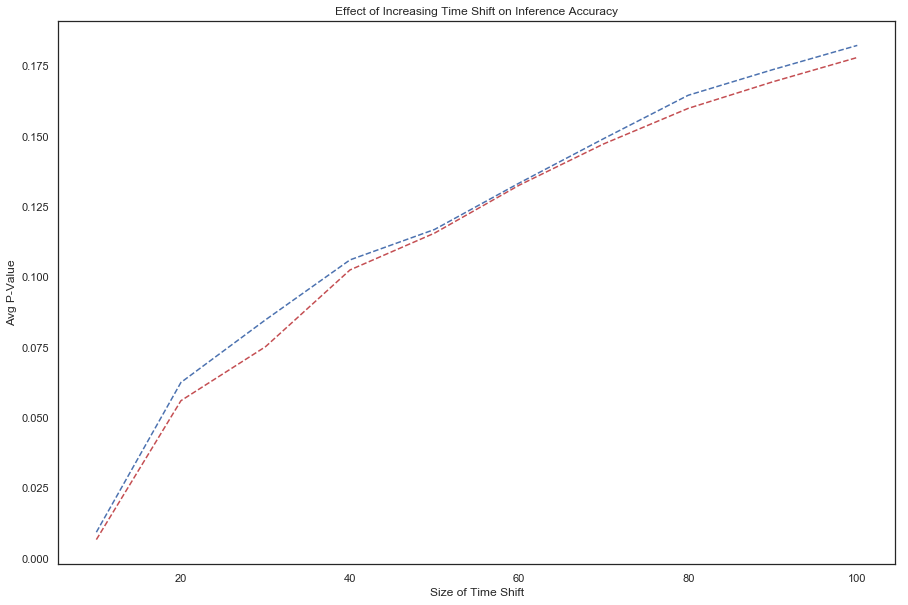

In [39]:
# plot p value by time shift here for both the linear and non linear methods
import seaborn as sns
sns.set(style='white', context='notebook', rc={'figure.figsize':(15,10)})
f = plt.figure()
plt.title('Effect of Increasing Time Shift on Inference Accuracy')
plt.xlabel('Size of Time Shift')
plt.ylabel('Avg P-Value')
plt.plot(timeshifts, pvalue_bytimeshift, 'r--')
plt.plot(timeshifts, pvalue_bytimeshift_nl, 'b--')
plt.show()
f.savefig("linvnonlin_2.pdf", bbox_inches='tight')

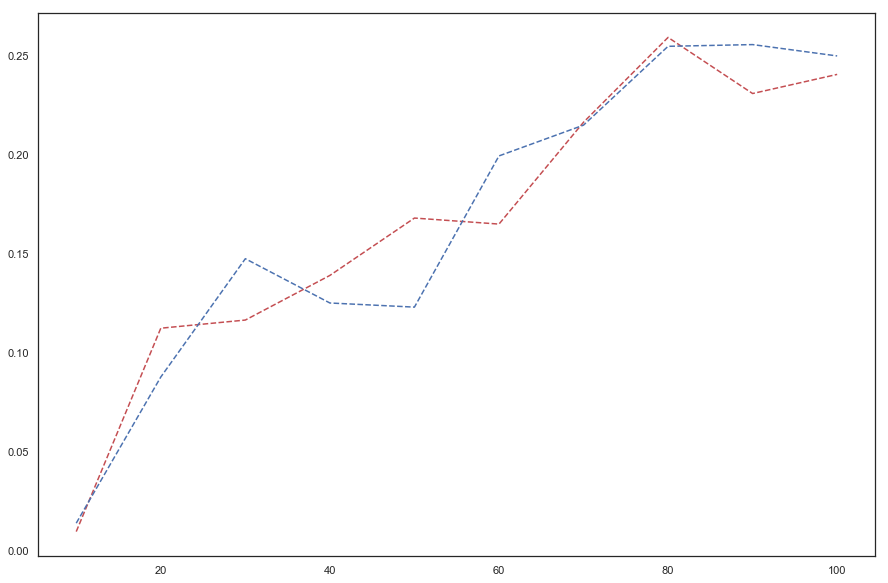

In [40]:
# plot p value by time shift here for both the linear and non linear methods
plt.plot(timeshifts, pvalue_linear_bytimeshift, 'r--')
plt.plot(timeshifts, pvalue_nonlinear_bytimeshift, 'b--')
plt.show()

0


FileNotFoundError: [Errno 2] No such file or directory: 'tsc_matrix_figures_10/100307.png'

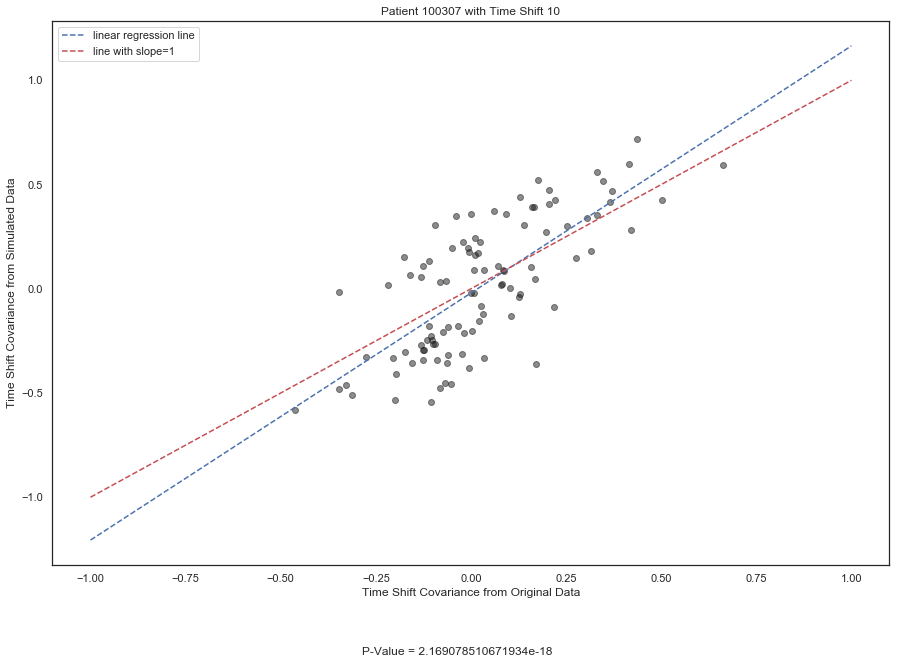

In [41]:
# allwmatrices is a dictionary with patient identifiers as keys. allwmatrices[key] will return the w matrix 
# for that specific patient
slope_average = 0
pvalue_nonlinear_average = 0
counter = 0
timeshift=10
while timeshift <= 70:
    for patient in allwmatrices:
    #     w = allwmatrices[patient]
    #     sig = allsigs[patient]
    #     bias = allbiases[patient]

        w2 = allwmatrices2[patient]
        sig2 = allsigs2[patient]
        bias2 = allbiases2[patient]

        x_original = pca_data_dict[patient].T.copy()

        # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
    #     simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, power=1, bias=bias)

        simulated_data2 = simulate(pca_components, 1018, w=w2, sigma=sig2, rho=0, power=3, bias=bias2)

        # compute the time shift covariance matrices for the 'original' (transformed PCA MEG timecourse) and simulated data
        tsc_original = time_shift_cov(x_original, shift=timeshift)
    #     tsc_simulated = time_shift_cov(simulated_data[0], shift=10)
        tsc_simulated2 = time_shift_cov(simulated_data2[0], shift=timeshift)

    #     line_object = linregress(tsc_original, tsc_simulated)
        line_object2 = linregress(tsc_original, tsc_simulated2)
        f = plt.figure()
        plt.title('Patient ' + str(patient) + ' with Time Shift ' + str(timeshift))
        plt.xlabel('Time Shift Covariance from Original Data')
        plt.ylabel('Time Shift Covariance from Simulated Data')
        f.text(0.5, 0, 'P-Value = '+str(line_object2.pvalue), ha='center')

    #     plt.plot(tsc_original, tsc_simulated, 'ro', alpha=0.5)
        plt.plot(tsc_original, tsc_simulated2, 'ko', alpha=0.5)

        time_shift_axes = np.arange(-1, 2)
    #     plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'r--')
        plt.plot(time_shift_axes, (line_object2.slope*time_shift_axes)+line_object2.intercept, 'b--', label='linear regression line')

        plt.plot([-1, 1], [-1,1], 'r--', label='line with slope=1')
        plt.legend(loc='upper left')
        f.savefig('tsc_matrix_figures_'+str(timeshift)+'/'+patient+'.png')

        plt.show()
        plt.close()
    timeshift += 10

In [ ]:
# import matplotlib.backends.backend_pdf
# pdf = matplotlib.backends.backend_pdf.PdfPages("output.pdf")
# for fig in xrange(1, figure().number): ## will open an empty extra figure :(
#     pdf.savefig( fig )
# pdf.close()
# fig.text(.5, .05, txt, ha='center')
import seaborn as sns
sns.set(style='white', context='notebook', rc={'figure.figsize':(5, 5)})
for patient in allwmatrices:
    w = allwmatrices[patient]
    sig = allsigs[patient]
    bias = allbiases[patient]

    x_original = pca_data_dict[patient].T.copy()

    # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
    simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, bias=bias, power=1, initial=x_original[0])
    w_simulated, sig_simulated, bias_simulated = infer(simulated_data[0], power=1)
    
    f = plt.figure()
    line_object = linregress(w, w_simulated)
    plt.title('Patient ' + str(patient))
    plt.xlabel('W Matrix from Original Data')
    plt.ylabel('W Matrix from Simulated Data')
    plt.xlim([-0.25, 0.25])
    plt.ylim([-0.25, 0.25])
    plt.plot(w, w_simulated, 'ko', alpha=0.5)
    plt.plot([-0.25, 0.25], [-0.25,0.25], 'r--', label='line with slope=1')
    time_shift_axes = np.arange(start=-0.25, stop=0.25, step=0.01)
    plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--', label='linear regression line')
    plt.legend(loc='upper left')
    f.text(0.5, 0, 'P-Value = '+str(line_object.pvalue), ha='center')
    f.savefig('w_matrix_figures/'+patient+'linear.png')
    plt.show()
    plt.close()
#     print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
#     print("--------------------------------------------------------------")

In [ ]:
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("output.pdf")
# for fig in xrange(1, figure().number): ## will open an empty extra figure :(
#     pdf.savefig( fig )
# pdf.close()
# fig.text(.5, .05, txt, ha='center')
sns.set(style='white', context='notebook', rc={'figure.figsize':(6, 6)})
for patient in allwmatrices2:
    w = allwmatrices2[patient]
    sig = allsigs2[patient]
    bias = allbiases2[patient]

    x_original = pca_data_dict2[patient].T.copy()

    # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
    simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, bias=bias, power=3, initial=x_original[0])
    w_simulated, sig_simulated, bias_simulated = infer(simulated_data[0], power=3)
    
    f = plt.figure()
    line_object = linregress(w, w_simulated)
    plt.title('Patient ' + str(patient))
    plt.xlabel('W Matrix from Original Data')
    plt.ylabel('W Matrix from Simulated Data')
    plt.xlim([-0.25, 0.25])
    plt.ylim([-0.25, 0.25])
    plt.plot(w, w_simulated, 'ko', alpha=0.5)
    plt.plot([-0.25, 0.25], [-0.25,0.25], 'r--', label='line with slope=1')
    time_shift_axes = np.arange(start=-0.25, stop=0.25, step=0.01)
    plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--', label='linear regression line')
    plt.legend(loc='upper left')
    f.text(0.5, 0, 'P-Value = '+str(line_object.pvalue), ha='center')
    f.savefig('w_matrix_figures/'+patient+'.png')
    plt.show()
    plt.close()
#     print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
#     print("--------------------------------------------------------------")

In [ ]:
#try to quantify pvalue cutoffs for certain time shifts

#run pca on the first 2-3 components of the W matrices
pca_wmatrices = np.array([])
for patient in allwmatrices2:
    if pca_wmatrices.size == 0:
        pca_wmatrices = np.asarray(allwmatrices2[patient])
    else:
        pca_wmatrices = np.concatenate((pca_wmatrices, np.asarray(allwmatrices2[patient])), axis=1)

In [ ]:
np.matrix(pca_wmatrices).shape

In [ ]:
pca_w = PCA(n_components=2)
pca_w.fit(np.matrix(pca_wmatrices).T)
transformed_data_w = pca_w.fit_transform(np.matrix(pca_wmatrices).T)

In [ ]:
transformed_data_w

In [ ]:
pca_wmatrices_postprocess = {}
counter = 0
for patient in allwmatrices2:
    print(patient)
    pca_wmatrices_postprocess[patient] = transformed_data_w[counter*10:10*(counter+1), :].T
    counter = counter + 1

In [ ]:
pca_wmatrices_postprocess['100307'].shape

In [ ]:
clustering_prepare_w = []
for patient in pca_wmatrices_postprocess:
    clustering_prepare_w.append(pca_wmatrices_postprocess[patient].flatten())
    

In [ ]:
clustering_prepare_w[0]

In [ ]:
pca_tscmatrices = []
for patient in pca_data_dict:
    pca_tscmatrices.append(time_shift_cov(pca_data_dict[patient].T, shift=40).flatten())

In [ ]:
pca_tsc = PCA(n_components=10)
pca_tsc.fit(np.matrix(pca_tscmatrices))
transformed_data_tsc = pca_tsc.fit_transform(np.matrix(pca_tscmatrices))

In [ ]:
transformed_data_w.shape

In [ ]:
# Cluster the wmatrices using spectral clustering
from sklearn.cluster import SpectralClustering
from scipy import stats
import numpy as np
from itertools import cycle, islice
clustering_w = SpectralClustering(assign_labels="discretize",
             random_state=0).fit(clustering_prepare_w)
# clustering = SpectralClustering(assign_labels="kmeans").fit(flattened_wmatrix_array)

cluster_dict_w = {}
counter = 0
for grouping in clustering_w.labels_:
    if grouping not in cluster_dict_w:
        cluster_dict_w[grouping] = [dataset_ids[counter]]
    else:
        cluster_dict_w[grouping].append(dataset_ids[counter])
    counter = counter + 1

for key in cluster_dict_w:
    print("Number of Patients in Cluster", key, ":", len(cluster_dict_w[key]))
    
cluster_number = len(cluster_dict_w.keys())

In [ ]:
# Cluster the wmatrices using spectral clustering
from sklearn.cluster import SpectralClustering
from scipy import stats
import numpy as np
from itertools import cycle, islice
clustering_tsc = SpectralClustering(assign_labels="discretize",
             random_state=0).fit(transformed_data_tsc)
# clustering = SpectralClustering(assign_labels="kmeans").fit(flattened_wmatrix_array)

cluster_dict_tsc = {}
counter = 0
for grouping in clustering_tsc.labels_:
    if grouping not in cluster_dict_tsc:
        cluster_dict_tsc[grouping] = [dataset_ids[counter]]
    else:
        cluster_dict_tsc[grouping].append(dataset_ids[counter])
    counter = counter + 1

for key in cluster_dict_tsc:
    print("Number of Patients in Cluster", key, ":", len(cluster_dict_tsc[key]))
    
cluster_number = len(cluster_dict_tsc.keys())

In [ ]:
clustering_w.labels_

In [ ]:
plt.scatter(transformed_data_w[:, 0], transformed_data_w[:, 1], c=clustering_w.labels_, s=50, cmap='Spectral')

In [ ]:
pvalue_avg = []
rvalue_avg = []
for patient in allwmatrices2:
    w = allwmatrices2[patient]
    w_transpose = np.random.permutation(w)
    sig = allsigs2[patient]
    bias = allbiases2[patient]
    
    
    simulated_patient = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, bias=bias, power=3, initial=pca_data_dict2[patient].T[0])
    simulated_patient2 = simulate(pca_components, 1018, w=w_transpose, sigma=sig, rho=0, bias=bias, power=3, initial=pca_data_dict2[patient].T[0])
    tsc_original = time_shift_cov(pca_data_dict[patient].T, shift=10)
    tsc_simulated = time_shift_cov(simulated_patient[0], shift=10)
    tsc_simulated2 = time_shift_cov(simulated_patient2[0], shift=10)
    
    line_object = linregress(tsc_original, tsc_simulated)
    line_object2 = linregress(tsc_original, tsc_simulated2)
    plt.title('Patient ' + str(patient))
    plt.xlabel('time_shift_cov original')
    plt.ylabel('time_shift_cov simulated')
    plt.plot(tsc_original, tsc_simulated, 'ro', alpha=0.5)
    plt.plot(tsc_original, tsc_simulated2, 'bo', alpha=0.5)
    
    time_shift_axes = np.arange(-1, 2)
    plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'r--')
    plt.plot(time_shift_axes, (line_object2.slope*time_shift_axes)+line_object2.intercept, 'b--')
    
    plt.plot([-1, 1], [-1,1], 'g--')
    plt.show()
    plt.close()
    print(line_object.pvalue)
    print(line_object.rvalue)
    print()
    pvalue_avg.append(line_object.pvalue)
    rvalue_avg.append(line_object.rvalue)

print('mean p', np.mean(pvalue_avg))
print('std p', np.std(pvalue_avg))
print()
print('mean r', np.mean(rvalue_avg))
print('std r', np.std(rvalue_avg))

In [ ]:
pvalue_avg = []
rvalue_avg = []
for patient in allwmatrices2:
    w = allwmatrices2[patient]
    w_transpose = w.T
    sig = allsigs2[patient]
    bias = allbiases2[patient]
    
    
    simulated_patient = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, bias=bias, power=3, initial=pca_data_dict2[patient].T[0])
    simulated_patient2 = simulate(pca_components, 1018, w=w_transpose, sigma=sig, rho=0, bias=bias, power=3, initial=pca_data_dict2[patient].T[0])
    tsc_original = time_shift_cov(pca_data_dict[patient].T, shift=10)
    tsc_simulated = time_shift_cov(simulated_patient[0], shift=10)
    tsc_simulated2 = time_shift_cov(simulated_patient2[0], shift=10)
    
    line_object = linregress(tsc_original, tsc_simulated)
    line_object2 = linregress(tsc_original, tsc_simulated2)
    plt.title('Patient ' + str(patient))
    plt.xlabel('time_shift_cov original')
    plt.ylabel('time_shift_cov simulated')
    plt.plot(tsc_original, tsc_simulated, 'ro', alpha=0.5)
    plt.plot(tsc_original, tsc_simulated2, 'bo', alpha=0.5)
    
    time_shift_axes = np.arange(-1, 2)
    plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'r--')
    plt.plot(time_shift_axes, (line_object2.slope*time_shift_axes)+line_object2.intercept, 'b--')
    
    plt.plot([-1, 1], [-1,1], 'g--')
    plt.show()
    plt.close()
    print(line_object.pvalue)
    print(line_object.rvalue)
    print()
    print(line_object2.pvalue)
    print(line_object2.rvalue)
    pvalue_avg.append(line_object.pvalue)
    rvalue_avg.append(line_object.rvalue)

print('mean p', np.mean(pvalue_avg))
print('std p', np.std(pvalue_avg))
print()
print('mean r', np.mean(rvalue_avg))
print('std r', np.std(rvalue_avg))

In [ ]:
pvalue_avg = []
rvalue_avg = []
for patient in cluster_dict_w[0]:
    w = allwmatrices2[patient]
    sig = allsigs2[patient]
    bias = allbiases2[patient]
    
    
    simulated_patient = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, bias=bias, power=3, initial=pca_data_dict2[patient].T[0])
    tsc_original = time_shift_cov(pca_data_dict[patient].T, shift=20)
    tsc_simulated = time_shift_cov(simulated_patient[0], shift=20)
    
    line_object = linregress(tsc_original, tsc_simulated)
    plt.title('Patient ' + str(patient))
    plt.xlabel('time_shift_cov original')
    plt.ylabel('time_shift_cov simulated')
    plt.plot(tsc_original, tsc_simulated, 'ro', alpha=0.5)
    
    time_shift_axes = np.arange(-1, 2)
    plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'r--')
    
    plt.plot([-1, 1], [-1,1], 'g--')
    plt.show()
    plt.close()
    print(line_object.pvalue)
    print(line_object.rvalue)
    pvalue_avg.append(line_object.pvalue)
    rvalue_avg.append(line_object.rvalue)

print('mean p', np.mean(pvalue_avg))
print('std p', np.std(pvalue_avg))
print()
print('mean r', np.mean(rvalue_avg))
print('std r', np.std(rvalue_avg))


In [ ]:
pvalue_avg = []
rvalue_avg = []
for patient in cluster_dict_tsc[7]:
    w = allwmatrices2[patient]
    sig = allsigs2[patient]
    bias = allbiases2[patient]
    
    
    simulated_patient = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, bias=bias, power=3)
    tsc_original = time_shift_cov(pca_data_dict[patient].T, shift=40)
    tsc_simulated = time_shift_cov(simulated_patient[0], shift=40)
    
    line_object = linregress(tsc_original, tsc_simulated)
    plt.title('Patient ' + str(patient))
    plt.xlabel('time_shift_cov original')
    plt.ylabel('time_shift_cov simulated')
    plt.plot(tsc_original, tsc_simulated, 'ro', alpha=0.5)
    
    time_shift_axes = np.arange(-1, 2)
    plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'r--')
    
    plt.plot([-1, 1], [-1,1], 'g--')
    plt.show()
    plt.close()
    print(line_object.pvalue)
    print(line_object.rvalue)
    pvalue_avg.append(line_object.pvalue)
    rvalue_avg.append(line_object.rvalue)

print('mean p', np.mean(pvalue_avg))
print('std p', np.std(pvalue_avg))
print()
print('mean r', np.mean(rvalue_avg))
print('std r', np.std(rvalue_avg))

In [ ]:
plt.scatter(transformed_data_w[:, 0], transformed_data_w[:, 1], c=clustering_tsc.labels_, s=50, cmap='Spectral')

In [ ]:
cluster_dict_w

In [ ]:
#try to quantify pvalue cutoffs for certain time shifts

#run pca on the first 2-3 components of the W matrices
pca_tscmatrices = []
for patient in pca_data_dict:
    pca_tscmatrices.append(time_shift_cov(pca_data_dict[patient].T, shift=time_shift).flatten())

In [ ]:
np.matrix(pca_tscmatrices).shape

In [ ]:
pca_tsc = PCA(n_components=2)
pca_tsc.fit(np.matrix(pca_tscmatrices))
transformed_data_tsc = pca_tsc.fit_transform(np.matrix(pca_tscmatrices))

In [ ]:
transformed_data_tsc.shape

In [ ]:
plt.scatter(transformed_data_tsc[:, 0], transformed_data_tsc[:, 1], c=clustering_tsc.labels_, s=50, cmap='Spectral')

In [ ]:
plt.scatter(transformed_data_tsc[:, 0], transformed_data_tsc[:, 1], c=clustering_w.labels_, s=50, cmap='Spectral')

In [ ]:
# Cluster the wmatrices using spectral clustering
from sklearn.cluster import SpectralClustering
from scipy import stats
import numpy as np
from itertools import cycle, islice
clustering_tsc = SpectralClustering(assign_labels="discretize",
             random_state=0).fit(transformed_data_tsc)
# clustering = SpectralClustering(assign_labels="kmeans").fit(flattened_wmatrix_array)

cluster_dict_tsc = {}
counter = 0
for grouping in clustering_tsc.labels_:
    if grouping not in cluster_dict_tsc:
        cluster_dict_tsc[grouping] = [dataset_ids[counter]]
    else:
        cluster_dict_tsc[grouping].append(dataset_ids[counter])
    counter = counter + 1

for key in cluster_dict_tsc:
    print("Number of Patients in Cluster", key, ":", len(cluster_dict_tsc[key]))
    
cluster_number = len(cluster_dict_tsc.keys())

In [ ]:
#calculate the average w matrix for each cluster
avg_w_plot = {}
for key in cluster_dict_w:
    avg_w_matrix = np.zeros((pca_components, pca_components))
    count = 0
    for patient in cluster_dict_w[key]:
        avg_w_matrix += allwmatrices2[patient]
        count += 1
    avg_w_plot[key] = avg_w_matrix/count


In [ ]:
for key in avg_w_plot:
    for key2 in avg_w_plot:
        if key2 != key:
            line_object = linregress(avg_w_plot[key], avg_w_plot[key2])
            plt.title('Plot for ' + str(key) + ' and ' + str(key2))
            plt.plot(avg_w_plot[key], avg_w_plot[key2], 'ko', alpha=0.5)
            plt.plot([-1, 1], [-1,1], 'r--')
            time_shift_axes = np.arange(-1, 2)
            plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
            plt.show()
            plt.close()
            plt.show()
            print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
            print("--------------------------------------------------------------")

In [ ]:
for key in avg_w_plot:
    for key2 in avg_w_plot:
        if key2 != key:
            print(key, key2)
            subtract = avg_w_plot[key] - avg_w_plot[key2]
            seaborn.heatmap(subtract)
            plt.show()
            plt.close()

In [ ]:
# calculate the average tsc matrix for each cluster, and plot against each other
avg_tsc_plot = {}
for key in cluster_dict_tsc:
    avg_tsc_matrix = np.zeros((pca_components, pca_components))
    count = 0
    for patient in cluster_dict_tsc[key]:
        avg_tsc_matrix += time_shift_cov(pca_data_dict[patient].T, shift=time_shift)
        count += 1
    avg_tsc_plot[key] = avg_tsc_matrix/count

        


In [ ]:
for key in avg_tsc_plot:
    for key2 in avg_tsc_plot:
        if key2 != key:
            line_object = linregress(avg_tsc_plot[key], avg_tsc_plot[key2])
            plt.title('Plot for ' + str(key) + ' and ' + str(key2))
            plt.plot(avg_tsc_plot[key], avg_tsc_plot[key2], 'ko', alpha=0.5)
            plt.plot([-1, 1], [-1,1], 'r--')
            time_shift_axes = np.arange(-1, 2)
            plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
            plt.show()
            plt.close()
            plt.show()
            print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
            print("--------------------------------------------------------------")

In [ ]:
for key in avg_tsc_plot:
    for key2 in avg_tsc_plot:
        if key2 != key:
            subtract = avg_tsc_plot[key] - avg_tsc_plot[key2]
            seaborn.heatmap(subtract)
            plt.show()
            plt.close()

In [ ]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

def union(lst1, lst2):
    return list(set(lst1) | set(lst2))

In [ ]:
frequency_map = np.zeros((len(cluster_dict_w.keys()), len(cluster_dict_tsc.keys())))
for cluster in cluster_dict_w:
    for cluster2 in cluster_dict_tsc:
        if cluster2 > 2:
            frequency_map[cluster][cluster2-1] = len(intersection(cluster_dict_w[cluster], cluster_dict_tsc[cluster2]))/len(union(cluster_dict_w[cluster], cluster_dict_tsc[cluster2]))
        else:
            frequency_map[cluster][cluster2] = len(intersection(cluster_dict_w[cluster], cluster_dict_tsc[cluster2]))/len(union(cluster_dict_w[cluster], cluster_dict_tsc[cluster2]))
import seaborn
seaborn.heatmap(frequency_map, annot=True)    
plt.show()
plt.close()

In [ ]:
cluster_dict_w[1]

In [ ]:
cluster_dict_tsc[0]

In [ ]:
intersection(cluster_dict_w[1], cluster_dict_tsc[0])

In [ ]:
union(cluster_dict_w[1], cluster_dict_tsc[0])

In [ ]:
# are the same sets of patients in the same cluster groupings across time shift cov and w matrices?
for key in cluster_dict_w:
    print("Cluster", key, ":", cluster_dict_w[key])
print()
for key in cluster_dict_tsc:
    print("Cluster", key, ":", cluster_dict_tsc[key])
    
links = {}
for key in cluster_dict_w:
    for patient in cluster_dict_w[key]:
        for key2 in cluster_dict_tsc:
            for patient2 in cluster_dict_tsc[key2]:
                if patient == patient2:
                    #do something
                    links[patient] = (key, key2)
                    
# for key in cluster_dict_tsc:
#     for patient in cluster_dict_tsc[key]:
#         for key2 in cluster_dict_w:
#             for patient2 in cluster_dict_w[key2]:
#                 if patient == patient2:
#                     #do something
#                     links[patient] = (key, key2)

In [ ]:
links

In [ ]:
frequency_dict = {}
for value in links.values():
    if value not in frequency_dict:
        frequency_dict[value] = 1
    else:
        frequency_dict[value] += 1

for key in frequency_dict:
    if frequency_dict[key] >= 4 :
        print("Cluster Common Count:", key, "=", frequency_dict[key])

In [ ]:
# cluster_mapping_matrix = np.zeros((len(cluster_dict_w.keys()), len(cluster_dict_tsc.keys())))
# for key_w in cluster_dict_w:
#     for key_tsc in cluster_dict_tsc:
#         cluster_mapping_matrix[key_w][key_tsc] = len(intersection(cluster_dict_w[key_w], cluster_dict_tsc[key_tsc]))/len(union(cluster_dict_w[key_w], cluster_dict_tsc[key_tsc]))
        
# import seaborn
# seaborn.heatmap(cluster_mapping_matrix, annot=True)    
# plt.show()
# plt.close()


for num_clusters in range(4, 8):
    kmeans_labels_tsc = cluster.KMeans(n_clusters=num_clusters, random_state=42).fit_predict(flattened_tscmatrix_array)   
    kmeans_labels_w = cluster.KMeans(n_clusters=num_clusters, random_state=42).fit_predict(flattened_wmatrix_array)
    
    cluster_dict_kmeans_w = {}
    counter = 0
    for grouping in kmeans_labels_w:
        if grouping not in cluster_dict_kmeans_w:
            cluster_dict_kmeans_w[grouping] = [dataset_ids[counter]]
        else:
            cluster_dict_kmeans_w[grouping].append(dataset_ids[counter])
        counter = counter + 1

    cluster_dict_kmeans_tsc = {}
    counter = 0
    for grouping in kmeans_labels_tsc:
        if grouping not in cluster_dict_kmeans_tsc:
            cluster_dict_kmeans_tsc[grouping] = [dataset_ids[counter]]
        else:
            cluster_dict_kmeans_tsc[grouping].append(dataset_ids[counter])
        counter = counter + 1
     
    cluster_mapping_matrix = np.zeros((len(cluster_dict_kmeans_w.keys()), len(cluster_dict_kmeans_tsc.keys())))
    for key_w in cluster_dict_kmeans_tsc:
        for key_tsc in cluster_dict_kmeans_tsc:
            cluster_mapping_matrix[key_w][key_tsc] = len(intersection(cluster_dict_kmeans_w[key_w], cluster_dict_kmeans_tsc[key_tsc]))/len(union(cluster_dict_kmeans_w[key_w], cluster_dict_kmeans_tsc[key_tsc]))
    
    import seaborn
    seaborn.heatmap(cluster_mapping_matrix, annot=True)    
    plt.show()
    plt.close()

# Separator

In [ ]:
pca_wmatrix_dictionary = {}
counter = 0
for patient in allwmatrices2:
    pca_wmatrix_dictionary[patient] = transformed_data_w[counter*10:10*(counter+1), :].T
    counter = counter + 1

In [ ]:
pca_wmatrix_dictionary

In [ ]:
# spectral clustering, spectrally cluster the W matrices of all the patients to see if certain patients fall into 
# certain categories. Do for all 88 patients

# prepare a matrix to input into the spectral clustering function, must flatten all the W matrices
def wmatrix_clustering_prepare(allwmatrices):
    flattened_wmatrix_array = []
    unflattened_wmatrix_dict = {}
    counter = 0
    for patient in allwmatrices:
        flattened_matrix = allwmatrices[patient].flatten()
        unflattened_wmatrix_dict[counter] = allwmatrices[patient]
        if len(flattened_wmatrix_array) == 0:
            flattened_wmatrix_array = [flattened_matrix]
        else:
            flattened_wmatrix_array.append(flattened_matrix)
        counter = counter + 1
    return flattened_wmatrix_array, unflattened_wmatrix_dict

flattened_wmatrix_array, unflattened_wmatrix_dict = wmatrix_clustering_prepare(pca_wmatrix_dictionary)

# Cluster the wmatrices using spectral clustering
from sklearn.cluster import SpectralClustering
from scipy import stats
import numpy as np
from itertools import cycle, islice
clustering_w = SpectralClustering(assign_labels="discretize",
             random_state=0).fit(flattened_wmatrix_array)
# clustering = SpectralClustering(assign_labels="kmeans").fit(flattened_wmatrix_array)

cluster_dict_w = {}
counter = 0
for grouping in clustering_w.labels_:
    if grouping not in cluster_dict_w:
        cluster_dict_w[grouping] = [dataset_ids[counter]]
    else:
        cluster_dict_w[grouping].append(dataset_ids[counter])
    counter = counter + 1

for key in cluster_dict_w:
    print("Number of Patients in Cluster", key, ":", len(cluster_dict_w[key]))
    
cluster_number = len(cluster_dict_w.keys())

In [ ]:
import umap
from sklearn.datasets import load_digits

standard_embedding_w = umap.UMAP(random_state=42).fit_transform(np.matrix(flattened_wmatrix_array))
w_embedded = TSNE(n_components=2, random_state=42).fit_transform(flattened_wmatrix_array)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='white', context='notebook', rc={'figure.figsize':(8,8)})
plt.scatter(standard_embedding_w[:, 0], standard_embedding_w[:, 1], c=clustering_w.labels_, s=100, cmap='Spectral');
plt.show()
plt.close()

plt.scatter(w_embedded[:, 0], w_embedded[:, 1], c=clustering_w.labels_, s=100, cmap='Spectral');
plt.show()
plt.close()

In [ ]:
from sklearn.manifold import TSNE
sns.set(style='white', context='notebook', rc={'figure.figsize':(8,8)})

w_embedded = TSNE(n_components=2, random_state=42).fit_transform(flattened_wmatrix_array)

import sklearn.cluster as cluster
kmeans_labels_w = cluster.KMeans(n_clusters=8, random_state=42).fit_predict(flattened_wmatrix_array)

plt.scatter(standard_embedding_w[:, 0], standard_embedding_w[:, 1], c=kmeans_labels_w, s=100, cmap='Spectral');
plt.show()
plt.close()

plt.scatter(w_embedded[:, 0], w_embedded[:, 1], c=kmeans_labels_w, s=100, cmap='Spectral');
plt.show()
plt.close()

In [ ]:
print(kmeans_labels_w)